In [108]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

In [306]:
# In order to have a wider notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Class MLP
This class lets you build a simple Multi-Layer perceptron (MLP) with just one hidden layer.

The class should be used in the following way:  
first, create an instance
```python
mlp = MLP()
```
then, initialize the class, specifying the characteristics of the network you want
```python
mlp.initialize(NI=5, NH=3, NO=1, activation_h=sigmoid, activation_o=linear)
```
with this call, the network is initialized with 5 input units, 3 units on the (only) hidden layer, and one unit on the output layer. In addition to that, the network will use a sigmoid activation function on the hidden units and a linear activation function on the output unit.  
Then you can finally train the network:
```python
mlp.train(X, y, n_epochs, batch_size, learning_rate, X_test=None, y_test=None)
```
the usage of all the parameters should be straightforward; if you include a test set, this will be used in order to compare its error with the error of the network on the train set.  
Once trained, calling
```python
mlp.predict(p)
```
will give you the prediction of the network on the given input point


## Activation Functions

In the following cells, the (supported) activation functions are defined. Each activation function is defined as a class so that calling:
```python
activation.f(x)
```
yelds the output of the function for the input x, and calling:
```python
activation.d_f(x)
```
yelds the output of the derivative of the function for the input x.  

In [2]:
class sigmoid:
    def f(x):
        return 1/(1+np.exp(-x))
    def d_f(x):
        return sigmoid.f(x)*(1-sigmoid.f(x))

In [3]:
class linear:
    def f(x):
        return x
    def d_f(x):
        return 1

In [4]:
class tanh:
    def f(x):
        return np.tanh(x)
    def d_f(x):
        return 1-tanh.f(x)**2

## Error Function
For this implementation, the function mean squared error is used as a loss function.  
it is computed as $$\frac{1}{2}\sum_{i=1}^{|t|} (t_i - y_i)^2$$
where $t$ is the target vector and $y$ is the prediction of the network.

In [5]:
def mse(t, y):
        return 0.5 * sum([(v[0]-v[1])**2 for v in zip(t, y)])

## Variables and Conventions 
The (main) variables used throughout the class are the following:  
```python
NI = # Number of input units
NH = # Number of hidden units
NO = # Number of output units

W1 = # Weights connecting the hidden and the input layer, indexed W1[h, i] where h is the index of the hidden unit and i is the index of the input unit
W2 = # Weights connecting the output and the hidden layer, indexed W2[o, h]

dW1 = # Temporary store of the changes to be applied to the weights in W1
dW2 = # Temporary store of the changes to be applied to the weights in W2

H = # Last output of the hidden units 
O = # Last output of the output units

Z1 = # Last input of the hidden units (often called 'net')
Z2 = # Last input of the output units

activation_h = # Hidden layer activation function
activation_o = # Output layer activation function
```

Throughout the code, the same indexing convention of the book 'Pattern Recognition And Machine Learning' by <i>C. Bishop</i> is used (Neural Networks are covered in chapter 5). In short, the convention consists of indexing the units from $N$ to 1. This is straightforward in cases where biases are involved, in all the other cases the first position of the list (index 0) is initialized and left empty. Following this convention, the lists are iterated in reversed ordering, from the last to the first index.

## Backpropagation 
As in the book 'Pattern Recognition And Machine Learning' by <i>C. Bishop</i>, the backpropagation is carried out in the following way:  
first of all, the $\delta$'s of the output units are computed:
$$\delta_{o}=(t_o-y_o)\times activation'_{out}(net_o)$$
where $o$ is the index of the output unit.  
These values are then used in order to compute the $\delta$'s for the hidden units:
$$\delta_{h}=activation'_{hidden}(net_h) \times \sum_{o = 1}^{NO}W_{o, h}\delta_o$$
where $h$ is the index of the hidden unit.  
The derivatives with respect to the weight connecting the hidden and output layer are then computed as:
$$\frac{\partial}{\partial W_{o, h}}=\delta_o \times H_h$$
where $H_h$ is the last output of the hidden unit $h$. As regards the weights connecting the hidden layer to the input layer, they are computed as:
$$\frac{\partial}{\partial W_{h, i}}=\delta_h \times X_i$$
Then the weights are updated as:
$$W_{a, b} = W_{a, b} + \frac{\partial}{\partial W_{a, b}} * learning\_rate$$

In [195]:
class MLP:
    def initialize(self, NI, NH, NO, activation_h, activation_o):
        
        # Number of units per layer
        self.NI = NI
        self.NH = NH
        self.NO = NO
                
        # Activation functions
        self.activation_h = activation_h
        self.activation_o = activation_o
        
        # Random initialization of the weights (performs He initialization)
        self.W1 = np.random.randn(self.NH+1, self.NI +1)*np.sqrt(2/(self.NI+self.NH))
        self.W2 = np.random.randn(self.NO+1, self.NH +1)*np.sqrt(2/(self.NH+self.NO))
        
        # Variables storing the updates of the weights, waiting to be performed
        self.dW1 = np.zeros((self.NH+1, self.NI +1))
        self.dW2 = np.zeros((self.NO+1, self.NH +1))
        
        # Variables storing the input of the activation functions (nets) 
        # for the hidden layer (Z1) and for the output layer (Z2)
        self.Z1 = np.zeros(self.NH+1)
        self.Z2 = np.zeros(self.NO+1)
        
        # Variables storing the output of the activation functions
        self.H = np.ones(self.NH+1)
        self.O = np.ones(self.NO+1)
        return
    
    def __forward__(self, I):
        
        # If the user inputs an np array, this is converted to a list
        # The field self.X stores the last input of the network
        try:
            self.X = I.tolist()
        except:
            self.X = I
        
        # For the bias, concatenates a 1 to the beginning of the input X
        self.X= [1] + self.X
        
        # Computes and stores the activations of the hidden layer
        for h in reversed(range(1, self.NH+1)):
            net = 0
            for i in reversed(range(0, self.NI+1)):
                net = net + self.X[i]*self.W1[h, i]
                
            self.Z1[h] = net
            self.H[h] = self.activation_h.f(net)
            
        # Computes and stores the activations of the output layer
        for o in reversed(range(1, self.NO+1)):
            net = 0
            for h in reversed(range(0, self.NH+1)):
                net = net + self.H[h]*self.W2[o, h]
            self.Z2[o] = net
            self.O[o] = self.activation_o.f(net)

        # Returns the outputs of the network
        return self.O[1:].copy()
    
    def __backwards__(self, t):
        
        # If the user inputs an np array, this is converted to a list
        # The field self.X stores the last input of the network
        try:
            self.target = t.tolist()
        except:
            self.target = t
            
        # Adds a 1 in the first position of the list in order to be consistent with 
        # the indexing convention
        self.target = [1] + self.target

        # Computes the deltas for the output layer
        deltas_out = [1]
        for o in range(1, self.NO+1):
            
            # Error = terget[i] - output[i]
            current_error = (self.target[o]-self.O[o])
            # Derivative = d/dx activation(net)
            derivative = self.activation_o.d_f(self.Z2[o])
            
            deltas_out.append(current_error * derivative)
        
        
        # Computes the deltas for the hidden units 
        deltas_hidden = []
        for h in reversed(range(1, self.NH+1)):
            
            # Computes the weighted sum delta_output[o]*weight[o, h]
            error = 0
            for o in reversed(range(1, self.NO+1)):
                error += (deltas_out[o] * self.W2[o, h])
            
            derivative = self.activation_h.d_f(self.Z1[h])
            deltas_hidden.append(derivative*error)
            
        # Adds 1 and reverses the list for indexing consistency
        deltas_hidden = list(reversed(deltas_hidden))
        deltas_hidden = [1] + deltas_hidden
                
        # computation of the weight changes
        for h in reversed(range(0, self.NH+1)):
            for o in reversed(range(1, self.NO+1)):
                self.dW2[o, h] = self.dW2[o, h] + (deltas_out[o]*self.H[h])
        for i in reversed(range(0, self.NI+1)):
            for h in reversed(range(1, self.NH+1)):
                self.dW1[h, i] = self.dW1[h, i] + (deltas_hidden[h]*self.X[i])      
                
        return mse(self.target, self.O)
                          
    def __update_weights__(self, learning_rate):
        
        # h iterates over the hidden units, i over the input units
        for h in reversed(range(1, self.NH+1)):
            for i in reversed(range(0, self.NI+1)):
                
                update = (learning_rate * self.dW1[h, i])
                self.W1[h, i] += update
                
        for o in reversed(range(1, self.NO+1)):
            for h in reversed(range(0, self.NH+1)):
                          
                update = (learning_rate * self.dW2[o, h])
                self.W2[o, h] += update
                
        self.__initialize_weight_updates__()
        return
    
    def __initialize_weight_updates__(self):
        self.dW1 = np.zeros((self.NH+1, self.NI +1))
        self.dW2 = np.zeros((self.NO+1, self.NH +1))
        return
    
    def predict(self, X):
        return self.__forward__(X)
    
    def print_all(self):
        print("Weights")
        print(self.W1)
        print(self.W2)
        
        print("Updates")
        print(self.dW1)
        print(self.dW2)
        
        print("nets")
        print(self.Z1)
        print(self.Z2)
        
        print("Activations")
        print(self.H)
        print(self.O)
        
        return 
    
    def plot_error(self, n_epochs, errors, test_errors = None):
        
        epochs = [i for i in range(n_epochs)]
        
        msg = "\nPlot of average mean squared error for each input"
        msg +="\nin the train set"
        
        if test_errors is not None:
            plt.plot(epochs, test_errors, label="test m.s. error")
            msg +=" and test set:"
                        
        plt.plot(epochs, errors, label="train m.s. error")
        plt.ylim=(0, 1)
        plt.xlabel('epochs')
        plt.ylabel('errors')
        
        plt.legend(loc='upper right')
        
        print(msg)
        plt.show()
    
    
    def train(self, X, y, n_epochs, batch_size, learning_rate, X_test=None, y_test=None):
        n_samples = len(X)
        
        train_errors = []
        test_errors = [] if X_test is not None else None
        
        for e in range(n_epochs):
            
            error = 0
            for i in range(1, n_samples+1):
                self.__forward__(X[i-1])
                error += self.__backwards__(y[i-1])
                
                if i % batch_size == 0 or i == n_samples+1:
                    self.__update_weights__(learning_rate)
                
            print("Epoch = "+str(e)+" MSError= "+str(error))
            
            # Saving the errors for each epoch
            train_errors.append(error/float(n_samples))
            if test_errors is not None:
                test_predictions = [self.predict(item) for item in X_test]
                individual_test_errors = [mse(v[0], v[1]) for v in zip(test_predictions, y_test)]
                test_errors.append(sum(individual_test_errors)/float(len(individual_test_errors)))
                

        self.plot_error(n_epochs, train_errors, test_errors)
                    
        return
    

## XOR Test
The following cells contain training and testing of an MLP with 2 input units, 2 hidden units and 1 output unit on the XOR problem. The tests have been done with different configurations of hidden and output activation function. In general, the linear activation function performs much better than the sigmoid for the output layer, but this is due to the fact that the targets for the xor are 0 and 1, values that the sigmoid can never practically reach; so it needs an input that tends to minus infinity in order to output 0, and plus infinity in order to get 1. In any case, although it cannot approximate the function with the same accuracy, the network learns anyway. As regards the hidden layer, the network manages to learn the function without problems independently of the fact that the sigmoid or the tanh aree used; in general, the network seems to converge faster if tanh is used.

In [185]:
X=[[0, 0], [0, 1], [1, 0], [1, 1]]

In [186]:
y = [[0], [1], [1], [0]]

Epoch = 0 MSError= 0.6149307301817055
Epoch = 1 MSError= 0.5901378846300841
Epoch = 2 MSError= 0.5686759790038249
Epoch = 3 MSError= 0.5510986764058997
Epoch = 4 MSError= 0.5374181701113906
Epoch = 5 MSError= 0.5272249182584021
Epoch = 6 MSError= 0.5198902005173673
Epoch = 7 MSError= 0.5147482495395118
Epoch = 8 MSError= 0.5112081211540714
Epoch = 9 MSError= 0.5087977710583728
Epoch = 10 MSError= 0.5071648915661476
Epoch = 11 MSError= 0.5060581051115437
Epoch = 12 MSError= 0.5053033662277134
Epoch = 13 MSError= 0.5047825787958349
Epoch = 14 MSError= 0.5044166841664238
Epoch = 15 MSError= 0.5041532273264184
Epoch = 16 MSError= 0.5039576042880107
Epoch = 17 MSError= 0.5038070666056861
Epoch = 18 MSError= 0.5036866862984986
Epoch = 19 MSError= 0.5035866714934236
Epoch = 20 MSError= 0.5035005943377888
Epoch = 21 MSError= 0.5034242270954036
Epoch = 22 MSError= 0.5033547802222407
Epoch = 23 MSError= 0.5032904046052917
Epoch = 24 MSError= 0.5032298667333088
Epoch = 25 MSError= 0.5031723367932

Epoch = 646 MSError= 0.39899981654049466
Epoch = 647 MSError= 0.3984957274671703
Epoch = 648 MSError= 0.3979928687186308
Epoch = 649 MSError= 0.3974912397651385
Epoch = 650 MSError= 0.39699083920803635
Epoch = 651 MSError= 0.3964916647859845
Epoch = 652 MSError= 0.39599371338149103
Epoch = 653 MSError= 0.3954969810277196
Epoch = 654 MSError= 0.3950014629155518
Epoch = 655 MSError= 0.39450715340088327
Epoch = 656 MSError= 0.3940140460121331
Epoch = 657 MSError= 0.39352213345794673
Epoch = 658 MSError= 0.39303140763507227
Epoch = 659 MSError= 0.3925418596363901
Epoch = 660 MSError= 0.3920534797590778
Epoch = 661 MSError= 0.39156625751289037
Epoch = 662 MSError= 0.39108018162853736
Epoch = 663 MSError= 0.39059524006614044
Epoch = 664 MSError= 0.3901114200237522
Epoch = 665 MSError= 0.3896287079459202
Epoch = 666 MSError= 0.38914708953227917
Epoch = 667 MSError= 0.38866654974615655
Epoch = 668 MSError= 0.3881870728231741
Epoch = 669 MSError= 0.38770864227983204
Epoch = 670 MSError= 0.38723

Epoch = 1344 MSError= 0.020931229440626354
Epoch = 1345 MSError= 0.020871895245345724
Epoch = 1346 MSError= 0.020812860249314946
Epoch = 1347 MSError= 0.020754122345965756
Epoch = 1348 MSError= 0.020695679447420068
Epoch = 1349 MSError= 0.020637529484292778
Epoch = 1350 MSError= 0.02057967040549749
Epoch = 1351 MSError= 0.020522100178053886
Epoch = 1352 MSError= 0.020464816786898064
Epoch = 1353 MSError= 0.02040781823469468
Epoch = 1354 MSError= 0.02035110254165153
Epoch = 1355 MSError= 0.020294667745336382
Epoch = 1356 MSError= 0.020238511900495783
Epoch = 1357 MSError= 0.020182633078876466
Epoch = 1358 MSError= 0.020127029369048192
Epoch = 1359 MSError= 0.020071698876229407
Epoch = 1360 MSError= 0.020016639722114555
Epoch = 1361 MSError= 0.01996185004470348
Epoch = 1362 MSError= 0.01990732799813292
Epoch = 1363 MSError= 0.019853071752510134
Epoch = 1364 MSError= 0.01979907949374811
Epoch = 1365 MSError= 0.019745349423403016
Epoch = 1366 MSError= 0.01969187975851365
Epoch = 1367 MSErr

Epoch = 2037 MSError= 0.006499373246142132
Epoch = 2038 MSError= 0.006492456119667705
Epoch = 2039 MSError= 0.006485552834066766
Epoch = 2040 MSError= 0.0064786633491393806
Epoch = 2041 MSError= 0.006471787624837825
Epoch = 2042 MSError= 0.006464925621265989
Epoch = 2043 MSError= 0.006458077298678533
Epoch = 2044 MSError= 0.006451242617480276
Epoch = 2045 MSError= 0.006444421538225447
Epoch = 2046 MSError= 0.0064376140216171026
Epoch = 2047 MSError= 0.006430820028506236
Epoch = 2048 MSError= 0.0064240395198913135
Epoch = 2049 MSError= 0.006417272456917434
Epoch = 2050 MSError= 0.006410518800875703
Epoch = 2051 MSError= 0.006403778513202594
Epoch = 2052 MSError= 0.006397051555479219
Epoch = 2053 MSError= 0.006390337889430718
Epoch = 2054 MSError= 0.006383637476925503
Epoch = 2055 MSError= 0.00637695027997476
Epoch = 2056 MSError= 0.006370276260731583
Epoch = 2057 MSError= 0.0063636153814904855
Epoch = 2058 MSError= 0.006356967604686738
Epoch = 2059 MSError= 0.006350332892895605
Epoch = 

Epoch = 2746 MSError= 0.0036484172922990766
Epoch = 2747 MSError= 0.0036461022153501505
Epoch = 2748 MSError= 0.0036437899416415453
Epoch = 2749 MSError= 0.0036414804662027655
Epoch = 2750 MSError= 0.0036391737840748587
Epoch = 2751 MSError= 0.00363686989031043
Epoch = 2752 MSError= 0.0036345687799735613
Epoch = 2753 MSError= 0.003632270448139829
Epoch = 2754 MSError= 0.0036299748898962177
Epoch = 2755 MSError= 0.0036276821003411322
Epoch = 2756 MSError= 0.0036253920745843494
Epoch = 2757 MSError= 0.003623104807746971
Epoch = 2758 MSError= 0.0036208202949614032
Epoch = 2759 MSError= 0.0036185385313713386
Epoch = 2760 MSError= 0.003616259512131695
Epoch = 2761 MSError= 0.00361398323240861
Epoch = 2762 MSError= 0.003611709687379394
Epoch = 2763 MSError= 0.003609438872232487
Epoch = 2764 MSError= 0.003607170782167456
Epoch = 2765 MSError= 0.0036049054123949474
Epoch = 2766 MSError= 0.003602642758136656
Epoch = 2767 MSError= 0.003600382814625297
Epoch = 2768 MSError= 0.0035981255771045475


Epoch = 3457 MSError= 0.002500199669977765
Epoch = 3458 MSError= 0.0024990774196298445
Epoch = 3459 MSError= 0.0024979561376700255
Epoch = 3460 MSError= 0.0024968358228695713
Epoch = 3461 MSError= 0.002495716474001787
Epoch = 3462 MSError= 0.002494598089842035
Epoch = 3463 MSError= 0.002493480669167711
Epoch = 3464 MSError= 0.0024923642107582663
Epoch = 3465 MSError= 0.002491248713395175
Epoch = 3466 MSError= 0.002490134175861942
Epoch = 3467 MSError= 0.0024890205969440985
Epoch = 3468 MSError= 0.0024879079754292145
Epoch = 3469 MSError= 0.0024867963101068763
Epoch = 3470 MSError= 0.0024856855997686467
Epoch = 3471 MSError= 0.0024845758432081476
Epoch = 3472 MSError= 0.0024834670392209785
Epoch = 3473 MSError= 0.002482359186604754
Epoch = 3474 MSError= 0.002481252284159083
Epoch = 3475 MSError= 0.0024801463306855665
Epoch = 3476 MSError= 0.0024790413249877923
Epoch = 3477 MSError= 0.0024779372658713474
Epoch = 3478 MSError= 0.002476834152143783
Epoch = 3479 MSError= 0.00247573198261464

Epoch = 4159 MSError= 0.0018960780988807233
Epoch = 4160 MSError= 0.0018954195410105276
Epoch = 4161 MSError= 0.0018947614248623333
Epoch = 4162 MSError= 0.0018941037499993671
Epoch = 4163 MSError= 0.0018934465159854603
Epoch = 4164 MSError= 0.0018927897223849927
Epoch = 4165 MSError= 0.0018921333687629193
Epoch = 4166 MSError= 0.001891477454684755
Epoch = 4167 MSError= 0.0018908219797165963
Epoch = 4168 MSError= 0.0018901669434250755
Epoch = 4169 MSError= 0.0018895123453774225
Epoch = 4170 MSError= 0.0018888581851414018
Epoch = 4171 MSError= 0.001888204462285372
Epoch = 4172 MSError= 0.0018875511763782027
Epoch = 4173 MSError= 0.0018868983269893789
Epoch = 4174 MSError= 0.0018862459136889036
Epoch = 4175 MSError= 0.001885593936047373
Epoch = 4176 MSError= 0.0018849423936359087
Epoch = 4177 MSError= 0.0018842912860262198
Epoch = 4178 MSError= 0.0018836406127905351
Epoch = 4179 MSError= 0.0018829903735016736
Epoch = 4180 MSError= 0.0018823405677329775
Epoch = 4181 MSError= 0.00188169119

Epoch = 4858 MSError= 0.00152333447086577
Epoch = 4859 MSError= 0.001522903256031704
Epoch = 4860 MSError= 0.0015224722776718755
Epoch = 4861 MSError= 0.00152204153559479
Epoch = 4862 MSError= 0.0015216110296091623
Epoch = 4863 MSError= 0.0015211807595239117
Epoch = 4864 MSError= 0.001520750725148167
Epoch = 4865 MSError= 0.0015203209262912428
Epoch = 4866 MSError= 0.001519891362762688
Epoch = 4867 MSError= 0.001519462034372223
Epoch = 4868 MSError= 0.0015190329409297963
Epoch = 4869 MSError= 0.001518604082245532
Epoch = 4870 MSError= 0.0015181754581297892
Epoch = 4871 MSError= 0.0015177470683931035
Epoch = 4872 MSError= 0.0015173189128462263
Epoch = 4873 MSError= 0.001516890991300105
Epoch = 4874 MSError= 0.001516463303565891
Epoch = 4875 MSError= 0.0015160358494549395
Epoch = 4876 MSError= 0.0015156086287787891
Epoch = 4877 MSError= 0.0015151816413491981
Epoch = 4878 MSError= 0.00151475488697814
Epoch = 4879 MSError= 0.0015143283654777387
Epoch = 4880 MSError= 0.0015139020766603715
E

Epoch = 5555 MSError= 0.0012710612095280882
Epoch = 5556 MSError= 0.0012707577041702407
Epoch = 5557 MSError= 0.0012704543395422243
Epoch = 5558 MSError= 0.0012701511155475689
Epoch = 5559 MSError= 0.0012698480320898632
Epoch = 5560 MSError= 0.00126954508907282
Epoch = 5561 MSError= 0.0012692422864002194
Epoch = 5562 MSError= 0.001268939623975933
Epoch = 5563 MSError= 0.0012686371017039222
Epoch = 5564 MSError= 0.0012683347194882377
Epoch = 5565 MSError= 0.0012680324772329935
Epoch = 5566 MSError= 0.0012677303748424215
Epoch = 5567 MSError= 0.0012674284122208327
Epoch = 5568 MSError= 0.0012671265892726133
Epoch = 5569 MSError= 0.001266824905902237
Epoch = 5570 MSError= 0.0012665233620142774
Epoch = 5571 MSError= 0.001266221957513383
Epoch = 5572 MSError= 0.0012659206923042866
Epoch = 5573 MSError= 0.0012656195662918196
Epoch = 5574 MSError= 0.001265318579380887
Epoch = 5575 MSError= 0.0012650177314764794
Epoch = 5576 MSError= 0.0012647170224836825
Epoch = 5577 MSError= 0.00126441645230

Epoch = 6262 MSError= 0.001086725457906568
Epoch = 6263 MSError= 0.0010865016430845892
Epoch = 6264 MSError= 0.0010862779179427722
Epoch = 6265 MSError= 0.0010860542824279494
Epoch = 6266 MSError= 0.0010858307364869802
Epoch = 6267 MSError= 0.0010856072800667655
Epoch = 6268 MSError= 0.001085383913114248
Epoch = 6269 MSError= 0.0010851606355764213
Epoch = 6270 MSError= 0.0010849374474003026
Epoch = 6271 MSError= 0.0010847143485329669
Epoch = 6272 MSError= 0.0010844913389215184
Epoch = 6273 MSError= 0.001084268418513116
Epoch = 6274 MSError= 0.0010840455872549453
Epoch = 6275 MSError= 0.0010838228450942495
Epoch = 6276 MSError= 0.0010836001919782956
Epoch = 6277 MSError= 0.0010833776278544132
Epoch = 6278 MSError= 0.001083155152669951
Epoch = 6279 MSError= 0.0010829327663723076
Epoch = 6280 MSError= 0.001082710468908922
Epoch = 6281 MSError= 0.001082488260227285
Epoch = 6282 MSError= 0.0010822661402749099
Epoch = 6283 MSError= 0.0010820441089993687
Epoch = 6284 MSError= 0.00108182216634

Epoch = 6960 MSError= 0.0009496765619103452
Epoch = 6961 MSError= 0.0009495044178684717
Epoch = 6962 MSError= 0.0009493323346265091
Epoch = 6963 MSError= 0.0009491603121526571
Epoch = 6964 MSError= 0.0009489883504151327
Epoch = 6965 MSError= 0.0009488164493821749
Epoch = 6966 MSError= 0.0009486446090220388
Epoch = 6967 MSError= 0.0009484728293030129
Epoch = 6968 MSError= 0.0009483011101933905
Epoch = 6969 MSError= 0.0009481294516615123
Epoch = 6970 MSError= 0.0009479578536757168
Epoch = 6971 MSError= 0.0009477863162043747
Epoch = 6972 MSError= 0.0009476148392158762
Epoch = 6973 MSError= 0.000947443422678634
Epoch = 6974 MSError= 0.0009472720665610888
Epoch = 6975 MSError= 0.0009471007708316934
Epoch = 6976 MSError= 0.0009469295354589294
Epoch = 6977 MSError= 0.0009467583604112989
Epoch = 6978 MSError= 0.0009465872456573164
Epoch = 6979 MSError= 0.0009464161911655325
Epoch = 6980 MSError= 0.0009462451969045128
Epoch = 6981 MSError= 0.000946074262842846
Epoch = 6982 MSError= 0.0009459033

Epoch = 7655 MSError= 0.0008431169608887387
Epoch = 7656 MSError= 0.0008429804687839983
Epoch = 7657 MSError= 0.0008428440197881535
Epoch = 7658 MSError= 0.0008427076138810248
Epoch = 7659 MSError= 0.0008425712510424444
Epoch = 7660 MSError= 0.000842434931252261
Epoch = 7661 MSError= 0.0008422986544903296
Epoch = 7662 MSError= 0.0008421624207365181
Epoch = 7663 MSError= 0.0008420262299707226
Epoch = 7664 MSError= 0.0008418900821728253
Epoch = 7665 MSError= 0.0008417539773227378
Epoch = 7666 MSError= 0.0008416179154003833
Epoch = 7667 MSError= 0.0008414818963856961
Epoch = 7668 MSError= 0.0008413459202586161
Epoch = 7669 MSError= 0.0008412099869991015
Epoch = 7670 MSError= 0.0008410740965871286
Epoch = 7671 MSError= 0.0008409382490026813
Epoch = 7672 MSError= 0.0008408024442257449
Epoch = 7673 MSError= 0.0008406666822363307
Epoch = 7674 MSError= 0.0008405309630144628
Epoch = 7675 MSError= 0.0008403952865401653
Epoch = 7676 MSError= 0.0008402596527934909
Epoch = 7677 MSError= 0.000840124

Epoch = 8343 MSError= 0.0007584123953731207
Epoch = 8344 MSError= 0.0007583013897141577
Epoch = 8345 MSError= 0.0007581904157861928
Epoch = 8346 MSError= 0.0007580794735758051
Epoch = 8347 MSError= 0.0007579685630695283
Epoch = 8348 MSError= 0.0007578576842539411
Epoch = 8349 MSError= 0.0007577468371156052
Epoch = 8350 MSError= 0.0007576360216411141
Epoch = 8351 MSError= 0.0007575252378170339
Epoch = 8352 MSError= 0.0007574144856299834
Epoch = 8353 MSError= 0.0007573037650665475
Epoch = 8354 MSError= 0.0007571930761133453
Epoch = 8355 MSError= 0.0007570824187569905
Epoch = 8356 MSError= 0.0007569717929841055
Epoch = 8357 MSError= 0.0007568611987813271
Epoch = 8358 MSError= 0.0007567506361352883
Epoch = 8359 MSError= 0.0007566401050326491
Epoch = 8360 MSError= 0.0007565296054600532
Epoch = 8361 MSError= 0.000756419137404163
Epoch = 8362 MSError= 0.0007563087008516543
Epoch = 8363 MSError= 0.0007561982957891983
Epoch = 8364 MSError= 0.000756087922203487
Epoch = 8365 MSError= 0.0007559775

Epoch = 9033 MSError= 0.0006886923689605746
Epoch = 9034 MSError= 0.0006886004276888467
Epoch = 9035 MSError= 0.00068850851041062
Epoch = 9036 MSError= 0.0006884166171166159
Epoch = 9037 MSError= 0.0006883247477975561
Epoch = 9038 MSError= 0.0006882329024441424
Epoch = 9039 MSError= 0.0006881410810471045
Epoch = 9040 MSError= 0.0006880492835971785
Epoch = 9041 MSError= 0.0006879575100850986
Epoch = 9042 MSError= 0.0006878657605015996
Epoch = 9043 MSError= 0.0006877740348374248
Epoch = 9044 MSError= 0.0006876823330833302
Epoch = 9045 MSError= 0.0006875906552300543
Epoch = 9046 MSError= 0.0006874990012683666
Epoch = 9047 MSError= 0.0006874073711890315
Epoch = 9048 MSError= 0.000687315764982805
Epoch = 9049 MSError= 0.0006872241826404713
Epoch = 9050 MSError= 0.0006871326241527973
Epoch = 9051 MSError= 0.0006870410895105701
Epoch = 9052 MSError= 0.0006869495787045736
Epoch = 9053 MSError= 0.000686858091725603
Epoch = 9054 MSError= 0.0006867666285644498
Epoch = 9055 MSError= 0.000686675189

Epoch = 9732 MSError= 0.0006297952908049637
Epoch = 9733 MSError= 0.0006297180976648485
Epoch = 9734 MSError= 0.0006296409230348921
Epoch = 9735 MSError= 0.0006295637669085014
Epoch = 9736 MSError= 0.0006294866292790878
Epoch = 9737 MSError= 0.0006294095101400767
Epoch = 9738 MSError= 0.0006293324094848875
Epoch = 9739 MSError= 0.0006292553273069447
Epoch = 9740 MSError= 0.0006291782635996726
Epoch = 9741 MSError= 0.0006291012183565112
Epoch = 9742 MSError= 0.0006290241915708896
Epoch = 9743 MSError= 0.0006289471832362407
Epoch = 9744 MSError= 0.0006288701933460031
Epoch = 9745 MSError= 0.000628793221893626
Epoch = 9746 MSError= 0.0006287162688725555
Epoch = 9747 MSError= 0.000628639334276237
Epoch = 9748 MSError= 0.0006285624180981254
Epoch = 9749 MSError= 0.0006284855203316782
Epoch = 9750 MSError= 0.000628408640970349
Epoch = 9751 MSError= 0.0006283317800076067
Epoch = 9752 MSError= 0.0006282549374369031
Epoch = 9753 MSError= 0.0006281781132517206
Epoch = 9754 MSError= 0.00062810130

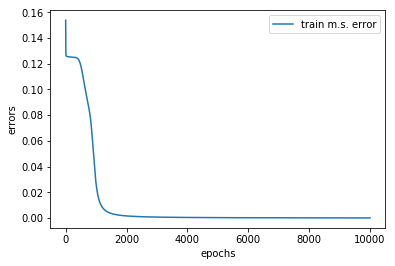

In [208]:
mlp_1 = MLP()
mlp_1.initialize(NI=2, NH=2, NO=1, activation_h=sigmoid, activation_o=sigmoid)
mlp_1.train(X, y, n_epochs=10000, batch_size=2, learning_rate=0.5)

The following are the predicitons by the trained network

In [209]:
[(x, mlp_1.predict(x)[0]) for x in X]

[([0, 0], 0.01592540968675135),
 ([0, 1], 0.9817587350068963),
 ([1, 0], 0.9817619028551392),
 ([1, 1], 0.01733271622466188)]

Epoch = 0 MSError= 0.7067508257204997
Epoch = 1 MSError= 0.6732560962749692
Epoch = 2 MSError= 0.6405108968352594
Epoch = 3 MSError= 0.6103641335639665
Epoch = 4 MSError= 0.5843225227973601
Epoch = 5 MSError= 0.5631842548298243
Epoch = 6 MSError= 0.5469491381364392
Epoch = 7 MSError= 0.5350170155015714
Epoch = 8 MSError= 0.5265097535003388
Epoch = 9 MSError= 0.5205408650552158
Epoch = 10 MSError= 0.5163614765316974
Epoch = 11 MSError= 0.5134018788017579
Epoch = 12 MSError= 0.5112559918163556
Epoch = 13 MSError= 0.509645946054486
Epoch = 14 MSError= 0.5083863138803649
Epoch = 15 MSError= 0.5073551383582543
Epoch = 16 MSError= 0.5064727665363281
Epoch = 17 MSError= 0.5056872327855985
Epoch = 18 MSError= 0.5049644921144499
Epoch = 19 MSError= 0.5042820216785521
Epoch = 20 MSError= 0.5036246782920446
Epoch = 21 MSError= 0.5029820350439338
Epoch = 22 MSError= 0.5023466752973165
Epoch = 23 MSError= 0.5017131016758336
Epoch = 24 MSError= 0.501077038438254
Epoch = 25 MSError= 0.500434985063512

Epoch = 666 MSError= 0.00491469178393724
Epoch = 667 MSError= 0.004900955471025125
Epoch = 668 MSError= 0.0048872933958375225
Epoch = 669 MSError= 0.004873704967022565
Epoch = 670 MSError= 0.004860189599437012
Epoch = 671 MSError= 0.0048467467140654585
Epoch = 672 MSError= 0.004833375737940826
Epoch = 673 MSError= 0.004820076104066024
Epoch = 674 MSError= 0.0048068472513368935
Epoch = 675 MSError= 0.00479368862446622
Epoch = 676 MSError= 0.004780599673909082
Epoch = 677 MSError= 0.004767579855789154
Epoch = 678 MSError= 0.0047546286318263225
Epoch = 679 MSError= 0.004741745469265225
Epoch = 680 MSError= 0.004728929840805019
Epoch = 681 MSError= 0.00471618122453019
Epoch = 682 MSError= 0.004703499103842281
Epoch = 683 MSError= 0.004690882967392835
Epoch = 684 MSError= 0.004678332309017176
Epoch = 685 MSError= 0.004665846627669395
Epoch = 686 MSError= 0.004653425427358042
Epoch = 687 MSError= 0.00464106821708303
Epoch = 688 MSError= 0.004628774510773299
Epoch = 689 MSError= 0.00461654382

Epoch = 1393 MSError= 0.0015804311352287433
Epoch = 1394 MSError= 0.0015789271540577053
Epoch = 1395 MSError= 0.001577425978719856
Epoch = 1396 MSError= 0.00157592760144333
Epoch = 1397 MSError= 0.0015744320144847651
Epoch = 1398 MSError= 0.0015729392101291987
Epoch = 1399 MSError= 0.0015714491806898948
Epoch = 1400 MSError= 0.001569961918508254
Epoch = 1401 MSError= 0.0015684774159536933
Epoch = 1402 MSError= 0.00156699566542345
Epoch = 1403 MSError= 0.0015655166593425461
Epoch = 1404 MSError= 0.0015640403901635933
Epoch = 1405 MSError= 0.0015625668503667072
Epoch = 1406 MSError= 0.0015610960324593712
Epoch = 1407 MSError= 0.0015596279289763085
Epoch = 1408 MSError= 0.0015581625324793532
Epoch = 1409 MSError= 0.001556699835557325
Epoch = 1410 MSError= 0.0015552398308259626
Epoch = 1411 MSError= 0.0015537825109277108
Epoch = 1412 MSError= 0.0015523278685316809
Epoch = 1413 MSError= 0.001550875896333466
Epoch = 1414 MSError= 0.001549426587055072
Epoch = 1415 MSError= 0.00154797993344477

Epoch = 2129 MSError= 0.0009252000189135556
Epoch = 2130 MSError= 0.0009246750253797136
Epoch = 2131 MSError= 0.0009241506184315775
Epoch = 2132 MSError= 0.0009236267970937336
Epoch = 2133 MSError= 0.0009231035603929468
Epoch = 2134 MSError= 0.0009225809073581072
Epoch = 2135 MSError= 0.0009220588370202479
Epoch = 2136 MSError= 0.0009215373484125553
Epoch = 2137 MSError= 0.0009210164405703128
Epoch = 2138 MSError= 0.0009204961125309473
Epoch = 2139 MSError= 0.0009199763633339999
Epoch = 2140 MSError= 0.0009194571920211132
Epoch = 2141 MSError= 0.0009189385976360485
Epoch = 2142 MSError= 0.0009184205792246493
Epoch = 2143 MSError= 0.0009179031358348709
Epoch = 2144 MSError= 0.0009173862665167367
Epoch = 2145 MSError= 0.0009168699703223692
Epoch = 2146 MSError= 0.0009163542463059597
Epoch = 2147 MSError= 0.0009158390935237675
Epoch = 2148 MSError= 0.0009153245110341273
Epoch = 2149 MSError= 0.0009148104978974193
Epoch = 2150 MSError= 0.0009142970531760829
Epoch = 2151 MSError= 0.00091378

Epoch = 2852 MSError= 0.0006549539745493501
Epoch = 2853 MSError= 0.0006546883111877508
Epoch = 2854 MSError= 0.0006544228604920987
Epoch = 2855 MSError= 0.0006541576222087353
Epoch = 2856 MSError= 0.0006538925960843827
Epoch = 2857 MSError= 0.0006536277818661811
Epoch = 2858 MSError= 0.0006533631793016689
Epoch = 2859 MSError= 0.0006530987881387734
Epoch = 2860 MSError= 0.0006528346081258326
Epoch = 2861 MSError= 0.0006525706390115697
Epoch = 2862 MSError= 0.0006523068805451228
Epoch = 2863 MSError= 0.0006520433324760013
Epoch = 2864 MSError= 0.0006517799945541344
Epoch = 2865 MSError= 0.0006515168665298293
Epoch = 2866 MSError= 0.0006512539481538001
Epoch = 2867 MSError= 0.0006509912391771413
Epoch = 2868 MSError= 0.0006507287393513473
Epoch = 2869 MSError= 0.0006504664484283047
Epoch = 2870 MSError= 0.0006502043661602828
Epoch = 2871 MSError= 0.0006499424922999569
Epoch = 2872 MSError= 0.000649680826600375
Epoch = 2873 MSError= 0.0006494193688149725
Epoch = 2874 MSError= 0.000649158

Epoch = 3568 MSError= 0.0005071261346691978
Epoch = 3569 MSError= 0.0005069658537517795
Epoch = 3570 MSError= 0.0005068056729543198
Epoch = 3571 MSError= 0.0005066455921835574
Epoch = 3572 MSError= 0.0005064856113463567
Epoch = 3573 MSError= 0.0005063257303496843
Epoch = 3574 MSError= 0.0005061659491006247
Epoch = 3575 MSError= 0.0005060062675063759
Epoch = 3576 MSError= 0.0005058466854742621
Epoch = 3577 MSError= 0.0005056872029117043
Epoch = 3578 MSError= 0.0005055278197262532
Epoch = 3579 MSError= 0.0005053685358255586
Epoch = 3580 MSError= 0.0005052093511173986
Epoch = 3581 MSError= 0.0005050502655096534
Epoch = 3582 MSError= 0.0005048912789103314
Epoch = 3583 MSError= 0.0005047323912275455
Epoch = 3584 MSError= 0.0005045736023695133
Epoch = 3585 MSError= 0.0005044149122445865
Epoch = 3586 MSError= 0.0005042563207612105
Epoch = 3587 MSError= 0.0005040978278279494
Epoch = 3588 MSError= 0.0005039394333534771
Epoch = 3589 MSError= 0.0005037811372465887
Epoch = 3590 MSError= 0.00050362

Epoch = 4301 MSError= 0.00041152752793211173
Epoch = 4302 MSError= 0.00041142148821771455
Epoch = 4303 MSError= 0.0004113155025622123
Epoch = 4304 MSError= 0.0004112095709244925
Epoch = 4305 MSError= 0.0004111036932634744
Epoch = 4306 MSError= 0.00041099786953812355
Epoch = 4307 MSError= 0.0004108920997074463
Epoch = 4308 MSError= 0.0004107863837304831
Epoch = 4309 MSError= 0.00041068072156633464
Epoch = 4310 MSError= 0.0004105751131741185
Epoch = 4311 MSError= 0.0004104695585130145
Epoch = 4312 MSError= 0.0004103640575422256
Epoch = 4313 MSError= 0.00041025861022101504
Epoch = 4314 MSError= 0.00041015321650866626
Epoch = 4315 MSError= 0.0004100478763645254
Epoch = 4316 MSError= 0.00040994258974796406
Epoch = 4317 MSError= 0.00040983735661839836
Epoch = 4318 MSError= 0.00040973217693528457
Epoch = 4319 MSError= 0.00040962705065812974
Epoch = 4320 MSError= 0.00040952197774646434
Epoch = 4321 MSError= 0.00040941695815987925
Epoch = 4322 MSError= 0.0004093119918579809
Epoch = 4323 MSError

Epoch = 5035 MSError= 0.00034595885246539043
Epoch = 5036 MSError= 0.00034588364422376945
Epoch = 5037 MSError= 0.0003458084683548942
Epoch = 5038 MSError= 0.00034573332483797345
Epoch = 5039 MSError= 0.00034565821365222546
Epoch = 5040 MSError= 0.0003455831347768846
Epoch = 5041 MSError= 0.0003455080881912075
Epoch = 5042 MSError= 0.0003454330738744615
Epoch = 5043 MSError= 0.00034535809180593664
Epoch = 5044 MSError= 0.0003452831419649456
Epoch = 5045 MSError= 0.0003452082243308062
Epoch = 5046 MSError= 0.0003451333388828618
Epoch = 5047 MSError= 0.0003450584856004728
Epoch = 5048 MSError= 0.00034498366446302094
Epoch = 5049 MSError= 0.0003449088754498895
Epoch = 5050 MSError= 0.0003448341185405022
Epoch = 5051 MSError= 0.00034475939371428777
Epoch = 5052 MSError= 0.00034468470095069093
Epoch = 5053 MSError= 0.00034461004022917684
Epoch = 5054 MSError= 0.0003445354115292292
Epoch = 5055 MSError= 0.00034446081483034723
Epoch = 5056 MSError= 0.00034438625011204427
Epoch = 5057 MSError=

Epoch = 5764 MSError= 0.00029856442144323515
Epoch = 5765 MSError= 0.00029850824972935586
Epoch = 5766 MSError= 0.0002984520989537201
Epoch = 5767 MSError= 0.00029839596910467386
Epoch = 5768 MSError= 0.0002983398601705738
Epoch = 5769 MSError= 0.0002982837721397778
Epoch = 5770 MSError= 0.0002982277050006637
Epoch = 5771 MSError= 0.0002981716587416066
Epoch = 5772 MSError= 0.0002981156333510027
Epoch = 5773 MSError= 0.000298059628817248
Epoch = 5774 MSError= 0.0002980036451287482
Epoch = 5775 MSError= 0.0002979476822739101
Epoch = 5776 MSError= 0.0002978917402411722
Epoch = 5777 MSError= 0.00029783581901896
Epoch = 5778 MSError= 0.00029777991859571287
Epoch = 5779 MSError= 0.00029772403895988076
Epoch = 5780 MSError= 0.0002976681800999216
Epoch = 5781 MSError= 0.0002976123420043051
Epoch = 5782 MSError= 0.0002975565246614994
Epoch = 5783 MSError= 0.00029750072805999307
Epoch = 5784 MSError= 0.0002974449521882792
Epoch = 5785 MSError= 0.0002973891970348554
Epoch = 5786 MSError= 0.00029

Epoch = 6496 MSError= 0.00026238017453743864
Epoch = 6497 MSError= 0.00026233669183762533
Epoch = 6498 MSError= 0.000262293223422337
Epoch = 6499 MSError= 0.00026224976928456074
Epoch = 6500 MSError= 0.00026220632941729256
Epoch = 6501 MSError= 0.0002621629038135347
Epoch = 6502 MSError= 0.00026211949246629073
Epoch = 6503 MSError= 0.0002620760953685736
Epoch = 6504 MSError= 0.0002620327125133966
Epoch = 6505 MSError= 0.0002619893438937768
Epoch = 6506 MSError= 0.000261945989502736
Epoch = 6507 MSError= 0.0002619026493333079
Epoch = 6508 MSError= 0.0002618593233785196
Epoch = 6509 MSError= 0.0002618160116314077
Epoch = 6510 MSError= 0.0002617727140850208
Epoch = 6511 MSError= 0.00026172943073239744
Epoch = 6512 MSError= 0.0002616861615665904
Epoch = 6513 MSError= 0.00026164290658065806
Epoch = 6514 MSError= 0.000261599665767656
Epoch = 6515 MSError= 0.00026155643912065095
Epoch = 6516 MSError= 0.00026151322663270815
Epoch = 6517 MSError= 0.00026147002829690836
Epoch = 6518 MSError= 0.0

Epoch = 7225 MSError= 0.00023406881970784664
Epoch = 7226 MSError= 0.00023403414665830748
Epoch = 7227 MSError= 0.00023399948379440708
Epoch = 7228 MSError= 0.00023396483111166243
Epoch = 7229 MSError= 0.00023393018860561429
Epoch = 7230 MSError= 0.0002338955562717973
Epoch = 7231 MSError= 0.00023386093410574752
Epoch = 7232 MSError= 0.00023382632210300537
Epoch = 7233 MSError= 0.0002337917202591167
Epoch = 7234 MSError= 0.0002337571285696228
Epoch = 7235 MSError= 0.00023372254703007733
Epoch = 7236 MSError= 0.00023368797563602775
Epoch = 7237 MSError= 0.00023365341438302646
Epoch = 7238 MSError= 0.00023361886326663407
Epoch = 7239 MSError= 0.00023358432228240536
Epoch = 7240 MSError= 0.00023354979142590793
Epoch = 7241 MSError= 0.00023351527069269553
Epoch = 7242 MSError= 0.00023348076007834357
Epoch = 7243 MSError= 0.00023344625957841535
Epoch = 7244 MSError= 0.00023341176918848457
Epoch = 7245 MSError= 0.00023337728890412875
Epoch = 7246 MSError= 0.00023334281872092004
Epoch = 7247 

Epoch = 7949 MSError= 0.0002113766332688789
Epoch = 7950 MSError= 0.00021134830990703882
Epoch = 7951 MSError= 0.0002113199940741714
Epoch = 7952 MSError= 0.00021129168576728734
Epoch = 7953 MSError= 0.00021126338498339662
Epoch = 7954 MSError= 0.00021123509171950774
Epoch = 7955 MSError= 0.00021120680597263956
Epoch = 7956 MSError= 0.0002111785277398064
Epoch = 7957 MSError= 0.000211150257018029
Epoch = 7958 MSError= 0.0002111219938043217
Epoch = 7959 MSError= 0.00021109373809570837
Epoch = 7960 MSError= 0.00021106548988921353
Epoch = 7961 MSError= 0.00021103724918185136
Epoch = 7962 MSError= 0.0002110090159706571
Epoch = 7963 MSError= 0.00021098079025265662
Epoch = 7964 MSError= 0.0002109525720248755
Epoch = 7965 MSError= 0.000210924361284342
Epoch = 7966 MSError= 0.0002108961580280926
Epoch = 7967 MSError= 0.00021086796225315782
Epoch = 7968 MSError= 0.00021083977395657645
Epoch = 7969 MSError= 0.0002108115931353769
Epoch = 7970 MSError= 0.0002107834197866064
Epoch = 7971 MSError= 0

Epoch = 8680 MSError= 0.0001925042286270008
Epoch = 8681 MSError= 0.00019248070248790313
Epoch = 8682 MSError= 0.00019245718205439176
Epoch = 8683 MSError= 0.00019243366732439157
Epoch = 8684 MSError= 0.0001924101582958413
Epoch = 8685 MSError= 0.00019238665496667384
Epoch = 8686 MSError= 0.00019236315733482497
Epoch = 8687 MSError= 0.00019233966539823025
Epoch = 8688 MSError= 0.00019231617915482698
Epoch = 8689 MSError= 0.00019229269860255297
Epoch = 8690 MSError= 0.0001922692237393482
Epoch = 8691 MSError= 0.00019224575456315047
Epoch = 8692 MSError= 0.00019222229107190706
Epoch = 8693 MSError= 0.00019219883326355088
Epoch = 8694 MSError= 0.00019217538113603196
Epoch = 8695 MSError= 0.00019215193468729333
Epoch = 8696 MSError= 0.00019212849391527984
Epoch = 8697 MSError= 0.0001921050588179371
Epoch = 8698 MSError= 0.00019208162939321098
Epoch = 8699 MSError= 0.00019205820563905358
Epoch = 8700 MSError= 0.00019203478755340958
Epoch = 8701 MSError= 0.00019201137513422838
Epoch = 8702 M

Epoch = 9423 MSError= 0.00017646781064554248
Epoch = 9424 MSError= 0.0001764480148081891
Epoch = 9425 MSError= 0.00017642822337884736
Epoch = 9426 MSError= 0.00017640843635604336
Epoch = 9427 MSError= 0.00017638865373831045
Epoch = 9428 MSError= 0.0001763688755241902
Epoch = 9429 MSError= 0.0001763491017122098
Epoch = 9430 MSError= 0.00017632933230090874
Epoch = 9431 MSError= 0.00017630956728882232
Epoch = 9432 MSError= 0.00017628980667448287
Epoch = 9433 MSError= 0.00017627005045643712
Epoch = 9434 MSError= 0.0001762502986332177
Epoch = 9435 MSError= 0.0001762305512033658
Epoch = 9436 MSError= 0.00017621080816541585
Epoch = 9437 MSError= 0.00017619106951791445
Epoch = 9438 MSError= 0.0001761713352593972
Epoch = 9439 MSError= 0.0001761516053884097
Epoch = 9440 MSError= 0.00017613187990349273
Epoch = 9441 MSError= 0.00017611215880318634
Epoch = 9442 MSError= 0.00017609244208603668
Epoch = 9443 MSError= 0.00017607272975058623
Epoch = 9444 MSError= 0.00017605302179538087
Epoch = 9445 MSEr

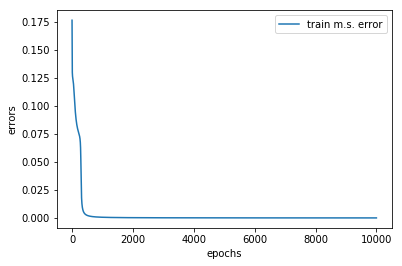

In [210]:
mlp_2 = MLP()
mlp_2.initialize(NI=2, NH=2, NO=1, activation_h=tanh, activation_o=sigmoid)
mlp_2.train(X, y, n_epochs=10000, batch_size=2, learning_rate=0.5)

In [211]:
[(x, mlp_2.predict(x)[0]) for x in X]

[([0, 0], 0.007761084221229933),
 ([0, 1], 0.9896472061317291),
 ([1, 0], 0.9895081981485183),
 ([1, 1], 0.007345488873160779)]

Epoch = 0 MSError= 3.042976352444715
Epoch = 1 MSError= 0.577621595858983
Epoch = 2 MSError= 0.5392822469287509
Epoch = 3 MSError= 0.5183597670244684
Epoch = 4 MSError= 0.5109239293793131
Epoch = 5 MSError= 0.5024273315467718
Epoch = 6 MSError= 0.49741955927044046
Epoch = 7 MSError= 0.4926065284970357
Epoch = 8 MSError= 0.4886575010396002
Epoch = 9 MSError= 0.4849062385863309
Epoch = 10 MSError= 0.4813985429163137
Epoch = 11 MSError= 0.4779909024481227
Epoch = 12 MSError= 0.4746774510523184
Epoch = 13 MSError= 0.4714310105434527
Epoch = 14 MSError= 0.4682561116191757
Epoch = 15 MSError= 0.4651565743848381
Epoch = 16 MSError= 0.46214401747644307
Epoch = 17 MSError= 0.4592297080438653
Epoch = 18 MSError= 0.4564255659787377
Epoch = 19 MSError= 0.4537416504773899
Epoch = 20 MSError= 0.45118610360466493
Epoch = 21 MSError= 0.4487643952272606
Epoch = 22 MSError= 0.44647939767331224
Epoch = 23 MSError= 0.44433138850711373
Epoch = 24 MSError= 0.44231837764181486
Epoch = 25 MSError= 0.440436447

Epoch = 732 MSError= 0.0004417503426091499
Epoch = 733 MSError= 0.0004156161995377192
Epoch = 734 MSError= 0.0004227851431079777
Epoch = 735 MSError= 0.0004008285034855267
Epoch = 736 MSError= 0.0004099173733142068
Epoch = 737 MSError= 0.0003916596049120354
Epoch = 738 MSError= 0.0004028499747129981
Epoch = 739 MSError= 0.0003879888400930456
Epoch = 740 MSError= 0.0004016783679523552
Epoch = 741 MSError= 0.00039012802994869674
Epoch = 742 MSError= 0.00040700201262719015
Epoch = 743 MSError= 0.00039895228092398476
Epoch = 744 MSError= 0.00042009258844284507
Epoch = 745 MSError= 0.000416099448747757
Epoch = 746 MSError= 0.0004431524441466117
Epoch = 747 MSError= 0.00044427468719802205
Epoch = 748 MSError= 0.0004797081832879856
Epoch = 749 MSError= 0.00048770626638456786
Epoch = 750 MSError= 0.0005351951582592548
Epoch = 751 MSError= 0.0005528032013667281
Epoch = 752 MSError= 0.0006177885543651027
Epoch = 753 MSError= 0.0006490460630728255
Epoch = 754 MSError= 0.0007394963548814745
Epoch 

Epoch = 1480 MSError= 0.0004914077551481327
Epoch = 1481 MSError= 0.0005401217710351779
Epoch = 1482 MSError= 0.0005631825804467104
Epoch = 1483 MSError= 0.00062099104869562
Epoch = 1484 MSError= 0.0006486497317466009
Epoch = 1485 MSError= 0.0007167242927384626
Epoch = 1486 MSError= 0.0007488924054604413
Epoch = 1487 MSError= 0.0008280463977783411
Epoch = 1488 MSError= 0.0008640111457485703
Epoch = 1489 MSError= 0.0009543372754448184
Epoch = 1490 MSError= 0.0009924707590771098
Epoch = 1491 MSError= 0.0010928765362433702
Epoch = 1492 MSError= 0.0011303646271081111
Epoch = 1493 MSError= 0.001238075880790777
Epoch = 1494 MSError= 0.00127077994598535
Epoch = 1495 MSError= 0.0013809642735965358
Epoch = 1496 MSError= 0.001403565982726348
Epoch = 1497 MSError= 0.0015093024807873924
Epoch = 1498 MSError= 0.001515862453958902
Epoch = 1499 MSError= 0.0016086891022551073
Epoch = 1500 MSError= 0.001593636102733421
Epoch = 1501 MSError= 0.0016647747935949636
Epoch = 1502 MSError= 0.0016241452438021

Epoch = 2244 MSError= 0.0003651476694576867
Epoch = 2245 MSError= 0.00037820876962897556
Epoch = 2246 MSError= 0.0003738734998122887
Epoch = 2247 MSError= 0.0003838630057951583
Epoch = 2248 MSError= 0.000376341265271115
Epoch = 2249 MSError= 0.0003831164977138537
Epoch = 2250 MSError= 0.00037260285376389767
Epoch = 2251 MSError= 0.0003761711824535045
Epoch = 2252 MSError= 0.00036298094664760584
Epoch = 2253 MSError= 0.00036349619597187023
Epoch = 2254 MSError= 0.00034804770862800554
Epoch = 2255 MSError= 0.00034579636378437594
Epoch = 2256 MSError= 0.0003285868674273889
Epoch = 2257 MSError= 0.00032396473580987537
Epoch = 2258 MSError= 0.00030554161083067054
Epoch = 2259 MSError= 0.0002990230542438092
Epoch = 2260 MSError= 0.000279952894862238
Epoch = 2261 MSError= 0.00027205582463762934
Epoch = 2262 MSError= 0.0002528941164535195
Epoch = 2263 MSError= 0.00024414443310386355
Epoch = 2264 MSError= 0.00022540843213817048
Epoch = 2265 MSError= 0.00021630744305605617
Epoch = 2266 MSError= 

Epoch = 3011 MSError= 5.812951854486929e-05
Epoch = 3012 MSError= 5.406894997319714e-05
Epoch = 3013 MSError= 5.2789845894679185e-05
Epoch = 3014 MSError= 5.152682094568163e-05
Epoch = 3015 MSError= 5.2104572460018904e-05
Epoch = 3016 MSError= 5.3183916300008236e-05
Epoch = 3017 MSError= 5.504918666079912e-05
Epoch = 3018 MSError= 5.7798077068694076e-05
Epoch = 3019 MSError= 6.0262117198856604e-05
Epoch = 3020 MSError= 6.392149825016285e-05
Epoch = 3021 MSError= 6.630665207441524e-05
Epoch = 3022 MSError= 7.015077929768496e-05
Epoch = 3023 MSError= 7.189354302824834e-05
Epoch = 3024 MSError= 7.532304741471976e-05
Epoch = 3025 MSError= 7.604001568755267e-05
Epoch = 3026 MSError= 7.864008887884959e-05
Epoch = 3027 MSError= 7.815480287169421e-05
Epoch = 3028 MSError= 7.971648353879061e-05
Epoch = 3029 MSError= 7.805135301397042e-05
Epoch = 3030 MSError= 7.855958655319769e-05
Epoch = 3031 MSError= 7.590119742620397e-05
Epoch = 3032 MSError= 7.549759495360595e-05
Epoch = 3033 MSError= 7.214

Epoch = 3781 MSError= 4.0262610505079306e-05
Epoch = 3782 MSError= 4.101506809053038e-05
Epoch = 3783 MSError= 4.102852312812688e-05
Epoch = 3784 MSError= 4.185111606507306e-05
Epoch = 3785 MSError= 4.1875231007710866e-05
Epoch = 3786 MSError= 4.277489813156769e-05
Epoch = 3787 MSError= 4.281604589062256e-05
Epoch = 3788 MSError= 4.3801828814937284e-05
Epoch = 3789 MSError= 4.386792985867299e-05
Epoch = 3790 MSError= 4.4951316227072154e-05
Epoch = 3791 MSError= 4.505212381098668e-05
Epoch = 3792 MSError= 4.624747824470113e-05
Epoch = 3793 MSError= 4.639494492963998e-05
Epoch = 3794 MSError= 4.772005104599672e-05
Epoch = 3795 MSError= 4.792879637403388e-05
Epoch = 3796 MSError= 4.9405538276842545e-05
Epoch = 3797 MSError= 4.969344136925654e-05
Epoch = 3798 MSError= 5.1348659281626284e-05
Epoch = 3799 MSError= 5.1737604747998745e-05
Epoch = 3800 MSError= 5.360416712404824e-05
Epoch = 3801 MSError= 5.4120977938507155e-05
Epoch = 3802 MSError= 5.623912153238553e-05
Epoch = 3803 MSError= 5.

Epoch = 4529 MSError= 0.00015257348864020588
Epoch = 4530 MSError= 0.00013190909453588543
Epoch = 4531 MSError= 0.00011571560538752487
Epoch = 4532 MSError= 9.76427927910886e-05
Epoch = 4533 MSError= 8.397779891183442e-05
Epoch = 4534 MSError= 6.961078992723444e-05
Epoch = 4535 MSError= 5.94682131028369e-05
Epoch = 4536 MSError= 4.950617471531758e-05
Epoch = 4537 MSError= 4.339921067316665e-05
Epoch = 4538 MSError= 3.810911288306076e-05
Epoch = 4539 MSError= 3.607805156037451e-05
Epoch = 4540 MSError= 3.5317918265987704e-05
Epoch = 4541 MSError= 3.6986298647513276e-05
Epoch = 4542 MSError= 4.0259673663373114e-05
Epoch = 4543 MSError= 4.492342682080589e-05
Epoch = 4544 MSError= 5.145558479066134e-05
Epoch = 4545 MSError= 5.8190151163572094e-05
Epoch = 4546 MSError= 6.701744469659404e-05
Epoch = 4547 MSError= 7.478998878942507e-05
Epoch = 4548 MSError= 8.485491472436514e-05
Epoch = 4549 MSError= 9.26314760687647e-05
Epoch = 4550 MSError= 0.00010287698883138516
Epoch = 4551 MSError= 0.000

Epoch = 5284 MSError= 0.00010582090734007513
Epoch = 5285 MSError= 0.0001130890595600991
Epoch = 5286 MSError= 0.00011735352159266617
Epoch = 5287 MSError= 0.00012480141653785728
Epoch = 5288 MSError= 0.0001288900901341123
Epoch = 5289 MSError= 0.0001364221182121595
Epoch = 5290 MSError= 0.0001402437846731269
Epoch = 5291 MSError= 0.00014775694040929463
Epoch = 5292 MSError= 0.00015121763803854364
Epoch = 5293 MSError= 0.00015860126881574966
Epoch = 5294 MSError= 0.00016160493041146343
Epoch = 5295 MSError= 0.0001687412006607814
Epoch = 5296 MSError= 0.00017119097571850598
Epoch = 5297 MSError= 0.00017795622162514397
Epoch = 5298 MSError= 0.00017975656740805033
Epoch = 5299 MSError= 0.000186023668995256
Epoch = 5300 MSError= 0.00018708323089925208
Epoch = 5301 MSError= 0.00019272505400403804
Epoch = 5302 MSError= 0.0001929602749034581
Epoch = 5303 MSError= 0.00019785413553276236
Epoch = 5304 MSError= 0.00019719344087440943
Epoch = 5305 MSError= 0.00020122642418296435
Epoch = 5306 MSErr

Epoch = 6039 MSError= 0.00018384744853821368
Epoch = 6040 MSError= 0.00018405495656694388
Epoch = 6041 MSError= 0.00017943015989465455
Epoch = 6042 MSError= 0.0001784961106988783
Epoch = 6043 MSError= 0.00017292767892698944
Epoch = 6044 MSError= 0.00017089709678973274
Epoch = 6045 MSError= 0.00016448928952171403
Epoch = 6046 MSError= 0.00016144785828512385
Epoch = 6047 MSError= 0.00015433651107986466
Epoch = 6048 MSError= 0.00015040804386608228
Epoch = 6049 MSError= 0.0001427559822609221
Epoch = 6050 MSError= 0.0001380973689035255
Epoch = 6051 MSError= 0.00013008812046634148
Epoch = 6052 MSError= 0.00012488209130343423
Epoch = 6053 MSError= 0.00011671234766915656
Epoch = 6054 MSError= 0.00011115862604864483
Epoch = 6055 MSError= 0.00010303002975877422
Epoch = 6056 MSError= 9.733560642708941e-05
Epoch = 6057 MSError= 8.944649003191247e-05
Epoch = 6058 MSError= 8.381581830739713e-05
Epoch = 6059 MSError= 7.635350115976202e-05
Epoch = 6060 MSError= 7.097937735166403e-05
Epoch = 6061 MSErr

Epoch = 6792 MSError= 2.0536885094341847e-05
Epoch = 6793 MSError= 1.999531392160592e-05
Epoch = 6794 MSError= 1.9619815546172885e-05
Epoch = 6795 MSError= 1.9849801547774086e-05
Epoch = 6796 MSError= 2.0409159096793435e-05
Epoch = 6797 MSError= 2.137859124671257e-05
Epoch = 6798 MSError= 2.283934595630325e-05
Epoch = 6799 MSError= 2.44992778750571e-05
Epoch = 6800 MSError= 2.6814432784966082e-05
Epoch = 6801 MSError= 2.9102165827502426e-05
Epoch = 6802 MSError= 3.2213531578358065e-05
Epoch = 6803 MSError= 3.505541977188236e-05
Epoch = 6804 MSError= 3.889557417262766e-05
Epoch = 6805 MSError= 4.220941872389601e-05
Epoch = 6806 MSError= 4.670320118296055e-05
Epoch = 6807 MSError= 5.040017196598699e-05
Epoch = 6808 MSError= 5.5465692656009865e-05
Epoch = 6809 MSError= 5.945177861977073e-05
Epoch = 6810 MSError= 6.500097734812331e-05
Epoch = 6811 MSError= 6.917802405115772e-05
Epoch = 6812 MSError= 7.511686347516023e-05
Epoch = 6813 MSError= 7.938330214191488e-05
Epoch = 6814 MSError= 8.5

Epoch = 7539 MSError= 0.00013951121718706509
Epoch = 7540 MSError= 0.00014008298373199195
Epoch = 7541 MSError= 0.00014333137107554975
Epoch = 7542 MSError= 0.0001431030382896652
Epoch = 7543 MSError= 0.00014555951225940093
Epoch = 7544 MSError= 0.00014449321149702122
Epoch = 7545 MSError= 0.00014609269435881807
Epoch = 7546 MSError= 0.00014417311746533584
Epoch = 7547 MSError= 0.0001448746780575678
Epoch = 7548 MSError= 0.00014211160625411142
Epoch = 7549 MSError= 0.00014190206298485383
Epoch = 7550 MSError= 0.00013833193737870672
Epoch = 7551 MSError= 0.00013722831682141
Epoch = 7552 MSError= 0.00013291459569682778
Epoch = 7553 MSError= 0.00013096510287993778
Epoch = 7554 MSError= 0.0001259972401405525
Epoch = 7555 MSError= 0.00012328051099413952
Epoch = 7556 MSError= 0.0001177715081893466
Epoch = 7557 MSError= 0.00011439406829074727
Epoch = 7558 MSError= 0.00010847668526062438
Epoch = 7559 MSError= 0.00010456871271224236
Epoch = 7560 MSError= 9.839055140214554e-05
Epoch = 7561 MSErr

Epoch = 8273 MSError= 2.1743009676976842e-05
Epoch = 8274 MSError= 2.0048326309356646e-05
Epoch = 8275 MSError= 1.8295182371262562e-05
Epoch = 8276 MSError= 1.727877177758536e-05
Epoch = 8277 MSError= 1.6341112224241566e-05
Epoch = 8278 MSError= 1.6015595301484738e-05
Epoch = 8279 MSError= 1.5898218260092887e-05
Epoch = 8280 MSError= 1.625514911073651e-05
Epoch = 8281 MSError= 1.6945025247593697e-05
Epoch = 8282 MSError= 1.7957002891628104e-05
Epoch = 8283 MSError= 1.9425146743338415e-05
Epoch = 8284 MSError= 2.1048202758914692e-05
Epoch = 8285 MSError= 2.3251601660314914e-05
Epoch = 8286 MSError= 2.542765373391709e-05
Epoch = 8287 MSError= 2.8311100944807987e-05
Epoch = 8288 MSError= 3.097030859539136e-05
Epoch = 8289 MSError= 3.4468032121255386e-05
Epoch = 8290 MSError= 3.753094510908588e-05
Epoch = 8291 MSError= 4.1567973344441135e-05
Epoch = 8292 MSError= 4.494741946493044e-05
Epoch = 8293 MSError= 4.94406750682808e-05
Epoch = 8294 MSError= 5.304338724999809e-05
Epoch = 8295 MSErro

Epoch = 9000 MSError= 0.00012007106864238658
Epoch = 9001 MSError= 0.00011821323320363765
Epoch = 9002 MSError= 0.00011824133093556836
Epoch = 9003 MSError= 0.0001156519503460567
Epoch = 9004 MSError= 0.00011489071592273504
Epoch = 9005 MSError= 0.00011161761250799945
Epoch = 9006 MSError= 0.0001101028625590984
Epoch = 9007 MSError= 0.00010621765009843212
Epoch = 9008 MSError= 0.000104012449234657
Epoch = 9009 MSError= 9.960867711794841e-05
Epoch = 9010 MSError= 9.680145967649271e-05
Epoch = 9011 MSError= 9.19915890878897e-05
Epoch = 9012 MSError= 8.869281721304463e-05
Epoch = 9013 MSError= 8.360417535739932e-05
Epoch = 9014 MSError= 7.994171441788706e-05
Epoch = 9015 MSError= 7.471166757321202e-05
Epoch = 9016 MSError= 7.082518309066288e-05
Epoch = 9017 MSError= 6.559583933684663e-05
Epoch = 9018 MSError= 6.16306093115755e-05
Epoch = 9019 MSError= 5.6543398137791416e-05
Epoch = 9020 MSError= 5.264397916476612e-05
Epoch = 9021 MSError= 4.7834453983295336e-05
Epoch = 9022 MSError= 4.413

Epoch = 9717 MSError= 5.458195784070142e-05
Epoch = 9718 MSError= 5.914739700515779e-05
Epoch = 9719 MSError= 6.257185132047305e-05
Epoch = 9720 MSError= 6.723900514232016e-05
Epoch = 9721 MSError= 7.055265763209865e-05
Epoch = 9722 MSError= 7.520998049891287e-05
Epoch = 9723 MSError= 7.83071050640845e-05
Epoch = 9724 MSError= 8.28408392292231e-05
Epoch = 9725 MSError= 8.56185785716545e-05
Epoch = 9726 MSError= 8.991501346037612e-05
Epoch = 9727 MSError= 9.227589445313182e-05
Epoch = 9728 MSError= 9.622407345231143e-05
Epoch = 9729 MSError= 9.807876817654454e-05
Epoch = 9730 MSError= 0.00010157364616800236
Epoch = 9731 MSError= 0.00010284393142355789
Epoch = 9732 MSError= 0.00010578991914761117
Epoch = 9733 MSError= 0.00010641173009658946
Epoch = 9734 MSError= 0.00010872648687302722
Epoch = 9735 MSError= 0.00010865290500146254
Epoch = 9736 MSError= 0.00011027116826915561
Epoch = 9737 MSError= 0.00010947513831728169
Epoch = 9738 MSError= 0.00011035231761532836
Epoch = 9739 MSError= 0.00

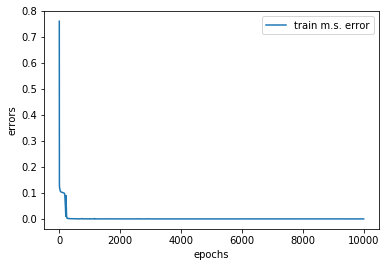

In [216]:
mlp_3 = MLP()
mlp_3.initialize(NI=2, NH=2, NO=1, activation_h=tanh, activation_o=tanh)
mlp_3.train(X, y, n_epochs=10000, batch_size=2, learning_rate=0.5)

In [217]:
[(x, mlp_3.predict(x)[0]) for x in X]

[([0, 0], 0.003348898311574567),
 ([0, 1], 0.9964907897066432),
 ([1, 0], 0.9964767756293256),
 ([1, 1], -0.005368226707070629)]

Epoch = 0 MSError= 2.1745857372082646
Epoch = 1 MSError= 1.1429203751180346
Epoch = 2 MSError= 0.8457726328958275
Epoch = 3 MSError= 0.7544666340940168
Epoch = 4 MSError= 0.7208956903066216
Epoch = 5 MSError= 0.7034284348839663
Epoch = 6 MSError= 0.6905252353688054
Epoch = 7 MSError= 0.6791271539042398
Epoch = 8 MSError= 0.6685019626171299
Epoch = 9 MSError= 0.6585077016601406
Epoch = 10 MSError= 0.6491225716987077
Epoch = 11 MSError= 0.6403314743975262
Epoch = 12 MSError= 0.6321073489679421
Epoch = 13 MSError= 0.6244139687992041
Epoch = 14 MSError= 0.6172111881172108
Epoch = 15 MSError= 0.6104586969927508
Epoch = 16 MSError= 0.6041181195383765
Epoch = 17 MSError= 0.5981539788945951
Epoch = 18 MSError= 0.5925340018189102
Epoch = 19 MSError= 0.5872290750163376
Epoch = 20 MSError= 0.5822130365457805
Epoch = 21 MSError= 0.5774624030153733
Epoch = 22 MSError= 0.5729560848508761
Epoch = 23 MSError= 0.5686751149075814
Epoch = 24 MSError= 0.5646024011676303
Epoch = 25 MSError= 0.5607225067388

Epoch = 763 MSError= 0.3064997330069631
Epoch = 764 MSError= 0.30647541202889184
Epoch = 765 MSError= 0.30645116811402473
Epoch = 766 MSError= 0.306427000901378
Epoch = 767 MSError= 0.3064029100321679
Epoch = 768 MSError= 0.306378895149793
Epoch = 769 MSError= 0.30635495589981854
Epoch = 770 MSError= 0.3063310919299615
Epoch = 771 MSError= 0.3063073028900722
Epoch = 772 MSError= 0.3062835884321206
Epoch = 773 MSError= 0.30625994821017927
Epoch = 774 MSError= 0.30623638188040947
Epoch = 775 MSError= 0.306212889101044
Epoch = 776 MSError= 0.3061894695323728
Epoch = 777 MSError= 0.30616612283672795
Epoch = 778 MSError= 0.3061428486784682
Epoch = 779 MSError= 0.3061196467239642
Epoch = 780 MSError= 0.3060965166415842
Epoch = 781 MSError= 0.30607345810167913
Epoch = 782 MSError= 0.3060504707765679
Epoch = 783 MSError= 0.3060275543405231
Epoch = 784 MSError= 0.306004708469757
Epoch = 785 MSError= 0.3059819328424075
Epoch = 786 MSError= 0.30595922713852364
Epoch = 787 MSError= 0.3059365910400

Epoch = 1549 MSError= 0.297977246444663
Epoch = 1550 MSError= 0.2979723438951484
Epoch = 1551 MSError= 0.29796744783374307
Epoch = 1552 MSError= 0.2979625582458689
Epoch = 1553 MSError= 0.2979576751169891
Epoch = 1554 MSError= 0.29795279843260625
Epoch = 1555 MSError= 0.297947928178265
Epoch = 1556 MSError= 0.2979430643395487
Epoch = 1557 MSError= 0.29793820690208084
Epoch = 1558 MSError= 0.29793335585152625
Epoch = 1559 MSError= 0.2979285111735881
Epoch = 1560 MSError= 0.2979236728540098
Epoch = 1561 MSError= 0.2979188408785737
Epoch = 1562 MSError= 0.2979140152331028
Epoch = 1563 MSError= 0.2979091959034582
Epoch = 1564 MSError= 0.2979043828755402
Epoch = 1565 MSError= 0.2978995761352884
Epoch = 1566 MSError= 0.29789477566868106
Epoch = 1567 MSError= 0.29788998146173506
Epoch = 1568 MSError= 0.29788519350050574
Epoch = 1569 MSError= 0.2978804117710875
Epoch = 1570 MSError= 0.29787563625961155
Epoch = 1571 MSError= 0.29787086695224896
Epoch = 1572 MSError= 0.29786610383520734
Epoch = 

Epoch = 2343 MSError= 0.29533998768181385
Epoch = 2344 MSError= 0.2953375928177261
Epoch = 2345 MSError= 0.2953351991477165
Epoch = 2346 MSError= 0.2953328066686456
Epoch = 2347 MSError= 0.2953304153773766
Epoch = 2348 MSError= 0.29532802527077506
Epoch = 2349 MSError= 0.29532563634571035
Epoch = 2350 MSError= 0.2953232485990537
Epoch = 2351 MSError= 0.2953208620276795
Epoch = 2352 MSError= 0.2953184766284652
Epoch = 2353 MSError= 0.29531609239829115
Epoch = 2354 MSError= 0.2953137093340393
Epoch = 2355 MSError= 0.2953113274325957
Epoch = 2356 MSError= 0.2953089466908486
Epoch = 2357 MSError= 0.2953065671056888
Epoch = 2358 MSError= 0.29530418867401026
Epoch = 2359 MSError= 0.29530181139270906
Epoch = 2360 MSError= 0.29529943525868474
Epoch = 2361 MSError= 0.29529706026883884
Epoch = 2362 MSError= 0.29529468642007584
Epoch = 2363 MSError= 0.2952923137093026
Epoch = 2364 MSError= 0.29528994213342896
Epoch = 2365 MSError= 0.2952875716893674
Epoch = 2366 MSError= 0.2952852023740331
Epoch 

Epoch = 3145 MSError= 0.2935476801489908
Epoch = 3146 MSError= 0.29354525406661836
Epoch = 3147 MSError= 0.2935428263911401
Epoch = 3148 MSError= 0.2935403971166549
Epoch = 3149 MSError= 0.29353796623724726
Epoch = 3150 MSError= 0.29353553374698643
Epoch = 3151 MSError= 0.2935330996399262
Epoch = 3152 MSError= 0.29353066391010596
Epoch = 3153 MSError= 0.29352822655154953
Epoch = 3154 MSError= 0.2935257875582651
Epoch = 3155 MSError= 0.2935233469242463
Epoch = 3156 MSError= 0.2935209046434711
Epoch = 3157 MSError= 0.29351846070990123
Epoch = 3158 MSError= 0.2935160151174844
Epoch = 3159 MSError= 0.2935135678601514
Epoch = 3160 MSError= 0.29351111893181836
Epoch = 3161 MSError= 0.29350866832638467
Epoch = 3162 MSError= 0.2935062160377351
Epoch = 3163 MSError= 0.29350376205973794
Epoch = 3164 MSError= 0.2935013063862453
Epoch = 3165 MSError= 0.29349884901109397
Epoch = 3166 MSError= 0.29349638992810456
Epoch = 3167 MSError= 0.2934939291310814
Epoch = 3168 MSError= 0.29349146661381237
Epoc

Epoch = 3935 MSError= 0.2900415365030158
Epoch = 3936 MSError= 0.29003177769801525
Epoch = 3937 MSError= 0.2900219852327234
Epoch = 3938 MSError= 0.29001215892155985
Epoch = 3939 MSError= 0.2900022985776112
Epoch = 3940 MSError= 0.2899924040126185
Epoch = 3941 MSError= 0.28998247503696506
Epoch = 3942 MSError= 0.2899725114596654
Epoch = 3943 MSError= 0.28996251308835086
Epoch = 3944 MSError= 0.2899524797292593
Epoch = 3945 MSError= 0.2899424111872212
Epoch = 3946 MSError= 0.2899323072656477
Epoch = 3947 MSError= 0.289922167766517
Epoch = 3948 MSError= 0.2899119924903619
Epoch = 3949 MSError= 0.289901781236256
Epoch = 3950 MSError= 0.2898915338018013
Epoch = 3951 MSError= 0.2898812499831148
Epoch = 3952 MSError= 0.28987092957481364
Epoch = 3953 MSError= 0.2898605723700022
Epoch = 3954 MSError= 0.28985017816025926
Epoch = 3955 MSError= 0.28983974673562163
Epoch = 3956 MSError= 0.2898292778845719
Epoch = 3957 MSError= 0.28981877139402423
Epoch = 3958 MSError= 0.2898082270493074
Epoch = 39

Epoch = 4726 MSError= 2.828147757540505e-06
Epoch = 4727 MSError= 2.6940245255566462e-06
Epoch = 4728 MSError= 2.566261261849651e-06
Epoch = 4729 MSError= 2.444556435877127e-06
Epoch = 4730 MSError= 2.328622809292845e-06
Epoch = 4731 MSError= 2.2181867587617742e-06
Epoch = 4732 MSError= 2.1129876308404042e-06
Epoch = 4733 MSError= 2.0127771274091984e-06
Epoch = 4734 MSError= 1.917318720212492e-06
Epoch = 4735 MSError= 1.8263870931276242e-06
Epoch = 4736 MSError= 1.7397676108485172e-06
Epoch = 4737 MSError= 1.6572558127356587e-06
Epoch = 4738 MSError= 1.5786569306454171e-06
Epoch = 4739 MSError= 1.503785429587035e-06
Epoch = 4740 MSError= 1.4324645701559962e-06
Epoch = 4741 MSError= 1.3645259916781237e-06
Epoch = 4742 MSError= 1.2998093151152162e-06
Epoch = 4743 MSError= 1.2381617647732675e-06
Epoch = 4744 MSError= 1.1794378079403236e-06
Epoch = 4745 MSError= 1.1234988115882078e-06
Epoch = 4746 MSError= 1.0702127153489587e-06
Epoch = 4747 MSError= 1.0194537199759434e-06
Epoch = 4748 MSE

Epoch = 5527 MSError= 3.514760860793643e-23
Epoch = 5528 MSError= 3.347960808871267e-23
Epoch = 5529 MSError= 3.1893566137651377e-23
Epoch = 5530 MSError= 3.0376760628533706e-23
Epoch = 5531 MSError= 2.893954534841473e-23
Epoch = 5532 MSError= 2.7565473909438254e-23
Epoch = 5533 MSError= 2.6256723382813406e-23
Epoch = 5534 MSError= 2.5011269415871923e-23
Epoch = 5535 MSError= 2.3824936875991262e-23
Epoch = 5536 MSError= 2.2696827940853668e-23
Epoch = 5537 MSError= 2.1618948583705494e-23
Epoch = 5538 MSError= 2.0592672901636024e-23
Epoch = 5539 MSError= 1.961623766726257e-23
Epoch = 5540 MSError= 1.8685540785389058e-23
Epoch = 5541 MSError= 1.7797432180346542e-23
Epoch = 5542 MSError= 1.695472161444205e-23
Epoch = 5543 MSError= 1.6150500539690496e-23
Epoch = 5544 MSError= 1.5384672443890505e-23
Epoch = 5545 MSError= 1.4654432002077645e-23
Epoch = 5546 MSError= 1.3959046713760586e-23
Epoch = 5547 MSError= 1.329811407498839e-23
Epoch = 5548 MSError= 1.2668413887753215e-23
Epoch = 5549 MSE

Epoch = 6304 MSError= 5.8733159584033145e-30
Epoch = 6305 MSError= 5.8733159584033145e-30
Epoch = 6306 MSError= 5.8733159584033145e-30
Epoch = 6307 MSError= 5.8733159584033145e-30
Epoch = 6308 MSError= 5.8733159584033145e-30
Epoch = 6309 MSError= 5.8733159584033145e-30
Epoch = 6310 MSError= 5.8733159584033145e-30
Epoch = 6311 MSError= 5.8733159584033145e-30
Epoch = 6312 MSError= 5.8733159584033145e-30
Epoch = 6313 MSError= 5.8733159584033145e-30
Epoch = 6314 MSError= 5.8733159584033145e-30
Epoch = 6315 MSError= 5.8733159584033145e-30
Epoch = 6316 MSError= 5.8733159584033145e-30
Epoch = 6317 MSError= 5.8733159584033145e-30
Epoch = 6318 MSError= 5.8733159584033145e-30
Epoch = 6319 MSError= 5.8733159584033145e-30
Epoch = 6320 MSError= 5.8733159584033145e-30
Epoch = 6321 MSError= 5.8733159584033145e-30
Epoch = 6322 MSError= 5.8733159584033145e-30
Epoch = 6323 MSError= 5.8733159584033145e-30
Epoch = 6324 MSError= 5.8733159584033145e-30
Epoch = 6325 MSError= 5.8733159584033145e-30
Epoch = 63

Epoch = 7080 MSError= 5.8733159584033145e-30
Epoch = 7081 MSError= 5.8733159584033145e-30
Epoch = 7082 MSError= 5.8733159584033145e-30
Epoch = 7083 MSError= 5.8733159584033145e-30
Epoch = 7084 MSError= 5.8733159584033145e-30
Epoch = 7085 MSError= 5.8733159584033145e-30
Epoch = 7086 MSError= 5.8733159584033145e-30
Epoch = 7087 MSError= 5.8733159584033145e-30
Epoch = 7088 MSError= 5.8733159584033145e-30
Epoch = 7089 MSError= 5.8733159584033145e-30
Epoch = 7090 MSError= 5.8733159584033145e-30
Epoch = 7091 MSError= 5.8733159584033145e-30
Epoch = 7092 MSError= 5.8733159584033145e-30
Epoch = 7093 MSError= 5.8733159584033145e-30
Epoch = 7094 MSError= 5.8733159584033145e-30
Epoch = 7095 MSError= 5.8733159584033145e-30
Epoch = 7096 MSError= 5.8733159584033145e-30
Epoch = 7097 MSError= 5.8733159584033145e-30
Epoch = 7098 MSError= 5.8733159584033145e-30
Epoch = 7099 MSError= 5.8733159584033145e-30
Epoch = 7100 MSError= 5.8733159584033145e-30
Epoch = 7101 MSError= 5.8733159584033145e-30
Epoch = 71

Epoch = 7876 MSError= 5.8733159584033145e-30
Epoch = 7877 MSError= 5.8733159584033145e-30
Epoch = 7878 MSError= 5.8733159584033145e-30
Epoch = 7879 MSError= 5.8733159584033145e-30
Epoch = 7880 MSError= 5.8733159584033145e-30
Epoch = 7881 MSError= 5.8733159584033145e-30
Epoch = 7882 MSError= 5.8733159584033145e-30
Epoch = 7883 MSError= 5.8733159584033145e-30
Epoch = 7884 MSError= 5.8733159584033145e-30
Epoch = 7885 MSError= 5.8733159584033145e-30
Epoch = 7886 MSError= 5.8733159584033145e-30
Epoch = 7887 MSError= 5.8733159584033145e-30
Epoch = 7888 MSError= 5.8733159584033145e-30
Epoch = 7889 MSError= 5.8733159584033145e-30
Epoch = 7890 MSError= 5.8733159584033145e-30
Epoch = 7891 MSError= 5.8733159584033145e-30
Epoch = 7892 MSError= 5.8733159584033145e-30
Epoch = 7893 MSError= 5.8733159584033145e-30
Epoch = 7894 MSError= 5.8733159584033145e-30
Epoch = 7895 MSError= 5.8733159584033145e-30
Epoch = 7896 MSError= 5.8733159584033145e-30
Epoch = 7897 MSError= 5.8733159584033145e-30
Epoch = 78

Epoch = 8674 MSError= 5.8733159584033145e-30
Epoch = 8675 MSError= 5.8733159584033145e-30
Epoch = 8676 MSError= 5.8733159584033145e-30
Epoch = 8677 MSError= 5.8733159584033145e-30
Epoch = 8678 MSError= 5.8733159584033145e-30
Epoch = 8679 MSError= 5.8733159584033145e-30
Epoch = 8680 MSError= 5.8733159584033145e-30
Epoch = 8681 MSError= 5.8733159584033145e-30
Epoch = 8682 MSError= 5.8733159584033145e-30
Epoch = 8683 MSError= 5.8733159584033145e-30
Epoch = 8684 MSError= 5.8733159584033145e-30
Epoch = 8685 MSError= 5.8733159584033145e-30
Epoch = 8686 MSError= 5.8733159584033145e-30
Epoch = 8687 MSError= 5.8733159584033145e-30
Epoch = 8688 MSError= 5.8733159584033145e-30
Epoch = 8689 MSError= 5.8733159584033145e-30
Epoch = 8690 MSError= 5.8733159584033145e-30
Epoch = 8691 MSError= 5.8733159584033145e-30
Epoch = 8692 MSError= 5.8733159584033145e-30
Epoch = 8693 MSError= 5.8733159584033145e-30
Epoch = 8694 MSError= 5.8733159584033145e-30
Epoch = 8695 MSError= 5.8733159584033145e-30
Epoch = 86

Epoch = 9477 MSError= 5.8733159584033145e-30
Epoch = 9478 MSError= 5.8733159584033145e-30
Epoch = 9479 MSError= 5.8733159584033145e-30
Epoch = 9480 MSError= 5.8733159584033145e-30
Epoch = 9481 MSError= 5.8733159584033145e-30
Epoch = 9482 MSError= 5.8733159584033145e-30
Epoch = 9483 MSError= 5.8733159584033145e-30
Epoch = 9484 MSError= 5.8733159584033145e-30
Epoch = 9485 MSError= 5.8733159584033145e-30
Epoch = 9486 MSError= 5.8733159584033145e-30
Epoch = 9487 MSError= 5.8733159584033145e-30
Epoch = 9488 MSError= 5.8733159584033145e-30
Epoch = 9489 MSError= 5.8733159584033145e-30
Epoch = 9490 MSError= 5.8733159584033145e-30
Epoch = 9491 MSError= 5.8733159584033145e-30
Epoch = 9492 MSError= 5.8733159584033145e-30
Epoch = 9493 MSError= 5.8733159584033145e-30
Epoch = 9494 MSError= 5.8733159584033145e-30
Epoch = 9495 MSError= 5.8733159584033145e-30
Epoch = 9496 MSError= 5.8733159584033145e-30
Epoch = 9497 MSError= 5.8733159584033145e-30
Epoch = 9498 MSError= 5.8733159584033145e-30
Epoch = 94

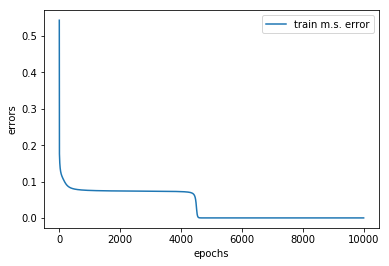

In [218]:
mlp_4 = MLP()
mlp_4.initialize(NI=2, NH=2, NO=1, activation_h=tanh, activation_o=linear)
mlp_4.train(X, y, n_epochs=10000, batch_size=2, learning_rate=0.05)

In [219]:
[(x, mlp_4.predict(x)[0]) for x in X]

[([0, 0], 9.992007221626409e-16),
 ([0, 1], 0.9999999999999989),
 ([1, 0], 0.9999999999999984),
 ([1, 1], 2.6645352591003757e-15)]

Epoch = 0 MSError= 0.5395130685049192
Epoch = 1 MSError= 0.5382769925070721
Epoch = 2 MSError= 0.5375093184324392
Epoch = 3 MSError= 0.5369181453886169
Epoch = 4 MSError= 0.5363963960557091
Epoch = 5 MSError= 0.5359047404039216
Epoch = 6 MSError= 0.5354286900062895
Epoch = 7 MSError= 0.5349628656481449
Epoch = 8 MSError= 0.5345052262385862
Epoch = 9 MSError= 0.5340549515916145
Epoch = 10 MSError= 0.5336116662220728
Epoch = 11 MSError= 0.5331751554739774
Epoch = 12 MSError= 0.5327452623394069
Epoch = 13 MSError= 0.5323218504627497
Epoch = 14 MSError= 0.5319047912550516
Epoch = 15 MSError= 0.5314939596781314
Epoch = 16 MSError= 0.5310892330577802
Epoch = 17 MSError= 0.5306904908886475
Epoch = 18 MSError= 0.530297614913817
Epoch = 19 MSError= 0.5299104892413193
Epoch = 20 MSError= 0.5295290004298426
Epoch = 21 MSError= 0.5291530375330956
Epoch = 22 MSError= 0.5287824921091299
Epoch = 23 MSError= 0.5284172582039842
Epoch = 24 MSError= 0.5280572323178899
Epoch = 25 MSError= 0.52770231336027

Epoch = 744 MSError= 0.46966180954391823
Epoch = 745 MSError= 0.4695815426771003
Epoch = 746 MSError= 0.46950111938928935
Epoch = 747 MSError= 0.4694205394755635
Epoch = 748 MSError= 0.4693398027326411
Epoch = 749 MSError= 0.46925890895889033
Epoch = 750 MSError= 0.4691778579543363
Epoch = 751 MSError= 0.469096649520671
Epoch = 752 MSError= 0.46901528346126037
Epoch = 753 MSError= 0.46893375958115413
Epoch = 754 MSError= 0.46885207768709264
Epoch = 755 MSError= 0.46877023758751696
Epoch = 756 MSError= 0.4686882390925765
Epoch = 757 MSError= 0.468606082014138
Epoch = 758 MSError= 0.4685237661657936
Epoch = 759 MSError= 0.4684412913628704
Epoch = 760 MSError= 0.468358657422437
Epoch = 761 MSError= 0.4682758641633149
Epoch = 762 MSError= 0.4681929114060848
Epoch = 763 MSError= 0.4681097989730957
Epoch = 764 MSError= 0.46802652668847466
Epoch = 765 MSError= 0.4679430943781336
Epoch = 766 MSError= 0.4678595018697796
Epoch = 767 MSError= 0.46777574899292285
Epoch = 768 MSError= 0.46769183557

Epoch = 1486 MSError= 0.3807080822209076
Epoch = 1487 MSError= 0.38059371802276765
Epoch = 1488 MSError= 0.3804794919081668
Epoch = 1489 MSError= 0.38036540407423797
Epoch = 1490 MSError= 0.38025145471576444
Epoch = 1491 MSError= 0.380137644025189
Epoch = 1492 MSError= 0.3800239721926128
Epoch = 1493 MSError= 0.37991043940580593
Epoch = 1494 MSError= 0.3797970458502084
Epoch = 1495 MSError= 0.37968379170893685
Epoch = 1496 MSError= 0.37957067716278825
Epoch = 1497 MSError= 0.3794577023902458
Epoch = 1498 MSError= 0.379344867567484
Epoch = 1499 MSError= 0.37923217286837296
Epoch = 1500 MSError= 0.37911961846448544
Epoch = 1501 MSError= 0.37900720452509934
Epoch = 1502 MSError= 0.37889493121720436
Epoch = 1503 MSError= 0.37878279870550896
Epoch = 1504 MSError= 0.3786708071524425
Epoch = 1505 MSError= 0.3785589567181641
Epoch = 1506 MSError= 0.3784472475605641
Epoch = 1507 MSError= 0.3783356798352743
Epoch = 1508 MSError= 0.37822425369567014
Epoch = 1509 MSError= 0.37811296929287785
Epoch

Epoch = 2232 MSError= 0.33015850293729265
Epoch = 2233 MSError= 0.3301239329131038
Epoch = 2234 MSError= 0.3300894156799468
Epoch = 2235 MSError= 0.33005495113273314
Epoch = 2236 MSError= 0.3300205391666021
Epoch = 2237 MSError= 0.32998617967692057
Epoch = 2238 MSError= 0.3299518725592838
Epoch = 2239 MSError= 0.32991761770951356
Epoch = 2240 MSError= 0.3298834150236576
Epoch = 2241 MSError= 0.32984926439799067
Epoch = 2242 MSError= 0.3298151657290128
Epoch = 2243 MSError= 0.3297811189134492
Epoch = 2244 MSError= 0.3297471238482509
Epoch = 2245 MSError= 0.3297131804305926
Epoch = 2246 MSError= 0.3296792885578731
Epoch = 2247 MSError= 0.32964544812771523
Epoch = 2248 MSError= 0.32961165903796563
Epoch = 2249 MSError= 0.32957792118669227
Epoch = 2250 MSError= 0.32954423447218645
Epoch = 2251 MSError= 0.3295105987929626
Epoch = 2252 MSError= 0.3294770140477541
Epoch = 2253 MSError= 0.3294434801355177
Epoch = 2254 MSError= 0.3294099969554304
Epoch = 2255 MSError= 0.3293765644068893
Epoch =

Epoch = 2957 MSError= 0.31428177760530385
Epoch = 2958 MSError= 0.3142681304584473
Epoch = 2959 MSError= 0.31425449774026043
Epoch = 2960 MSError= 0.3142408794280436
Epoch = 2961 MSError= 0.314227275499139
Epoch = 2962 MSError= 0.314213685930932
Epoch = 2963 MSError= 0.31420011070085285
Epoch = 2964 MSError= 0.3141865497863737
Epoch = 2965 MSError= 0.3141730031650088
Epoch = 2966 MSError= 0.3141594708143177
Epoch = 2967 MSError= 0.31414595271190093
Epoch = 2968 MSError= 0.3141324488354024
Epoch = 2969 MSError= 0.3141189591625093
Epoch = 2970 MSError= 0.31410548367095037
Epoch = 2971 MSError= 0.3140920223384968
Epoch = 2972 MSError= 0.314078575142963
Epoch = 2973 MSError= 0.3140651420622055
Epoch = 2974 MSError= 0.31405172307412166
Epoch = 2975 MSError= 0.3140383181566536
Epoch = 2976 MSError= 0.3140249272877822
Epoch = 2977 MSError= 0.3140115504455327
Epoch = 2978 MSError= 0.31399818760797105
Epoch = 2979 MSError= 0.31398483875320515
Epoch = 2980 MSError= 0.313971503859384
Epoch = 2981

Epoch = 3705 MSError= 0.3069456030949778
Epoch = 3706 MSError= 0.30693850280621654
Epoch = 3707 MSError= 0.30693140750536846
Epoch = 3708 MSError= 0.30692431718584123
Epoch = 3709 MSError= 0.306917231841049
Epoch = 3710 MSError= 0.3069101514644154
Epoch = 3711 MSError= 0.3069030760493732
Epoch = 3712 MSError= 0.3068960055893648
Epoch = 3713 MSError= 0.30688894007783973
Epoch = 3714 MSError= 0.30688187950825824
Epoch = 3715 MSError= 0.3068748238740888
Epoch = 3716 MSError= 0.3068677731688083
Epoch = 3717 MSError= 0.30686072738590364
Epoch = 3718 MSError= 0.3068536865188687
Epoch = 3719 MSError= 0.3068466505612092
Epoch = 3720 MSError= 0.30683961950643635
Epoch = 3721 MSError= 0.3068325933480732
Epoch = 3722 MSError= 0.306825572079648
Epoch = 3723 MSError= 0.3068185556947014
Epoch = 3724 MSError= 0.30681154418678136
Epoch = 3725 MSError= 0.306804537549444
Epoch = 3726 MSError= 0.30679753577625474
Epoch = 3727 MSError= 0.30679053886078667
Epoch = 3728 MSError= 0.3067835467966239
Epoch = 3

Epoch = 4445 MSError= 0.30269670450620373
Epoch = 4446 MSError= 0.30269192363939534
Epoch = 4447 MSError= 0.30268714444418765
Epoch = 4448 MSError= 0.30268236691727585
Epoch = 4449 MSError= 0.30267759105535985
Epoch = 4450 MSError= 0.30267281685513686
Epoch = 4451 MSError= 0.30266804431330857
Epoch = 4452 MSError= 0.30266327342657473
Epoch = 4453 MSError= 0.3026585041916391
Epoch = 4454 MSError= 0.3026537366052038
Epoch = 4455 MSError= 0.302648970663973
Epoch = 4456 MSError= 0.30264420636465345
Epoch = 4457 MSError= 0.3026394437039505
Epoch = 4458 MSError= 0.30263468267857185
Epoch = 4459 MSError= 0.302629923285226
Epoch = 4460 MSError= 0.30262516552062413
Epoch = 4461 MSError= 0.3026204093814736
Epoch = 4462 MSError= 0.30261565486448916
Epoch = 4463 MSError= 0.3026109019663815
Epoch = 4464 MSError= 0.3026061506838646
Epoch = 4465 MSError= 0.30260140101365307
Epoch = 4466 MSError= 0.30259665295246263
Epoch = 4467 MSError= 0.30259190649700984
Epoch = 4468 MSError= 0.30258716164401134
Ep

Epoch = 5186 MSError= 0.29938776881531765
Epoch = 5187 MSError= 0.299383288149639
Epoch = 5188 MSError= 0.29937880639179326
Epoch = 5189 MSError= 0.29937432353645954
Epoch = 5190 MSError= 0.2993698395783093
Epoch = 5191 MSError= 0.2993653545120045
Epoch = 5192 MSError= 0.29936086833219744
Epoch = 5193 MSError= 0.2993563810335317
Epoch = 5194 MSError= 0.29935189261064243
Epoch = 5195 MSError= 0.29934740305815366
Epoch = 5196 MSError= 0.2993429123706828
Epoch = 5197 MSError= 0.2993384205428355
Epoch = 5198 MSError= 0.2993339275692093
Epoch = 5199 MSError= 0.2993294334443929
Epoch = 5200 MSError= 0.299324938162965
Epoch = 5201 MSError= 0.2993204417194951
Epoch = 5202 MSError= 0.29931594410854206
Epoch = 5203 MSError= 0.29931144532465925
Epoch = 5204 MSError= 0.2993069453623858
Epoch = 5205 MSError= 0.2993024442162533
Epoch = 5206 MSError= 0.2992979418807846
Epoch = 5207 MSError= 0.2992934383504924
Epoch = 5208 MSError= 0.2992889336198784
Epoch = 5209 MSError= 0.2992844276834381
Epoch = 52

Epoch = 5922 MSError= 0.2952428185703715
Epoch = 5923 MSError= 0.2952347952386417
Epoch = 5924 MSError= 0.2952267597496586
Epoch = 5925 MSError= 0.29521871206415246
Epoch = 5926 MSError= 0.295210652142707
Epoch = 5927 MSError= 0.2952025799457483
Epoch = 5928 MSError= 0.2951944954335547
Epoch = 5929 MSError= 0.2951863985662462
Epoch = 5930 MSError= 0.2951782893037914
Epoch = 5931 MSError= 0.29517016760600134
Epoch = 5932 MSError= 0.29516203343253233
Epoch = 5933 MSError= 0.2951538867428832
Epoch = 5934 MSError= 0.2951457274963949
Epoch = 5935 MSError= 0.2951375556522516
Epoch = 5936 MSError= 0.29512937116947535
Epoch = 5937 MSError= 0.2951211740069313
Epoch = 5938 MSError= 0.29511296412332266
Epoch = 5939 MSError= 0.2951047414771907
Epoch = 5940 MSError= 0.2950965060269133
Epoch = 5941 MSError= 0.29508825773070885
Epoch = 5942 MSError= 0.295079996546628
Epoch = 5943 MSError= 0.2950717224325581
Epoch = 5944 MSError= 0.2950634353462208
Epoch = 5945 MSError= 0.2950551352451732
Epoch = 5946

Epoch = 6670 MSError= 0.2762575213252964
Epoch = 6671 MSError= 0.2761701293145359
Epoch = 6672 MSError= 0.27608216401889507
Epoch = 6673 MSError= 0.2759936199361607
Epoch = 6674 MSError= 0.2759044914957508
Epoch = 6675 MSError= 0.2758147730576779
Epoch = 6676 MSError= 0.27572445891149405
Epoch = 6677 MSError= 0.2756335432752216
Epoch = 6678 MSError= 0.2755420202942571
Epoch = 6679 MSError= 0.27544988404025994
Epoch = 6680 MSError= 0.27535712851002586
Epoch = 6681 MSError= 0.27526374762432826
Epoch = 6682 MSError= 0.27516973522675214
Epoch = 6683 MSError= 0.275075085082497
Epoch = 6684 MSError= 0.2749797908771644
Epoch = 6685 MSError= 0.274883846215517
Epoch = 6686 MSError= 0.2747872446202223
Epoch = 6687 MSError= 0.2746899795305715
Epoch = 6688 MSError= 0.27459204430116924
Epoch = 6689 MSError= 0.27449343220060735
Epoch = 6690 MSError= 0.2743941364101105
Epoch = 6691 MSError= 0.2742941500221562
Epoch = 6692 MSError= 0.2741934660390715
Epoch = 6693 MSError= 0.2740920773716027
Epoch = 66

Epoch = 7373 MSError= 3.266979566166689e-05
Epoch = 7374 MSError= 3.206902707155068e-05
Epoch = 7375 MSError= 3.147928811003215e-05
Epoch = 7376 MSError= 3.090037678038552e-05
Epoch = 7377 MSError= 3.0332094771401027e-05
Epoch = 7378 MSError= 2.9774247390586335e-05
Epoch = 7379 MSError= 2.9226643498467576e-05
Epoch = 7380 MSError= 2.868909544411827e-05
Epoch = 7381 MSError= 2.816141900184516e-05
Epoch = 7382 MSError= 2.7643433309004237e-05
Epoch = 7383 MSError= 2.7134960804941465e-05
Epoch = 7384 MSError= 2.6635827171038263e-05
Epoch = 7385 MSError= 2.614586127182049e-05
Epoch = 7386 MSError= 2.5664895097145543e-05
Epoch = 7387 MSError= 2.519276370542208e-05
Epoch = 7388 MSError= 2.4729305167855432e-05
Epoch = 7389 MSError= 2.4274360513701904e-05
Epoch = 7390 MSError= 2.3827773676501917e-05
Epoch = 7391 MSError= 2.338939144127971e-05
Epoch = 7392 MSError= 2.295906339271896e-05
Epoch = 7393 MSError= 2.2536641864245232e-05
Epoch = 7394 MSError= 2.2121981888050285e-05
Epoch = 7395 MSError

Epoch = 8120 MSError= 2.992097106139813e-11
Epoch = 8121 MSError= 2.936896940346399e-11
Epoch = 8122 MSError= 2.882715141908488e-11
Epoch = 8123 MSError= 2.829532923425946e-11
Epoch = 8124 MSError= 2.7773318438671182e-11
Epoch = 8125 MSError= 2.726093802463812e-11
Epoch = 8126 MSError= 2.6758010333230613e-11
Epoch = 8127 MSError= 2.626436096701942e-11
Epoch = 8128 MSError= 2.577981875503425e-11
Epoch = 8129 MSError= 2.5304215680887242e-11
Epoch = 8130 MSError= 2.483738683316329e-11
Epoch = 8131 MSError= 2.4379170342874923e-11
Epoch = 8132 MSError= 2.3929407321000806e-11
Epoch = 8133 MSError= 2.3487941815629993e-11
Epoch = 8134 MSError= 2.305462073895628e-11
Epoch = 8135 MSError= 2.2629293854226406e-11
Epoch = 8136 MSError= 2.2211813665757453e-11
Epoch = 8137 MSError= 2.1802035417048926e-11
Epoch = 8138 MSError= 2.1399817022647943e-11
Epoch = 8139 MSError= 2.1005019006467988e-11
Epoch = 8140 MSError= 2.0617504480585056e-11
Epoch = 8141 MSError= 2.0237139071251857e-11
Epoch = 8142 MSErro

Epoch = 8864 MSError= 2.8790481958734905e-17
Epoch = 8865 MSError= 2.82593351693878e-17
Epoch = 8866 MSError= 2.7737991961218405e-17
Epoch = 8867 MSError= 2.722625618649501e-17
Epoch = 8868 MSError= 2.672396678849082e-17
Epoch = 8869 MSError= 2.6230944336585123e-17
Epoch = 8870 MSError= 2.5747017163448315e-17
Epoch = 8871 MSError= 2.5272023413464248e-17
Epoch = 8872 MSError= 2.4805782724660016e-17
Epoch = 8873 MSError= 2.4348146817802116e-17
Epoch = 8874 MSError= 2.389895996960018e-17
Epoch = 8875 MSError= 2.345805112882976e-17
Epoch = 8876 MSError= 2.3025279649120852e-17
Epoch = 8877 MSError= 2.260049308109802e-17
Epoch = 8878 MSError= 2.2183545807045092e-17
Epoch = 8879 MSError= 2.1774287246691955e-17
Epoch = 8880 MSError= 2.1372578122702117e-17
Epoch = 8881 MSError= 2.0978280886111048e-17
Epoch = 8882 MSError= 2.0591261751005512e-17
Epoch = 8883 MSError= 2.0211376979853633e-17
Epoch = 8884 MSError= 1.983850510330416e-17
Epoch = 8885 MSError= 1.9472508446137426e-17
Epoch = 8886 MSErr

Epoch = 9599 MSError= 3.2760332850460236e-23
Epoch = 9600 MSError= 3.2152611936581207e-23
Epoch = 9601 MSError= 3.156278287490768e-23
Epoch = 9602 MSError= 3.09830757491388e-23
Epoch = 9603 MSError= 3.0408897398164996e-23
Epoch = 9604 MSError= 2.984972823524867e-23
Epoch = 9605 MSError= 2.9293736597895594e-23
Epoch = 9606 MSError= 2.8759755566467746e-23
Epoch = 9607 MSError= 2.8224738199840544e-23
Epoch = 9608 MSError= 2.770469271061519e-23
Epoch = 9609 MSError= 2.719224676838707e-23
Epoch = 9610 MSError= 2.669119399908641e-23
Epoch = 9611 MSError= 2.6199228019945374e-23
Epoch = 9612 MSError= 2.5713354616953565e-23
Epoch = 9613 MSError= 2.5238044548357754e-23
Epoch = 9614 MSError= 2.4774882635716532e-23
Epoch = 9615 MSError= 2.431865318956956e-23
Epoch = 9616 MSError= 2.3870716199954468e-23
Epoch = 9617 MSError= 2.343218623488569e-23
Epoch = 9618 MSError= 2.2999501402486882e-23
Epoch = 9619 MSError= 2.2575348119266967e-23
Epoch = 9620 MSError= 2.215879268822593e-23
Epoch = 9621 MSError

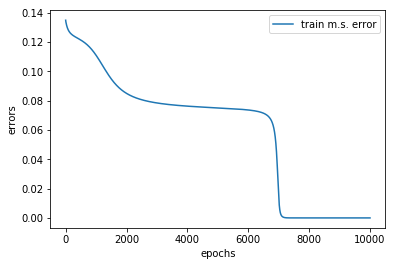

In [231]:
mlp_5 = MLP()
mlp_5.initialize(NI=2, NH=2, NO=1, activation_h=sigmoid, activation_o=linear)
mlp_5.train(X, y, n_epochs=10000, batch_size=2, learning_rate=0.05)

In [232]:
[(x, mlp_5.predict(x)[0]) for x in X]

[([0, 0], 1.4632739464559563e-13),
 ([0, 1], 0.9999999999998876),
 ([1, 0], 0.9999999999999435),
 ([1, 1], 1.8207657603852567e-14)]

Epoch = 0 MSError= 0.9059919452776639
Epoch = 1 MSError= 0.5709015987961227
Epoch = 2 MSError= 0.515293564178787
Epoch = 3 MSError= 0.5056579032930444
Epoch = 4 MSError= 0.5037985189994609
Epoch = 5 MSError= 0.5033670899265886
Epoch = 6 MSError= 0.5032419666730031
Epoch = 7 MSError= 0.5031976072477831
Epoch = 8 MSError= 0.5031788994650392
Epoch = 9 MSError= 0.5031693694056336
Epoch = 10 MSError= 0.503163333484633
Epoch = 11 MSError= 0.5031586741675798
Epoch = 12 MSError= 0.5031545743790822
Epoch = 13 MSError= 0.503150714013965
Epoch = 14 MSError= 0.5031469667231121
Epoch = 15 MSError= 0.5031432823192731
Epoch = 16 MSError= 0.5031396406538848
Epoch = 17 MSError= 0.5031360334443467
Epoch = 18 MSError= 0.5031324571009446
Epoch = 19 MSError= 0.5031289098934474
Epoch = 20 MSError= 0.5031253908315216
Epoch = 21 MSError= 0.5031218992222327
Epoch = 22 MSError= 0.5031184344950888
Epoch = 23 MSError= 0.5031149961328074
Epoch = 24 MSError= 0.5031115836438619
Epoch = 25 MSError= 0.5031081965515412

Epoch = 716 MSError= 0.4941057981165875
Epoch = 717 MSError= 0.494047127502204
Epoch = 718 MSError= 0.4939880830869787
Epoch = 719 MSError= 0.4939286629174894
Epoch = 720 MSError= 0.4938688650353312
Epoch = 721 MSError= 0.4938086874771444
Epoch = 722 MSError= 0.4937481282746414
Epoch = 723 MSError= 0.4936871854546351
Epoch = 724 MSError= 0.49362585703906536
Epoch = 725 MSError= 0.4935641410450266
Epoch = 726 MSError= 0.49350203548479615
Epoch = 727 MSError= 0.49343953836586085
Epoch = 728 MSError= 0.49337664769094536
Epoch = 729 MSError= 0.4933133614580384
Epoch = 730 MSError= 0.4932496776604217
Epoch = 731 MSError= 0.4931855942866965
Epoch = 732 MSError= 0.493121109320811
Epoch = 733 MSError= 0.49305622074208744
Epoch = 734 MSError= 0.4929909265252501
Epoch = 735 MSError= 0.4929252246404517
Epoch = 736 MSError= 0.4928591130533011
Epoch = 737 MSError= 0.49279258972488993
Epoch = 738 MSError= 0.4927256526118188
Epoch = 739 MSError= 0.4926582996662263
Epoch = 740 MSError= 0.4925905288358

Epoch = 1448 MSError= 0.09125434237519364
Epoch = 1449 MSError= 0.09023251226044039
Epoch = 1450 MSError= 0.08921682214967902
Epoch = 1451 MSError= 0.0882073209801606
Epoch = 1452 MSError= 0.08720405648599933
Epoch = 1453 MSError= 0.08620707518221687
Epoch = 1454 MSError= 0.0852164223494928
Epoch = 1455 MSError= 0.0842321420196309
Epoch = 1456 MSError= 0.08325427696175144
Epoch = 1457 MSError= 0.08228286866921487
Epoch = 1458 MSError= 0.08131795734728635
Epoch = 1459 MSError= 0.0803595819015456
Epoch = 1460 MSError= 0.07940777992704931
Epoch = 1461 MSError= 0.07846258769824746
Epoch = 1462 MSError= 0.07752404015966423
Epoch = 1463 MSError= 0.07659217091733847
Epoch = 1464 MSError= 0.07566701223103106
Epoch = 1465 MSError= 0.0747485950072023
Epoch = 1466 MSError= 0.0738369487927542
Epoch = 1467 MSError= 0.07293210176954446
Epoch = 1468 MSError= 0.07203408074966682
Epoch = 1469 MSError= 0.07114291117149979
Epoch = 1470 MSError= 0.07025861709651898
Epoch = 1471 MSError= 0.0693812212068724

Epoch = 2195 MSError= 2.6033102880699206e-08
Epoch = 2196 MSError= 2.546786222005245e-08
Epoch = 2197 MSError= 2.4914892766428353e-08
Epoch = 2198 MSError= 2.4373928165064514e-08
Epoch = 2199 MSError= 2.384470784023678e-08
Epoch = 2200 MSError= 2.332697687123025e-08
Epoch = 2201 MSError= 2.282048586899068e-08
Epoch = 2202 MSError= 2.2324990855866766e-08
Epoch = 2203 MSError= 2.1840253149323667e-08
Epoch = 2204 MSError= 2.1366039245871705e-08
Epoch = 2205 MSError= 2.0902120709771582e-08
Epoch = 2206 MSError= 2.0448274061911336e-08
Epoch = 2207 MSError= 2.0004280673764845e-08
Epoch = 2208 MSError= 1.956992666056843e-08
Epoch = 2209 MSError= 1.9145002779799764e-08
Epoch = 2210 MSError= 1.8729304329303467e-08
Epoch = 2211 MSError= 1.8322631050314035e-08
Epoch = 2212 MSError= 1.7924787029101976e-08
Epoch = 2213 MSError= 1.75355806041695e-08
Epoch = 2214 MSError= 1.7154824273372433e-08
Epoch = 2215 MSError= 1.67823346042676e-08
Epoch = 2216 MSError= 1.6417932145151586e-08
Epoch = 2217 MSErro

Epoch = 2927 MSError= 2.725824263550313e-15
Epoch = 2928 MSError= 2.6666252297027885e-15
Epoch = 2929 MSError= 2.60871196208214e-15
Epoch = 2930 MSError= 2.552056452344028e-15
Epoch = 2931 MSError= 2.496631303309331e-15
Epoch = 2932 MSError= 2.442409876246284e-15
Epoch = 2933 MSError= 2.389366071598283e-15
Epoch = 2934 MSError= 2.337474267489517e-15
Epoch = 2935 MSError= 2.2867093875762104e-15
Epoch = 2936 MSError= 2.23704703191759e-15
Epoch = 2937 MSError= 2.188463265701435e-15
Epoch = 2938 MSError= 2.1409345782143185e-15
Epoch = 2939 MSError= 2.0944381690501974e-15
Epoch = 2940 MSError= 2.048951511564806e-15
Epoch = 2941 MSError= 2.0044527251401778e-15
Epoch = 2942 MSError= 1.9609203701669465e-15
Epoch = 2943 MSError= 1.9183334710860918e-15
Epoch = 2944 MSError= 1.8766714207102366e-15
Epoch = 2945 MSError= 1.8359142160173713e-15
Epoch = 2946 MSError= 1.7960421498324076e-15
Epoch = 2947 MSError= 1.7570360329354936e-15
Epoch = 2948 MSError= 1.7188770144795961e-15
Epoch = 2949 MSError= 

Epoch = 3641 MSError= 4.235484598907489e-22
Epoch = 3642 MSError= 4.1434762766609047e-22
Epoch = 3643 MSError= 4.0536325701876896e-22
Epoch = 3644 MSError= 3.9655559886246995e-22
Epoch = 3645 MSError= 3.879504807990532e-22
Epoch = 3646 MSError= 3.7949933558383485e-22
Epoch = 3647 MSError= 3.7128024802803543e-22
Epoch = 3648 MSError= 3.6320336619046e-22
Epoch = 3649 MSError= 3.553045902619255e-22
Epoch = 3650 MSError= 3.475913454819841e-22
Epoch = 3651 MSError= 3.400415029217377e-22
Epoch = 3652 MSError= 3.3266199539897015e-22
Epoch = 3653 MSError= 3.2543088276289587e-22
Epoch = 3654 MSError= 3.1837307778940656e-22
Epoch = 3655 MSError= 3.114525014997566e-22
Epoch = 3656 MSError= 3.046915695552942e-22
Epoch = 3657 MSError= 2.980897682226807e-22
Epoch = 3658 MSError= 2.9161989962401214e-22
Epoch = 3659 MSError= 2.852777096912716e-22
Epoch = 3660 MSError= 2.7907726281599706e-22
Epoch = 3661 MSError= 2.730063398262636e-22
Epoch = 3662 MSError= 2.6708966149045114e-22
Epoch = 3663 MSError= 2

Epoch = 4367 MSError= 5.862222601923644e-29
Epoch = 4368 MSError= 5.873932255985518e-29
Epoch = 4369 MSError= 5.569481250376784e-29
Epoch = 4370 MSError= 5.26811173267907e-29
Epoch = 4371 MSError= 5.096164707244177e-29
Epoch = 4372 MSError= 4.774457369333733e-29
Epoch = 4373 MSError= 4.331339407729118e-29
Epoch = 4374 MSError= 4.2388947703985306e-29
Epoch = 4375 MSError= 3.878976982391444e-29
Epoch = 4376 MSError= 4.398515844189345e-29
Epoch = 4377 MSError= 4.110704873300116e-29
Epoch = 4378 MSError= 4.03736546101785e-29
Epoch = 4379 MSError= 3.829056878232927e-29
Epoch = 4380 MSError= 3.651563174558199e-29
Epoch = 4381 MSError= 3.5042680524114634e-29
Epoch = 4382 MSError= 3.6053408558929055e-29
Epoch = 4383 MSError= 3.3150646946748613e-29
Epoch = 4384 MSError= 3.5165940040555417e-29
Epoch = 4385 MSError= 3.070394554539907e-29
Epoch = 4386 MSError= 2.5773564887767745e-29
Epoch = 4387 MSError= 2.4528643771715836e-29
Epoch = 4388 MSError= 2.6587077696276914e-29
Epoch = 4389 MSError= 2.87

Epoch = 5115 MSError= 2.414037629492737e-29
Epoch = 5116 MSError= 2.414037629492737e-29
Epoch = 5117 MSError= 2.414037629492737e-29
Epoch = 5118 MSError= 2.414037629492737e-29
Epoch = 5119 MSError= 2.414037629492737e-29
Epoch = 5120 MSError= 2.414037629492737e-29
Epoch = 5121 MSError= 2.414037629492737e-29
Epoch = 5122 MSError= 2.414037629492737e-29
Epoch = 5123 MSError= 2.414037629492737e-29
Epoch = 5124 MSError= 2.414037629492737e-29
Epoch = 5125 MSError= 2.414037629492737e-29
Epoch = 5126 MSError= 2.414037629492737e-29
Epoch = 5127 MSError= 2.414037629492737e-29
Epoch = 5128 MSError= 2.414037629492737e-29
Epoch = 5129 MSError= 2.414037629492737e-29
Epoch = 5130 MSError= 2.414037629492737e-29
Epoch = 5131 MSError= 2.414037629492737e-29
Epoch = 5132 MSError= 2.414037629492737e-29
Epoch = 5133 MSError= 2.414037629492737e-29
Epoch = 5134 MSError= 2.414037629492737e-29
Epoch = 5135 MSError= 2.414037629492737e-29
Epoch = 5136 MSError= 2.414037629492737e-29
Epoch = 5137 MSError= 2.41403762

Epoch = 5849 MSError= 2.414037629492737e-29
Epoch = 5850 MSError= 2.414037629492737e-29
Epoch = 5851 MSError= 2.414037629492737e-29
Epoch = 5852 MSError= 2.414037629492737e-29
Epoch = 5853 MSError= 2.414037629492737e-29
Epoch = 5854 MSError= 2.414037629492737e-29
Epoch = 5855 MSError= 2.414037629492737e-29
Epoch = 5856 MSError= 2.414037629492737e-29
Epoch = 5857 MSError= 2.414037629492737e-29
Epoch = 5858 MSError= 2.414037629492737e-29
Epoch = 5859 MSError= 2.414037629492737e-29
Epoch = 5860 MSError= 2.414037629492737e-29
Epoch = 5861 MSError= 2.414037629492737e-29
Epoch = 5862 MSError= 2.414037629492737e-29
Epoch = 5863 MSError= 2.414037629492737e-29
Epoch = 5864 MSError= 2.414037629492737e-29
Epoch = 5865 MSError= 2.414037629492737e-29
Epoch = 5866 MSError= 2.414037629492737e-29
Epoch = 5867 MSError= 2.414037629492737e-29
Epoch = 5868 MSError= 2.414037629492737e-29
Epoch = 5869 MSError= 2.414037629492737e-29
Epoch = 5870 MSError= 2.414037629492737e-29
Epoch = 5871 MSError= 2.41403762

Epoch = 6565 MSError= 2.414037629492737e-29
Epoch = 6566 MSError= 2.414037629492737e-29
Epoch = 6567 MSError= 2.414037629492737e-29
Epoch = 6568 MSError= 2.414037629492737e-29
Epoch = 6569 MSError= 2.414037629492737e-29
Epoch = 6570 MSError= 2.414037629492737e-29
Epoch = 6571 MSError= 2.414037629492737e-29
Epoch = 6572 MSError= 2.414037629492737e-29
Epoch = 6573 MSError= 2.414037629492737e-29
Epoch = 6574 MSError= 2.414037629492737e-29
Epoch = 6575 MSError= 2.414037629492737e-29
Epoch = 6576 MSError= 2.414037629492737e-29
Epoch = 6577 MSError= 2.414037629492737e-29
Epoch = 6578 MSError= 2.414037629492737e-29
Epoch = 6579 MSError= 2.414037629492737e-29
Epoch = 6580 MSError= 2.414037629492737e-29
Epoch = 6581 MSError= 2.414037629492737e-29
Epoch = 6582 MSError= 2.414037629492737e-29
Epoch = 6583 MSError= 2.414037629492737e-29
Epoch = 6584 MSError= 2.414037629492737e-29
Epoch = 6585 MSError= 2.414037629492737e-29
Epoch = 6586 MSError= 2.414037629492737e-29
Epoch = 6587 MSError= 2.41403762

Epoch = 7316 MSError= 2.414037629492737e-29
Epoch = 7317 MSError= 2.414037629492737e-29
Epoch = 7318 MSError= 2.414037629492737e-29
Epoch = 7319 MSError= 2.414037629492737e-29
Epoch = 7320 MSError= 2.414037629492737e-29
Epoch = 7321 MSError= 2.414037629492737e-29
Epoch = 7322 MSError= 2.414037629492737e-29
Epoch = 7323 MSError= 2.414037629492737e-29
Epoch = 7324 MSError= 2.414037629492737e-29
Epoch = 7325 MSError= 2.414037629492737e-29
Epoch = 7326 MSError= 2.414037629492737e-29
Epoch = 7327 MSError= 2.414037629492737e-29
Epoch = 7328 MSError= 2.414037629492737e-29
Epoch = 7329 MSError= 2.414037629492737e-29
Epoch = 7330 MSError= 2.414037629492737e-29
Epoch = 7331 MSError= 2.414037629492737e-29
Epoch = 7332 MSError= 2.414037629492737e-29
Epoch = 7333 MSError= 2.414037629492737e-29
Epoch = 7334 MSError= 2.414037629492737e-29
Epoch = 7335 MSError= 2.414037629492737e-29
Epoch = 7336 MSError= 2.414037629492737e-29
Epoch = 7337 MSError= 2.414037629492737e-29
Epoch = 7338 MSError= 2.41403762

Epoch = 8065 MSError= 2.414037629492737e-29
Epoch = 8066 MSError= 2.414037629492737e-29
Epoch = 8067 MSError= 2.414037629492737e-29
Epoch = 8068 MSError= 2.414037629492737e-29
Epoch = 8069 MSError= 2.414037629492737e-29
Epoch = 8070 MSError= 2.414037629492737e-29
Epoch = 8071 MSError= 2.414037629492737e-29
Epoch = 8072 MSError= 2.414037629492737e-29
Epoch = 8073 MSError= 2.414037629492737e-29
Epoch = 8074 MSError= 2.414037629492737e-29
Epoch = 8075 MSError= 2.414037629492737e-29
Epoch = 8076 MSError= 2.414037629492737e-29
Epoch = 8077 MSError= 2.414037629492737e-29
Epoch = 8078 MSError= 2.414037629492737e-29
Epoch = 8079 MSError= 2.414037629492737e-29
Epoch = 8080 MSError= 2.414037629492737e-29
Epoch = 8081 MSError= 2.414037629492737e-29
Epoch = 8082 MSError= 2.414037629492737e-29
Epoch = 8083 MSError= 2.414037629492737e-29
Epoch = 8084 MSError= 2.414037629492737e-29
Epoch = 8085 MSError= 2.414037629492737e-29
Epoch = 8086 MSError= 2.414037629492737e-29
Epoch = 8087 MSError= 2.41403762

Epoch = 8815 MSError= 2.414037629492737e-29
Epoch = 8816 MSError= 2.414037629492737e-29
Epoch = 8817 MSError= 2.414037629492737e-29
Epoch = 8818 MSError= 2.414037629492737e-29
Epoch = 8819 MSError= 2.414037629492737e-29
Epoch = 8820 MSError= 2.414037629492737e-29
Epoch = 8821 MSError= 2.414037629492737e-29
Epoch = 8822 MSError= 2.414037629492737e-29
Epoch = 8823 MSError= 2.414037629492737e-29
Epoch = 8824 MSError= 2.414037629492737e-29
Epoch = 8825 MSError= 2.414037629492737e-29
Epoch = 8826 MSError= 2.414037629492737e-29
Epoch = 8827 MSError= 2.414037629492737e-29
Epoch = 8828 MSError= 2.414037629492737e-29
Epoch = 8829 MSError= 2.414037629492737e-29
Epoch = 8830 MSError= 2.414037629492737e-29
Epoch = 8831 MSError= 2.414037629492737e-29
Epoch = 8832 MSError= 2.414037629492737e-29
Epoch = 8833 MSError= 2.414037629492737e-29
Epoch = 8834 MSError= 2.414037629492737e-29
Epoch = 8835 MSError= 2.414037629492737e-29
Epoch = 8836 MSError= 2.414037629492737e-29
Epoch = 8837 MSError= 2.41403762

Epoch = 9555 MSError= 2.414037629492737e-29
Epoch = 9556 MSError= 2.414037629492737e-29
Epoch = 9557 MSError= 2.414037629492737e-29
Epoch = 9558 MSError= 2.414037629492737e-29
Epoch = 9559 MSError= 2.414037629492737e-29
Epoch = 9560 MSError= 2.414037629492737e-29
Epoch = 9561 MSError= 2.414037629492737e-29
Epoch = 9562 MSError= 2.414037629492737e-29
Epoch = 9563 MSError= 2.414037629492737e-29
Epoch = 9564 MSError= 2.414037629492737e-29
Epoch = 9565 MSError= 2.414037629492737e-29
Epoch = 9566 MSError= 2.414037629492737e-29
Epoch = 9567 MSError= 2.414037629492737e-29
Epoch = 9568 MSError= 2.414037629492737e-29
Epoch = 9569 MSError= 2.414037629492737e-29
Epoch = 9570 MSError= 2.414037629492737e-29
Epoch = 9571 MSError= 2.414037629492737e-29
Epoch = 9572 MSError= 2.414037629492737e-29
Epoch = 9573 MSError= 2.414037629492737e-29
Epoch = 9574 MSError= 2.414037629492737e-29
Epoch = 9575 MSError= 2.414037629492737e-29
Epoch = 9576 MSError= 2.414037629492737e-29
Epoch = 9577 MSError= 2.41403762

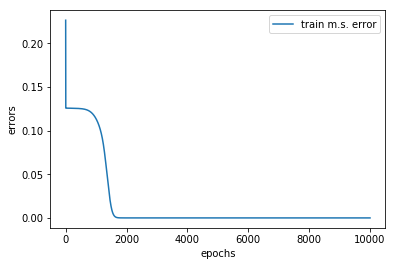

In [233]:
mlp_6 = MLP()
mlp_6.initialize(NI=2, NH=2, NO=1, activation_h=sigmoid, activation_o=linear)
mlp_6.train(X, y, n_epochs=10000, batch_size=2, learning_rate=0.1)

In [234]:
[(x, mlp_6.predict(x)[0]) for x in X]

[([0, 0], 2.6645352591003757e-15),
 ([0, 1], 0.9999999999999968),
 ([1, 0], 0.9999999999999966),
 ([1, 1], 3.4416913763379853e-15)]

## Sinus Approximation Problem
A training set of 200 vectors (each one consisting of 4 random numbers in $]-1, 1[$ ) is generated. For each of this vectors, a label is generated as $sin(v_0-v_1+v_2-v_3)$. Of the 200 samples, 150 are used for trainig and 50 for testing. The network seems to learn without problems, with a perfect generalization on the test samples. Compared with the XOR problem, in order to approximate this function through the mlp it is necessary to set a smaller learning rate, otherwise the gradients explode very quickly, or the values of the loss oscillate too much, symptom that the network is not learning.  
The testes topology has 4 input units, 5 hidden units and 1 output unit.

In [229]:
X_sin = [np.random.randn(1, 4)[0] for i in range(200)]
y_sin = [[math.sin(v[0]-v[1]+v[2]-v[3])] for v in X_sin]


X_train, y_train, X_test, y_test = X_sin[:150], y_sin[:150], X_sin[150:], y_sin[150:]

Epoch = 0 MSError= 40.02605225175531
Epoch = 1 MSError= 39.16621017620484
Epoch = 2 MSError= 38.87773453511305
Epoch = 3 MSError= 38.610126106113384
Epoch = 4 MSError= 38.34638664079451
Epoch = 5 MSError= 38.09304392601456
Epoch = 6 MSError= 37.85215430940424
Epoch = 7 MSError= 37.62357940404864
Epoch = 8 MSError= 37.40654641488613
Epoch = 9 MSError= 37.20017183935722
Epoch = 10 MSError= 37.003611431998664
Epoch = 11 MSError= 36.81609587296219
Epoch = 12 MSError= 36.63693361783289
Epoch = 13 MSError= 36.46550511352302
Epoch = 14 MSError= 36.301255354205935
Epoch = 15 MSError= 36.14368669314351
Epoch = 16 MSError= 35.99235236193122
Epoch = 17 MSError= 35.84685073731336
Epoch = 18 MSError= 35.70682029017046
Epoch = 19 MSError= 35.57193513279131
Epoch = 20 MSError= 35.44190108542298
Epoch = 21 MSError= 35.316452193059575
Epoch = 22 MSError= 35.195347633447035
Epoch = 23 MSError= 35.07836896612409
Epoch = 24 MSError= 34.96531767984433
Epoch = 25 MSError= 34.85601300205723
Epoch = 26 MSErro

Epoch = 211 MSError= 29.10401770216675
Epoch = 212 MSError= 29.06568120711985
Epoch = 213 MSError= 29.026929715120723
Epoch = 214 MSError= 28.98775896066812
Epoch = 215 MSError= 28.948164740328707
Epoch = 216 MSError= 28.90814291794682
Epoch = 217 MSError= 28.86768942988533
Epoch = 218 MSError= 28.82680029028606
Epoch = 219 MSError= 28.785471596339164
Epoch = 220 MSError= 28.74369953354953
Epoch = 221 MSError= 28.701480380988333
Epoch = 222 MSError= 28.658810516517526
Epoch = 223 MSError= 28.615686421975212
Epoch = 224 MSError= 28.572104688308848
Epoch = 225 MSError= 28.528062020643752
Epoch = 226 MSError= 28.48355524327429
Epoch = 227 MSError= 28.438581304564305
Epoch = 228 MSError= 28.39313728174474
Epoch = 229 MSError= 28.3472203855946
Epoch = 230 MSError= 28.300827964993413
Epoch = 231 MSError= 28.253957511331862
Epoch = 232 MSError= 28.20660666276869
Epoch = 233 MSError= 28.15877320832125
Epoch = 234 MSError= 28.110455091778313
Epoch = 235 MSError= 28.06165041542271
Epoch = 236 MS

Epoch = 429 MSError= 13.612041895358075
Epoch = 430 MSError= 13.545085386216567
Epoch = 431 MSError= 13.478507006207382
Epoch = 432 MSError= 13.412307926759382
Epoch = 433 MSError= 13.346489212364176
Epoch = 434 MSError= 13.281051822031197
Epoch = 435 MSError= 13.215996610809608
Epoch = 436 MSError= 13.151324331372498
Epoch = 437 MSError= 13.087035635659305
Epoch = 438 MSError= 13.023131076572263
Epoch = 439 MSError= 12.959611109722331
Epoch = 440 MSError= 12.896476095220768
Epoch = 441 MSError= 12.833726299511866
Epoch = 442 MSError= 12.771361897242842
Epoch = 443 MSError= 12.709382973166838
Epoch = 444 MSError= 12.647789524074865
Epoch = 445 MSError= 12.586581460752958
Epoch = 446 MSError= 12.525758609960675
Epoch = 447 MSError= 12.465320716427069
Epoch = 448 MSError= 12.405267444860673
Epoch = 449 MSError= 12.345598381970055
Epoch = 450 MSError= 12.286313038491212
Epoch = 451 MSError= 12.22741085121907
Epoch = 452 MSError= 12.168891185039534
Epoch = 453 MSError= 12.110753334959336
E

Epoch = 653 MSError= 5.838248130535489
Epoch = 654 MSError= 5.823033559999325
Epoch = 655 MSError= 5.80790687022299
Epoch = 656 MSError= 5.792867438338798
Epoch = 657 MSError= 5.777914647377942
Epoch = 658 MSError= 5.763047886194496
Epoch = 659 MSError= 5.748266549390159
Epoch = 660 MSError= 5.7335700372399305
Epoch = 661 MSError= 5.718957755618469
Epoch = 662 MSError= 5.704429115927348
Epoch = 663 MSError= 5.689983535023139
Epoch = 664 MSError= 5.675620435146223
Epoch = 665 MSError= 5.661339243850577
Epoch = 666 MSError= 5.647139393934243
Epoch = 667 MSError= 5.633020323370714
Epoch = 668 MSError= 5.618981475241105
Epoch = 669 MSError= 5.605022297667168
Epoch = 670 MSError= 5.591142243745129
Epoch = 671 MSError= 5.577340771480359
Epoch = 672 MSError= 5.5636173437228305
Epoch = 673 MSError= 5.54997142810347
Epoch = 674 MSError= 5.536402496971277
Epoch = 675 MSError= 5.522910027331262
Epoch = 676 MSError= 5.509493500783217
Epoch = 677 MSError= 5.496152403461334
Epoch = 678 MSError= 5.48

Epoch = 877 MSError= 3.8515322432427173
Epoch = 878 MSError= 3.8466489814054814
Epoch = 879 MSError= 3.8417861241629985
Epoch = 880 MSError= 3.8369435358649295
Epoch = 881 MSError= 3.8321210817171165
Epoch = 882 MSError= 3.8273186277773945
Epoch = 883 MSError= 3.822536040951476
Epoch = 884 MSError= 3.8177731889887974
Epoch = 885 MSError= 3.8130299404784362
Epoch = 886 MSError= 3.8083061648450034
Epoch = 887 MSError= 3.8036017323445663
Epoch = 888 MSError= 3.7989165140605774
Epoch = 889 MSError= 3.7942503818998574
Epoch = 890 MSError= 3.7896032085885207
Epoch = 891 MSError= 3.784974867667991
Epoch = 892 MSError= 3.780365233490991
Epoch = 893 MSError= 3.7757741812175385
Epoch = 894 MSError= 3.771201586810992
Epoch = 895 MSError= 3.7666473270340832
Epoch = 896 MSError= 3.76211127944497
Epoch = 897 MSError= 3.7575933223932974
Epoch = 898 MSError= 3.753093335016298
Epoch = 899 MSError= 3.7486111972348533
Epoch = 900 MSError= 3.744146789749647
Epoch = 901 MSError= 3.7396999940372377
Epoch = 

Epoch = 1083 MSError= 3.133073553639422
Epoch = 1084 MSError= 3.1304929839125273
Epoch = 1085 MSError= 3.127917886141118
Epoch = 1086 MSError= 3.1253482306365985
Epoch = 1087 MSError= 3.122783987958733
Epoch = 1088 MSError= 3.1202251289138148
Epoch = 1089 MSError= 3.117671624552846
Epoch = 1090 MSError= 3.1151234461696915
Epoch = 1091 MSError= 3.112580565299315
Epoch = 1092 MSError= 3.110042953715957
Epoch = 1093 MSError= 3.1075105834313446
Epoch = 1094 MSError= 3.104983426692933
Epoch = 1095 MSError= 3.1024614559821115
Epoch = 1096 MSError= 3.0999446440124614
Epoch = 1097 MSError= 3.0974329637279983
Epoch = 1098 MSError= 3.094926388301436
Epoch = 1099 MSError= 3.0924248911324383
Epoch = 1100 MSError= 3.0899284458459144
Epoch = 1101 MSError= 3.0874370262902926
Epoch = 1102 MSError= 3.0849506065358008
Epoch = 1103 MSError= 3.0824691608728068
Epoch = 1104 MSError= 3.0799926638100907
Epoch = 1105 MSError= 3.0775210900731884
Epoch = 1106 MSError= 3.0750544146027066
Epoch = 1107 MSError= 3.

Epoch = 1297 MSError= 2.6733237633643094
Epoch = 1298 MSError= 2.671511097253304
Epoch = 1299 MSError= 2.669700938936726
Epoch = 1300 MSError= 2.667893282590174
Epoch = 1301 MSError= 2.6660881224131896
Epoch = 1302 MSError= 2.6642854526288495
Epoch = 1303 MSError= 2.6624852674833654
Epoch = 1304 MSError= 2.6606875612456933
Epoch = 1305 MSError= 2.658892328207143
Epoch = 1306 MSError= 2.6570995626810117
Epoch = 1307 MSError= 2.655309259002182
Epoch = 1308 MSError= 2.6535214115267705
Epoch = 1309 MSError= 2.6517360146317515
Epoch = 1310 MSError= 2.649953062714605
Epoch = 1311 MSError= 2.6481725501929367
Epoch = 1312 MSError= 2.6463944715041507
Epoch = 1313 MSError= 2.6446188211050963
Epoch = 1314 MSError= 2.642845593471701
Epoch = 1315 MSError= 2.6410747830986687
Epoch = 1316 MSError= 2.639306384499131
Epoch = 1317 MSError= 2.6375403922043152
Epoch = 1318 MSError= 2.635776800763214
Epoch = 1319 MSError= 2.6340156047422965
Epoch = 1320 MSError= 2.6322567987251624
Epoch = 1321 MSError= 2.6

Epoch = 1506 MSError= 2.341325504941807
Epoch = 1507 MSError= 2.3399296836147707
Epoch = 1508 MSError= 2.338535415417687
Epoch = 1509 MSError= 2.3371426972604707
Epoch = 1510 MSError= 2.335751526080226
Epoch = 1511 MSError= 2.3343618988415273
Epoch = 1512 MSError= 2.3329738125367108
Epoch = 1513 MSError= 2.3315872641861284
Epoch = 1514 MSError= 2.330202250838429
Epoch = 1515 MSError= 2.3288187695708453
Epoch = 1516 MSError= 2.3274368174894335
Epoch = 1517 MSError= 2.326056391729366
Epoch = 1518 MSError= 2.3246774894552056
Epoch = 1519 MSError= 2.323300107861156
Epoch = 1520 MSError= 2.3219242441713464
Epoch = 1521 MSError= 2.3205498956400805
Epoch = 1522 MSError= 2.3191770595521186
Epoch = 1523 MSError= 2.317805733222927
Epoch = 1524 MSError= 2.3164359139989394
Epoch = 1525 MSError= 2.3150675992578402
Epoch = 1526 MSError= 2.3137007864087846
Epoch = 1527 MSError= 2.3123354728926953
Epoch = 1528 MSError= 2.310971656182472
Epoch = 1529 MSError= 2.309609333783296
Epoch = 1530 MSError= 2.3

Epoch = 1714 MSError= 2.0824511462653095
Epoch = 1715 MSError= 2.0813621881767266
Epoch = 1716 MSError= 2.0802748346977182
Epoch = 1717 MSError= 2.0791890877208217
Epoch = 1718 MSError= 2.0781049491181363
Epoch = 1719 MSError= 2.0770224207407564
Epoch = 1720 MSError= 2.0759415044181897
Epoch = 1721 MSError= 2.0748622019577865
Epoch = 1722 MSError= 2.0737845151441903
Epoch = 1723 MSError= 2.072708445738772
Epoch = 1724 MSError= 2.07163399547909
Epoch = 1725 MSError= 2.0705611660783436
Epoch = 1726 MSError= 2.0694899592248412
Epoch = 1727 MSError= 2.0684203765814626
Epoch = 1728 MSError= 2.0673524197851516
Epoch = 1729 MSError= 2.0662860904463924
Epoch = 1730 MSError= 2.0652213901487033
Epoch = 1731 MSError= 2.0641583204481346
Epoch = 1732 MSError= 2.0630968828727854
Epoch = 1733 MSError= 2.0620370789223124
Epoch = 1734 MSError= 2.060978910067445
Epoch = 1735 MSError= 2.059922377749538
Epoch = 1736 MSError= 2.0588674833800904
Epoch = 1737 MSError= 2.0578142283402965
Epoch = 1738 MSError=

Epoch = 1932 MSError= 1.8832204029357145
Epoch = 1933 MSError= 1.8824697664885395
Epoch = 1934 MSError= 1.881720399469814
Epoch = 1935 MSError= 1.8809722982595956
Epoch = 1936 MSError= 1.880225459240721
Epoch = 1937 MSError= 1.8794798787990132
Epoch = 1938 MSError= 1.878735553323519
Epoch = 1939 MSError= 1.8779924792067106
Epoch = 1940 MSError= 1.8772506528447055
Epoch = 1941 MSError= 1.8765100706374709
Epoch = 1942 MSError= 1.8757707289890393
Epoch = 1943 MSError= 1.8750326243077022
Epoch = 1944 MSError= 1.874295753006201
Epoch = 1945 MSError= 1.8735601115019567
Epoch = 1946 MSError= 1.872825696217217
Epoch = 1947 MSError= 1.8720925035792908
Epoch = 1948 MSError= 1.8713605300206941
Epoch = 1949 MSError= 1.8706297719793659
Epoch = 1950 MSError= 1.8699002258988326
Epoch = 1951 MSError= 1.8691718882283905
Epoch = 1952 MSError= 1.8684447554232673
Epoch = 1953 MSError= 1.8677188239448101
Epoch = 1954 MSError= 1.8669940902606408
Epoch = 1955 MSError= 1.8662705508448347
Epoch = 1956 MSError=

Epoch = 2147 MSError= 1.7458196960658816
Epoch = 2148 MSError= 1.7452727149405134
Epoch = 2149 MSError= 1.7447264343697173
Epoch = 2150 MSError= 1.7441808527309755
Epoch = 2151 MSError= 1.7436359684087177
Epoch = 2152 MSError= 1.743091779794311
Epoch = 2153 MSError= 1.7425482852859886
Epoch = 2154 MSError= 1.742005483288825
Epoch = 2155 MSError= 1.741463372214673
Epoch = 2156 MSError= 1.7409219504821485
Epoch = 2157 MSError= 1.7403812165165595
Epoch = 2158 MSError= 1.7398411687499
Epoch = 2159 MSError= 1.7393018056207619
Epoch = 2160 MSError= 1.7387631255743328
Epoch = 2161 MSError= 1.7382251270623292
Epoch = 2162 MSError= 1.737687808542978
Epoch = 2163 MSError= 1.7371511684809515
Epoch = 2164 MSError= 1.736615205347345
Epoch = 2165 MSError= 1.7360799176196238
Epoch = 2166 MSError= 1.7355453037815858
Epoch = 2167 MSError= 1.7350113623233332
Epoch = 2168 MSError= 1.7344780917412037
Epoch = 2169 MSError= 1.7339454905377674
Epoch = 2170 MSError= 1.733413557221758
Epoch = 2171 MSError= 1.7

Epoch = 2348 MSError= 1.6481586293977557
Epoch = 2349 MSError= 1.6477268039587616
Epoch = 2350 MSError= 1.6472954485735116
Epoch = 2351 MSError= 1.6468645624150204
Epoch = 2352 MSError= 1.6464341446584003
Epoch = 2353 MSError= 1.6460041944808534
Epoch = 2354 MSError= 1.645574711061668
Epoch = 2355 MSError= 1.6451456935821929
Epoch = 2356 MSError= 1.6447171412258503
Epoch = 2357 MSError= 1.6442890531781027
Epoch = 2358 MSError= 1.6438614286264683
Epoch = 2359 MSError= 1.643434266760484
Epoch = 2360 MSError= 1.6430075667717285
Epoch = 2361 MSError= 1.6425813278537855
Epoch = 2362 MSError= 1.6421555492022395
Epoch = 2363 MSError= 1.6417302300146883
Epoch = 2364 MSError= 1.641305369490714
Epoch = 2365 MSError= 1.640880966831866
Epoch = 2366 MSError= 1.6404570212416816
Epoch = 2367 MSError= 1.6400335319256527
Epoch = 2368 MSError= 1.639610498091225
Epoch = 2369 MSError= 1.639187918947797
Epoch = 2370 MSError= 1.6387657937066948
Epoch = 2371 MSError= 1.638344121581185
Epoch = 2372 MSError= 1

Epoch = 2554 MSError= 1.568071163589631
Epoch = 2555 MSError= 1.5677211968557705
Epoch = 2556 MSError= 1.5673715644587145
Epoch = 2557 MSError= 1.5670222658757311
Epoch = 2558 MSError= 1.5666733005851492
Epoch = 2559 MSError= 1.5663246680663871
Epoch = 2560 MSError= 1.5659763677999199
Epoch = 2561 MSError= 1.5656283992673081
Epoch = 2562 MSError= 1.565280761951168
Epoch = 2563 MSError= 1.5649334553351857
Epoch = 2564 MSError= 1.5645864789041126
Epoch = 2565 MSError= 1.5642398321437536
Epoch = 2566 MSError= 1.5638935145409771
Epoch = 2567 MSError= 1.563547525583707
Epoch = 2568 MSError= 1.5632018647609078
Epoch = 2569 MSError= 1.5628565315626057
Epoch = 2570 MSError= 1.5625115254798747
Epoch = 2571 MSError= 1.562166846004828
Epoch = 2572 MSError= 1.5618224926306208
Epoch = 2573 MSError= 1.561478464851453
Epoch = 2574 MSError= 1.5611347621625624
Epoch = 2575 MSError= 1.5607913840602188
Epoch = 2576 MSError= 1.560448330041725
Epoch = 2577 MSError= 1.560105599605416
Epoch = 2578 MSError= 1

Epoch = 2769 MSError= 1.4997507895625646
Epoch = 2770 MSError= 1.4994622442437755
Epoch = 2771 MSError= 1.499173942076288
Epoch = 2772 MSError= 1.498885882720725
Epoch = 2773 MSError= 1.498598065838362
Epoch = 2774 MSError= 1.4983104910911518
Epoch = 2775 MSError= 1.498023158141696
Epoch = 2776 MSError= 1.4977360666532564
Epoch = 2777 MSError= 1.4974492162897588
Epoch = 2778 MSError= 1.4971626067157684
Epoch = 2779 MSError= 1.4968762375965206
Epoch = 2780 MSError= 1.4965901085978908
Epoch = 2781 MSError= 1.4963042193864144
Epoch = 2782 MSError= 1.4960185696292676
Epoch = 2783 MSError= 1.4957331589942797
Epoch = 2784 MSError= 1.4954479871499247
Epoch = 2785 MSError= 1.495163053765318
Epoch = 2786 MSError= 1.4948783585102268
Epoch = 2787 MSError= 1.4945939010550535
Epoch = 2788 MSError= 1.4943096810708418
Epoch = 2789 MSError= 1.4940256982292768
Epoch = 2790 MSError= 1.4937419522026794
Epoch = 2791 MSError= 1.493458442664001
Epoch = 2792 MSError= 1.493175169286837
Epoch = 2793 MSError= 1

Epoch = 2987 MSError= 1.442076382461649
Epoch = 2988 MSError= 1.4418338192805247
Epoch = 2989 MSError= 1.4415914386470452
Epoch = 2990 MSError= 1.4413492403356136
Epoch = 2991 MSError= 1.4411072241210454
Epoch = 2992 MSError= 1.4408653897785457
Epoch = 2993 MSError= 1.440623737083724
Epoch = 2994 MSError= 1.440382265812585
Epoch = 2995 MSError= 1.4401409757415324
Epoch = 2996 MSError= 1.439899866647363
Epoch = 2997 MSError= 1.439658938307273
Epoch = 2998 MSError= 1.4394181904988523
Epoch = 2999 MSError= 1.4391776230000837
Epoch = 3000 MSError= 1.4389372355893395
Epoch = 3001 MSError= 1.4386970280453855
Epoch = 3002 MSError= 1.4384570001473858
Epoch = 3003 MSError= 1.4382171516748805
Epoch = 3004 MSError= 1.437977482407811
Epoch = 3005 MSError= 1.4377379921264994
Epoch = 3006 MSError= 1.4374986806116563
Epoch = 3007 MSError= 1.4372595476443817
Epoch = 3008 MSError= 1.437020593006161
Epoch = 3009 MSError= 1.4367818164788604
Epoch = 3010 MSError= 1.436543217844728
Epoch = 3011 MSError= 1.

Epoch = 3192 MSError= 1.395874989341992
Epoch = 3193 MSError= 1.3956656382008041
Epoch = 3194 MSError= 1.3954564305776969
Epoch = 3195 MSError= 1.3952473663127123
Epoch = 3196 MSError= 1.3950384452461473
Epoch = 3197 MSError= 1.394829667218559
Epoch = 3198 MSError= 1.394621032070739
Epoch = 3199 MSError= 1.394412539643743
Epoch = 3200 MSError= 1.3942041897788624
Epoch = 3201 MSError= 1.3939959823176566
Epoch = 3202 MSError= 1.3937879171019072
Epoch = 3203 MSError= 1.3935799939736697
Epoch = 3204 MSError= 1.3933722127752297
Epoch = 3205 MSError= 1.393164573349124
Epoch = 3206 MSError= 1.3929570755381402
Epoch = 3207 MSError= 1.3927497191853044
Epoch = 3208 MSError= 1.392542504133891
Epoch = 3209 MSError= 1.3923354302274167
Epoch = 3210 MSError= 1.3921284973096442
Epoch = 3211 MSError= 1.391921705224582
Epoch = 3212 MSError= 1.3917150538164738
Epoch = 3213 MSError= 1.391508542929817
Epoch = 3214 MSError= 1.3913021724093408
Epoch = 3215 MSError= 1.3910959421000169
Epoch = 3216 MSError= 1.

Epoch = 3393 MSError= 1.3564821302058856
Epoch = 3394 MSError= 1.3562987133436395
Epoch = 3395 MSError= 1.356115412250935
Epoch = 3396 MSError= 1.3559322268089182
Epoch = 3397 MSError= 1.355749156898895
Epoch = 3398 MSError= 1.3555662024023356
Epoch = 3399 MSError= 1.3553833632008805
Epoch = 3400 MSError= 1.3552006391763265
Epoch = 3401 MSError= 1.3550180302106356
Epoch = 3402 MSError= 1.3548355361859348
Epoch = 3403 MSError= 1.3546531569845086
Epoch = 3404 MSError= 1.3544708924888067
Epoch = 3405 MSError= 1.3542887425814432
Epoch = 3406 MSError= 1.3541067071451884
Epoch = 3407 MSError= 1.3539247860629757
Epoch = 3408 MSError= 1.3537429792179008
Epoch = 3409 MSError= 1.3535612864932205
Epoch = 3410 MSError= 1.3533797077723506
Epoch = 3411 MSError= 1.3531982429388607
Epoch = 3412 MSError= 1.3530168918764889
Epoch = 3413 MSError= 1.3528356544691311
Epoch = 3414 MSError= 1.3526545306008415
Epoch = 3415 MSError= 1.3524735201558256
Epoch = 3416 MSError= 1.3522926230184533
Epoch = 3417 MSErr

Epoch = 3601 MSError= 1.3206595204362221
Epoch = 3602 MSError= 1.3204978451607678
Epoch = 3603 MSError= 1.3203362640384428
Epoch = 3604 MSError= 1.3201747769785137
Epoch = 3605 MSError= 1.3200133838903771
Epoch = 3606 MSError= 1.3198520846835178
Epoch = 3607 MSError= 1.3196908792675495
Epoch = 3608 MSError= 1.3195297675521795
Epoch = 3609 MSError= 1.3193687494472388
Epoch = 3610 MSError= 1.3192078248626589
Epoch = 3611 MSError= 1.3190469937084826
Epoch = 3612 MSError= 1.3188862558948642
Epoch = 3613 MSError= 1.3187256113320647
Epoch = 3614 MSError= 1.3185650599304546
Epoch = 3615 MSError= 1.318404601600508
Epoch = 3616 MSError= 1.318244236252815
Epoch = 3617 MSError= 1.3180839637980675
Epoch = 3618 MSError= 1.317923784147069
Epoch = 3619 MSError= 1.3177636972107292
Epoch = 3620 MSError= 1.3176037029000645
Epoch = 3621 MSError= 1.3174438011262004
Epoch = 3622 MSError= 1.317283991800367
Epoch = 3623 MSError= 1.3171242748338983
Epoch = 3624 MSError= 1.316964650138249
Epoch = 3625 MSError=

Epoch = 3811 MSError= 1.2886439509404009
Epoch = 3812 MSError= 1.2885002103912748
Epoch = 3813 MSError= 1.288356547093114
Epoch = 3814 MSError= 1.2882129609745852
Epoch = 3815 MSError= 1.2880694519644462
Epoch = 3816 MSError= 1.287926019991525
Epoch = 3817 MSError= 1.2877826649847273
Epoch = 3818 MSError= 1.2876393868730311
Epoch = 3819 MSError= 1.2874961855854967
Epoch = 3820 MSError= 1.2873530610512591
Epoch = 3821 MSError= 1.2872100131995272
Epoch = 3822 MSError= 1.287067041959585
Epoch = 3823 MSError= 1.286924147260799
Epoch = 3824 MSError= 1.2867813290326058
Epoch = 3825 MSError= 1.2866385872045172
Epoch = 3826 MSError= 1.2864959217061234
Epoch = 3827 MSError= 1.2863533324670842
Epoch = 3828 MSError= 1.2862108194171462
Epoch = 3829 MSError= 1.286068382486121
Epoch = 3830 MSError= 1.2859260216038946
Epoch = 3831 MSError= 1.2857837367004368
Epoch = 3832 MSError= 1.2856415277057838
Epoch = 3833 MSError= 1.2854993945500492
Epoch = 3834 MSError= 1.285357337163424
Epoch = 3835 MSError= 

Epoch = 4013 MSError= 1.2610849616326143
Epoch = 4014 MSError= 1.2609554740146884
Epoch = 4015 MSError= 1.2608260506465623
Epoch = 4016 MSError= 1.2606966914701994
Epoch = 4017 MSError= 1.2605673964276374
Epoch = 4018 MSError= 1.2604381654609524
Epoch = 4019 MSError= 1.2603089985122853
Epoch = 4020 MSError= 1.260179895523832
Epoch = 4021 MSError= 1.2600508564378425
Epoch = 4022 MSError= 1.2599218811966224
Epoch = 4023 MSError= 1.2597929697425365
Epoch = 4024 MSError= 1.2596641220180012
Epoch = 4025 MSError= 1.2595353379654883
Epoch = 4026 MSError= 1.2594066175275265
Epoch = 4027 MSError= 1.2592779606467026
Epoch = 4028 MSError= 1.259149367265655
Epoch = 4029 MSError= 1.2590208373270764
Epoch = 4030 MSError= 1.2588923707737145
Epoch = 4031 MSError= 1.2587639675483802
Epoch = 4032 MSError= 1.2586356275939232
Epoch = 4033 MSError= 1.258507350853269
Epoch = 4034 MSError= 1.2583791372693762
Epoch = 4035 MSError= 1.2582509867852754
Epoch = 4036 MSError= 1.2581228993440419
Epoch = 4037 MSErro

Epoch = 4217 MSError= 1.2359226556371665
Epoch = 4218 MSError= 1.2358051463461603
Epoch = 4219 MSError= 1.2356876905250496
Epoch = 4220 MSError= 1.2355702881257546
Epoch = 4221 MSError= 1.2354529391002436
Epoch = 4222 MSError= 1.2353356434005263
Epoch = 4223 MSError= 1.2352184009786529
Epoch = 4224 MSError= 1.2351012117867102
Epoch = 4225 MSError= 1.2349840757768407
Epoch = 4226 MSError= 1.2348669929012146
Epoch = 4227 MSError= 1.234749963112055
Epoch = 4228 MSError= 1.2346329863616223
Epoch = 4229 MSError= 1.2345160626022178
Epoch = 4230 MSError= 1.2343991917861874
Epoch = 4231 MSError= 1.2342823738659165
Epoch = 4232 MSError= 1.234165608793831
Epoch = 4233 MSError= 1.2340488965224037
Epoch = 4234 MSError= 1.2339322370041448
Epoch = 4235 MSError= 1.233815630191604
Epoch = 4236 MSError= 1.2336990760373814
Epoch = 4237 MSError= 1.233582574494107
Epoch = 4238 MSError= 1.2334661255144654
Epoch = 4239 MSError= 1.2333497290511648
Epoch = 4240 MSError= 1.2332333850569752
Epoch = 4241 MSError

Epoch = 4417 MSError= 1.2134243132536786
Epoch = 4418 MSError= 1.2133165935568209
Epoch = 4419 MSError= 1.213208918492131
Epoch = 4420 MSError= 1.2131012880190435
Epoch = 4421 MSError= 1.2129937020970412
Epoch = 4422 MSError= 1.2128861606856287
Epoch = 4423 MSError= 1.2127786637443474
Epoch = 4424 MSError= 1.212671211232775
Epoch = 4425 MSError= 1.2125638031105197
Epoch = 4426 MSError= 1.212456439337221
Epoch = 4427 MSError= 1.2123491198725544
Epoch = 4428 MSError= 1.2122418446762333
Epoch = 4429 MSError= 1.2121346137079925
Epoch = 4430 MSError= 1.212027426927607
Epoch = 4431 MSError= 1.211920284294888
Epoch = 4432 MSError= 1.2118131857696743
Epoch = 4433 MSError= 1.2117061313118411
Epoch = 4434 MSError= 1.2115991208812933
Epoch = 4435 MSError= 1.2114921544379762
Epoch = 4436 MSError= 1.2113852319418525
Epoch = 4437 MSError= 1.2112783533529363
Epoch = 4438 MSError= 1.211171518631264
Epoch = 4439 MSError= 1.2110647277369058
Epoch = 4440 MSError= 1.2109579806299648
Epoch = 4441 MSError= 

Epoch = 4620 MSError= 1.1924188027105482
Epoch = 4621 MSError= 1.1923193555527158
Epoch = 4622 MSError= 1.192219945437093
Epoch = 4623 MSError= 1.1921205723293082
Epoch = 4624 MSError= 1.1920212361950053
Epoch = 4625 MSError= 1.1919219369998704
Epoch = 4626 MSError= 1.19182267470961
Epoch = 4627 MSError= 1.191723449289958
Epoch = 4628 MSError= 1.1916242607066783
Epoch = 4629 MSError= 1.191525108925567
Epoch = 4630 MSError= 1.191425993912437
Epoch = 4631 MSError= 1.1913269156331385
Epoch = 4632 MSError= 1.1912278740535436
Epoch = 4633 MSError= 1.1911288691395563
Epoch = 4634 MSError= 1.1910299008571092
Epoch = 4635 MSError= 1.1909309691721608
Epoch = 4636 MSError= 1.190832074050691
Epoch = 4637 MSError= 1.1907332154587174
Epoch = 4638 MSError= 1.19063439336228
Epoch = 4639 MSError= 1.1905356077274478
Epoch = 4640 MSError= 1.1904368585203153
Epoch = 4641 MSError= 1.1903381457070081
Epoch = 4642 MSError= 1.1902394692536782
Epoch = 4643 MSError= 1.190140829126501
Epoch = 4644 MSError= 1.19

Epoch = 4821 MSError= 1.1731304354056749
Epoch = 4822 MSError= 1.173037778850255
Epoch = 4823 MSError= 1.1729451529661254
Epoch = 4824 MSError= 1.172852557724206
Epoch = 4825 MSError= 1.1727599930954298
Epoch = 4826 MSError= 1.172667459050761
Epoch = 4827 MSError= 1.1725749555611953
Epoch = 4828 MSError= 1.172482482597741
Epoch = 4829 MSError= 1.1723900401314384
Epoch = 4830 MSError= 1.1722976281333548
Epoch = 4831 MSError= 1.1722052465745816
Epoch = 4832 MSError= 1.1721128954262245
Epoch = 4833 MSError= 1.1720205746594334
Epoch = 4834 MSError= 1.1719282842453669
Epoch = 4835 MSError= 1.1718360241552126
Epoch = 4836 MSError= 1.1717437943601943
Epoch = 4837 MSError= 1.1716515948315398
Epoch = 4838 MSError= 1.171559425540522
Epoch = 4839 MSError= 1.1714672864584257
Epoch = 4840 MSError= 1.1713751775565702
Epoch = 4841 MSError= 1.1712830988062888
Epoch = 4842 MSError= 1.1711910501789482
Epoch = 4843 MSError= 1.1710990316459398
Epoch = 4844 MSError= 1.1710070431786745
Epoch = 4845 MSError=

Epoch = 5026 MSError= 1.1547377938520544
Epoch = 5027 MSError= 1.154650851672787
Epoch = 5028 MSError= 1.1545639347165777
Epoch = 5029 MSError= 1.1544770429593465
Epoch = 5030 MSError= 1.1543901763770372
Epoch = 5031 MSError= 1.154303334945623
Epoch = 5032 MSError= 1.154216518641091
Epoch = 5033 MSError= 1.1541297274394624
Epoch = 5034 MSError= 1.1540429613167802
Epoch = 5035 MSError= 1.1539562202491058
Epoch = 5036 MSError= 1.1538695042125307
Epoch = 5037 MSError= 1.1537828131831662
Epoch = 5038 MSError= 1.153696147137152
Epoch = 5039 MSError= 1.1536095060506448
Epoch = 5040 MSError= 1.1535228898998389
Epoch = 5041 MSError= 1.1534362986609352
Epoch = 5042 MSError= 1.153349732310166
Epoch = 5043 MSError= 1.1532631908237951
Epoch = 5044 MSError= 1.153176674178101
Epoch = 5045 MSError= 1.1530901823493844
Epoch = 5046 MSError= 1.1530037153139823
Epoch = 5047 MSError= 1.1529172730482418
Epoch = 5048 MSError= 1.1528308555285394
Epoch = 5049 MSError= 1.152744462731279
Epoch = 5050 MSError= 1

Epoch = 5232 MSError= 1.1373274622961065
Epoch = 5233 MSError= 1.1372452420179706
Epoch = 5234 MSError= 1.1371630425078256
Epoch = 5235 MSError= 1.1370808637465168
Epoch = 5236 MSError= 1.1369987057149122
Epoch = 5237 MSError= 1.136916568393899
Epoch = 5238 MSError= 1.1368344517643965
Epoch = 5239 MSError= 1.1367523558073462
Epoch = 5240 MSError= 1.136670280503704
Epoch = 5241 MSError= 1.1365882258344608
Epoch = 5242 MSError= 1.1365061917806283
Epoch = 5243 MSError= 1.1364241783232334
Epoch = 5244 MSError= 1.1363421854433415
Epoch = 5245 MSError= 1.136260213122034
Epoch = 5246 MSError= 1.136178261340412
Epoch = 5247 MSError= 1.136096330079607
Epoch = 5248 MSError= 1.136014419320772
Epoch = 5249 MSError= 1.1359325290450837
Epoch = 5250 MSError= 1.1358506592337485
Epoch = 5251 MSError= 1.1357688098679817
Epoch = 5252 MSError= 1.135686980929036
Epoch = 5253 MSError= 1.135605172398185
Epoch = 5254 MSError= 1.1355233842567216
Epoch = 5255 MSError= 1.135441616485969
Epoch = 5256 MSError= 1.1

Epoch = 5435 MSError= 1.1210378688220122
Epoch = 5436 MSError= 1.1209595042933165
Epoch = 5437 MSError= 1.1208811571297483
Epoch = 5438 MSError= 1.1208028273169366
Epoch = 5439 MSError= 1.1207245148405434
Epoch = 5440 MSError= 1.1206462196862457
Epoch = 5441 MSError= 1.1205679418397496
Epoch = 5442 MSError= 1.1204896812867788
Epoch = 5443 MSError= 1.120411438013083
Epoch = 5444 MSError= 1.1203332120044431
Epoch = 5445 MSError= 1.1202550032466414
Epoch = 5446 MSError= 1.1201768117255069
Epoch = 5447 MSError= 1.12009863742688
Epoch = 5448 MSError= 1.1200204803366276
Epoch = 5449 MSError= 1.1199423404406355
Epoch = 5450 MSError= 1.1198642177248173
Epoch = 5451 MSError= 1.119786112175109
Epoch = 5452 MSError= 1.1197080237774648
Epoch = 5453 MSError= 1.11962995251787
Epoch = 5454 MSError= 1.1195518983823236
Epoch = 5455 MSError= 1.1194738613568629
Epoch = 5456 MSError= 1.119395841427526
Epoch = 5457 MSError= 1.1193178385803966
Epoch = 5458 MSError= 1.1192398528015626
Epoch = 5459 MSError= 1

Epoch = 5638 MSError= 1.1054677439604381
Epoch = 5639 MSError= 1.1053926413141384
Epoch = 5640 MSError= 1.1053175535804853
Epoch = 5641 MSError= 1.1052424807496208
Epoch = 5642 MSError= 1.105167422811723
Epoch = 5643 MSError= 1.1050923797569763
Epoch = 5644 MSError= 1.1050173515756017
Epoch = 5645 MSError= 1.1049423382578276
Epoch = 5646 MSError= 1.104867339793911
Epoch = 5647 MSError= 1.1047923561741293
Epoch = 5648 MSError= 1.104717387388775
Epoch = 5649 MSError= 1.1046424334281646
Epoch = 5650 MSError= 1.1045674942826413
Epoch = 5651 MSError= 1.1044925699425603
Epoch = 5652 MSError= 1.1044176603983042
Epoch = 5653 MSError= 1.1043427656402696
Epoch = 5654 MSError= 1.1042678856588783
Epoch = 5655 MSError= 1.1041930204445765
Epoch = 5656 MSError= 1.1041181699878204
Epoch = 5657 MSError= 1.104043334279099
Epoch = 5658 MSError= 1.103968513308913
Epoch = 5659 MSError= 1.103893707067788
Epoch = 5660 MSError= 1.1038189155462654
Epoch = 5661 MSError= 1.1037441387349192
Epoch = 5662 MSError= 

Epoch = 5844 MSError= 1.0902988083214573
Epoch = 5845 MSError= 1.0902265983956823
Epoch = 5846 MSError= 1.0901544017677873
Epoch = 5847 MSError= 1.0900822184318062
Epoch = 5848 MSError= 1.09001004838179
Epoch = 5849 MSError= 1.089937891611802
Epoch = 5850 MSError= 1.08986574811593
Epoch = 5851 MSError= 1.0897936178882663
Epoch = 5852 MSError= 1.089721500922934
Epoch = 5853 MSError= 1.0896493972140615
Epoch = 5854 MSError= 1.0895773067558003
Epoch = 5855 MSError= 1.089505229542309
Epoch = 5856 MSError= 1.089433165567772
Epoch = 5857 MSError= 1.0893611148263844
Epoch = 5858 MSError= 1.0892890773123574
Epoch = 5859 MSError= 1.0892170530199237
Epoch = 5860 MSError= 1.0891450419433284
Epoch = 5861 MSError= 1.0890730440768237
Epoch = 5862 MSError= 1.0890010594146922
Epoch = 5863 MSError= 1.088929087951231
Epoch = 5864 MSError= 1.0888571296807432
Epoch = 5865 MSError= 1.0887851845975494
Epoch = 5866 MSError= 1.0887132526959966
Epoch = 5867 MSError= 1.0886413339704384
Epoch = 5868 MSError= 1.0

Epoch = 6060 MSError= 1.0750016942412512
Epoch = 6061 MSError= 1.074932242651715
Epoch = 6062 MSError= 1.0748628034022873
Epoch = 6063 MSError= 1.0747933764898412
Epoch = 6064 MSError= 1.0747239619112512
Epoch = 6065 MSError= 1.074654559663406
Epoch = 6066 MSError= 1.074585169743202
Epoch = 6067 MSError= 1.0745157921475392
Epoch = 6068 MSError= 1.0744464268733382
Epoch = 6069 MSError= 1.07437707391752
Epoch = 6070 MSError= 1.074307733277019
Epoch = 6071 MSError= 1.0742384049487779
Epoch = 6072 MSError= 1.0741690889297528
Epoch = 6073 MSError= 1.0740997852168988
Epoch = 6074 MSError= 1.074030493807191
Epoch = 6075 MSError= 1.0739612146976119
Epoch = 6076 MSError= 1.0738919478851496
Epoch = 6077 MSError= 1.0738226933667996
Epoch = 6078 MSError= 1.0737534511395734
Epoch = 6079 MSError= 1.0736842212004873
Epoch = 6080 MSError= 1.0736150035465644
Epoch = 6081 MSError= 1.0735457981748464
Epoch = 6082 MSError= 1.0734766050823736
Epoch = 6083 MSError= 1.0734074242661977
Epoch = 6084 MSError= 1

Epoch = 6272 MSError= 1.0605497248157492
Epoch = 6273 MSError= 1.0604828315979082
Epoch = 6274 MSError= 1.0604159502191974
Epoch = 6275 MSError= 1.0603490806777929
Epoch = 6276 MSError= 1.0602822229718702
Epoch = 6277 MSError= 1.0602153770995928
Epoch = 6278 MSError= 1.0601485430591462
Epoch = 6279 MSError= 1.0600817208487119
Epoch = 6280 MSError= 1.0600149104664656
Epoch = 6281 MSError= 1.0599481119106011
Epoch = 6282 MSError= 1.0598813251792998
Epoch = 6283 MSError= 1.0598145502707534
Epoch = 6284 MSError= 1.0597477871831598
Epoch = 6285 MSError= 1.059681035914709
Epoch = 6286 MSError= 1.059614296463602
Epoch = 6287 MSError= 1.0595475688280402
Epoch = 6288 MSError= 1.0594808530062252
Epoch = 6289 MSError= 1.0594141489963613
Epoch = 6290 MSError= 1.0593474567966563
Epoch = 6291 MSError= 1.0592807764053211
Epoch = 6292 MSError= 1.0592141078205684
Epoch = 6293 MSError= 1.0591474510406143
Epoch = 6294 MSError= 1.0590808060636714
Epoch = 6295 MSError= 1.059014172887965
Epoch = 6296 MSErro

Epoch = 6477 MSError= 1.0470816983040985
Epoch = 6478 MSError= 1.047017195763748
Epoch = 6479 MSError= 1.046952704706636
Epoch = 6480 MSError= 1.0468882251309537
Epoch = 6481 MSError= 1.0468237570348864
Epoch = 6482 MSError= 1.046759300416616
Epoch = 6483 MSError= 1.0466948552743243
Epoch = 6484 MSError= 1.0466304216061884
Epoch = 6485 MSError= 1.0465659994103866
Epoch = 6486 MSError= 1.0465015886850917
Epoch = 6487 MSError= 1.0464371894284732
Epoch = 6488 MSError= 1.046372801638702
Epoch = 6489 MSError= 1.0463084253139479
Epoch = 6490 MSError= 1.0462440604523713
Epoch = 6491 MSError= 1.0461797070521324
Epoch = 6492 MSError= 1.0461153651113992
Epoch = 6493 MSError= 1.046051034628319
Epoch = 6494 MSError= 1.0459867156010563
Epoch = 6495 MSError= 1.045922408027757
Epoch = 6496 MSError= 1.0458581119065742
Epoch = 6497 MSError= 1.0457938272356506
Epoch = 6498 MSError= 1.0457295540131335
Epoch = 6499 MSError= 1.0456652922371672
Epoch = 6500 MSError= 1.0456010419058894
Epoch = 6501 MSError= 

Epoch = 6689 MSError= 1.0336609209361771
Epoch = 6690 MSError= 1.0335988075771825
Epoch = 6691 MSError= 1.0335367052446887
Epoch = 6692 MSError= 1.0334746139361204
Epoch = 6693 MSError= 1.0334125336488864
Epoch = 6694 MSError= 1.0333504643803952
Epoch = 6695 MSError= 1.0332884061280472
Epoch = 6696 MSError= 1.0332263588892463
Epoch = 6697 MSError= 1.0331643226613896
Epoch = 6698 MSError= 1.0331022974418569
Epoch = 6699 MSError= 1.0330402832280383
Epoch = 6700 MSError= 1.0329782800173193
Epoch = 6701 MSError= 1.0329162878070701
Epoch = 6702 MSError= 1.0328543065946663
Epoch = 6703 MSError= 1.0327923363774718
Epoch = 6704 MSError= 1.0327303771528529
Epoch = 6705 MSError= 1.0326684289181614
Epoch = 6706 MSError= 1.0326064916707538
Epoch = 6707 MSError= 1.0325445654079797
Epoch = 6708 MSError= 1.0324826501271827
Epoch = 6709 MSError= 1.0324207458257
Epoch = 6710 MSError= 1.0323588525008687
Epoch = 6711 MSError= 1.0322969701500184
Epoch = 6712 MSError= 1.0322350987704736
Epoch = 6713 MSErro

Epoch = 6901 MSError= 1.020735084155942
Epoch = 6902 MSError= 1.0206752433754334
Epoch = 6903 MSError= 1.0206154129701395
Epoch = 6904 MSError= 1.020555592936507
Epoch = 6905 MSError= 1.0204957832709796
Epoch = 6906 MSError= 1.0204359839699888
Epoch = 6907 MSError= 1.0203761950299703
Epoch = 6908 MSError= 1.0203164164473497
Epoch = 6909 MSError= 1.0202566482185513
Epoch = 6910 MSError= 1.020196890339998
Epoch = 6911 MSError= 1.0201371428081005
Epoch = 6912 MSError= 1.0200774056192714
Epoch = 6913 MSError= 1.0200176787699171
Epoch = 6914 MSError= 1.019957962256443
Epoch = 6915 MSError= 1.0198982560752419
Epoch = 6916 MSError= 1.0198385602227147
Epoch = 6917 MSError= 1.019778874695247
Epoch = 6918 MSError= 1.0197191994892278
Epoch = 6919 MSError= 1.0196595346010364
Epoch = 6920 MSError= 1.0195998800270494
Epoch = 6921 MSError= 1.0195402357636438
Epoch = 6922 MSError= 1.0194806018071856
Epoch = 6923 MSError= 1.0194209781540422
Epoch = 6924 MSError= 1.0193613648005735
Epoch = 6925 MSError=

Epoch = 7101 MSError= 1.0089684671995158
Epoch = 7102 MSError= 1.0089106255669162
Epoch = 7103 MSError= 1.0088527935230511
Epoch = 7104 MSError= 1.0087949710636588
Epoch = 7105 MSError= 1.0087371581844786
Epoch = 7106 MSError= 1.0086793548812467
Epoch = 7107 MSError= 1.0086215611496914
Epoch = 7108 MSError= 1.0085637769855433
Epoch = 7109 MSError= 1.0085060023845287
Epoch = 7110 MSError= 1.0084482373423724
Epoch = 7111 MSError= 1.0083904818547993
Epoch = 7112 MSError= 1.0083327359175205
Epoch = 7113 MSError= 1.008274999526257
Epoch = 7114 MSError= 1.0082172726767213
Epoch = 7115 MSError= 1.0081595553646236
Epoch = 7116 MSError= 1.0081018475856773
Epoch = 7117 MSError= 1.0080441493355796
Epoch = 7118 MSError= 1.0079864606100382
Epoch = 7119 MSError= 1.0079287814047553
Epoch = 7120 MSError= 1.0078711117154284
Epoch = 7121 MSError= 1.007813451537748
Epoch = 7122 MSError= 1.0077558008674163
Epoch = 7123 MSError= 1.0076981597001158
Epoch = 7124 MSError= 1.007640528031538
Epoch = 7125 MSErro

Epoch = 7304 MSError= 0.9974172015930487
Epoch = 7305 MSError= 0.9973612160516366
Epoch = 7306 MSError= 0.9973052391912063
Epoch = 7307 MSError= 0.9972492710071325
Epoch = 7308 MSError= 0.9971933114947841
Epoch = 7309 MSError= 0.997137360649531
Epoch = 7310 MSError= 0.9970814184667465
Epoch = 7311 MSError= 0.9970254849417962
Epoch = 7312 MSError= 0.9969695600700464
Epoch = 7313 MSError= 0.9969136438468663
Epoch = 7314 MSError= 0.9968577362676214
Epoch = 7315 MSError= 0.9968018373276687
Epoch = 7316 MSError= 0.9967459470223841
Epoch = 7317 MSError= 0.9966900653471196
Epoch = 7318 MSError= 0.9966341922972407
Epoch = 7319 MSError= 0.9965783278681105
Epoch = 7320 MSError= 0.9965224720550868
Epoch = 7321 MSError= 0.9964666248535272
Epoch = 7322 MSError= 0.99641078625879
Epoch = 7323 MSError= 0.9963549562662338
Epoch = 7324 MSError= 0.9962991348712178
Epoch = 7325 MSError= 0.9962433220690856
Epoch = 7326 MSError= 0.996187517855207
Epoch = 7327 MSError= 0.9961317222249289
Epoch = 7328 MSError

Epoch = 7504 MSError= 0.986386718753255
Epoch = 7505 MSError= 0.9863323764191374
Epoch = 7506 MSError= 0.9862780418287552
Epoch = 7507 MSError= 0.9862237149773986
Epoch = 7508 MSError= 0.9861693958603617
Epoch = 7509 MSError= 0.9861150844729293
Epoch = 7510 MSError= 0.986060780810391
Epoch = 7511 MSError= 0.9860064848680413
Epoch = 7512 MSError= 0.9859521966411697
Epoch = 7513 MSError= 0.9858979161250714
Epoch = 7514 MSError= 0.9858436433150289
Epoch = 7515 MSError= 0.9857893782063386
Epoch = 7516 MSError= 0.9857351207942883
Epoch = 7517 MSError= 0.9856808710741741
Epoch = 7518 MSError= 0.9856266290412818
Epoch = 7519 MSError= 0.9855723946909051
Epoch = 7520 MSError= 0.9855181680183345
Epoch = 7521 MSError= 0.9854639490188639
Epoch = 7522 MSError= 0.9854097376877841
Epoch = 7523 MSError= 0.9853555340203852
Epoch = 7524 MSError= 0.9853013380119577
Epoch = 7525 MSError= 0.9852471496577991
Epoch = 7526 MSError= 0.9851929689531985
Epoch = 7527 MSError= 0.9851387958934472
Epoch = 7528 MSErr

Epoch = 7708 MSError= 0.9754546710001464
Epoch = 7709 MSError= 0.9754018111611881
Epoch = 7710 MSError= 0.975348958110333
Epoch = 7711 MSError= 0.9752961118429415
Epoch = 7712 MSError= 0.9752432723543644
Epoch = 7713 MSError= 0.9751904396399654
Epoch = 7714 MSError= 0.9751376136950924
Epoch = 7715 MSError= 0.97508479451511
Epoch = 7716 MSError= 0.9750319820953692
Epoch = 7717 MSError= 0.9749791764312311
Epoch = 7718 MSError= 0.9749263775180553
Epoch = 7719 MSError= 0.9748735853512015
Epoch = 7720 MSError= 0.9748207999260222
Epoch = 7721 MSError= 0.974768021237885
Epoch = 7722 MSError= 0.9747152492821485
Epoch = 7723 MSError= 0.9746624840541742
Epoch = 7724 MSError= 0.9746097255493213
Epoch = 7725 MSError= 0.9745569737629531
Epoch = 7726 MSError= 0.9745042286904302
Epoch = 7727 MSError= 0.97445149032712
Epoch = 7728 MSError= 0.9743987586683818
Epoch = 7729 MSError= 0.9743460337095804
Epoch = 7730 MSError= 0.9742933154460828
Epoch = 7731 MSError= 0.9742406038732507
Epoch = 7732 MSError= 

Epoch = 7912 MSError= 0.9648053781049355
Epoch = 7913 MSError= 0.9647538075781482
Epoch = 7914 MSError= 0.9647022429026751
Epoch = 7915 MSError= 0.9646506840739733
Epoch = 7916 MSError= 0.9645991310875108
Epoch = 7917 MSError= 0.9645475839387481
Epoch = 7918 MSError= 0.9644960426231548
Epoch = 7919 MSError= 0.9644445071361937
Epoch = 7920 MSError= 0.9643929774733309
Epoch = 7921 MSError= 0.9643414536300323
Epoch = 7922 MSError= 0.9642899356017663
Epoch = 7923 MSError= 0.9642384233840023
Epoch = 7924 MSError= 0.9641869169722082
Epoch = 7925 MSError= 0.9641354163618482
Epoch = 7926 MSError= 0.9640839215483971
Epoch = 7927 MSError= 0.9640324325273232
Epoch = 7928 MSError= 0.9639809492940907
Epoch = 7929 MSError= 0.9639294718441811
Epoch = 7930 MSError= 0.9638780001730602
Epoch = 7931 MSError= 0.9638265342761988
Epoch = 7932 MSError= 0.963775074149075
Epoch = 7933 MSError= 0.9637236197871577
Epoch = 7934 MSError= 0.9636721711859204
Epoch = 7935 MSError= 0.9636207283408427
Epoch = 7936 MSEr

Epoch = 8116 MSError= 0.954399861866685
Epoch = 8117 MSError= 0.9543493918507739
Epoch = 8118 MSError= 0.9542989267723606
Epoch = 8119 MSError= 0.9542484666270215
Epoch = 8120 MSError= 0.9541980114103381
Epoch = 8121 MSError= 0.9541475611178942
Epoch = 8122 MSError= 0.9540971157452679
Epoch = 8123 MSError= 0.9540466752880477
Epoch = 8124 MSError= 0.95399623974181
Epoch = 8125 MSError= 0.9539458091021428
Epoch = 8126 MSError= 0.9538953833646273
Epoch = 8127 MSError= 0.9538449625248537
Epoch = 8128 MSError= 0.9537945465784072
Epoch = 8129 MSError= 0.953744135520869
Epoch = 8130 MSError= 0.9536937293478334
Epoch = 8131 MSError= 0.9536433280548788
Epoch = 8132 MSError= 0.9535929316375997
Epoch = 8133 MSError= 0.9535425400915838
Epoch = 8134 MSError= 0.9534921534124238
Epoch = 8135 MSError= 0.9534417715957031
Epoch = 8136 MSError= 0.9533913946370166
Epoch = 8137 MSError= 0.9533410225319551
Epoch = 8138 MSError= 0.9532906552761118
Epoch = 8139 MSError= 0.9532402928650757
Epoch = 8140 MSError

Epoch = 8317 MSError= 0.9443487817130324
Epoch = 8318 MSError= 0.9442992161615131
Epoch = 8319 MSError= 0.9442496546724638
Epoch = 8320 MSError= 0.9442000972415988
Epoch = 8321 MSError= 0.9441505438646408
Epoch = 8322 MSError= 0.9441009945373112
Epoch = 8323 MSError= 0.9440514492553314
Epoch = 8324 MSError= 0.9440019080144282
Epoch = 8325 MSError= 0.9439523708103228
Epoch = 8326 MSError= 0.9439028376387429
Epoch = 8327 MSError= 0.9438533084954103
Epoch = 8328 MSError= 0.9438037833760554
Epoch = 8329 MSError= 0.9437542622764026
Epoch = 8330 MSError= 0.9437047451921834
Epoch = 8331 MSError= 0.9436552321191249
Epoch = 8332 MSError= 0.9436057230529556
Epoch = 8333 MSError= 0.9435562179894096
Epoch = 8334 MSError= 0.9435067169242173
Epoch = 8335 MSError= 0.9434572198531098
Epoch = 8336 MSError= 0.9434077267718222
Epoch = 8337 MSError= 0.9433582376760862
Epoch = 8338 MSError= 0.9433087525616386
Epoch = 8339 MSError= 0.9432592714242122
Epoch = 8340 MSError= 0.9432097942595485
Epoch = 8341 MSE

Epoch = 8523 MSError= 0.9342179746201156
Epoch = 8524 MSError= 0.934169156822969
Epoch = 8525 MSError= 0.9341203422256262
Epoch = 8526 MSError= 0.934071530823998
Epoch = 8527 MSError= 0.9340227226140072
Epoch = 8528 MSError= 0.933973917591565
Epoch = 8529 MSError= 0.9339251157525988
Epoch = 8530 MSError= 0.933876317093023
Epoch = 8531 MSError= 0.9338275216087583
Epoch = 8532 MSError= 0.9337787292957288
Epoch = 8533 MSError= 0.9337299401498601
Epoch = 8534 MSError= 0.9336811541670744
Epoch = 8535 MSError= 0.9336323713432984
Epoch = 8536 MSError= 0.9335835916744564
Epoch = 8537 MSError= 0.9335348151564845
Epoch = 8538 MSError= 0.9334860417852995
Epoch = 8539 MSError= 0.9334372715568413
Epoch = 8540 MSError= 0.9333885044670394
Epoch = 8541 MSError= 0.9333397405118223
Epoch = 8542 MSError= 0.9332909796871266
Epoch = 8543 MSError= 0.933242221988887
Epoch = 8544 MSError= 0.9331934674130383
Epoch = 8545 MSError= 0.9331447159555198
Epoch = 8546 MSError= 0.9330959676122678
Epoch = 8547 MSError=

Epoch = 8735 MSError= 0.9239338695264938
Epoch = 8736 MSError= 0.9238856405916636
Epoch = 8737 MSError= 0.9238374140178225
Epoch = 8738 MSError= 0.9237891898011477
Epoch = 8739 MSError= 0.9237409679378277
Epoch = 8740 MSError= 0.9236927484240482
Epoch = 8741 MSError= 0.9236445312559961
Epoch = 8742 MSError= 0.9235963164298555
Epoch = 8743 MSError= 0.9235481039418232
Epoch = 8744 MSError= 0.9234998937880906
Epoch = 8745 MSError= 0.9234516859648437
Epoch = 8746 MSError= 0.92340348046828
Epoch = 8747 MSError= 0.9233552772945981
Epoch = 8748 MSError= 0.9233070764399895
Epoch = 8749 MSError= 0.9232588779006573
Epoch = 8750 MSError= 0.9232106816727988
Epoch = 8751 MSError= 0.9231624877526171
Epoch = 8752 MSError= 0.9231142961363141
Epoch = 8753 MSError= 0.9230661068200909
Epoch = 8754 MSError= 0.9230179198001603
Epoch = 8755 MSError= 0.9229697350727214
Epoch = 8756 MSError= 0.9229215526339869
Epoch = 8757 MSError= 0.9228733724801634
Epoch = 8758 MSError= 0.922825194607468
Epoch = 8759 MSErro

Epoch = 8942 MSError= 0.9139953653623805
Epoch = 8943 MSError= 0.9139475459017119
Epoch = 8944 MSError= 0.9138997280435125
Epoch = 8945 MSError= 0.9138519117842743
Epoch = 8946 MSError= 0.9138040971204983
Epoch = 8947 MSError= 0.9137562840486841
Epoch = 8948 MSError= 0.9137084725653316
Epoch = 8949 MSError= 0.913660662666947
Epoch = 8950 MSError= 0.9136128543500368
Epoch = 8951 MSError= 0.9135650476111045
Epoch = 8952 MSError= 0.9135172424466564
Epoch = 8953 MSError= 0.913469438853204
Epoch = 8954 MSError= 0.91342163682726
Epoch = 8955 MSError= 0.9133738363653385
Epoch = 8956 MSError= 0.9133260374639502
Epoch = 8957 MSError= 0.9132782401196187
Epoch = 8958 MSError= 0.9132304443288536
Epoch = 8959 MSError= 0.9131826500881817
Epoch = 8960 MSError= 0.9131348573941159
Epoch = 8961 MSError= 0.9130870662431835
Epoch = 8962 MSError= 0.91303927663191
Epoch = 8963 MSError= 0.9129914885568224
Epoch = 8964 MSError= 0.9129437020144442
Epoch = 8965 MSError= 0.9128959170013073
Epoch = 8966 MSError= 

Epoch = 9142 MSError= 0.9044588670440105
Epoch = 9143 MSError= 0.9044113005177824
Epoch = 9144 MSError= 0.9043637349261769
Epoch = 9145 MSError= 0.9043161702660188
Epoch = 9146 MSError= 0.9042686065341439
Epoch = 9147 MSError= 0.9042210437273795
Epoch = 9148 MSError= 0.9041734818425632
Epoch = 9149 MSError= 0.9041259208765338
Epoch = 9150 MSError= 0.9040783608261186
Epoch = 9151 MSError= 0.904030801688166
Epoch = 9152 MSError= 0.9039832434595171
Epoch = 9153 MSError= 0.9039356861370058
Epoch = 9154 MSError= 0.9038881297174857
Epoch = 9155 MSError= 0.9038405741977987
Epoch = 9156 MSError= 0.9037930195747953
Epoch = 9157 MSError= 0.9037454658453203
Epoch = 9158 MSError= 0.9036979130062288
Epoch = 9159 MSError= 0.9036503610543696
Epoch = 9160 MSError= 0.9036028099866003
Epoch = 9161 MSError= 0.9035552597997807
Epoch = 9162 MSError= 0.9035077104907603
Epoch = 9163 MSError= 0.9034601620564062
Epoch = 9164 MSError= 0.9034126144935753
Epoch = 9165 MSError= 0.9033650677991297
Epoch = 9166 MSEr

Epoch = 9342 MSError= 0.894960105908586
Epoch = 9343 MSError= 0.8949126654357585
Epoch = 9344 MSError= 0.8948652252971674
Epoch = 9345 MSError= 0.8948177854899702
Epoch = 9346 MSError= 0.894770346011343
Epoch = 9347 MSError= 0.8947229068584547
Epoch = 9348 MSError= 0.8946754680284802
Epoch = 9349 MSError= 0.8946280295185967
Epoch = 9350 MSError= 0.8945805913259741
Epoch = 9351 MSError= 0.8945331534478008
Epoch = 9352 MSError= 0.8944857158812503
Epoch = 9353 MSError= 0.8944382786235021
Epoch = 9354 MSError= 0.8943908416717472
Epoch = 9355 MSError= 0.8943434050231652
Epoch = 9356 MSError= 0.8942959686749432
Epoch = 9357 MSError= 0.8942485326242744
Epoch = 9358 MSError= 0.894201096868345
Epoch = 9359 MSError= 0.894153661404347
Epoch = 9360 MSError= 0.8941062262294762
Epoch = 9361 MSError= 0.8940587913409269
Epoch = 9362 MSError= 0.8940113567358975
Epoch = 9363 MSError= 0.8939639224115832
Epoch = 9364 MSError= 0.8939164883651841
Epoch = 9365 MSError= 0.893869054593907
Epoch = 9366 MSError=

Epoch = 9556 MSError= 0.8848110437582986
Epoch = 9557 MSError= 0.884763612963316
Epoch = 9558 MSError= 0.8847161819344919
Epoch = 9559 MSError= 0.884668750669345
Epoch = 9560 MSError= 0.8846213191653961
Epoch = 9561 MSError= 0.8845738874201733
Epoch = 9562 MSError= 0.884526455431203
Epoch = 9563 MSError= 0.8844790231960085
Epoch = 9564 MSError= 0.8844315907121232
Epoch = 9565 MSError= 0.8843841579770769
Epoch = 9566 MSError= 0.884336724988401
Epoch = 9567 MSError= 0.8842892917436342
Epoch = 9568 MSError= 0.8842418582403007
Epoch = 9569 MSError= 0.884194424475951
Epoch = 9570 MSError= 0.884146990448116
Epoch = 9571 MSError= 0.884099556154338
Epoch = 9572 MSError= 0.8840521215921622
Epoch = 9573 MSError= 0.8840046867591271
Epoch = 9574 MSError= 0.8839572516527823
Epoch = 9575 MSError= 0.8839098162706683
Epoch = 9576 MSError= 0.8838623806103415
Epoch = 9577 MSError= 0.8838149446693474
Epoch = 9578 MSError= 0.8837675084452383
Epoch = 9579 MSError= 0.8837200719355667
Epoch = 9580 MSError= 0

Epoch = 9771 MSError= 0.8746041313748373
Epoch = 9772 MSError= 0.8745565958510134
Epoch = 9773 MSError= 0.8745090595963979
Epoch = 9774 MSError= 0.8744615226088437
Epoch = 9775 MSError= 0.8744139848861953
Epoch = 9776 MSError= 0.8743664464263202
Epoch = 9777 MSError= 0.8743189072270687
Epoch = 9778 MSError= 0.874271367286307
Epoch = 9779 MSError= 0.8742238266018864
Epoch = 9780 MSError= 0.8741762851716719
Epoch = 9781 MSError= 0.8741287429935342
Epoch = 9782 MSError= 0.8740812000653302
Epoch = 9783 MSError= 0.8740336563849267
Epoch = 9784 MSError= 0.8739861119501946
Epoch = 9785 MSError= 0.8739385667589993
Epoch = 9786 MSError= 0.873891020809216
Epoch = 9787 MSError= 0.8738434740987124
Epoch = 9788 MSError= 0.8737959266253658
Epoch = 9789 MSError= 0.8737483783870496
Epoch = 9790 MSError= 0.8737008293816422
Epoch = 9791 MSError= 0.8736532796070191
Epoch = 9792 MSError= 0.873605729061061
Epoch = 9793 MSError= 0.873558177741647
Epoch = 9794 MSError= 0.8735106256466635
Epoch = 9795 MSError

Epoch = 9986 MSError= 0.8643638006311429
Epoch = 9987 MSError= 0.8643160609531033
Epoch = 9988 MSError= 0.8642683201156022
Epoch = 9989 MSError= 0.864220578116796
Epoch = 9990 MSError= 0.864172834954839
Epoch = 9991 MSError= 0.8641250906278947
Epoch = 9992 MSError= 0.8640773451341168
Epoch = 9993 MSError= 0.8640295984716717
Epoch = 9994 MSError= 0.8639818506387164
Epoch = 9995 MSError= 0.8639341016334183
Epoch = 9996 MSError= 0.8638863514539408
Epoch = 9997 MSError= 0.8638386000984513
Epoch = 9998 MSError= 0.8637908475651137
Epoch = 9999 MSError= 0.8637430938521035

Plot of average mean squared error for each input
in the train set and test set:


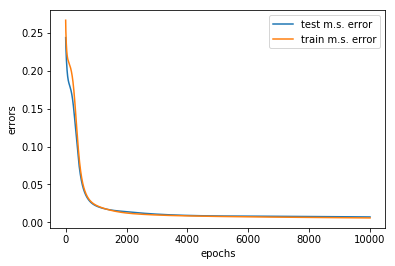

In [255]:
mlp_7 = MLP()
mlp_7.initialize(NI=4, NH=5, NO=1, activation_h=sigmoid, activation_o=linear)
mlp_7.train(X_train, y_train, n_epochs=10000, batch_size=50, learning_rate=0.0025, X_test=X_test, y_test=y_test)

The following cell shows the predictions on the test set

In [281]:
_ = [print("Prediction: %.4f Target: %.4f"%(mlp_7.predict(v[0])[0], v[1][0])) for v in zip(X_test, y_test)]

Prediction: 0.3996 Target: 0.3362
Prediction: 0.7834 Target: 0.7318
Prediction: -0.1736 Target: -0.1297
Prediction: -0.2744 Target: -0.3323
Prediction: -0.6030 Target: -0.5173
Prediction: 0.7328 Target: 0.8943
Prediction: 0.9467 Target: 0.9418
Prediction: -0.5225 Target: -0.4538
Prediction: -0.9706 Target: -1.0000
Prediction: -0.1309 Target: -0.1933
Prediction: -0.9362 Target: -0.9291
Prediction: -0.5034 Target: -0.9577
Prediction: 0.6068 Target: 0.7043
Prediction: -0.8506 Target: -0.9571
Prediction: 0.6600 Target: 0.5916
Prediction: 0.6643 Target: 0.5377
Prediction: 0.1854 Target: 0.1293
Prediction: 0.7136 Target: 0.5101
Prediction: -0.3056 Target: -0.2799
Prediction: -0.2688 Target: -0.1957
Prediction: 0.1429 Target: 0.0608
Prediction: 0.4437 Target: 0.4366
Prediction: -0.8586 Target: -0.9541
Prediction: 0.9057 Target: 0.8089
Prediction: 0.6284 Target: 0.5122
Prediction: 0.5929 Target: 0.7329
Prediction: -0.9382 Target: -0.8602
Prediction: -0.9136 Target: -0.9990
Prediction: 0.9382 T

Epoch = 0 MSError= 105.66638767824941
Epoch = 1 MSError= 60.872952553250926
Epoch = 2 MSError= 47.25991689330294
Epoch = 3 MSError= 41.08685664455085
Epoch = 4 MSError= 37.67726705154938
Epoch = 5 MSError= 35.56677226898637
Epoch = 6 MSError= 34.11823671635321
Epoch = 7 MSError= 33.01413349610392
Epoch = 8 MSError= 32.088280827994126
Epoch = 9 MSError= 31.252385310849345
Epoch = 10 MSError= 30.45996781653128
Epoch = 11 MSError= 29.687650338658226
Epoch = 12 MSError= 28.92501690102156
Epoch = 13 MSError= 28.168824749315622
Epoch = 14 MSError= 27.419523230042838
Epoch = 15 MSError= 26.67912777793138
Epoch = 16 MSError= 25.94999377096798
Epoch = 17 MSError= 25.23421320155927
Epoch = 18 MSError= 24.53340946582662
Epoch = 19 MSError= 23.848744472047475
Epoch = 20 MSError= 23.1810076516456
Epoch = 21 MSError= 22.530714179178005
Epoch = 22 MSError= 21.89818288747329
Epoch = 23 MSError= 21.283588751728093
Epoch = 24 MSError= 20.686994962897096
Epoch = 25 MSError= 20.108371816095314
Epoch = 26 

Epoch = 226 MSError= 1.9401679192825783
Epoch = 227 MSError= 1.9344314908810272
Epoch = 228 MSError= 1.9287431931891128
Epoch = 229 MSError= 1.9231023284336655
Epoch = 230 MSError= 1.917508216880526
Epoch = 231 MSError= 1.911960196060777
Epoch = 232 MSError= 1.9064576200362524
Epoch = 233 MSError= 1.9009998587023438
Epoch = 234 MSError= 1.8955862971261752
Epoch = 235 MSError= 1.8902163349183432
Epoch = 236 MSError= 1.8848893856364748
Epoch = 237 MSError= 1.87960487621892
Epoch = 238 MSError= 1.8743622464470415
Epoch = 239 MSError= 1.8691609484345222
Epoch = 240 MSError= 1.86400044614229
Epoch = 241 MSError= 1.858880214917691
Epoch = 242 MSError= 1.8537997410565785
Epoch = 243 MSError= 1.848758521387079
Epoch = 244 MSError= 1.843756062873901
Epoch = 245 MSError= 1.8387918822420035
Epoch = 246 MSError= 1.833865505618605
Epoch = 247 MSError= 1.828976468192518
Epoch = 248 MSError= 1.8241243138898346
Epoch = 249 MSError= 1.8193085950651002
Epoch = 250 MSError= 1.8145288722070816
Epoch = 251

Epoch = 435 MSError= 1.2597632689989318
Epoch = 436 MSError= 1.2574778211906499
Epoch = 437 MSError= 1.2551933673859996
Epoch = 438 MSError= 1.2529099126133956
Epoch = 439 MSError= 1.250627464753134
Epoch = 440 MSError= 1.2483460344937176
Epoch = 441 MSError= 1.2460656352857808
Epoch = 442 MSError= 1.2437862832937336
Epoch = 443 MSError= 1.2415079973452445
Epoch = 444 MSError= 1.2392307988786564
Epoch = 445 MSError= 1.2369547118884854
Epoch = 446 MSError= 1.2346797628691064
Epoch = 447 MSError= 1.2324059807567693
Epoch = 448 MSError= 1.2301333968700834
Epoch = 449 MSError= 1.227862044849085
Epoch = 450 MSError= 1.2255919605930714
Epoch = 451 MSError= 1.2233231821972939
Epoch = 452 MSError= 1.2210557498886836
Epoch = 453 MSError= 1.2187897059607484
Epoch = 454 MSError= 1.216525094707779
Epoch = 455 MSError= 1.2142619623584974
Epoch = 456 MSError= 1.2120003570093159
Epoch = 457 MSError= 1.2097403285573076
Epoch = 458 MSError= 1.2074819286330554
Epoch = 459 MSError= 1.2052252105334882
Epo

Epoch = 643 MSError= 0.8771577896141404
Epoch = 644 MSError= 0.8759552782217814
Epoch = 645 MSError= 0.8747576682793692
Epoch = 646 MSError= 0.8735649207946501
Epoch = 647 MSError= 0.8723769970317534
Epoch = 648 MSError= 0.8711938585173641
Epoch = 649 MSError= 0.8700154670465124
Epoch = 650 MSError= 0.8688417846879892
Epoch = 651 MSError= 0.867672773789389
Epoch = 652 MSError= 0.8665083969818116
Epoch = 653 MSError= 0.8653486171842013
Epoch = 654 MSError= 0.8641933976073697
Epoch = 655 MSError= 0.8630427017576754
Epoch = 656 MSError= 0.8618964934404106
Epoch = 657 MSError= 0.860754736762857
Epoch = 658 MSError= 0.8596173961370747
Epoch = 659 MSError= 0.8584844362823763
Epoch = 660 MSError= 0.8573558222275584
Epoch = 661 MSError= 0.8562315193128386
Epoch = 662 MSError= 0.8551114931915483
Epoch = 663 MSError= 0.8539957098315802
Epoch = 664 MSError= 0.8528841355165985
Epoch = 665 MSError= 0.8517767368470056
Epoch = 666 MSError= 0.85067348074071
Epoch = 667 MSError= 0.8495743344336667
Epoc

Epoch = 852 MSError= 0.6943290553081048
Epoch = 853 MSError= 0.693673196309681
Epoch = 854 MSError= 0.6930187854810618
Epoch = 855 MSError= 0.6923658172758292
Epoch = 856 MSError= 0.6917142861826949
Epoch = 857 MSError= 0.6910641867251315
Epoch = 858 MSError= 0.6904155134609912
Epoch = 859 MSError= 0.6897682609821367
Epoch = 860 MSError= 0.6891224239140797
Epoch = 861 MSError= 0.688477996915614
Epoch = 862 MSError= 0.687834974678468
Epoch = 863 MSError= 0.6871933519269481
Epoch = 864 MSError= 0.6865531234175927
Epoch = 865 MSError= 0.6859142839388308
Epoch = 866 MSError= 0.6852768283106481
Epoch = 867 MSError= 0.6846407513842422
Epoch = 868 MSError= 0.6840060480417064
Epoch = 869 MSError= 0.6833727131956956
Epoch = 870 MSError= 0.6827407417891014
Epoch = 871 MSError= 0.6821101287947481
Epoch = 872 MSError= 0.6814808692150631
Epoch = 873 MSError= 0.6808529580817777
Epoch = 874 MSError= 0.6802263904556135
Epoch = 875 MSError= 0.6796011614259847
Epoch = 876 MSError= 0.6789772661106939
Epo

Epoch = 1062 MSError= 0.5818248183792962
Epoch = 1063 MSError= 0.5813845142639568
Epoch = 1064 MSError= 0.5809448997422755
Epoch = 1065 MSError= 0.58050597192625
Epoch = 1066 MSError= 0.5800677279255086
Epoch = 1067 MSError= 0.5796301648471833
Epoch = 1068 MSError= 0.5791932797958023
Epoch = 1069 MSError= 0.5787570698731627
Epoch = 1070 MSError= 0.5783215321782144
Epoch = 1071 MSError= 0.5778866638069403
Epoch = 1072 MSError= 0.577452461852242
Epoch = 1073 MSError= 0.5770189234038146
Epoch = 1074 MSError= 0.5765860455480267
Epoch = 1075 MSError= 0.5761538253678082
Epoch = 1076 MSError= 0.5757222599425225
Epoch = 1077 MSError= 0.5752913463478522
Epoch = 1078 MSError= 0.5748610816556767
Epoch = 1079 MSError= 0.5744314629339522
Epoch = 1080 MSError= 0.5740024872465909
Epoch = 1081 MSError= 0.5735741516533398
Epoch = 1082 MSError= 0.5731464532096645
Epoch = 1083 MSError= 0.5727193889666224
Epoch = 1084 MSError= 0.5722929559707441
Epoch = 1085 MSError= 0.571867151263912
Epoch = 1086 MSError

Epoch = 1270 MSError= 0.5002408321064279
Epoch = 1271 MSError= 0.4998683227433179
Epoch = 1272 MSError= 0.4994956507299708
Epoch = 1273 MSError= 0.4991228096622987
Epoch = 1274 MSError= 0.4987497931057594
Epoch = 1275 MSError= 0.49837659459539935
Epoch = 1276 MSError= 0.4980032076359197
Epoch = 1277 MSError= 0.49762962570173713
Epoch = 1278 MSError= 0.49725584223706387
Epoch = 1279 MSError= 0.4968818506559976
Epoch = 1280 MSError= 0.49650764434261435
Epoch = 1281 MSError= 0.4961332166510851
Epoch = 1282 MSError= 0.4957585609057872
Epoch = 1283 MSError= 0.49538367040144327
Epoch = 1284 MSError= 0.49500853840326015
Epoch = 1285 MSError= 0.49463315814708714
Epoch = 1286 MSError= 0.4942575228395797
Epoch = 1287 MSError= 0.4938816256583859
Epoch = 1288 MSError= 0.4935054597523368
Epoch = 1289 MSError= 0.4931290182416549
Epoch = 1290 MSError= 0.4927522942181736
Epoch = 1291 MSError= 0.4923752807455793
Epoch = 1292 MSError= 0.4919979708596512
Epoch = 1293 MSError= 0.4916203575685367
Epoch = 1

Epoch = 1476 MSError= 0.41085923484178555
Epoch = 1477 MSError= 0.4103436560429884
Epoch = 1478 MSError= 0.4098277174603396
Epoch = 1479 MSError= 0.4093114382234804
Epoch = 1480 MSError= 0.4087948376366754
Epoch = 1481 MSError= 0.4082779351704214
Epoch = 1482 MSError= 0.4077607504528799
Epoch = 1483 MSError= 0.4072433032611171
Epoch = 1484 MSError= 0.40672561351218217
Epoch = 1485 MSError= 0.4062077012540128
Epoch = 1486 MSError= 0.4056895866561928
Epoch = 1487 MSError= 0.4051712900005534
Epoch = 1488 MSError= 0.40465283167165833
Epoch = 1489 MSError= 0.40413423214713584
Epoch = 1490 MSError= 0.4036155119879147
Epoch = 1491 MSError= 0.4030966918283483
Epoch = 1492 MSError= 0.40257779236624125
Epoch = 1493 MSError= 0.4020588343527915
Epoch = 1494 MSError= 0.4015398385824641
Epoch = 1495 MSError= 0.40102082588279975
Epoch = 1496 MSError= 0.40050181710417293
Epoch = 1497 MSError= 0.39998283310951366
Epoch = 1498 MSError= 0.39946389476400196
Epoch = 1499 MSError= 0.39894502292474643
Epoch 

Epoch = 1686 MSError= 0.31566801744742073
Epoch = 1687 MSError= 0.31530964754863094
Epoch = 1688 MSError= 0.31495206139078935
Epoch = 1689 MSError= 0.3145952561873749
Epoch = 1690 MSError= 0.3142392291732823
Epoch = 1691 MSError= 0.3138839776047048
Epoch = 1692 MSError= 0.3135294987589982
Epoch = 1693 MSError= 0.313175789934551
Epoch = 1694 MSError= 0.3128228484506351
Epoch = 1695 MSError= 0.3124706716472632
Epoch = 1696 MSError= 0.312119256885027
Epoch = 1697 MSError= 0.31176860154493924
Epoch = 1698 MSError= 0.31141870302826563
Epoch = 1699 MSError= 0.31106955875635744
Epoch = 1700 MSError= 0.3107211661704729
Epoch = 1701 MSError= 0.3103735227315997
Epoch = 1702 MSError= 0.310026625920275
Epoch = 1703 MSError= 0.30968047323639447
Epoch = 1704 MSError= 0.3093350621990281
Epoch = 1705 MSError= 0.30899039034622894
Epoch = 1706 MSError= 0.30864645523483664
Epoch = 1707 MSError= 0.3083032544402846
Epoch = 1708 MSError= 0.3079607855564011
Epoch = 1709 MSError= 0.30761904619521346
Epoch = 1

Epoch = 1891 MSError= 0.2557026938393453
Epoch = 1892 MSError= 0.255465698472201
Epoch = 1893 MSError= 0.25522915559833065
Epoch = 1894 MSError= 0.2549930641717131
Epoch = 1895 MSError= 0.2547574231493086
Epoch = 1896 MSError= 0.2545222314910499
Epoch = 1897 MSError= 0.25428748815982727
Epoch = 1898 MSError= 0.25405319212147637
Epoch = 1899 MSError= 0.2538193423447677
Epoch = 1900 MSError= 0.2535859378013925
Epoch = 1901 MSError= 0.2533529774659525
Epoch = 1902 MSError= 0.25312046031594687
Epoch = 1903 MSError= 0.2528883853317617
Epoch = 1904 MSError= 0.2526567514966583
Epoch = 1905 MSError= 0.2524255577967595
Epoch = 1906 MSError= 0.2521948032210415
Epoch = 1907 MSError= 0.2519644867613216
Epoch = 1908 MSError= 0.25173460741224607
Epoch = 1909 MSError= 0.2515051641712795
Epoch = 1910 MSError= 0.25127615603869574
Epoch = 1911 MSError= 0.251047582017565
Epoch = 1912 MSError= 0.25081944111374205
Epoch = 1913 MSError= 0.2505917323358602
Epoch = 1914 MSError= 0.2503644546953158
Epoch = 191

Epoch = 2098 MSError= 0.21496060303322903
Epoch = 2099 MSError= 0.21479862266250885
Epoch = 2100 MSError= 0.21463692894337763
Epoch = 2101 MSError= 0.21447552127307126
Epoch = 2102 MSError= 0.21431439905034932
Epoch = 2103 MSError= 0.21415356167549093
Epoch = 2104 MSError= 0.21399300855028894
Epoch = 2105 MSError= 0.21383273907804662
Epoch = 2106 MSError= 0.21367275266357216
Epoch = 2107 MSError= 0.21351304871317348
Epoch = 2108 MSError= 0.21335362663465612
Epoch = 2109 MSError= 0.2131944858373172
Epoch = 2110 MSError= 0.21303562573194118
Epoch = 2111 MSError= 0.21287704573079322
Epoch = 2112 MSError= 0.21271874524761977
Epoch = 2113 MSError= 0.21256072369763943
Epoch = 2114 MSError= 0.21240298049754064
Epoch = 2115 MSError= 0.2122455150654782
Epoch = 2116 MSError= 0.21208832682106588
Epoch = 2117 MSError= 0.21193141518537376
Epoch = 2118 MSError= 0.21177477958092572
Epoch = 2119 MSError= 0.21161841943169105
Epoch = 2120 MSError= 0.21146233416308513
Epoch = 2121 MSError= 0.211306523201

Epoch = 2304 MSError= 0.18687871885391652
Epoch = 2305 MSError= 0.186764954880116
Epoch = 2306 MSError= 0.18665137994602984
Epoch = 2307 MSError= 0.18653799368446483
Epoch = 2308 MSError= 0.18642479572906395
Epoch = 2309 MSError= 0.18631178571430682
Epoch = 2310 MSError= 0.18619896327550553
Epoch = 2311 MSError= 0.18608632804880262
Epoch = 2312 MSError= 0.18597387967116918
Epoch = 2313 MSError= 0.18586161778040222
Epoch = 2314 MSError= 0.185749542015122
Epoch = 2315 MSError= 0.18563765201477164
Epoch = 2316 MSError= 0.18552594741961223
Epoch = 2317 MSError= 0.1854144278707224
Epoch = 2318 MSError= 0.18530309300999534
Epoch = 2319 MSError= 0.18519194248013704
Epoch = 2320 MSError= 0.18508097592466283
Epoch = 2321 MSError= 0.18497019298789627
Epoch = 2322 MSError= 0.1848595933149679
Epoch = 2323 MSError= 0.18474917655181144
Epoch = 2324 MSError= 0.18463894234516112
Epoch = 2325 MSError= 0.18452889034254943
Epoch = 2326 MSError= 0.18441902019230882
Epoch = 2327 MSError= 0.1843093315435642

Epoch = 2511 MSError= 0.1668810539671903
Epoch = 2512 MSError= 0.16679966071801638
Epoch = 2513 MSError= 0.1667183954711953
Epoch = 2514 MSError= 0.16663725799279705
Epoch = 2515 MSError= 0.1665562480493757
Epoch = 2516 MSError= 0.16647536540797261
Epoch = 2517 MSError= 0.1663946098361119
Epoch = 2518 MSError= 0.1663139811018009
Epoch = 2519 MSError= 0.16623347897352964
Epoch = 2520 MSError= 0.1661531032202652
Epoch = 2521 MSError= 0.16607285361145838
Epoch = 2522 MSError= 0.16599272991703412
Epoch = 2523 MSError= 0.16591273190739764
Epoch = 2524 MSError= 0.16583285935342643
Epoch = 2525 MSError= 0.16575311202647605
Epoch = 2526 MSError= 0.16567348969837273
Epoch = 2527 MSError= 0.16559399214141557
Epoch = 2528 MSError= 0.16551461912837578
Epoch = 2529 MSError= 0.16543537043249246
Epoch = 2530 MSError= 0.16535624582747518
Epoch = 2531 MSError= 0.16527724508750066
Epoch = 2532 MSError= 0.1651983679872109
Epoch = 2533 MSError= 0.165119614301715
Epoch = 2534 MSError= 0.16504098380658463
E

Epoch = 2714 MSError= 0.15269171678077936
Epoch = 2715 MSError= 0.15263210598119623
Epoch = 2716 MSError= 0.15257258423095868
Epoch = 2717 MSError= 0.15251315137438168
Epoch = 2718 MSError= 0.15245380725608088
Epoch = 2719 MSError= 0.15239455172097338
Epoch = 2720 MSError= 0.15233538461427593
Epoch = 2721 MSError= 0.15227630578150575
Epoch = 2722 MSError= 0.15221731506847605
Epoch = 2723 MSError= 0.1521584123213008
Epoch = 2724 MSError= 0.1520995973863901
Epoch = 2725 MSError= 0.15204087011045056
Epoch = 2726 MSError= 0.15198223034048494
Epoch = 2727 MSError= 0.15192367792379233
Epoch = 2728 MSError= 0.1518652127079644
Epoch = 2729 MSError= 0.15180683454088995
Epoch = 2730 MSError= 0.15174854327074785
Epoch = 2731 MSError= 0.15169033874601118
Epoch = 2732 MSError= 0.15163222081544628
Epoch = 2733 MSError= 0.1515741893281081
Epoch = 2734 MSError= 0.1515162441333457
Epoch = 2735 MSError= 0.1514583850807952
Epoch = 2736 MSError= 0.1514006120203851
Epoch = 2737 MSError= 0.15134292480232941

Epoch = 2917 MSError= 0.1422216414110424
Epoch = 2918 MSError= 0.1421772876974045
Epoch = 2919 MSError= 0.14213299679063773
Epoch = 2920 MSError= 0.1420887685845333
Epoch = 2921 MSError= 0.14204460297307506
Epoch = 2922 MSError= 0.14200049985044366
Epoch = 2923 MSError= 0.14195645911101265
Epoch = 2924 MSError= 0.14191248064934897
Epoch = 2925 MSError= 0.14186856436021264
Epoch = 2926 MSError= 0.14182471013855694
Epoch = 2927 MSError= 0.1417809178795277
Epoch = 2928 MSError= 0.1417371874784615
Epoch = 2929 MSError= 0.14169351883088824
Epoch = 2930 MSError= 0.14164991183252734
Epoch = 2931 MSError= 0.14160636637928964
Epoch = 2932 MSError= 0.14156288236727727
Epoch = 2933 MSError= 0.14151945969278082
Epoch = 2934 MSError= 0.14147609825228138
Epoch = 2935 MSError= 0.14143279794244937
Epoch = 2936 MSError= 0.1413895586601436
Epoch = 2937 MSError= 0.14134638030241167
Epoch = 2938 MSError= 0.14130326276648927
Epoch = 2939 MSError= 0.14126020594979824
Epoch = 2940 MSError= 0.1412172097499509

Epoch = 3113 MSError= 0.1346080599942774
Epoch = 3114 MSError= 0.13457420552926946
Epoch = 3115 MSError= 0.13454039633165799
Epoch = 3116 MSError= 0.13450663232678325
Epoch = 3117 MSError= 0.1344729134401172
Epoch = 3118 MSError= 0.13443923959726292
Epoch = 3119 MSError= 0.13440561072395396
Epoch = 3120 MSError= 0.13437202674605556
Epoch = 3121 MSError= 0.13433848758956377
Epoch = 3122 MSError= 0.13430499318060404
Epoch = 3123 MSError= 0.13427154344543293
Epoch = 3124 MSError= 0.1342381383104358
Epoch = 3125 MSError= 0.13420477770212808
Epoch = 3126 MSError= 0.13417146154715578
Epoch = 3127 MSError= 0.1341381897722921
Epoch = 3128 MSError= 0.13410496230443986
Epoch = 3129 MSError= 0.13407177907063092
Epoch = 3130 MSError= 0.13403863999802437
Epoch = 3131 MSError= 0.13400554501390885
Epoch = 3132 MSError= 0.13397249404569933
Epoch = 3133 MSError= 0.1339394870209403
Epoch = 3134 MSError= 0.13390652386730176
Epoch = 3135 MSError= 0.1338736045125817
Epoch = 3136 MSError= 0.1338407288847053

Epoch = 3316 MSError= 0.12856955196336467
Epoch = 3317 MSError= 0.12854352075503045
Epoch = 3318 MSError= 0.1285175220418213
Epoch = 3319 MSError= 0.12849155577125673
Epoch = 3320 MSError= 0.1284656218909463
Epoch = 3321 MSError= 0.12843972034858747
Epoch = 3322 MSError= 0.1284138510919695
Epoch = 3323 MSError= 0.12838801406896938
Epoch = 3324 MSError= 0.12836220922755348
Epoch = 3325 MSError= 0.12833643651577642
Epoch = 3326 MSError= 0.12831069588178376
Epoch = 3327 MSError= 0.128284987273806
Epoch = 3328 MSError= 0.12825931064016635
Epoch = 3329 MSError= 0.12823366592927146
Epoch = 3330 MSError= 0.12820805308962038
Epoch = 3331 MSError= 0.12818247206979724
Epoch = 3332 MSError= 0.12815692281847596
Epoch = 3333 MSError= 0.12813140528441636
Epoch = 3334 MSError= 0.1281059194164656
Epoch = 3335 MSError= 0.12808046516356034
Epoch = 3336 MSError= 0.12805504247472146
Epoch = 3337 MSError= 0.12802965129905888
Epoch = 3338 MSError= 0.12800429158576881
Epoch = 3339 MSError= 0.1279789632841334

Epoch = 3528 MSError= 0.12370237066014929
Epoch = 3529 MSError= 0.1236821826404863
Epoch = 3530 MSError= 0.12366201776311087
Epoch = 3531 MSError= 0.12364187599133686
Epoch = 3532 MSError= 0.12362175728854241
Epoch = 3533 MSError= 0.12360166161816365
Epoch = 3534 MSError= 0.12358158894370014
Epoch = 3535 MSError= 0.12356153922871048
Epoch = 3536 MSError= 0.12354151243681538
Epoch = 3537 MSError= 0.12352150853169545
Epoch = 3538 MSError= 0.12350152747709152
Epoch = 3539 MSError= 0.1234815692368065
Epoch = 3540 MSError= 0.12346163377470144
Epoch = 3541 MSError= 0.12344172105469944
Epoch = 3542 MSError= 0.12342183104078197
Epoch = 3543 MSError= 0.12340196369699244
Epoch = 3544 MSError= 0.12338211898743244
Epoch = 3545 MSError= 0.12336229687626449
Epoch = 3546 MSError= 0.12334249732771059
Epoch = 3547 MSError= 0.1233227203060517
Epoch = 3548 MSError= 0.12330296577562871
Epoch = 3549 MSError= 0.12328323370084193
Epoch = 3550 MSError= 0.1232635240461509
Epoch = 3551 MSError= 0.12324383677607

Epoch = 3731 MSError= 0.12003221964790187
Epoch = 3732 MSError= 0.12001605451788484
Epoch = 3733 MSError= 0.11999990620223748
Epoch = 3734 MSError= 0.11998377467473689
Epoch = 3735 MSError= 0.11996765990920225
Epoch = 3736 MSError= 0.11995156187949652
Epoch = 3737 MSError= 0.11993548055952635
Epoch = 3738 MSError= 0.11991941592323858
Epoch = 3739 MSError= 0.11990336794462493
Epoch = 3740 MSError= 0.11988733659771865
Epoch = 3741 MSError= 0.11987132185659656
Epoch = 3742 MSError= 0.11985532369537635
Epoch = 3743 MSError= 0.1198393420882197
Epoch = 3744 MSError= 0.11982337700932931
Epoch = 3745 MSError= 0.11980742843295072
Epoch = 3746 MSError= 0.11979149633337154
Epoch = 3747 MSError= 0.119775580684922
Epoch = 3748 MSError= 0.11975968146197351
Epoch = 3749 MSError= 0.1197437986389394
Epoch = 3750 MSError= 0.11972793219027592
Epoch = 3751 MSError= 0.11971208209048007
Epoch = 3752 MSError= 0.11969624831409074
Epoch = 3753 MSError= 0.1196804308356891
Epoch = 3754 MSError= 0.119664629629897

Epoch = 3936 MSError= 0.11703572402954594
Epoch = 3937 MSError= 0.11702251341986528
Epoch = 3938 MSError= 0.11700931505209793
Epoch = 3939 MSError= 0.11699612890746702
Epoch = 3940 MSError= 0.11698295496722247
Epoch = 3941 MSError= 0.11696979321264649
Epoch = 3942 MSError= 0.116956643625051
Epoch = 3943 MSError= 0.11694350618577834
Epoch = 3944 MSError= 0.11693038087620149
Epoch = 3945 MSError= 0.11691726767772245
Epoch = 3946 MSError= 0.11690416657177441
Epoch = 3947 MSError= 0.11689107753981907
Epoch = 3948 MSError= 0.11687800056334988
Epoch = 3949 MSError= 0.11686493562388936
Epoch = 3950 MSError= 0.11685188270299045
Epoch = 3951 MSError= 0.11683884178223465
Epoch = 3952 MSError= 0.11682581284323477
Epoch = 3953 MSError= 0.11681279586763244
Epoch = 3954 MSError= 0.11679979083709893
Epoch = 3955 MSError= 0.11678679773333603
Epoch = 3956 MSError= 0.11677381653807369
Epoch = 3957 MSError= 0.11676084723307338
Epoch = 3958 MSError= 0.11674788980012386
Epoch = 3959 MSError= 0.116734944221

Epoch = 4146 MSError= 0.11450381032170397
Epoch = 4147 MSError= 0.11449280093867334
Epoch = 4148 MSError= 0.11448180045051201
Epoch = 4149 MSError= 0.1144708088438378
Epoch = 4150 MSError= 0.11445982610529108
Epoch = 4151 MSError= 0.11444885222153305
Epoch = 4152 MSError= 0.11443788717924742
Epoch = 4153 MSError= 0.1144269309651382
Epoch = 4154 MSError= 0.11441598356593152
Epoch = 4155 MSError= 0.11440504496837452
Epoch = 4156 MSError= 0.11439411515923532
Epoch = 4157 MSError= 0.11438319412530457
Epoch = 4158 MSError= 0.11437228185339245
Epoch = 4159 MSError= 0.11436137833033187
Epoch = 4160 MSError= 0.11435048354297636
Epoch = 4161 MSError= 0.11433959747819958
Epoch = 4162 MSError= 0.11432872012289906
Epoch = 4163 MSError= 0.11431785146398976
Epoch = 4164 MSError= 0.11430699148841068
Epoch = 4165 MSError= 0.11429614018312048
Epoch = 4166 MSError= 0.11428529753509907
Epoch = 4167 MSError= 0.11427446353134739
Epoch = 4168 MSError= 0.11426363815888593
Epoch = 4169 MSError= 0.114252821404

Epoch = 4352 MSError= 0.11240595145378272
Epoch = 4353 MSError= 0.11239652041418796
Epoch = 4354 MSError= 0.11238709592172907
Epoch = 4355 MSError= 0.11237767796680585
Epoch = 4356 MSError= 0.11236826653983513
Epoch = 4357 MSError= 0.1123588616312473
Epoch = 4358 MSError= 0.11234946323148828
Epoch = 4359 MSError= 0.1123400713310216
Epoch = 4360 MSError= 0.11233068592032365
Epoch = 4361 MSError= 0.112321306989888
Epoch = 4362 MSError= 0.1123119345302221
Epoch = 4363 MSError= 0.11230256853185018
Epoch = 4364 MSError= 0.11229320898531106
Epoch = 4365 MSError= 0.11228385588115894
Epoch = 4366 MSError= 0.11227450920996294
Epoch = 4367 MSError= 0.11226516896230807
Epoch = 4368 MSError= 0.11225583512879454
Epoch = 4369 MSError= 0.11224650770003745
Epoch = 4370 MSError= 0.11223718666666624
Epoch = 4371 MSError= 0.11222787201932785
Epoch = 4372 MSError= 0.11221856374868164
Epoch = 4373 MSError= 0.11220926184540474
Epoch = 4374 MSError= 0.11219996630018678
Epoch = 4375 MSError= 0.112190677103734

Epoch = 4557 MSError= 0.11059694892386565
Epoch = 4558 MSError= 0.11058867965067794
Epoch = 4559 MSError= 0.11058041524961261
Epoch = 4560 MSError= 0.1105721557137975
Epoch = 4561 MSError= 0.11056390103637317
Epoch = 4562 MSError= 0.11055565121049138
Epoch = 4563 MSError= 0.11054740622931357
Epoch = 4564 MSError= 0.11053916608601469
Epoch = 4565 MSError= 0.11053093077377928
Epoch = 4566 MSError= 0.11052270028580374
Epoch = 4567 MSError= 0.11051447461529612
Epoch = 4568 MSError= 0.11050625375547471
Epoch = 4569 MSError= 0.11049803769956941
Epoch = 4570 MSError= 0.11048982644082243
Epoch = 4571 MSError= 0.11048161997248489
Epoch = 4572 MSError= 0.11047341828782105
Epoch = 4573 MSError= 0.11046522138010507
Epoch = 4574 MSError= 0.11045702924262292
Epoch = 4575 MSError= 0.11044884186867189
Epoch = 4576 MSError= 0.11044065925155866
Epoch = 4577 MSError= 0.11043248138460304
Epoch = 4578 MSError= 0.11042430826113513
Epoch = 4579 MSError= 0.11041613987449575
Epoch = 4580 MSError= 0.11040797621

Epoch = 4760 MSError= 0.10900947439128926
Epoch = 4761 MSError= 0.10900206774125894
Epoch = 4762 MSError= 0.10899466477916622
Epoch = 4763 MSError= 0.10898726550012634
Epoch = 4764 MSError= 0.10897986989926327
Epoch = 4765 MSError= 0.10897247797170807
Epoch = 4766 MSError= 0.10896508971260106
Epoch = 4767 MSError= 0.10895770511709137
Epoch = 4768 MSError= 0.10895032418033543
Epoch = 4769 MSError= 0.10894294689749898
Epoch = 4770 MSError= 0.10893557326375593
Epoch = 4771 MSError= 0.10892820327428752
Epoch = 4772 MSError= 0.1089208369242841
Epoch = 4773 MSError= 0.10891347420894455
Epoch = 4774 MSError= 0.10890611512347531
Epoch = 4775 MSError= 0.10889875966309136
Epoch = 4776 MSError= 0.10889140782301629
Epoch = 4777 MSError= 0.10888405959848176
Epoch = 4778 MSError= 0.10887671498472677
Epoch = 4779 MSError= 0.10886937397700049
Epoch = 4780 MSError= 0.10886203657055751
Epoch = 4781 MSError= 0.10885470276066386
Epoch = 4782 MSError= 0.10884737254259103
Epoch = 4783 MSError= 0.10884004591

Epoch = 4964 MSError= 0.10756862544267995
Epoch = 4965 MSError= 0.10756188088884619
Epoch = 4966 MSError= 0.10755513918457789
Epoch = 4967 MSError= 0.10754840032647636
Epoch = 4968 MSError= 0.10754166431114845
Epoch = 4969 MSError= 0.1075349311352074
Epoch = 4970 MSError= 0.10752820079527348
Epoch = 4971 MSError= 0.1075214732879723
Epoch = 4972 MSError= 0.107514748609937
Epoch = 4973 MSError= 0.1075080267578046
Epoch = 4974 MSError= 0.10750130772822072
Epoch = 4975 MSError= 0.10749459151783633
Epoch = 4976 MSError= 0.10748787812330787
Epoch = 4977 MSError= 0.10748116754129926
Epoch = 4978 MSError= 0.1074744597684795
Epoch = 4979 MSError= 0.10746775480152444
Epoch = 4980 MSError= 0.1074610526371163
Epoch = 4981 MSError= 0.10745435327194272
Epoch = 4982 MSError= 0.10744765670269796
Epoch = 4983 MSError= 0.10744096292608195
Epoch = 4984 MSError= 0.10743427193880165
Epoch = 4985 MSError= 0.10742758373756964
Epoch = 4986 MSError= 0.10742089831910444
Epoch = 4987 MSError= 0.10741421568013054

Epoch = 5167 MSError= 0.10625364449833617
Epoch = 5168 MSError= 0.10624741676602004
Epoch = 5169 MSError= 0.10624119131068537
Epoch = 5170 MSError= 0.10623496813004321
Epoch = 5171 MSError= 0.10622874722180915
Epoch = 5172 MSError= 0.10622252858370429
Epoch = 5173 MSError= 0.10621631221345249
Epoch = 5174 MSError= 0.10621009810878448
Epoch = 5175 MSError= 0.10620388626743459
Epoch = 5176 MSError= 0.10619767668714129
Epoch = 5177 MSError= 0.10619146936565034
Epoch = 5178 MSError= 0.1061852643007085
Epoch = 5179 MSError= 0.1061790614900706
Epoch = 5180 MSError= 0.10617286093149335
Epoch = 5181 MSError= 0.10616666262273979
Epoch = 5182 MSError= 0.10616046656157713
Epoch = 5183 MSError= 0.1061542727457781
Epoch = 5184 MSError= 0.106148081173118
Epoch = 5185 MSError= 0.1061418918413781
Epoch = 5186 MSError= 0.10613570474834552
Epoch = 5187 MSError= 0.10612951989180933
Epoch = 5188 MSError= 0.10612333726956538
Epoch = 5189 MSError= 0.10611715687941295
Epoch = 5190 MSError= 0.1061109787191562

Epoch = 5370 MSError= 0.10503326276576469
Epoch = 5371 MSError= 0.10502745639215043
Epoch = 5372 MSError= 0.10502165191926616
Epoch = 5373 MSError= 0.10501584934565797
Epoch = 5374 MSError= 0.10501004866987537
Epoch = 5375 MSError= 0.1050042498904721
Epoch = 5376 MSError= 0.1049984530060054
Epoch = 5377 MSError= 0.10499265801503516
Epoch = 5378 MSError= 0.10498686491612576
Epoch = 5379 MSError= 0.10498107370784447
Epoch = 5380 MSError= 0.10497528438876201
Epoch = 5381 MSError= 0.10496949695745358
Epoch = 5382 MSError= 0.10496371141249711
Epoch = 5383 MSError= 0.10495792775247316
Epoch = 5384 MSError= 0.10495214597596789
Epoch = 5385 MSError= 0.10494636608156913
Epoch = 5386 MSError= 0.10494058806786913
Epoch = 5387 MSError= 0.10493481193346323
Epoch = 5388 MSError= 0.10492903767695025
Epoch = 5389 MSError= 0.10492326529693344
Epoch = 5390 MSError= 0.10491749479201756
Epoch = 5391 MSError= 0.10491172616081255
Epoch = 5392 MSError= 0.10490595940193087
Epoch = 5393 MSError= 0.104900194513

Epoch = 5577 MSError= 0.10386999939478025
Epoch = 5578 MSError= 0.10386456027689205
Epoch = 5579 MSError= 0.10385912282729881
Epoch = 5580 MSError= 0.10385368704517906
Epoch = 5581 MSError= 0.10384825292971307
Epoch = 5582 MSError= 0.10384282048008377
Epoch = 5583 MSError= 0.10383738969547664
Epoch = 5584 MSError= 0.10383196057508019
Epoch = 5585 MSError= 0.10382653311808505
Epoch = 5586 MSError= 0.10382110732368523
Epoch = 5587 MSError= 0.1038156831910759
Epoch = 5588 MSError= 0.10381026071945523
Epoch = 5589 MSError= 0.10380483990802539
Epoch = 5590 MSError= 0.10379942075598936
Epoch = 5591 MSError= 0.10379400326255284
Epoch = 5592 MSError= 0.10378858742692527
Epoch = 5593 MSError= 0.10378317324831711
Epoch = 5594 MSError= 0.10377776072594236
Epoch = 5595 MSError= 0.10377234985901784
Epoch = 5596 MSError= 0.10376694064676138
Epoch = 5597 MSError= 0.1037615330883949
Epoch = 5598 MSError= 0.10375612718314181
Epoch = 5599 MSError= 0.10375072293022854
Epoch = 5600 MSError= 0.103745320328

Epoch = 5787 MSError= 0.10276333486188444
Epoch = 5788 MSError= 0.10275823165903969
Epoch = 5789 MSError= 0.10275313000245916
Epoch = 5790 MSError= 0.1027480298917766
Epoch = 5791 MSError= 0.10274293132662767
Epoch = 5792 MSError= 0.10273783430664958
Epoch = 5793 MSError= 0.10273273883148044
Epoch = 5794 MSError= 0.10272764490076278
Epoch = 5795 MSError= 0.10272255251413741
Epoch = 5796 MSError= 0.10271746167124912
Epoch = 5797 MSError= 0.1027123723717445
Epoch = 5798 MSError= 0.10270728461527054
Epoch = 5799 MSError= 0.10270219840147725
Epoch = 5800 MSError= 0.10269711373001571
Epoch = 5801 MSError= 0.10269203060053911
Epoch = 5802 MSError= 0.10268694901270174
Epoch = 5803 MSError= 0.102681868966161
Epoch = 5804 MSError= 0.10267679046057399
Epoch = 5805 MSError= 0.1026717134956012
Epoch = 5806 MSError= 0.10266663807090427
Epoch = 5807 MSError= 0.10266156418614625
Epoch = 5808 MSError= 0.10265649184099283
Epoch = 5809 MSError= 0.1026514210351101
Epoch = 5810 MSError= 0.1026463517681668

Epoch = 5996 MSError= 0.10172995163826351
Epoch = 5997 MSError= 0.10172516603463719
Epoch = 5998 MSError= 0.10172038193409963
Epoch = 5999 MSError= 0.1017155993365806
Epoch = 6000 MSError= 0.10171081824201281
Epoch = 6001 MSError= 0.10170603865032773
Epoch = 6002 MSError= 0.10170126056145909
Epoch = 6003 MSError= 0.1016964839753416
Epoch = 6004 MSError= 0.10169170889191062
Epoch = 6005 MSError= 0.10168693531110334
Epoch = 6006 MSError= 0.10168216323285706
Epoch = 6007 MSError= 0.10167739265711101
Epoch = 6008 MSError= 0.10167262358380488
Epoch = 6009 MSError= 0.10166785601287925
Epoch = 6010 MSError= 0.10166308994427699
Epoch = 6011 MSError= 0.10165832537794083
Epoch = 6012 MSError= 0.10165356231381378
Epoch = 6013 MSError= 0.10164880075184207
Epoch = 6014 MSError= 0.10164404069197153
Epoch = 6015 MSError= 0.10163928213414922
Epoch = 6016 MSError= 0.10163452507832364
Epoch = 6017 MSError= 0.10162976952444341
Epoch = 6018 MSError= 0.10162501547245936
Epoch = 6019 MSError= 0.101620262922

Epoch = 6204 MSError= 0.10076687368091707
Epoch = 6205 MSError= 0.10076240058050907
Epoch = 6206 MSError= 0.10075792898740304
Epoch = 6207 MSError= 0.10075345890168867
Epoch = 6208 MSError= 0.10074899032345574
Epoch = 6209 MSError= 0.10074452325279579
Epoch = 6210 MSError= 0.10074005768979967
Epoch = 6211 MSError= 0.10073559363455875
Epoch = 6212 MSError= 0.10073113108716596
Epoch = 6213 MSError= 0.10072667004771346
Epoch = 6214 MSError= 0.10072221051629415
Epoch = 6215 MSError= 0.10071775249300163
Epoch = 6216 MSError= 0.10071329597793037
Epoch = 6217 MSError= 0.10070884097117373
Epoch = 6218 MSError= 0.10070438747282784
Epoch = 6219 MSError= 0.10069993548298681
Epoch = 6220 MSError= 0.10069548500174696
Epoch = 6221 MSError= 0.10069103602920414
Epoch = 6222 MSError= 0.10068658856545484
Epoch = 6223 MSError= 0.10068214261059664
Epoch = 6224 MSError= 0.10067769816472659
Epoch = 6225 MSError= 0.10067325522794195
Epoch = 6226 MSError= 0.1006688138003418
Epoch = 6227 MSError= 0.10066437388

Epoch = 6407 MSError= 0.09988988668179162
Epoch = 6408 MSError= 0.09988572186419747
Epoch = 6409 MSError= 0.09988155857808372
Epoch = 6410 MSError= 0.09987739682358132
Epoch = 6411 MSError= 0.09987323660082133
Epoch = 6412 MSError= 0.09986907790993409
Epoch = 6413 MSError= 0.09986492075105076
Epoch = 6414 MSError= 0.09986076512430218
Epoch = 6415 MSError= 0.09985661102981942
Epoch = 6416 MSError= 0.09985245846773312
Epoch = 6417 MSError= 0.09984830743817344
Epoch = 6418 MSError= 0.09984415794127151
Epoch = 6419 MSError= 0.09984000997715758
Epoch = 6420 MSError= 0.09983586354596206
Epoch = 6421 MSError= 0.09983171864781526
Epoch = 6422 MSError= 0.09982757528284802
Epoch = 6423 MSError= 0.09982343345118952
Epoch = 6424 MSError= 0.0998192931529705
Epoch = 6425 MSError= 0.09981515438832139
Epoch = 6426 MSError= 0.09981101715737165
Epoch = 6427 MSError= 0.09980688146025095
Epoch = 6428 MSError= 0.09980274729708946
Epoch = 6429 MSError= 0.09979861466801689
Epoch = 6430 MSError= 0.09979448357

Epoch = 6607 MSError= 0.09908756272029018
Epoch = 6608 MSError= 0.09908370659463454
Epoch = 6609 MSError= 0.09907985202273889
Epoch = 6610 MSError= 0.09907599900468086
Epoch = 6611 MSError= 0.0990721475405374
Epoch = 6612 MSError= 0.0990682976303847
Epoch = 6613 MSError= 0.09906444927430018
Epoch = 6614 MSError= 0.09906060247235701
Epoch = 6615 MSError= 0.0990567572246327
Epoch = 6616 MSError= 0.09905291353120084
Epoch = 6617 MSError= 0.09904907139213477
Epoch = 6618 MSError= 0.09904523080750927
Epoch = 6619 MSError= 0.09904139177739707
Epoch = 6620 MSError= 0.09903755430187067
Epoch = 6621 MSError= 0.09903371838100294
Epoch = 6622 MSError= 0.09902988401486504
Epoch = 6623 MSError= 0.09902605120352806
Epoch = 6624 MSError= 0.09902221994706256
Epoch = 6625 MSError= 0.09901839024553964
Epoch = 6626 MSError= 0.09901456209902826
Epoch = 6627 MSError= 0.0990107355075978
Epoch = 6628 MSError= 0.0990069104713167
Epoch = 6629 MSError= 0.0990030869902536
Epoch = 6630 MSError= 0.0989992650644765

Epoch = 6814 MSError= 0.09832254512632568
Epoch = 6815 MSError= 0.09831901146872095
Epoch = 6816 MSError= 0.09831547936845252
Epoch = 6817 MSError= 0.09831194882546554
Epoch = 6818 MSError= 0.09830841983970498
Epoch = 6819 MSError= 0.0983048924111157
Epoch = 6820 MSError= 0.09830136653964065
Epoch = 6821 MSError= 0.09829784222522253
Epoch = 6822 MSError= 0.09829431946780337
Epoch = 6823 MSError= 0.09829079826732427
Epoch = 6824 MSError= 0.09828727862372524
Epoch = 6825 MSError= 0.09828376053694617
Epoch = 6826 MSError= 0.09828024400692566
Epoch = 6827 MSError= 0.09827672903360167
Epoch = 6828 MSError= 0.09827321561691214
Epoch = 6829 MSError= 0.09826970375679216
Epoch = 6830 MSError= 0.0982661934531778
Epoch = 6831 MSError= 0.09826268470600423
Epoch = 6832 MSError= 0.0982591775152052
Epoch = 6833 MSError= 0.09825567188071409
Epoch = 6834 MSError= 0.09825216780246228
Epoch = 6835 MSError= 0.09824866528038304
Epoch = 6836 MSError= 0.09824516431440652
Epoch = 6837 MSError= 0.0982416649044

Epoch = 7020 MSError= 0.09762735739468126
Epoch = 7021 MSError= 0.09762414221726648
Epoch = 7022 MSError= 0.09762092856829091
Epoch = 7023 MSError= 0.09761771644752182
Epoch = 7024 MSError= 0.09761450585472653
Epoch = 7025 MSError= 0.09761129678967101
Epoch = 7026 MSError= 0.09760808925212054
Epoch = 7027 MSError= 0.0976048832418394
Epoch = 7028 MSError= 0.09760167875859055
Epoch = 7029 MSError= 0.09759847580213685
Epoch = 7030 MSError= 0.09759527437223936
Epoch = 7031 MSError= 0.09759207446865921
Epoch = 7032 MSError= 0.09758887609115519
Epoch = 7033 MSError= 0.09758567923948674
Epoch = 7034 MSError= 0.09758248391341119
Epoch = 7035 MSError= 0.09757929011268586
Epoch = 7036 MSError= 0.09757609783706646
Epoch = 7037 MSError= 0.09757290708630796
Epoch = 7038 MSError= 0.09756971786016491
Epoch = 7039 MSError= 0.09756653015838937
Epoch = 7040 MSError= 0.09756334398073517
Epoch = 7041 MSError= 0.09756015932695183
Epoch = 7042 MSError= 0.09755697619679154
Epoch = 7043 MSError= 0.09755379459

Epoch = 7223 MSError= 0.09700563174145362
Epoch = 7224 MSError= 0.09700272081126635
Epoch = 7225 MSError= 0.0969998113435249
Epoch = 7226 MSError= 0.096996903337812
Epoch = 7227 MSError= 0.09699399679370863
Epoch = 7228 MSError= 0.09699109171079559
Epoch = 7229 MSError= 0.09698818808865213
Epoch = 7230 MSError= 0.09698528592685848
Epoch = 7231 MSError= 0.09698238522499086
Epoch = 7232 MSError= 0.09697948598262744
Epoch = 7233 MSError= 0.09697658819934385
Epoch = 7234 MSError= 0.09697369187471551
Epoch = 7235 MSError= 0.09697079700831704
Epoch = 7236 MSError= 0.09696790359972206
Epoch = 7237 MSError= 0.09696501164850256
Epoch = 7238 MSError= 0.09696212115423086
Epoch = 7239 MSError= 0.0969592321164781
Epoch = 7240 MSError= 0.09695634453481379
Epoch = 7241 MSError= 0.09695345840880773
Epoch = 7242 MSError= 0.09695057373802778
Epoch = 7243 MSError= 0.09694769052204202
Epoch = 7244 MSError= 0.09694480876041646
Epoch = 7245 MSError= 0.09694192845271649
Epoch = 7246 MSError= 0.09693904959850

Epoch = 7435 MSError= 0.09642050023447579
Epoch = 7436 MSError= 0.09641788868623632
Epoch = 7437 MSError= 0.09641527849347274
Epoch = 7438 MSError= 0.09641266965559968
Epoch = 7439 MSError= 0.09641006217203159
Epoch = 7440 MSError= 0.09640745604218245
Epoch = 7441 MSError= 0.09640485126546557
Epoch = 7442 MSError= 0.09640224784129257
Epoch = 7443 MSError= 0.09639964576907546
Epoch = 7444 MSError= 0.09639704504822544
Epoch = 7445 MSError= 0.09639444567815265
Epoch = 7446 MSError= 0.0963918476582671
Epoch = 7447 MSError= 0.09638925098797702
Epoch = 7448 MSError= 0.09638665566669176
Epoch = 7449 MSError= 0.09638406169381816
Epoch = 7450 MSError= 0.0963814690687645
Epoch = 7451 MSError= 0.09637887779093589
Epoch = 7452 MSError= 0.09637628785973845
Epoch = 7453 MSError= 0.09637369927457734
Epoch = 7454 MSError= 0.0963711120348569
Epoch = 7455 MSError= 0.09636852613998093
Epoch = 7456 MSError= 0.09636594158935309
Epoch = 7457 MSError= 0.0963633583823749
Epoch = 7458 MSError= 0.09636077651844

Epoch = 7642 MSError= 0.09590791159147961
Epoch = 7643 MSError= 0.09590556727384306
Epoch = 7644 MSError= 0.09590322417822725
Epoch = 7645 MSError= 0.09590088230393745
Epoch = 7646 MSError= 0.09589854165027809
Epoch = 7647 MSError= 0.09589620221655454
Epoch = 7648 MSError= 0.09589386400207106
Epoch = 7649 MSError= 0.09589152700613082
Epoch = 7650 MSError= 0.0958891912280375
Epoch = 7651 MSError= 0.09588685666709448
Epoch = 7652 MSError= 0.095884523322604
Epoch = 7653 MSError= 0.09588219119386895
Epoch = 7654 MSError= 0.09587986028019094
Epoch = 7655 MSError= 0.09587753058087174
Epoch = 7656 MSError= 0.09587520209521258
Epoch = 7657 MSError= 0.09587287482251414
Epoch = 7658 MSError= 0.09587054876207743
Epoch = 7659 MSError= 0.09586822391320242
Epoch = 7660 MSError= 0.0958659002751891
Epoch = 7661 MSError= 0.0958635778473364
Epoch = 7662 MSError= 0.09586125662894393
Epoch = 7663 MSError= 0.09585893661931033
Epoch = 7664 MSError= 0.09585661781773473
Epoch = 7665 MSError= 0.095854300223513

Epoch = 7850 MSError= 0.0954455505074832
Epoch = 7851 MSError= 0.09544344497494021
Epoch = 7852 MSError= 0.09544134051408218
Epoch = 7853 MSError= 0.09543923712416959
Epoch = 7854 MSError= 0.09543713480446142
Epoch = 7855 MSError= 0.09543503355421747
Epoch = 7856 MSError= 0.0954329333726981
Epoch = 7857 MSError= 0.09543083425916123
Epoch = 7858 MSError= 0.09542873621286733
Epoch = 7859 MSError= 0.09542663923307557
Epoch = 7860 MSError= 0.09542454331904589
Epoch = 7861 MSError= 0.09542244847003654
Epoch = 7862 MSError= 0.09542035468530757
Epoch = 7863 MSError= 0.09541826196411717
Epoch = 7864 MSError= 0.0954161703057253
Epoch = 7865 MSError= 0.09541407970939086
Epoch = 7866 MSError= 0.0954119901743728
Epoch = 7867 MSError= 0.09540990169992965
Epoch = 7868 MSError= 0.09540781428532087
Epoch = 7869 MSError= 0.09540572792980527
Epoch = 7870 MSError= 0.09540364263264134
Epoch = 7871 MSError= 0.0954015583930881
Epoch = 7872 MSError= 0.09539947521040427
Epoch = 7873 MSError= 0.095397393083848

Epoch = 8049 MSError= 0.09504670433527988
Epoch = 8050 MSError= 0.0950447974847154
Epoch = 8051 MSError= 0.0950428915589473
Epoch = 8052 MSError= 0.09504098655724769
Epoch = 8053 MSError= 0.09503908247888931
Epoch = 8054 MSError= 0.09503717932314457
Epoch = 8055 MSError= 0.09503527708928594
Epoch = 8056 MSError= 0.09503337577658662
Epoch = 8057 MSError= 0.09503147538431957
Epoch = 8058 MSError= 0.09502957591175792
Epoch = 8059 MSError= 0.09502767735817583
Epoch = 8060 MSError= 0.09502577972284543
Epoch = 8061 MSError= 0.095023883005042
Epoch = 8062 MSError= 0.095021987204039
Epoch = 8063 MSError= 0.09502009231911063
Epoch = 8064 MSError= 0.09501819834953099
Epoch = 8065 MSError= 0.09501630529457507
Epoch = 8066 MSError= 0.09501441315351786
Epoch = 8067 MSError= 0.09501252192563371
Epoch = 8068 MSError= 0.09501063161019799
Epoch = 8069 MSError= 0.09500874220648593
Epoch = 8070 MSError= 0.09500685371377376
Epoch = 8071 MSError= 0.09500496613133665
Epoch = 8072 MSError= 0.0950030794584503

Epoch = 8261 MSError= 0.09466201440018565
Epoch = 8262 MSError= 0.09466028768482708
Epoch = 8263 MSError= 0.09465856174539929
Epoch = 8264 MSError= 0.09465683658123175
Epoch = 8265 MSError= 0.09465511219165562
Epoch = 8266 MSError= 0.09465338857600024
Epoch = 8267 MSError= 0.0946516657335967
Epoch = 8268 MSError= 0.09464994366377583
Epoch = 8269 MSError= 0.09464822236586942
Epoch = 8270 MSError= 0.09464650183920864
Epoch = 8271 MSError= 0.09464478208312656
Epoch = 8272 MSError= 0.09464306309695451
Epoch = 8273 MSError= 0.09464134488002561
Epoch = 8274 MSError= 0.09463962743167419
Epoch = 8275 MSError= 0.0946379107512321
Epoch = 8276 MSError= 0.09463619483803432
Epoch = 8277 MSError= 0.09463447969141447
Epoch = 8278 MSError= 0.0946327653107072
Epoch = 8279 MSError= 0.09463105169524758
Epoch = 8280 MSError= 0.0946293388443714
Epoch = 8281 MSError= 0.09462762675741361
Epoch = 8282 MSError= 0.09462591543371048
Epoch = 8283 MSError= 0.09462420487259793
Epoch = 8284 MSError= 0.09462249507341

Epoch = 8469 MSError= 0.0943185987510196
Epoch = 8470 MSError= 0.09431701954779964
Epoch = 8471 MSError= 0.0943154409892296
Epoch = 8472 MSError= 0.0943138630747198
Epoch = 8473 MSError= 0.09431228580368187
Epoch = 8474 MSError= 0.09431070917552725
Epoch = 8475 MSError= 0.09430913318966862
Epoch = 8476 MSError= 0.09430755784551802
Epoch = 8477 MSError= 0.09430598314248845
Epoch = 8478 MSError= 0.0943044090799942
Epoch = 8479 MSError= 0.09430283565744856
Epoch = 8480 MSError= 0.09430126287426543
Epoch = 8481 MSError= 0.09429969072986064
Epoch = 8482 MSError= 0.09429811922364832
Epoch = 8483 MSError= 0.09429654835504438
Epoch = 8484 MSError= 0.09429497812346459
Epoch = 8485 MSError= 0.0942934085283259
Epoch = 8486 MSError= 0.09429183956904462
Epoch = 8487 MSError= 0.09429027124503826
Epoch = 8488 MSError= 0.09428870355572407
Epoch = 8489 MSError= 0.09428713650052088
Epoch = 8490 MSError= 0.09428557007884675
Epoch = 8491 MSError= 0.09428400429012097
Epoch = 8492 MSError= 0.094282439133761

Epoch = 8677 MSError= 0.09400316388014264
Epoch = 8678 MSError= 0.09400170671138096
Epoch = 8679 MSError= 0.09400025007391641
Epoch = 8680 MSError= 0.09399879396724768
Epoch = 8681 MSError= 0.09399733839087542
Epoch = 8682 MSError= 0.09399588334430034
Epoch = 8683 MSError= 0.0939944288270231
Epoch = 8684 MSError= 0.09399297483854488
Epoch = 8685 MSError= 0.09399152137836785
Epoch = 8686 MSError= 0.09399006844599357
Epoch = 8687 MSError= 0.09398861604092545
Epoch = 8688 MSError= 0.09398716416266599
Epoch = 8689 MSError= 0.09398571281071885
Epoch = 8690 MSError= 0.09398426198458831
Epoch = 8691 MSError= 0.09398281168377806
Epoch = 8692 MSError= 0.09398136190779334
Epoch = 8693 MSError= 0.09397991265613835
Epoch = 8694 MSError= 0.09397846392831974
Epoch = 8695 MSError= 0.09397701572384345
Epoch = 8696 MSError= 0.09397556804221543
Epoch = 8697 MSError= 0.09397412088294245
Epoch = 8698 MSError= 0.09397267424553253
Epoch = 8699 MSError= 0.09397122812949242
Epoch = 8700 MSError= 0.09396978253

Epoch = 8888 MSError= 0.09370673342056131
Epoch = 8889 MSError= 0.09370537791239039
Epoch = 8890 MSError= 0.09370402283909048
Epoch = 8891 MSError= 0.09370266820024654
Epoch = 8892 MSError= 0.09370131399544496
Epoch = 8893 MSError= 0.09369996022427139
Epoch = 8894 MSError= 0.09369860688631199
Epoch = 8895 MSError= 0.09369725398115389
Epoch = 8896 MSError= 0.09369590150838462
Epoch = 8897 MSError= 0.09369454946759188
Epoch = 8898 MSError= 0.09369319785836311
Epoch = 8899 MSError= 0.09369184668028738
Epoch = 8900 MSError= 0.0936904959329526
Epoch = 8901 MSError= 0.0936891456159486
Epoch = 8902 MSError= 0.09368779572886485
Epoch = 8903 MSError= 0.09368644627129116
Epoch = 8904 MSError= 0.09368509724281773
Epoch = 8905 MSError= 0.09368374864303526
Epoch = 8906 MSError= 0.09368240047153491
Epoch = 8907 MSError= 0.09368105272790792
Epoch = 8908 MSError= 0.09367970541174649
Epoch = 8909 MSError= 0.09367835852264272
Epoch = 8910 MSError= 0.09367701206018839
Epoch = 8911 MSError= 0.093675666023

Epoch = 9094 MSError= 0.09343611280803263
Epoch = 9095 MSError= 0.09343483865866606
Epoch = 9096 MSError= 0.0934335648664584
Epoch = 9097 MSError= 0.09343229143106817
Epoch = 9098 MSError= 0.09343101835215456
Epoch = 9099 MSError= 0.09342974562937671
Epoch = 9100 MSError= 0.09342847326239392
Epoch = 9101 MSError= 0.09342720125086558
Epoch = 9102 MSError= 0.09342592959445303
Epoch = 9103 MSError= 0.09342465829281599
Epoch = 9104 MSError= 0.09342338734561542
Epoch = 9105 MSError= 0.09342211675251286
Epoch = 9106 MSError= 0.09342084651316909
Epoch = 9107 MSError= 0.0934195766272465
Epoch = 9108 MSError= 0.09341830709440663
Epoch = 9109 MSError= 0.09341703791431269
Epoch = 9110 MSError= 0.0934157690866266
Epoch = 9111 MSError= 0.09341450061101218
Epoch = 9112 MSError= 0.09341323248713224
Epoch = 9113 MSError= 0.09341196471465127
Epoch = 9114 MSError= 0.09341069729323204
Epoch = 9115 MSError= 0.0934094302225401
Epoch = 9116 MSError= 0.09340816350223977
Epoch = 9117 MSError= 0.09340689713199

Epoch = 9303 MSError= 0.09317709091865875
Epoch = 9304 MSError= 0.09317588445941885
Epoch = 9305 MSError= 0.09317467829261103
Epoch = 9306 MSError= 0.09317347241795546
Epoch = 9307 MSError= 0.093172266835173
Epoch = 9308 MSError= 0.09317106154398437
Epoch = 9309 MSError= 0.09316985654411013
Epoch = 9310 MSError= 0.09316865183527186
Epoch = 9311 MSError= 0.09316744741719067
Epoch = 9312 MSError= 0.093166243289589
Epoch = 9313 MSError= 0.09316503945218892
Epoch = 9314 MSError= 0.09316383590471175
Epoch = 9315 MSError= 0.09316263264688074
Epoch = 9316 MSError= 0.09316142967841926
Epoch = 9317 MSError= 0.09316022699904968
Epoch = 9318 MSError= 0.09315902460849543
Epoch = 9319 MSError= 0.09315782250648043
Epoch = 9320 MSError= 0.09315662069272823
Epoch = 9321 MSError= 0.0931554191669633
Epoch = 9322 MSError= 0.09315421792891009
Epoch = 9323 MSError= 0.0931530169782928
Epoch = 9324 MSError= 0.09315181631483696
Epoch = 9325 MSError= 0.0931506159382667
Epoch = 9326 MSError= 0.09314941584830908

Epoch = 9510 MSError= 0.09293319998134378
Epoch = 9511 MSError= 0.09293204845495234
Epoch = 9512 MSError= 0.09293089716831543
Epoch = 9513 MSError= 0.09292974612120226
Epoch = 9514 MSError= 0.09292859531338256
Epoch = 9515 MSError= 0.09292744474462473
Epoch = 9516 MSError= 0.09292629441469907
Epoch = 9517 MSError= 0.0929251443233765
Epoch = 9518 MSError= 0.09292399447042565
Epoch = 9519 MSError= 0.0929228448556186
Epoch = 9520 MSError= 0.09292169547872424
Epoch = 9521 MSError= 0.09292054633951509
Epoch = 9522 MSError= 0.09291939743776116
Epoch = 9523 MSError= 0.0929182487732342
Epoch = 9524 MSError= 0.09291710034570545
Epoch = 9525 MSError= 0.09291595215494618
Epoch = 9526 MSError= 0.0929148042007292
Epoch = 9527 MSError= 0.0929136564828256
Epoch = 9528 MSError= 0.09291250900100789
Epoch = 9529 MSError= 0.09291136175504935
Epoch = 9530 MSError= 0.09291021474472222
Epoch = 9531 MSError= 0.09290906796979899
Epoch = 9532 MSError= 0.09290792143005286
Epoch = 9533 MSError= 0.092906775125257

Epoch = 9719 MSError= 0.09269741150914512
Epoch = 9720 MSError= 0.09269630537026298
Epoch = 9721 MSError= 0.09269519942709822
Epoch = 9722 MSError= 0.09269409367945891
Epoch = 9723 MSError= 0.09269298812715372
Epoch = 9724 MSError= 0.09269188276999026
Epoch = 9725 MSError= 0.09269077760777689
Epoch = 9726 MSError= 0.09268967264032325
Epoch = 9727 MSError= 0.09268856786743712
Epoch = 9728 MSError= 0.09268746328892809
Epoch = 9729 MSError= 0.09268635890460535
Epoch = 9730 MSError= 0.09268525471427785
Epoch = 9731 MSError= 0.09268415071775506
Epoch = 9732 MSError= 0.09268304691484663
Epoch = 9733 MSError= 0.09268194330536268
Epoch = 9734 MSError= 0.09268083988911302
Epoch = 9735 MSError= 0.0926797366659079
Epoch = 9736 MSError= 0.09267863363555726
Epoch = 9737 MSError= 0.09267753079787104
Epoch = 9738 MSError= 0.09267642815266128
Epoch = 9739 MSError= 0.09267532569973765
Epoch = 9740 MSError= 0.09267422343891121
Epoch = 9741 MSError= 0.09267312136999344
Epoch = 9742 MSError= 0.09267201949

Epoch = 9927 MSError= 0.09247127600274298
Epoch = 9928 MSError= 0.09247020666712426
Epoch = 9929 MSError= 0.09246913749053119
Epoch = 9930 MSError= 0.09246806847280166
Epoch = 9931 MSError= 0.09246699961377426
Epoch = 9932 MSError= 0.09246593091328621
Epoch = 9933 MSError= 0.09246486237117733
Epoch = 9934 MSError= 0.09246379398728508
Epoch = 9935 MSError= 0.09246272576144934
Epoch = 9936 MSError= 0.09246165769350746
Epoch = 9937 MSError= 0.09246058978329945
Epoch = 9938 MSError= 0.09245952203066413
Epoch = 9939 MSError= 0.09245845443544053
Epoch = 9940 MSError= 0.0924573869974686
Epoch = 9941 MSError= 0.09245631971658676
Epoch = 9942 MSError= 0.09245525259263548
Epoch = 9943 MSError= 0.09245418562545418
Epoch = 9944 MSError= 0.09245311881488283
Epoch = 9945 MSError= 0.0924520521607611
Epoch = 9946 MSError= 0.09245098566292899
Epoch = 9947 MSError= 0.09244991932122697
Epoch = 9948 MSError= 0.09244885313549543
Epoch = 9949 MSError= 0.09244778710557475
Epoch = 9950 MSError= 0.092446721231

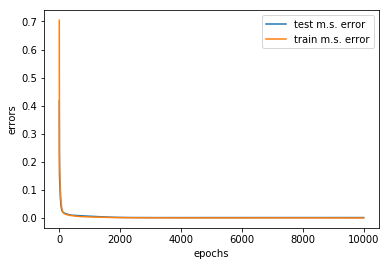

In [257]:
mlp_8 = MLP()
mlp_8.initialize(NI=4, NH=5, NO=1, activation_h=tanh, activation_o=linear)
mlp_8.train(X_train, y_train, n_epochs=10000, batch_size=50, learning_rate=0.0025, X_test=X_test, y_test=y_test)

In [282]:
_ = [print("Prediction: %.4f Target: %.4f"%(mlp_8.predict(v[0])[0], v[1][0])) for v in zip(X_test, y_test)]

Prediction: 0.3360 Target: 0.3362
Prediction: 0.7210 Target: 0.7318
Prediction: -0.1074 Target: -0.1297
Prediction: -0.3029 Target: -0.3323
Prediction: -0.5036 Target: -0.5173
Prediction: 0.9247 Target: 0.8943
Prediction: 0.9296 Target: 0.9418
Prediction: -0.4364 Target: -0.4538
Prediction: -0.9999 Target: -1.0000
Prediction: -0.1811 Target: -0.1933
Prediction: -0.9294 Target: -0.9291
Prediction: -0.6652 Target: -0.9577
Prediction: 0.7091 Target: 0.7043
Prediction: -0.9780 Target: -0.9571
Prediction: 0.5859 Target: 0.5916
Prediction: 0.5293 Target: 0.5377
Prediction: 0.1259 Target: 0.1293
Prediction: 0.4840 Target: 0.5101
Prediction: -0.2677 Target: -0.2799
Prediction: -0.1880 Target: -0.1957
Prediction: 0.0543 Target: 0.0608
Prediction: 0.3817 Target: 0.4366
Prediction: -0.9738 Target: -0.9541
Prediction: 0.7739 Target: 0.8089
Prediction: 0.5005 Target: 0.5122
Prediction: 0.7336 Target: 0.7329
Prediction: -0.8385 Target: -0.8602
Prediction: -1.0145 Target: -0.9990
Prediction: 0.9309 T

Epoch = 0 MSError= 116.88327385909965
Epoch = 1 MSError= 43.06335733573946
Epoch = 2 MSError= 35.93636127355131
Epoch = 3 MSError= 34.02470607375877
Epoch = 4 MSError= 33.311714699702904
Epoch = 5 MSError= 32.94731574282281
Epoch = 6 MSError= 32.7041237751793
Epoch = 7 MSError= 32.51008133649047
Epoch = 8 MSError= 32.338870834637355
Epoch = 9 MSError= 32.17976576963511
Epoch = 10 MSError= 32.02803505867602
Epoch = 11 MSError= 31.881475129527004
Epoch = 12 MSError= 31.739017694135896
Epoch = 13 MSError= 31.6001216044937
Epoch = 14 MSError= 31.464489150022327
Epoch = 15 MSError= 31.33192710094182
Epoch = 16 MSError= 31.20227640294524
Epoch = 17 MSError= 31.0753760533539
Epoch = 18 MSError= 30.95104462778034
Epoch = 19 MSError= 30.829071119265485
Epoch = 20 MSError= 30.709210674886318
Epoch = 21 MSError= 30.59118277030415
Epoch = 22 MSError= 30.47467037526176
Epoch = 23 MSError= 30.3593192088321
Epoch = 24 MSError= 30.244736490515525
Epoch = 25 MSError= 30.1304887741423
Epoch = 26 MSError

Epoch = 223 MSError= 3.120045719211631
Epoch = 224 MSError= 3.1087571048143534
Epoch = 225 MSError= 3.0976180885425673
Epoch = 226 MSError= 3.0866233260336795
Epoch = 227 MSError= 3.0757676770209286
Epoch = 228 MSError= 3.0650461987327886
Epoch = 229 MSError= 3.054454139483809
Epoch = 230 MSError= 3.043986932457441
Epoch = 231 MSError= 3.033640189680688
Epoch = 232 MSError= 3.0234096961899297
Epoch = 233 MSError= 3.013291404386528
Epoch = 234 MSError= 3.0032814285804177
Epoch = 235 MSError= 2.9933760397193443
Epoch = 236 MSError= 2.9835716603009472
Epoch = 237 MSError= 2.973864859464601
Epoch = 238 MSError= 2.964252348259333
Epoch = 239 MSError= 2.954730975084054
Epoch = 240 MSError= 2.9452977212958498
Epoch = 241 MSError= 2.9359496969818566
Epoch = 242 MSError= 2.9266841368899965
Epoch = 243 MSError= 2.917498396513655
Epoch = 244 MSError= 2.90838994832507
Epoch = 245 MSError= 2.8993563781521208
Epoch = 246 MSError= 2.890395381693052
Epoch = 247 MSError= 2.8815047611633586
Epoch = 248 

Epoch = 433 MSError= 3.6144143482890816
Epoch = 434 MSError= 4.2869401167141845
Epoch = 435 MSError= 5.346084481551308
Epoch = 436 MSError= 6.8314446481109075
Epoch = 437 MSError= 9.07775966255399
Epoch = 438 MSError= 11.825070258336348
Epoch = 439 MSError= 15.538526525588932
Epoch = 440 MSError= 18.812270485030314
Epoch = 441 MSError= 22.252594075053686
Epoch = 442 MSError= 23.088281482083374
Epoch = 443 MSError= 23.12593931537893
Epoch = 444 MSError= 20.275578536475493
Epoch = 445 MSError= 17.44300769088518
Epoch = 446 MSError= 13.762126671544351
Epoch = 447 MSError= 10.992240469142907
Epoch = 448 MSError= 8.539292055314258
Epoch = 449 MSError= 6.879737853267288
Epoch = 450 MSError= 5.605009269792994
Epoch = 451 MSError= 4.763782577585853
Epoch = 452 MSError= 4.146978763984582
Epoch = 453 MSError= 3.7343802091251366
Epoch = 454 MSError= 3.4330547146993964
Epoch = 455 MSError= 3.225209775355662
Epoch = 456 MSError= 3.0708682798930096
Epoch = 457 MSError= 2.9601736717824285
Epoch = 458

Epoch = 655 MSError= 7.141717941635953
Epoch = 656 MSError= 7.21992152927502
Epoch = 657 MSError= 7.194273616169055
Epoch = 658 MSError= 7.130558988381509
Epoch = 659 MSError= 6.968140013894076
Epoch = 660 MSError= 6.784515508425096
Epoch = 661 MSError= 6.524942036527032
Epoch = 662 MSError= 6.267729265619014
Epoch = 663 MSError= 5.963988834569853
Epoch = 664 MSError= 5.682883250349337
Epoch = 665 MSError= 5.381033634565801
Epoch = 666 MSError= 5.113475052320153
Epoch = 667 MSError= 4.842544740171135
Epoch = 668 MSError= 4.609074258852775
Epoch = 669 MSError= 4.381429181230564
Epoch = 670 MSError= 4.188804541060773
Epoch = 671 MSError= 4.005478673399313
Epoch = 672 MSError= 3.8521547920599177
Epoch = 673 MSError= 3.708406733007201
Epoch = 674 MSError= 3.5891262678357223
Epoch = 675 MSError= 3.4782818549419443
Epoch = 676 MSError= 3.386910084995889
Epoch = 677 MSError= 3.3024292833517874
Epoch = 678 MSError= 3.2333457949675624
Epoch = 679 MSError= 3.1696849719911646
Epoch = 680 MSError=

Epoch = 864 MSError= 4.463630559039292
Epoch = 865 MSError= 4.3456127902112796
Epoch = 866 MSError= 4.249545097588688
Epoch = 867 MSError= 4.141027655951209
Epoch = 868 MSError= 4.053633769994913
Epoch = 869 MSError= 3.9573668706605547
Epoch = 870 MSError= 3.8808387919542
Epoch = 871 MSError= 3.7979316349752237
Epoch = 872 MSError= 3.7331182609606786
Epoch = 873 MSError= 3.6635889733916036
Epoch = 874 MSError= 3.6104828518036087
Epoch = 875 MSError= 3.553732456158536
Epoch = 876 MSError= 3.511867432498812
Epoch = 877 MSError= 3.4670322328936196
Epoch = 878 MSError= 3.4357698260169136
Epoch = 879 MSError= 3.4019563405821485
Epoch = 880 MSError= 3.380673059622483
Epoch = 881 MSError= 3.357100078070441
Epoch = 882 MSError= 3.345299570611384
Epoch = 883 MSError= 3.3313747416242565
Epoch = 884 MSError= 3.3287479426146724
Epoch = 885 MSError= 3.3241011069003177
Epoch = 886 MSError= 3.330551744958698
Epoch = 887 MSError= 3.3350396629017998
Epoch = 888 MSError= 3.3506854562590966
Epoch = 889 M

Epoch = 1074 MSError= 3.5938858576024533
Epoch = 1075 MSError= 3.5705792345676053
Epoch = 1076 MSError= 3.558573437645829
Epoch = 1077 MSError= 3.5430838083794596
Epoch = 1078 MSError= 3.538553560315318
Epoch = 1079 MSError= 3.5307419338509676
Epoch = 1080 MSError= 3.533676322626204
Epoch = 1081 MSError= 3.533431147685789
Epoch = 1082 MSError= 3.5438470088281155
Epoch = 1083 MSError= 3.551089044330419
Epoch = 1084 MSError= 3.569027530644712
Epoch = 1085 MSError= 3.583693828383182
Epoch = 1086 MSError= 3.609196364818852
Epoch = 1087 MSError= 3.631203740168056
Epoch = 1088 MSError= 3.664266910571336
Epoch = 1089 MSError= 3.693454449003446
Epoch = 1090 MSError= 3.7339630171947906
Epoch = 1091 MSError= 3.770013525595247
Epoch = 1092 MSError= 3.81765193260103
Epoch = 1093 MSError= 3.859994487679768
Epoch = 1094 MSError= 3.9141405120054857
Epoch = 1095 MSError= 3.961841029096145
Epoch = 1096 MSError= 4.0214514022747325
Epoch = 1097 MSError= 4.0731056904978695
Epoch = 1098 MSError= 4.13661221

Epoch = 1278 MSError= 3.6646773871211242
Epoch = 1279 MSError= 3.674413822948869
Epoch = 1280 MSError= 3.692663361326389
Epoch = 1281 MSError= 3.708253167902319
Epoch = 1282 MSError= 3.7323571128150212
Epoch = 1283 MSError= 3.7535401077302684
Epoch = 1284 MSError= 3.7832399107305235
Epoch = 1285 MSError= 3.809621699619057
Epoch = 1286 MSError= 3.844499137590656
Epoch = 1287 MSError= 3.8755008191157727
Epoch = 1288 MSError= 3.9149246951151135
Epoch = 1289 MSError= 3.9497302749314698
Epoch = 1290 MSError= 3.9928040773685023
Epoch = 1291 MSError= 4.030314594068092
Epoch = 1292 MSError= 4.075835714289263
Epoch = 1293 MSError= 4.114642482636707
Epoch = 1294 MSError= 4.161086765871612
Epoch = 1295 MSError= 4.199478497698613
Epoch = 1296 MSError= 4.245025275580309
Epoch = 1297 MSError= 4.281043369577143
Epoch = 1298 MSError= 4.323653792160684
Epoch = 1299 MSError= 4.355204941780544
Epoch = 1300 MSError= 4.392758815736973
Epoch = 1301 MSError= 4.417783334232141
Epoch = 1302 MSError= 4.44826667

Epoch = 1482 MSError= 3.9137546754480623
Epoch = 1483 MSError= 3.9410716007207087
Epoch = 1484 MSError= 3.9738137249495176
Epoch = 1485 MSError= 4.003249777229498
Epoch = 1486 MSError= 4.037777595881983
Epoch = 1487 MSError= 4.068247271413074
Epoch = 1488 MSError= 4.103399518261851
Epoch = 1489 MSError= 4.133629005437299
Epoch = 1490 MSError= 4.168066462542892
Epoch = 1491 MSError= 4.19663518186181
Epoch = 1492 MSError= 4.22889613432767
Epoch = 1493 MSError= 4.254310554653487
Epoch = 1494 MSError= 4.28289848531358
Epoch = 1495 MSError= 4.303696361843628
Epoch = 1496 MSError= 4.327194772475899
Epoch = 1497 MSError= 4.342070438093537
Epoch = 1498 MSError= 4.3592719545855925
Epoch = 1499 MSError= 4.367205809497951
Epoch = 1500 MSError= 4.377236184061251
Epoch = 1501 MSError= 4.377606675162747
Epoch = 1502 MSError= 4.380021574052284
Epoch = 1503 MSError= 4.372678156310152
Epoch = 1504 MSError= 4.367513580474026
Epoch = 1505 MSError= 4.352795393818734
Epoch = 1506 MSError= 4.340561188994782

Epoch = 1693 MSError= 4.282140645959103
Epoch = 1694 MSError= 4.290229375480727
Epoch = 1695 MSError= 4.292337780799396
Epoch = 1696 MSError= 4.294545397600724
Epoch = 1697 MSError= 4.290665527350921
Epoch = 1698 MSError= 4.2869619641860535
Epoch = 1699 MSError= 4.277263577787754
Epoch = 1700 MSError= 4.26796116940178
Epoch = 1701 MSError= 4.252946082610743
Epoch = 1702 MSError= 4.238665891637965
Epoch = 1703 MSError= 4.219116288625158
Epoch = 1704 MSError= 4.200724954761031
Epoch = 1705 MSError= 4.177627415207907
Epoch = 1706 MSError= 4.156155755156909
Epoch = 1707 MSError= 4.13061390018914
Epoch = 1708 MSError= 4.107170438655361
Epoch = 1709 MSError= 4.080319356580146
Epoch = 1710 MSError= 4.056010799053963
Epoch = 1711 MSError= 4.028943831485839
Epoch = 1712 MSError= 4.004811037220942
Epoch = 1713 MSError= 3.978525285740999
Epoch = 1714 MSError= 3.9554988967351203
Epoch = 1715 MSError= 3.9308613403470227
Epoch = 1716 MSError= 3.909737130347223
Epoch = 1717 MSError= 3.887469603213561

Epoch = 1898 MSError= 4.157548914823817
Epoch = 1899 MSError= 4.139609161199834
Epoch = 1900 MSError= 4.121708147131897
Epoch = 1901 MSError= 4.1015964317969935
Epoch = 1902 MSError= 4.081942330998085
Epoch = 1903 MSError= 4.06055498785583
Epoch = 1904 MSError= 4.040034215053807
Epoch = 1905 MSError= 4.01825691889525
Epoch = 1906 MSError= 3.9977233886934003
Epoch = 1907 MSError= 3.9763863992129966
Epoch = 1908 MSError= 3.9566236202699927
Epoch = 1909 MSError= 3.9364705232891497
Epoch = 1910 MSError= 3.9181671111035348
Epoch = 1911 MSError= 3.899836830281789
Epoch = 1912 MSError= 3.883574273750263
Epoch = 1913 MSError= 3.867594330681571
Epoch = 1914 MSError= 3.8538444744040823
Epoch = 1915 MSError= 3.8406325046145633
Epoch = 1916 MSError= 3.829761618963184
Epoch = 1917 MSError= 3.819631908393152
Epoch = 1918 MSError= 3.811908250492435
Epoch = 1919 MSError= 3.805080330872376
Epoch = 1920 MSError= 3.800682529235683
Epoch = 1921 MSError= 3.7972894362828113
Epoch = 1922 MSError= 3.796313657

Epoch = 2107 MSError= 3.8772259740245008
Epoch = 2108 MSError= 3.8651701181423936
Epoch = 2109 MSError= 3.854387987480733
Epoch = 2110 MSError= 3.8447792716927833
Epoch = 2111 MSError= 3.8366097969905213
Epoch = 2112 MSError= 3.829693019315064
Epoch = 2113 MSError= 3.8243421775814284
Epoch = 2114 MSError= 3.8202813753940297
Epoch = 2115 MSError= 3.8178760030447974
Epoch = 2116 MSError= 3.8167585758598763
Epoch = 2117 MSError= 3.817349980961943
Epoch = 2118 MSError= 3.819189463956774
Epoch = 2119 MSError= 3.822755300586326
Epoch = 2120 MSError= 3.8274922181639686
Epoch = 2121 MSError= 3.8339363006044747
Epoch = 2122 MSError= 3.841437031617311
Epoch = 2123 MSError= 3.8505872671960684
Epoch = 2124 MSError= 3.8606413414740834
Epoch = 2125 MSError= 3.872246445487667
Epoch = 2126 MSError= 3.884563159881684
Epoch = 2127 MSError= 3.8982892758121253
Epoch = 2128 MSError= 3.9124949507752107
Epoch = 2129 MSError= 3.9279237070319932
Epoch = 2130 MSError= 3.943561261813498
Epoch = 2131 MSError= 3.9

Epoch = 2322 MSError= 3.9171922134995096
Epoch = 2323 MSError= 3.9308571586196193
Epoch = 2324 MSError= 3.943940770264291
Epoch = 2325 MSError= 3.9585310149213715
Epoch = 2326 MSError= 3.9722595674183077
Epoch = 2327 MSError= 3.98726894500426
Epoch = 2328 MSError= 4.001116202869409
Epoch = 2329 MSError= 4.015993628861723
Epoch = 2330 MSError= 4.02939898861378
Epoch = 2331 MSError= 4.043568425373539
Epoch = 2332 MSError= 4.05595972715351
Epoch = 2333 MSError= 4.0688459762526925
Epoch = 2334 MSError= 4.079667530483426
Epoch = 2335 MSError= 4.090726607512735
Epoch = 2336 MSError= 4.099470666855883
Epoch = 2337 MSError= 4.108222466162796
Epoch = 2338 MSError= 4.114461405459882
Epoch = 2339 MSError= 4.120521495591006
Epoch = 2340 MSError= 4.12393729749367
Epoch = 2341 MSError= 4.127044243728797
Epoch = 2342 MSError= 4.127451743666791
Epoch = 2343 MSError= 4.127486517255003
Epoch = 2344 MSError= 4.124847362307466
Epoch = 2345 MSError= 4.121842222182246
Epoch = 2346 MSError= 4.116267613818484

Epoch = 2526 MSError= 4.038721843641346
Epoch = 2527 MSError= 4.04964903826301
Epoch = 2528 MSError= 4.05817638772605
Epoch = 2529 MSError= 4.06745816845416
Epoch = 2530 MSError= 4.074137286220408
Epoch = 2531 MSError= 4.081391440109217
Epoch = 2532 MSError= 4.085888100424072
Epoch = 2533 MSError= 4.090817434712207
Epoch = 2534 MSError= 4.092892774124897
Epoch = 2535 MSError= 4.09530508757856
Epoch = 2536 MSError= 4.09483205847557
Epoch = 2537 MSError= 4.094653485188721
Epoch = 2538 MSError= 4.091625788614479
Epoch = 2539 MSError= 4.088905835263003
Epoch = 2540 MSError= 4.083438179043376
Epoch = 2541 MSError= 4.078345804608095
Epoch = 2542 MSError= 4.070665442021552
Epoch = 2543 MSError= 4.063476691255135
Epoch = 2544 MSError= 4.053907316985388
Epoch = 2545 MSError= 4.044986078682534
Epoch = 2546 MSError= 4.033926065905224
Epoch = 2547 MSError= 4.0237002758308895
Epoch = 2548 MSError= 4.011597763507685
Epoch = 2549 MSError= 4.000533686107806
Epoch = 2550 MSError= 3.987861102640441
Epoc

Epoch = 2731 MSError= 4.0661713992002335
Epoch = 2732 MSError= 4.062880322871383
Epoch = 2733 MSError= 4.0602916672661005
Epoch = 2734 MSError= 4.054967354357765
Epoch = 2735 MSError= 4.050407627905311
Epoch = 2736 MSError= 4.043258428053661
Epoch = 2737 MSError= 4.036974538262873
Epoch = 2738 MSError= 4.028285633195193
Epoch = 2739 MSError= 4.020594316899576
Epoch = 2740 MSError= 4.010709857124896
Epoch = 2741 MSError= 4.0019783706103995
Epoch = 2742 MSError= 3.991281389102867
Epoch = 2743 MSError= 3.981906872387836
Epoch = 2744 MSError= 3.9707988766305333
Epoch = 2745 MSError= 3.9611882200512127
Epoch = 2746 MSError= 3.9500701055778946
Epoch = 2747 MSError= 3.9406217810386446
Epoch = 2748 MSError= 3.9298772640561483
Epoch = 2749 MSError= 3.920966079993028
Epoch = 2750 MSError= 3.910948322001631
Epoch = 2751 MSError= 3.9029135295560793
Epoch = 2752 MSError= 3.8939351238621787
Epoch = 2753 MSError= 3.8870718324529854
Epoch = 2754 MSError= 3.8793979147107884
Epoch = 2755 MSError= 3.8739

Epoch = 2934 MSError= 3.9904433156704497
Epoch = 2935 MSError= 3.982899607354615
Epoch = 2936 MSError= 3.9734645899542436
Epoch = 2937 MSError= 3.965441536397288
Epoch = 2938 MSError= 3.9557269150713124
Epoch = 2939 MSError= 3.9475720104902146
Epoch = 2940 MSError= 3.937919388060307
Epoch = 2941 MSError= 3.929971903700696
Epoch = 2942 MSError= 3.920707437495687
Epoch = 2943 MSError= 3.913285857943366
Epoch = 2944 MSError= 3.9047091423907623
Epoch = 2945 MSError= 3.8981011623414004
Epoch = 2946 MSError= 3.890476687980323
Epoch = 2947 MSError= 3.8849317528438756
Epoch = 2948 MSError= 3.87848278310736
Epoch = 2949 MSError= 3.874206904651748
Epoch = 2950 MSError= 3.8691114140626777
Epoch = 2951 MSError= 3.866263842755746
Epoch = 2952 MSError= 3.862652064638539
Epoch = 2953 MSError= 3.861343350880212
Epoch = 2954 MSError= 3.859296479542342
Epoch = 2955 MSError= 3.859587491495874
Epoch = 2956 MSError= 3.8591371543198485
Epoch = 2957 MSError= 3.8610387193979396
Epoch = 2958 MSError= 3.8621669

Epoch = 3147 MSError= 3.8640787218396717
Epoch = 3148 MSError= 3.862609822384826
Epoch = 3149 MSError= 3.863254703576019
Epoch = 3150 MSError= 3.8631780380790244
Epoch = 3151 MSError= 3.865221085652911
Epoch = 3152 MSError= 3.8665096299247566
Epoch = 3153 MSError= 3.869904388775584
Epoch = 3154 MSError= 3.872487248103572
Epoch = 3155 MSError= 3.8771432851958734
Epoch = 3156 MSError= 3.880906828085832
Epoch = 3157 MSError= 3.8866911447711843
Epoch = 3158 MSError= 3.8914809173016534
Epoch = 3159 MSError= 3.89822026809729
Epoch = 3160 MSError= 3.903843939648776
Epoch = 3161 MSError= 3.911328339133719
Epoch = 3162 MSError= 3.91755996745597
Epoch = 3163 MSError= 3.9255476794102524
Epoch = 3164 MSError= 3.932133564634682
Epoch = 3165 MSError= 3.940357818384399
Epoch = 3166 MSError= 3.9470241324303585
Epoch = 3167 MSError= 3.9552016940988244
Epoch = 3168 MSError= 3.961663921852092
Epoch = 3169 MSError= 3.969505465339241
Epoch = 3170 MSError= 3.9754794854258035
Epoch = 3171 MSError= 3.98270147

Epoch = 3355 MSError= 3.9100375577975526
Epoch = 3356 MSError= 3.9155860716455235
Epoch = 3357 MSError= 3.922541101693637
Epoch = 3358 MSError= 3.928338717789652
Epoch = 3359 MSError= 3.9354336598618067
Epoch = 3360 MSError= 3.9412395796855293
Epoch = 3361 MSError= 3.9482268567712016
Epoch = 3362 MSError= 3.9537942931737917
Epoch = 3363 MSError= 3.960424611663013
Epoch = 3364 MSError= 3.9655105963148682
Epoch = 3365 MSError= 3.9715433120459576
Epoch = 3366 MSError= 3.975919256615104
Epoch = 3367 MSError= 3.9811332505230874
Epoch = 3368 MSError= 3.9845956710701658
Epoch = 3369 MSError= 3.988800061995994
Epoch = 3370 MSError= 3.991180741838856
Epoch = 3371 MSError= 3.994224659889184
Epoch = 3372 MSError= 3.995399466180917
Epoch = 3373 MSError= 3.997180093783857
Epoch = 3374 MSError= 3.9970756994914947
Epoch = 3375 MSError= 3.997543874676625
Epoch = 3376 MSError= 3.9961417771588232
Epoch = 3377 MSError= 3.995304642041801
Epoch = 3378 MSError= 3.9926420992133607
Epoch = 3379 MSError= 3.990

Epoch = 3559 MSError= 3.9602737251776396
Epoch = 3560 MSError= 3.9640793308212072
Epoch = 3561 MSError= 3.9683165394607602
Epoch = 3562 MSError= 3.971303342971464
Epoch = 3563 MSError= 3.974637598208928
Epoch = 3564 MSError= 3.9766674778387436
Epoch = 3565 MSError= 3.978976807667029
Epoch = 3566 MSError= 3.979950540349785
Epoch = 3567 MSError= 3.981155075736293
Epoch = 3568 MSError= 3.9810175065617823
Epoch = 3569 MSError= 3.981083660419829
Epoch = 3570 MSError= 3.9798265855251582
Epoch = 3571 MSError= 3.978768763384589
Epoch = 3572 MSError= 3.9764312706764566
Epoch = 3573 MSError= 3.9743109614923307
Epoch = 3574 MSError= 3.9709771990424776
Epoch = 3575 MSError= 3.9678995301706816
Epoch = 3576 MSError= 3.963694102381792
Epoch = 3577 MSError= 3.959802166035477
Epoch = 3578 MSError= 3.9548835587073783
Epoch = 3579 MSError= 3.95035099573865
Epoch = 3580 MSError= 3.9449035749481167
Epoch = 3581 MSError= 3.9399260123006647
Epoch = 3582 MSError= 3.934151212020344
Epoch = 3583 MSError= 3.9289

Epoch = 3767 MSError= 3.959846583113279
Epoch = 3768 MSError= 3.9571204956165937
Epoch = 3769 MSError= 3.9541411912376407
Epoch = 3770 MSError= 3.9506648503024424
Epoch = 3771 MSError= 3.9469862946163987
Epoch = 3772 MSError= 3.9428975298313174
Epoch = 3773 MSError= 3.938671080412312
Epoch = 3774 MSError= 3.9341299125741687
Epoch = 3775 MSError= 3.929525709002513
Epoch = 3776 MSError= 3.924706926137725
Epoch = 3777 MSError= 3.919906210217009
Epoch = 3778 MSError= 3.9149917300713284
Epoch = 3779 MSError= 3.9101791781490363
Epoch = 3780 MSError= 3.9053506306997203
Epoch = 3781 MSError= 3.9007070967490254
Epoch = 3782 MSError= 3.8961389729409954
Epoch = 3783 MSError= 3.891834940978859
Epoch = 3784 MSError= 3.8876885485167745
Epoch = 3785 MSError= 3.8838784835617726
Epoch = 3786 MSError= 3.880296844463654
Epoch = 3787 MSError= 3.877114528842758
Epoch = 3788 MSError= 3.8742182607873277
Epoch = 3789 MSError= 3.871773119371146
Epoch = 3790 MSError= 3.8696572732009855
Epoch = 3791 MSError= 3.8

Epoch = 3983 MSError= 3.869318587192466
Epoch = 3984 MSError= 3.8677323331301556
Epoch = 3985 MSError= 3.865906338598656
Epoch = 3986 MSError= 3.8650608283024876
Epoch = 3987 MSError= 3.8639980833952654
Epoch = 3988 MSError= 3.863929412959841
Epoch = 3989 MSError= 3.8636522468863737
Epoch = 3990 MSError= 3.8643699024788094
Epoch = 3991 MSError= 3.864873579932395
Epoch = 3992 MSError= 3.86636029246459
Epoch = 3993 MSError= 3.8676132143776303
Epoch = 3994 MSError= 3.8698254512125274
Epoch = 3995 MSError= 3.8717700018895527
Epoch = 3996 MSError= 3.8746391082612344
Epoch = 3997 MSError= 3.8771931725812
Epoch = 3998 MSError= 3.880627195716867
Epoch = 3999 MSError= 3.883686386029641
Epoch = 4000 MSError= 3.8875726246141866
Epoch = 4001 MSError= 3.89101325942029
Epoch = 4002 MSError= 3.8952215751807935
Epoch = 4003 MSError= 3.898904436562685
Epoch = 4004 MSError= 3.903291340258077
Epoch = 4005 MSError= 3.907066202326066
Epoch = 4006 MSError= 3.911479682610159
Epoch = 4007 MSError= 3.915190549

Epoch = 4203 MSError= 3.910205633727076
Epoch = 4204 MSError= 3.914275782419496
Epoch = 4205 MSError= 3.9166327846931623
Epoch = 4206 MSError= 3.9203688331465756
Epoch = 4207 MSError= 3.9223108383088228
Epoch = 4208 MSError= 3.9255971373952505
Epoch = 4209 MSError= 3.9270162793844374
Epoch = 4210 MSError= 3.9297541065208663
Epoch = 4211 MSError= 3.9305622220315524
Epoch = 4212 MSError= 3.9326742079644217
Epoch = 4213 MSError= 3.932806854897602
Epoch = 4214 MSError= 3.9342405336023827
Epoch = 4215 MSError= 3.9336599815594746
Epoch = 4216 MSError= 3.934390220072584
Epoch = 4217 MSError= 3.9330872017470493
Epoch = 4218 MSError= 3.93311733718864
Epoch = 4219 MSError= 3.931111433199069
Epoch = 4220 MSError= 3.9304730354817226
Epoch = 4221 MSError= 3.9278116646509083
Epoch = 4222 MSError= 3.9265629446819617
Epoch = 4223 MSError= 3.9233190348874056
Epoch = 4224 MSError= 3.9215420169357653
Epoch = 4225 MSError= 3.9178105256462543
Epoch = 4226 MSError= 3.91560718686438
Epoch = 4227 MSError= 3.9

Epoch = 4418 MSError= 3.911775479367259
Epoch = 4419 MSError= 3.908098088465166
Epoch = 4420 MSError= 3.906972092720137
Epoch = 4421 MSError= 3.9029057259863404
Epoch = 4422 MSError= 3.9014444872877907
Epoch = 4423 MSError= 3.8970925956406313
Epoch = 4424 MSError= 3.895402381124927
Epoch = 4425 MSError= 3.890877632107569
Epoch = 4426 MSError= 3.8890720324187162
Epoch = 4427 MSError= 3.884491699384568
Epoch = 4428 MSError= 3.8826870840796133
Epoch = 4429 MSError= 3.8781684747749243
Epoch = 4430 MSError= 3.876479568019505
Epoch = 4431 MSError= 3.872135688667196
Epoch = 4432 MSError= 3.8706714397176505
Epoch = 4433 MSError= 3.866607047681766
Epoch = 4434 MSError= 3.865466926651209
Epoch = 4435 MSError= 3.861775078810166
Epoch = 4436 MSError= 3.8610458841725626
Epoch = 4437 MSError= 3.8578050452446937
Epoch = 4438 MSError= 3.857558270689042
Epoch = 4439 MSError= 3.8548300103997915
Epoch = 4440 MSError= 3.8551197885493678
Epoch = 4441 MSError= 3.852947071281148
Epoch = 4442 MSError= 3.85380

Epoch = 4621 MSError= 3.878165999669001
Epoch = 4622 MSError= 3.877286529108765
Epoch = 4623 MSError= 3.872489778702592
Epoch = 4624 MSError= 3.871613657520053
Epoch = 4625 MSError= 3.86687631687652
Epoch = 4626 MSError= 3.8661041410649077
Epoch = 4627 MSError= 3.8615251278553337
Epoch = 4628 MSError= 3.8609525531854016
Epoch = 4629 MSError= 3.8566235045649497
Epoch = 4630 MSError= 3.8563379940061973
Epoch = 4631 MSError= 3.8523402392341466
Epoch = 4632 MSError= 3.8524182359287042
Epoch = 4633 MSError= 3.848820244949498
Epoch = 4634 MSError= 3.8493248199156715
Epoch = 4635 MSError= 3.8461801609304986
Epoch = 4636 MSError= 3.8471591599077932
Epoch = 4637 MSError= 3.844504977665901
Epoch = 4638 MSError= 3.8459896743639423
Epoch = 4639 MSError= 3.8438456876061484
Epoch = 4640 MSError= 3.8458499411004907
Epoch = 4641 MSError= 3.8442179516109376
Epoch = 4642 MSError= 3.8467378625807114
Epoch = 4643 MSError= 3.8456017679275702
Epoch = 4644 MSError= 3.8486158298179762
Epoch = 4645 MSError= 3.

Epoch = 4824 MSError= 3.8510276249613296
Epoch = 4825 MSError= 3.8462568851416905
Epoch = 4826 MSError= 3.8466984369751387
Epoch = 4827 MSError= 3.8421927390015136
Epoch = 4828 MSError= 3.84292720223469
Epoch = 4829 MSError= 3.8387513360886754
Epoch = 4830 MSError= 3.8398395853143588
Epoch = 4831 MSError= 3.8360459553720263
Epoch = 4832 MSError= 3.837536218841068
Epoch = 4833 MSError= 3.8341633023848884
Epoch = 4834 MSError= 3.836089753714068
Epoch = 4835 MSError= 3.833161018889603
Epoch = 4836 MSError= 3.835542815605804
Epoch = 4837 MSError= 3.8330660989410115
Epoch = 4838 MSError= 3.83590686893637
Epoch = 4839 MSError= 3.8338742085111077
Epoch = 4840 MSError= 3.8371619831923662
Epoch = 4841 MSError= 3.8355499027389723
Epoch = 4842 MSError= 3.839257495636558
Epoch = 4843 MSError= 3.838027735275798
Epoch = 4844 MSError= 3.84211356508881
Epoch = 4845 MSError= 3.841214253947672
Epoch = 4846 MSError= 3.8456236093964993
Epoch = 4847 MSError= 3.844990872067824
Epoch = 4848 MSError= 3.849657

Epoch = 5032 MSError= 3.8229143572256583
Epoch = 5033 MSError= 3.8194642700974604
Epoch = 5034 MSError= 3.822430020133627
Epoch = 5035 MSError= 3.8193768959201906
Epoch = 5036 MSError= 3.8227456588225484
Epoch = 5037 MSError= 3.820081392258202
Epoch = 5038 MSError= 3.823842297266877
Epoch = 5039 MSError= 3.8215452731449364
Epoch = 5040 MSError= 3.825674170018937
Epoch = 5041 MSError= 3.82370994726257
Epoch = 5042 MSError= 3.828170149748809
Epoch = 5043 MSError= 3.8264925341442217
Epoch = 5044 MSError= 3.831235952143647
Epoch = 5045 MSError= 3.829788445889873
Epoch = 5046 MSError= 3.8347570948491763
Epoch = 5047 MSError= 3.833474703474413
Epoch = 5048 MSError= 3.8386025701577418
Epoch = 5049 MSError= 3.837413936010344
Epoch = 5050 MSError= 3.842629166612141
Epoch = 5051 MSError= 3.841458983168831
Epoch = 5052 MSError= 3.8466863431291265
Epoch = 5053 MSError= 3.8454579866187144
Epoch = 5054 MSError= 3.8506215226423572
Epoch = 5055 MSError= 3.8492598185199314
Epoch = 5056 MSError= 3.85428

Epoch = 5235 MSError= 3.8021776809645056
Epoch = 5236 MSError= 3.806069762497905
Epoch = 5237 MSError= 3.803029478092547
Epoch = 5238 MSError= 3.8072538610545528
Epoch = 5239 MSError= 3.8045218114036787
Epoch = 5240 MSError= 3.8090527698311254
Epoch = 5241 MSError= 3.8065942265844694
Epoch = 5242 MSError= 3.8113956023877824
Epoch = 5243 MSError= 3.8091662762107696
Epoch = 5244 MSError= 3.814192613140658
Epoch = 5245 MSError= 3.81214006455785
Epoch = 5246 MSError= 3.8173380574378366
Epoch = 5247 MSError= 3.8154033975249786
Epoch = 5248 MSError= 3.8207136303934677
Epoch = 5249 MSError= 3.8188334756351265
Epoch = 5250 MSError= 3.824192410375496
Epoch = 5251 MSError= 3.822301043068291
Epoch = 5252 MSError= 3.8276432061165773
Epoch = 5253 MSError= 3.825674877498003
Epoch = 5254 MSError= 3.8309351774230316
Epoch = 5255 MSError= 3.8288264766304847
Epoch = 5256 MSError= 3.8339425713263022
Epoch = 5257 MSError= 3.8316347710649716
Epoch = 5258 MSError= 3.836549391790831
Epoch = 5259 MSError= 3.8

Epoch = 5452 MSError= 3.799696123200522
Epoch = 5453 MSError= 3.797396284178651
Epoch = 5454 MSError= 3.8024636912616137
Epoch = 5455 MSError= 3.800065477700637
Epoch = 5456 MSError= 3.8050219803188887
Epoch = 5457 MSError= 3.802474432059394
Epoch = 5458 MSError= 3.807269971647899
Epoch = 5459 MSError= 3.8045273709321297
Epoch = 5460 MSError= 3.8091174112349844
Epoch = 5461 MSError= 3.806140988978476
Epoch = 5462 MSError= 3.8104881795670833
Epoch = 5463 MSError= 3.8072475821185856
Epoch = 5464 MSError= 3.811323166625566
Epoch = 5465 MSError= 3.8077976131551083
Epoch = 5466 MSError= 3.811582514868399
Epoch = 5467 MSError= 3.807761588050972
Epoch = 5468 MSError= 3.811247119549463
Epoch = 5469 MSError= 3.8071311493515085
Epoch = 5470 MSError= 3.810319311156528
Epoch = 5471 MSError= 3.8059193320738856
Epoch = 5472 MSError= 3.808822686453897
Epoch = 5473 MSError= 3.8041599708396237
Epoch = 5474 MSError= 3.8068010991840024
Epoch = 5475 MSError= 3.8019062914517603
Epoch = 5476 MSError= 3.8043

Epoch = 5657 MSError= 3.752833057740199
Epoch = 5658 MSError= 3.7565785192523373
Epoch = 5659 MSError= 3.7544959484923344
Epoch = 5660 MSError= 3.758104543576337
Epoch = 5661 MSError= 3.7558865163070254
Epoch = 5662 MSError= 3.7593202292641377
Epoch = 5663 MSError= 3.7569329815474823
Epoch = 5664 MSError= 3.760159136926336
Epoch = 5665 MSError= 3.7575751602376526
Epoch = 5666 MSError= 3.7605675858386434
Epoch = 5667 MSError= 3.7577666175520616
Epoch = 5668 MSError= 3.7605065735195624
Epoch = 5669 MSError= 3.757476322599432
Epoch = 5670 MSError= 3.7599531546688514
Epoch = 5671 MSError= 3.756689729127902
Epoch = 5672 MSError= 3.758901216334952
Epoch = 5673 MSError= 3.7554092327790585
Epoch = 5674 MSError= 3.7573616143922592
Epoch = 5675 MSError= 3.753653985282901
Epoch = 5676 MSError= 3.7553616673181294
Epoch = 5677 MSError= 3.7514590772773033
Epoch = 5678 MSError= 3.752944034488548
Epoch = 5679 MSError= 3.74887413182446
Epoch = 5680 MSError= 3.750165035339028
Epoch = 5681 MSError= 3.745

Epoch = 5868 MSError= 3.5360823374441166
Epoch = 5869 MSError= 3.5339381757420045
Epoch = 5870 MSError= 3.5328624441584475
Epoch = 5871 MSError= 3.5305864118933967
Epoch = 5872 MSError= 3.5293359418032346
Epoch = 5873 MSError= 3.5269073277691407
Epoch = 5874 MSError= 3.5254640006267546
Epoch = 5875 MSError= 3.5228662481382536
Epoch = 5876 MSError= 3.5212163320660617
Epoch = 5877 MSError= 3.518437493101898
Epoch = 5878 MSError= 3.516572029505083
Epoch = 5879 MSError= 3.5136050654037874
Epoch = 5880 MSError= 3.5115200963938293
Epoch = 5881 MSError= 3.5083630153950485
Epoch = 5882 MSError= 3.5060596453533313
Epoch = 5883 MSError= 3.5027154739260915
Epoch = 5884 MSError= 3.5001997653608874
Epoch = 5885 MSError= 3.4966763570993664
Epoch = 5886 MSError= 3.4939590677510277
Epoch = 5887 MSError= 3.490268760212797
Epoch = 5888 MSError= 3.4873649347104276
Epoch = 5889 MSError= 3.4835240705045254
Epoch = 5890 MSError= 3.4804525053800166
Epoch = 5891 MSError= 3.476480838728211
Epoch = 5892 MSError

Epoch = 6087 MSError= 2.6800116473738758
Epoch = 6088 MSError= 2.676108687685163
Epoch = 6089 MSError= 2.6710796120473486
Epoch = 6090 MSError= 2.667240557862591
Epoch = 6091 MSError= 2.6622636207774457
Epoch = 6092 MSError= 2.658486518906278
Epoch = 6093 MSError= 2.653559292103879
Epoch = 6094 MSError= 2.649841343065881
Epoch = 6095 MSError= 2.6449605915004573
Epoch = 6096 MSError= 2.641298223837939
Epoch = 6097 MSError= 2.636459987563151
Epoch = 6098 MSError= 2.6328489411114457
Epoch = 6099 MSError= 2.6280486252557385
Epoch = 6100 MSError= 2.624484041839939
Epoch = 6101 MSError= 2.619716513095942
Epoch = 6102 MSError= 2.616193033108021
Epoch = 6103 MSError= 2.6114527211411236
Epoch = 6104 MSError= 2.607964584443104
Epoch = 6105 MSError= 2.6032455866226862
Epoch = 6106 MSError= 2.5997867362204192
Epoch = 6107 MSError= 2.5950829240837705
Epoch = 6108 MSError= 2.5916471110227834
Epoch = 6109 MSError= 2.5869522368973086
Epoch = 6110 MSError= 2.5835331248488145
Epoch = 6111 MSError= 2.578

Epoch = 6303 MSError= 1.8080897331614814
Epoch = 6304 MSError= 1.8054181784429715
Epoch = 6305 MSError= 1.8011754812929042
Epoch = 6306 MSError= 1.7985319515947995
Epoch = 6307 MSError= 1.7943192868785505
Epoch = 6308 MSError= 1.7917046050853065
Epoch = 6309 MSError= 1.7875226838687912
Epoch = 6310 MSError= 1.7849375500511244
Epoch = 6311 MSError= 1.7807869530608476
Epoch = 6312 MSError= 1.778231943176357
Epoch = 6313 MSError= 1.7741131208149348
Epoch = 6314 MSError= 1.7715886864285264
Epoch = 6315 MSError= 1.767501959798625
Epoch = 6316 MSError= 1.7650084287675563
Epoch = 6317 MSError= 1.7609539916405523
Epoch = 6318 MSError= 1.7584915697054442
Epoch = 6319 MSError= 1.7544694913683914
Epoch = 6320 MSError= 1.7520382645890396
Epoch = 6321 MSError= 1.748048493501751
Epoch = 6322 MSError= 1.7456484314747907
Epoch = 6323 MSError= 1.741690799667854
Epoch = 6324 MSError= 1.7393217594624395
Epoch = 6325 MSError= 1.735395987606534
Epoch = 6326 MSError= 1.7330577183537081
Epoch = 6327 MSError=

Epoch = 6509 MSError= 1.2914587307877863
Epoch = 6510 MSError= 1.2904739871359325
Epoch = 6511 MSError= 1.2880021128130907
Epoch = 6512 MSError= 1.287031127006617
Epoch = 6513 MSError= 1.284572782646633
Epoch = 6514 MSError= 1.283615107794519
Epoch = 6515 MSError= 1.2811698132196079
Epoch = 6516 MSError= 1.2802249959959477
Epoch = 6517 MSError= 1.2777922691954111
Epoch = 6518 MSError= 1.2768598517149996
Epoch = 6519 MSError= 1.2744392107851044
Epoch = 6520 MSError= 1.273518732459494
Epoch = 6521 MSError= 1.2711096975026417
Epoch = 6522 MSError= 1.2702006968693598
Epoch = 6523 MSError= 1.2678027918452344
Epoch = 6524 MSError= 1.2669048083629284
Epoch = 6525 MSError= 1.2645175628846979
Epoch = 6526 MSError= 1.26363013868736
Epoch = 6527 MSError= 1.2612530897562026
Epoch = 6528 MSError= 1.2603757713597208
Epoch = 6529 MSError= 1.2580084650313688
Epoch = 6530 MSError= 1.2571408049859865
Epoch = 6531 MSError= 1.2547827979632455
Epoch = 6532 MSError= 1.2539243564457885
Epoch = 6533 MSError= 

Epoch = 6721 MSError= 1.0052764525708013
Epoch = 6722 MSError= 1.0050022866611898
Epoch = 6723 MSError= 1.0033226979676375
Epoch = 6724 MSError= 1.00305283505904
Epoch = 6725 MSError= 1.0013783314021105
Epoch = 6726 MSError= 1.0011125880026004
Epoch = 6727 MSError= 0.9994429977737403
Epoch = 6728 MSError= 0.9991811926114545
Epoch = 6729 MSError= 0.9975163483551082
Epoch = 6730 MSError= 0.9972583028522405
Epoch = 6731 MSError= 0.9955980417026139
Epoch = 6732 MSError= 0.9953435804330578
Epoch = 6733 MSError= 0.9936877445280985
Epoch = 6734 MSError= 0.9934366956574127
Epoch = 6735 MSError= 0.9917851325288747
Epoch = 6736 MSError= 0.9915373282352684
Epoch = 6737 MSError= 0.9898898911738802
Epoch = 6738 MSError= 0.9896451680491062
Epoch = 6739 MSError= 0.9880017164439192
Epoch = 6740 MSError= 0.9877599158729231
Epoch = 6741 MSError= 0.9861203155240218
Epoch = 6742 MSError= 0.9858812840423606
Epoch = 6743 MSError= 0.9842454074462551
Epoch = 6744 MSError= 0.9840089970743506
Epoch = 6745 MSErr

Epoch = 6933 MSError= 0.8323209928614008
Epoch = 6934 MSError= 0.8323041337823478
Epoch = 6935 MSError= 0.831070586871894
Epoch = 6936 MSError= 0.8310558794362791
Epoch = 6937 MSError= 0.8298261973056833
Epoch = 6938 MSError= 0.8298135693836398
Epoch = 6939 MSError= 0.8285876756446046
Epoch = 6940 MSError= 0.828577054621886
Epoch = 6941 MSError= 0.8273548732144445
Epoch = 6942 MSError= 0.8273461861585372
Epoch = 6943 MSError= 0.8261276415196425
Epoch = 6944 MSError= 0.8261208153443401
Epoch = 6945 MSError= 0.8249058325724558
Epoch = 6946 MSError= 0.8249007942005041
Epoch = 6947 MSError= 0.8236892992158518
Epoch = 6948 MSError= 0.8236859757392435
Epoch = 6949 MSError= 0.8224778954393239
Epoch = 6950 MSError= 0.8224762142768927
Epoch = 6951 MSError= 0.8212714766869914
Epoch = 6952 MSError= 0.8212713657389107
Epoch = 6953 MSError= 0.8200699001572087
Epoch = 6954 MSError= 0.8200712879560378
Epoch = 6955 MSError= 0.8188730250930958
Epoch = 6956 MSError= 0.8188758409510585
Epoch = 6957 MSErr

Epoch = 7139 MSError= 0.7223668704898984
Epoch = 7140 MSError= 0.7224341887551886
Epoch = 7141 MSError= 0.7214890559257205
Epoch = 7142 MSError= 0.7215576073164423
Epoch = 7143 MSError= 0.7206155723627027
Epoch = 7144 MSError= 0.7206853507298532
Epoch = 7145 MSError= 0.7197463946798356
Epoch = 7146 MSError= 0.719817392578935
Epoch = 7147 MSError= 0.7188814952341472
Epoch = 7148 MSError= 0.7189537039482492
Epoch = 7149 MSError= 0.7180208439259014
Epoch = 7150 MSError= 0.7180942534910549
Epoch = 7151 MSError= 0.7171644082681703
Epoch = 7152 MSError= 0.7172390075012258
Epoch = 7153 MSError= 0.7163121534605627
Epoch = 7154 MSError= 0.7163879299892443
Epoch = 7155 MSError= 0.7154640424668675
Epoch = 7156 MSError= 0.7155409827619782
Epoch = 7157 MSError= 0.7146200360963862
Epoch = 7158 MSError= 0.7146981255060777
Epoch = 7159 MSError= 0.7137800930887405
Epoch = 7160 MSError= 0.7138593158747114
Epoch = 7161 MSError= 0.7129441702018801
Epoch = 7162 MSError= 0.7130245095774105
Epoch = 7163 MSEr

Epoch = 7346 MSError= 0.6468865427489011
Epoch = 7347 MSError= 0.6461429873074961
Epoch = 7348 MSError= 0.646248402680978
Epoch = 7349 MSError= 0.64550656255753
Epoch = 7350 MSError= 0.6456122027580191
Epoch = 7351 MSError= 0.6448720871908871
Epoch = 7352 MSError= 0.6449779666836344
Epoch = 7353 MSError= 0.6442395846432731
Epoch = 7354 MSError= 0.6443457178304699
Epoch = 7355 MSError= 0.6436090779935587
Epoch = 7356 MSError= 0.6437154791857385
Epoch = 7357 MSError= 0.642980589910256
Epoch = 7358 MSError= 0.6430872732983236
Epoch = 7359 MSError= 0.642354142599616
Epoch = 7360 MSError= 0.6424611222275265
Epoch = 7361 MSError= 0.6417297577553857
Epoch = 7362 MSError= 0.6418370474935156
Epoch = 7363 MSError= 0.6411074565102994
Epoch = 7364 MSError= 0.6412150700295605
Epoch = 7365 MSError= 0.6404872593893834
Epoch = 7366 MSError= 0.6405952101360914
Epoch = 7367 MSError= 0.639869186265085
Epoch = 7368 MSError= 0.639977487436642
Epoch = 7369 MSError= 0.639253256314318
Epoch = 7370 MSError= 0.

Epoch = 7548 MSError= 0.5929106523418448
Epoch = 7549 MSError= 0.592315861236434
Epoch = 7550 MSError= 0.5924575392411647
Epoch = 7551 MSError= 0.5918635872030856
Epoch = 7552 MSError= 0.5920052842492174
Epoch = 7553 MSError= 0.5914121635336038
Epoch = 7554 MSError= 0.5915538741397158
Epoch = 7555 MSError= 0.5909615774199469
Epoch = 7556 MSError= 0.5911032964683538
Epoch = 7557 MSError= 0.590511816835754
Epoch = 7558 MSError= 0.5906535395768414
Epoch = 7559 MSError= 0.5900628705396931
Epoch = 7560 MSError= 0.5902045925955651
Epoch = 7561 MSError= 0.5896147280774314
Epoch = 7562 MSError= 0.5897564454449031
Epoch = 7563 MSError= 0.5891673797822883
Epoch = 7564 MSError= 0.5893090888351912
Epoch = 7565 MSError= 0.5887208167745331
Epoch = 7566 MSError= 0.5888625142653576
Epoch = 7567 MSError= 0.5882750309593645
Epoch = 7568 MSError= 0.5884167140202263
Epoch = 7569 MSError= 0.5878300150235839
Epoch = 7570 MSError= 0.587971681166523
Epoch = 7571 MSError= 0.5873857624309551
Epoch = 7572 MSErro

Epoch = 7758 MSError= 0.5500717485708867
Epoch = 7759 MSError= 0.5495603586485106
Epoch = 7760 MSError= 0.5497155557382329
Epoch = 7761 MSError= 0.549204800307762
Epoch = 7762 MSError= 0.5493601782047606
Epoch = 7763 MSError= 0.5488500467008626
Epoch = 7764 MSError= 0.5490055979801796
Epoch = 7765 MSError= 0.5484960796883753
Epoch = 7766 MSError= 0.5486517966683341
Epoch = 7767 MSError= 0.5481428807354997
Epoch = 7768 MSError= 0.5482987554858998
Epoch = 7769 MSError= 0.5477904309309815
Epoch = 7770 MSError= 0.5479464552816212
Epoch = 7771 MSError= 0.5474387110065494
Epoch = 7772 MSError= 0.5475948765560863
Epoch = 7773 MSError= 0.547087701356879
Epoch = 7774 MSError= 0.5472439994819737
Epoch = 7775 MSError= 0.5467373820599913
Epoch = 7776 MSError= 0.5468938039247689
Epoch = 7777 MSError= 0.5463877328981399
Epoch = 7778 MSError= 0.5465442694639217
Epoch = 7779 MSError= 0.5460387333790759
Epoch = 7780 MSError= 0.5461953754143759
Epoch = 7781 MSError= 0.5456903627577101
Epoch = 7782 MSErr

Epoch = 7975 MSError= 0.5122292068549777
Epoch = 7976 MSError= 0.5123600709815408
Epoch = 7977 MSError= 0.5118761965482962
Epoch = 7978 MSError= 0.5120067288724303
Epoch = 7979 MSError= 0.5115231255064016
Epoch = 7980 MSError= 0.5116533293969955
Epoch = 7981 MSError= 0.5111700020466453
Epoch = 7982 MSError= 0.5112998808379955
Epoch = 7983 MSError= 0.510816834359687
Epoch = 7984 MSError= 0.5109463913427684
Epoch = 7985 MSError= 0.5104636304930606
Epoch = 7986 MSError= 0.5105928689069613
Epoch = 7987 MSError= 0.5101103983351875
Epoch = 7988 MSError= 0.5102393213587361
Epoch = 7989 MSError= 0.5097571455998376
Epoch = 7990 MSError= 0.5098857563434095
Epoch = 7991 MSError= 0.5094038798110789
Epoch = 7992 MSError= 0.5095321813086247
Epoch = 7993 MSError= 0.5090506082887247
Epoch = 7994 MSError= 0.5091786034900235
Epoch = 7995 MSError= 0.5086973381343335
Epoch = 7996 MSError= 0.5088250298974606
Epoch = 7997 MSError= 0.5083440762177164
Epoch = 7998 MSError= 0.5084714673017723
Epoch = 7999 MSEr

Epoch = 8183 MSError= 0.47550569306638774
Epoch = 8184 MSError= 0.475598976246574
Epoch = 8185 MSError= 0.4751460032096777
Epoch = 8186 MSError= 0.4752387817653956
Epoch = 8187 MSError= 0.47478604876048536
Epoch = 8188 MSError= 0.4748783224620226
Epoch = 8189 MSError= 0.4744258314517746
Epoch = 8190 MSError= 0.47451760025694184
Epoch = 8191 MSError= 0.4740653533719549
Epoch = 8192 MSError= 0.4741566174260446
Epoch = 8193 MSError= 0.4737046169628296
Epoch = 8194 MSError= 0.47379537659827975
Epoch = 8195 MSError= 0.47334362501697386
Epoch = 8196 MSError= 0.47343388075272225
Epoch = 8197 MSError= 0.47298238067454007
Epoch = 8198 MSError= 0.47307213321509367
Epoch = 8199 MSError= 0.4726208874195033
Epoch = 8200 MSError= 0.4727101376537142
Epoch = 8201 MSError= 0.47225914907535665
Epoch = 8202 MSError= 0.4723478980749025
Epoch = 8203 MSError= 0.4718971698002711
Epoch = 8204 MSError= 0.4719854188178593
Epoch = 8205 MSError= 0.47153495408171325
Epoch = 8206 MSError= 0.47162270454899946
Epoch 

Epoch = 8391 MSError= 0.4378889098142611
Epoch = 8392 MSError= 0.4379453097516986
Epoch = 8393 MSError= 0.4375369038243001
Epoch = 8394 MSError= 0.4375930555382542
Epoch = 8395 MSError= 0.43718515779691547
Epoch = 8396 MSError= 0.43724105991327367
Epoch = 8397 MSError= 0.43683366813917673
Epoch = 8398 MSError= 0.43688931920946233
Epoch = 8399 MSError= 0.43648243113050234
Epoch = 8400 MSError= 0.43653782963621507
Epoch = 8401 MSError= 0.43613144293187084
Epoch = 8402 MSError= 0.43618658728889187
Epoch = 8403 MSError= 0.4357806995951322
Epoch = 8404 MSError= 0.435835588158204
Epoch = 8405 MSError= 0.43543019707240926
Epoch = 8406 MSError= 0.43548482813968603
Epoch = 8407 MSError= 0.43507993122557953
Epoch = 8408 MSError= 0.43513430304321915
Epoch = 8409 MSError= 0.43472989783581084
Epoch = 8410 MSError= 0.43478400860263516
Epoch = 8411 MSError= 0.4343800926131546
Epoch = 8412 MSError= 0.43443394048532924
Epoch = 8413 MSError= 0.4340305112061539
Epoch = 8414 MSError= 0.43408409430192285
E

Epoch = 8594 MSError= 0.40319150427502976
Epoch = 8595 MSError= 0.4028288214893817
Epoch = 8596 MSError= 0.40285604517170714
Epoch = 8597 MSError= 0.40249386609973037
Epoch = 8598 MSError= 0.4025208755323191
Epoch = 8599 MSError= 0.40215920221333473
Epoch = 8600 MSError= 0.402186000331095
Epoch = 8601 MSError= 0.4018248347622977
Epoch = 8602 MSError= 0.40185142447618327
Epoch = 8603 MSError= 0.40149076860992977
Epoch = 8604 MSError= 0.40151715280389283
Epoch = 8605 MSError= 0.40115700854507597
Epoch = 8606 MSError= 0.4011831900730815
Epoch = 8607 MSError= 0.40082355927659447
Epoch = 8608 MSError= 0.4008495409597077
Epoch = 8609 MSError= 0.4004904254279942
Epoch = 8610 MSError= 0.4005162100515415
Epoch = 8611 MSError= 0.4001576115322422
Epoch = 8612 MSError= 0.40018320184303724
Epoch = 8613 MSError= 0.39982512202673887
Epoch = 8614 MSError= 0.3998505207304002
Epoch = 8615 MSError= 0.39949296124847045
Epoch = 8616 MSError= 0.3995181710068143
Epoch = 8617 MSError= 0.3991611334293513
Epoch

Epoch = 8794 MSError= 0.37141979023455135
Epoch = 8795 MSError= 0.3711076422731246
Epoch = 8796 MSError= 0.3711190696982006
Epoch = 8797 MSError= 0.37080736066897274
Epoch = 8798 MSError= 0.3708186129149096
Epoch = 8799 MSError= 0.37050734163885946
Epoch = 8800 MSError= 0.3705184182082374
Epoch = 8801 MSError= 0.37020758355422206
Epoch = 8802 MSError= 0.3702184839915479
Epoch = 8803 MSError= 0.36990808487700727
Epoch = 8804 MSError= 0.3699188087697674
Epoch = 8805 MSError= 0.36960884416135575
Epoch = 8806 MSError= 0.36961939114099196
Epoch = 8807 MSError= 0.3693098600551327
Epoch = 8808 MSError= 0.36932022979795154
Epoch = 8809 MSError= 0.3690111313013075
Epoch = 8810 MSError= 0.3690213235293107
Epoch = 8811 MSError= 0.36871265673919346
Epoch = 8812 MSError= 0.3687226712208363
Epoch = 8813 MSError= 0.36841443530552054
Epoch = 8814 MSError= 0.36842427185639226
Epoch = 8815 MSError= 0.3681164660353625
Epoch = 8816 MSError= 0.3681261245187989
Epoch = 8817 MSError= 0.36781874806292414
Epoc

Epoch = 9008 MSError= 0.34082427103644286
Epoch = 9009 MSError= 0.340559304948522
Epoch = 9010 MSError= 0.34055634855595274
Epoch = 9011 MSError= 0.34029183578841604
Epoch = 9012 MSError= 0.3402888060752458
Epoch = 9013 MSError= 0.34002474603182
Epoch = 9014 MSError= 0.3400216434326332
Epoch = 9015 MSError= 0.33975803548298217
Epoch = 9016 MSError= 0.3397548603969175
Epoch = 9017 MSError= 0.33949170387713606
Epoch = 9018 MSError= 0.33948845666816263
Epoch = 9019 MSError= 0.3392257508813041
Epoch = 9020 MSError= 0.33922243187854034
Epoch = 9021 MSError= 0.33896017609518747
Epoch = 9022 MSError= 0.3389567855932549
Epoch = 9023 MSError= 0.3386949790521108
Epoch = 9024 MSError= 0.3386915173115363
Epoch = 9025 MSError= 0.33843015922006686
Epoch = 9026 MSError= 0.3384266264677107
Epoch = 9027 MSError= 0.3381657160028005
Epoch = 9028 MSError= 0.3381621124323279
Epoch = 9029 MSError= 0.33790164874098044
Epoch = 9030 MSError= 0.3378979745133619
Epoch = 9031 MSError= 0.3376379567134274
Epoch = 9

Epoch = 9217 MSError= 0.31456077916629693
Epoch = 9218 MSError= 0.31454934467745177
Epoch = 9219 MSError= 0.31432626334969527
Epoch = 9220 MSError= 0.31431474339062093
Epoch = 9221 MSError= 0.3140920181739772
Epoch = 9222 MSError= 0.3140804132303517
Epoch = 9223 MSError= 0.3138580439565164
Epoch = 9224 MSError= 0.313846354531333
Epoch = 9225 MSError= 0.31362434104782666
Epoch = 9226 MSError= 0.31361256766096224
Epoch = 9227 MSError= 0.3133909098305903
Epoch = 9228 MSError= 0.31337905301834823
Epoch = 9229 MSError= 0.31315775071864743
Epoch = 9230 MSError= 0.31314581103328787
Epoch = 9231 MSError= 0.3129248641559597
Epoch = 9232 MSError= 0.31291284216521287
Epoch = 9233 MSError= 0.31269225061554473
Epoch = 9234 MSError= 0.3126801469021217
Epoch = 9235 MSError= 0.3124599105984019
Epoch = 9236 MSError= 0.3124477257594759
Epoch = 9237 MSError= 0.3122278446324014
Epoch = 9238 MSError= 0.31221557927908544
Epoch = 9239 MSError= 0.31199605327115754
Epoch = 9240 MSError= 0.3119837080279777
Epoc

Epoch = 9425 MSError= 0.2917286560978429
Epoch = 9426 MSError= 0.2917116605059174
Epoch = 9427 MSError= 0.29152505555022296
Epoch = 9428 MSError= 0.291508026396747
Epoch = 9429 MSError= 0.29132175197971083
Epoch = 9430 MSError= 0.29130468921577657
Epoch = 9431 MSError= 0.29111874455410763
Epoch = 9432 MSError= 0.2911016481208843
Epoch = 9433 MSError= 0.2909160324241925
Epoch = 9434 MSError= 0.29089890225324266
Epoch = 9435 MSError= 0.29071361472440505
Epoch = 9436 MSError= 0.2906964507380176
Epoch = 9437 MSError= 0.29051149057354875
Epoch = 9438 MSError= 0.29049429268506416
Epoch = 9439 MSError= 0.29030965907548106
Epoch = 9440 MSError= 0.2902924271896337
Epoch = 9441 MSError= 0.29010811931983493
Epoch = 9442 MSError= 0.2900908533330875
Epoch = 9443 MSError= 0.28990687038272805
Epoch = 9444 MSError= 0.28988957018362754
Epoch = 9445 MSError= 0.28970591132749207
Epoch = 9446 MSError= 0.2896885767970108
Epoch = 9447 MSError= 0.28950524120539806
Epoch = 9448 MSError= 0.2894878722172892
Epo

Epoch = 9634 MSError= 0.27195584588507055
Epoch = 9635 MSError= 0.27179961266589414
Epoch = 9636 MSError= 0.2717784972498583
Epoch = 9637 MSError= 0.2716225282784117
Epoch = 9638 MSError= 0.27160137570508824
Epoch = 9639 MSError= 0.27144567071928094
Epoch = 9640 MSError= 0.27142448126208096
Epoch = 9641 MSError= 0.27126904000466767
Epoch = 9642 MSError= 0.2712478139418169
Epoch = 9643 MSError= 0.27109263616018464
Epoch = 9644 MSError= 0.27107137377453244
Epoch = 9645 MSError= 0.27091645922049445
Epoch = 9646 MSError= 0.27089516079932524
Epoch = 9647 MSError= 0.27074050922890996
Epoch = 9648 MSError= 0.2707191750637539
Epoch = 9649 MSError= 0.27056478623699853
Epoch = 9650 MSError= 0.27054341662343745
Epoch = 9651 MSError= 0.27038929030416775
Epoch = 9652 MSError= 0.27036788554164076
Epoch = 9653 MSError= 0.27021402149726725
Epoch = 9654 MSError= 0.2701925818888744
Epoch = 9655 MSError= 0.2700389798901754
Epoch = 9656 MSError= 0.2700175057424747
Epoch = 9657 MSError= 0.26986416556338244

Epoch = 9845 MSError= 0.25445611277421054
Epoch = 9846 MSError= 0.25443263439732944
Epoch = 9847 MSError= 0.2543029891050934
Epoch = 9848 MSError= 0.2542794974061382
Epoch = 9849 MSError= 0.25415008388935867
Epoch = 9850 MSError= 0.2541265788808345
Epoch = 9851 MSError= 0.2539973966499081
Epoch = 9852 MSError= 0.2539738783405574
Epoch = 9853 MSError= 0.25384492690348726
Epoch = 9854 MSError= 0.25382139529838615
Epoch = 9855 MSError= 0.2536926741608952
Epoch = 9856 MSError= 0.253669129261545
Epoch = 9857 MSError= 0.2535406379271776
Epoch = 9858 MSError= 0.25351707973160353
Epoch = 9859 MSError= 0.25338881770184046
Epoch = 9860 MSError= 0.25336524620469175
Epoch = 9861 MSError= 0.2532372129790577
Epoch = 9862 MSError= 0.25321362817170834
Epoch = 9863 MSError= 0.253085823247883
Epoch = 9864 MSError= 0.25306222511852866
Epoch = 9865 MSError= 0.25293464799245885
Epoch = 9866 MSError= 0.25291103652622504
Epoch = 9867 MSError= 0.25278368669223533
Epoch = 9868 MSError= 0.25276006187127653
Epoc

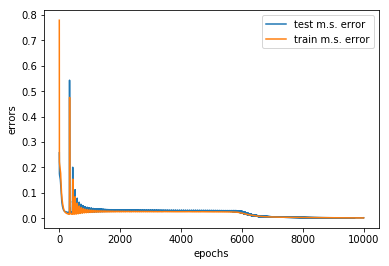

In [259]:
# Test with batch_size = 150

mlp_9 = MLP()
mlp_9.initialize(NI=4, NH=5, NO=1, activation_h=tanh, activation_o=linear)
mlp_9.train(X_train, y_train, n_epochs=10000, batch_size=150, learning_rate=0.0025, X_test=X_test, y_test=y_test)

In [284]:
_ = [print("Prediction: %.4f Target: %.4f"%(mlp_9.predict(v[0])[0], v[1][0])) for v in zip(X_test, y_test)]

Prediction: 0.3695 Target: 0.3362
Prediction: 0.7509 Target: 0.7318
Prediction: -0.1018 Target: -0.1297
Prediction: -0.2796 Target: -0.3323
Prediction: -0.4712 Target: -0.5173
Prediction: 0.9336 Target: 0.8943
Prediction: 0.9603 Target: 0.9418
Prediction: -0.4273 Target: -0.4538
Prediction: -0.9968 Target: -1.0000
Prediction: -0.1547 Target: -0.1933
Prediction: -0.8958 Target: -0.9291
Prediction: -0.6963 Target: -0.9577
Prediction: 0.7110 Target: 0.7043
Prediction: -0.9262 Target: -0.9571
Prediction: 0.6355 Target: 0.5916
Prediction: 0.5502 Target: 0.5377
Prediction: 0.1583 Target: 0.1293
Prediction: 0.5541 Target: 0.5101
Prediction: -0.2330 Target: -0.2799
Prediction: -0.1689 Target: -0.1957
Prediction: 0.1079 Target: 0.0608
Prediction: 0.4214 Target: 0.4366
Prediction: -0.9434 Target: -0.9541
Prediction: 0.8325 Target: 0.8089
Prediction: 0.5647 Target: 0.5122
Prediction: 0.7374 Target: 0.7329
Prediction: -0.8403 Target: -0.8602
Prediction: -0.9748 Target: -0.9990
Prediction: 0.9680 T

Epoch = 0 MSError= 48.32933084355538
Epoch = 1 MSError= 41.50622421722108
Epoch = 2 MSError= 37.92926397021197
Epoch = 3 MSError= 35.80262419573604
Epoch = 4 MSError= 34.40928596331641
Epoch = 5 MSError= 33.40928093810813
Epoch = 6 MSError= 32.62538162681416
Epoch = 7 MSError= 31.960116770826712
Epoch = 8 MSError= 31.358201244669573
Epoch = 9 MSError= 30.787858962195948
Epoch = 10 MSError= 30.230961436348885
Epoch = 11 MSError= 29.677569281498855
Epoch = 12 MSError= 29.122771229590292
Epoch = 13 MSError= 28.564765325366345
Epoch = 14 MSError= 28.00363916398702
Epoch = 15 MSError= 27.440565658045667
Epoch = 16 MSError= 26.87726369172575
Epoch = 17 MSError= 26.315639816664067
Epoch = 18 MSError= 25.75755965169587
Epoch = 19 MSError= 25.204713377048435
Epoch = 20 MSError= 24.65854813245358
Epoch = 21 MSError= 24.12024584057443
Epoch = 22 MSError= 23.590729773207787
Epoch = 23 MSError= 23.0706874720506
Epoch = 24 MSError= 22.560601355583774
Epoch = 25 MSError= 22.060781365576073
Epoch = 26

Epoch = 217 MSError= 3.0837777940478768
Epoch = 218 MSError= 3.0745759772626267
Epoch = 219 MSError= 3.0654358637063526
Epoch = 220 MSError= 3.056356648165836
Epoch = 221 MSError= 3.04733754392647
Epoch = 222 MSError= 3.03837778217019
Epoch = 223 MSError= 3.02947661139954
Epoch = 224 MSError= 3.020633296886505
Epoch = 225 MSError= 3.011847120145031
Epoch = 226 MSError= 3.0031173784260217
Epoch = 227 MSError= 2.994443384233734
Epoch = 228 MSError= 2.985824464862614
Epoch = 229 MSError= 2.9772599619534597
Epoch = 230 MSError= 2.9687492310680867
Epoch = 231 MSError= 2.960291641281558
Epoch = 232 MSError= 2.9518865747911063
Epoch = 233 MSError= 2.9435334265409234
Epoch = 234 MSError= 2.935231603862115
Epoch = 235 MSError= 2.9269805261269664
Epoch = 236 MSError= 2.918779624416903
Epoch = 237 MSError= 2.9106283412034006
Epoch = 238 MSError= 2.902526130041244
Epoch = 239 MSError= 2.8944724552735512
Epoch = 240 MSError= 2.886466791747823
Epoch = 241 MSError= 2.8785086245426843
Epoch = 242 MSEr

Epoch = 427 MSError= 1.924528034343953
Epoch = 428 MSError= 1.9212742490200554
Epoch = 429 MSError= 1.9180335463363622
Epoch = 430 MSError= 1.9148058464160598
Epoch = 431 MSError= 1.9115910700061434
Epoch = 432 MSError= 1.9083891384764966
Epoch = 433 MSError= 1.9051999738188583
Epoch = 434 MSError= 1.9020234986455524
Epoch = 435 MSError= 1.898859636188159
Epoch = 436 MSError= 1.8957083102959762
Epoch = 437 MSError= 1.8925694454343613
Epoch = 438 MSError= 1.8894429666829076
Epoch = 439 MSError= 1.8863287997335214
Epoch = 440 MSError= 1.8832268708882864
Epoch = 441 MSError= 1.8801371070572714
Epoch = 442 MSError= 1.8770594357561472
Epoch = 443 MSError= 1.8739937851036932
Epoch = 444 MSError= 1.8709400838191599
Epoch = 445 MSError= 1.8678982612195354
Epoch = 446 MSError= 1.8648682472166571
Epoch = 447 MSError= 1.861849972314218
Epoch = 448 MSError= 1.8588433676046487
Epoch = 449 MSError= 1.8558483647659036
Epoch = 450 MSError= 1.852864896058114
Epoch = 451 MSError= 1.8498928943201385
Epoc

Epoch = 645 MSError= 1.4320150638980138
Epoch = 646 MSError= 1.4304610402236524
Epoch = 647 MSError= 1.4289114569778782
Epoch = 648 MSError= 1.4273662931700275
Epoch = 649 MSError= 1.425825527887827
Epoch = 650 MSError= 1.4242891402970281
Epoch = 651 MSError= 1.4227571096410623
Epoch = 652 MSError= 1.4212294152406855
Epoch = 653 MSError= 1.4197060364936247
Epoch = 654 MSError= 1.4181869528742441
Epoch = 655 MSError= 1.4166721439332013
Epoch = 656 MSError= 1.4151615892971054
Epoch = 657 MSError= 1.4136552686681796
Epoch = 658 MSError= 1.4121531618239327
Epoch = 659 MSError= 1.4106552486168256
Epoch = 660 MSError= 1.4091615089739469
Epoch = 661 MSError= 1.407671922896684
Epoch = 662 MSError= 1.4061864704603857
Epoch = 663 MSError= 1.4047051318140849
Epoch = 664 MSError= 1.4032278871801165
Epoch = 665 MSError= 1.4017547168538624
Epoch = 666 MSError= 1.4002856012033973
Epoch = 667 MSError= 1.3988205206691908
Epoch = 668 MSError= 1.3973594557637954
Epoch = 669 MSError= 1.395902387071548
Epo

Epoch = 857 MSError= 1.174466977050734
Epoch = 858 MSError= 1.173485610071271
Epoch = 859 MSError= 1.1725055967491764
Epoch = 860 MSError= 1.171526927833043
Epoch = 861 MSError= 1.170549594115513
Epoch = 862 MSError= 1.1695735864332237
Epoch = 863 MSError= 1.168598895666796
Epoch = 864 MSError= 1.1676255127407766
Epoch = 865 MSError= 1.1666534286236239
Epoch = 866 MSError= 1.1656826343276643
Epoch = 867 MSError= 1.1647131209090718
Epoch = 868 MSError= 1.1637448794678158
Epoch = 869 MSError= 1.1627779011476436
Epoch = 870 MSError= 1.1618121771360508
Epoch = 871 MSError= 1.1608476986642333
Epoch = 872 MSError= 1.1598844570070692
Epoch = 873 MSError= 1.158922443483089
Epoch = 874 MSError= 1.1579616494544263
Epoch = 875 MSError= 1.1570020663268037
Epoch = 876 MSError= 1.1560436855494962
Epoch = 877 MSError= 1.155086498615296
Epoch = 878 MSError= 1.154130497060487
Epoch = 879 MSError= 1.1531756724648083
Epoch = 880 MSError= 1.1522220164514296
Epoch = 881 MSError= 1.1512695206869135
Epoch = 

Epoch = 1068 MSError= 0.9865301812012679
Epoch = 1069 MSError= 0.9856945680364583
Epoch = 1070 MSError= 0.9848592724068284
Epoch = 1071 MSError= 0.9840242933588647
Epoch = 1072 MSError= 0.9831896299702316
Epoch = 1073 MSError= 0.9823552813496313
Epoch = 1074 MSError= 0.9815212466366776
Epoch = 1075 MSError= 0.9806875250017837
Epoch = 1076 MSError= 0.9798541156460081
Epoch = 1077 MSError= 0.9790210178009464
Epoch = 1078 MSError= 0.9781882307285937
Epoch = 1079 MSError= 0.9773557537212111
Epoch = 1080 MSError= 0.9765235861011922
Epoch = 1081 MSError= 0.9756917272209374
Epoch = 1082 MSError= 0.9748601764627178
Epoch = 1083 MSError= 0.9740289332385332
Epoch = 1084 MSError= 0.9731979969899852
Epoch = 1085 MSError= 0.9723673671881371
Epoch = 1086 MSError= 0.9715370433333822
Epoch = 1087 MSError= 0.9707070249552953
Epoch = 1088 MSError= 0.9698773116125042
Epoch = 1089 MSError= 0.9690479028925401
Epoch = 1090 MSError= 0.9682187984117163
Epoch = 1091 MSError= 0.967389997814959
Epoch = 1092 MSEr

Epoch = 1269 MSError= 0.8253496091254564
Epoch = 1270 MSError= 0.8245900605704107
Epoch = 1271 MSError= 0.823831053291497
Epoch = 1272 MSError= 0.8230725893135455
Epoch = 1273 MSError= 0.8223146706590919
Epoch = 1274 MSError= 0.821557299348248
Epoch = 1275 MSError= 0.8208004773985528
Epoch = 1276 MSError= 0.8200442068248439
Epoch = 1277 MSError= 0.819288489639127
Epoch = 1278 MSError= 0.818533327850435
Epoch = 1279 MSError= 0.8177787234646963
Epoch = 1280 MSError= 0.817024678484609
Epoch = 1281 MSError= 0.816271194909504
Epoch = 1282 MSError= 0.8155182747352222
Epoch = 1283 MSError= 0.8147659199539804
Epoch = 1284 MSError= 0.8140141325542422
Epoch = 1285 MSError= 0.8132629145206045
Epoch = 1286 MSError= 0.8125122678336519
Epoch = 1287 MSError= 0.8117621944698549
Epoch = 1288 MSError= 0.8110126964014226
Epoch = 1289 MSError= 0.81026377559621
Epoch = 1290 MSError= 0.8095154340175628
Epoch = 1291 MSError= 0.8087676736242271
Epoch = 1292 MSError= 0.8080204963702134
Epoch = 1293 MSError= 0.

Epoch = 1477 MSError= 0.6815219769593331
Epoch = 1478 MSError= 0.6809080850725012
Epoch = 1479 MSError= 0.6802949830234533
Epoch = 1480 MSError= 0.6796826709316192
Epoch = 1481 MSError= 0.6790711489067189
Epoch = 1482 MSError= 0.6784604170488079
Epoch = 1483 MSError= 0.6778504754483115
Epoch = 1484 MSError= 0.6772413241860589
Epoch = 1485 MSError= 0.6766329633333177
Epoch = 1486 MSError= 0.6760253929518488
Epoch = 1487 MSError= 0.6754186130939243
Epoch = 1488 MSError= 0.6748126238023668
Epoch = 1489 MSError= 0.6742074251106163
Epoch = 1490 MSError= 0.673603017042722
Epoch = 1491 MSError= 0.6729993996134279
Epoch = 1492 MSError= 0.6723965728281781
Epoch = 1493 MSError= 0.6717945366831785
Epoch = 1494 MSError= 0.6711932911654185
Epoch = 1495 MSError= 0.6705928362527268
Epoch = 1496 MSError= 0.669993171913799
Epoch = 1497 MSError= 0.6693942981082471
Epoch = 1498 MSError= 0.6687962147866348
Epoch = 1499 MSError= 0.6681989218905185
Epoch = 1500 MSError= 0.6676024193524888
Epoch = 1501 MSErr

Epoch = 1682 MSError= 0.5717841760673348
Epoch = 1683 MSError= 0.5713239441239385
Epoch = 1684 MSError= 0.5708643826608168
Epoch = 1685 MSError= 0.5704054906726053
Epoch = 1686 MSError= 0.569947267152262
Epoch = 1687 MSError= 0.5694897110911025
Epoch = 1688 MSError= 0.569032821478824
Epoch = 1689 MSError= 0.5685765973035345
Epoch = 1690 MSError= 0.5681210375517776
Epoch = 1691 MSError= 0.5676661412085678
Epoch = 1692 MSError= 0.5672119072574007
Epoch = 1693 MSError= 0.566758334680304
Epoch = 1694 MSError= 0.5663054224578482
Epoch = 1695 MSError= 0.5658531695691658
Epoch = 1696 MSError= 0.5654015749920022
Epoch = 1697 MSError= 0.5649506377027206
Epoch = 1698 MSError= 0.5645003566763382
Epoch = 1699 MSError= 0.564050730886547
Epoch = 1700 MSError= 0.5636017593057503
Epoch = 1701 MSError= 0.5631534409050702
Epoch = 1702 MSError= 0.5627057746543885
Epoch = 1703 MSError= 0.5622587595223729
Epoch = 1704 MSError= 0.5618123944764827
Epoch = 1705 MSError= 0.5613666784830242
Epoch = 1706 MSError

Epoch = 1883 MSError= 0.4913635534917173
Epoch = 1884 MSError= 0.49101711896468697
Epoch = 1885 MSError= 0.4906711471727975
Epoch = 1886 MSError= 0.4903256371548604
Epoch = 1887 MSError= 0.48998058795107396
Epoch = 1888 MSError= 0.4896359986030132
Epoch = 1889 MSError= 0.4892918681536482
Epoch = 1890 MSError= 0.48894819564733455
Epoch = 1891 MSError= 0.48860498012983206
Epoch = 1892 MSError= 0.48826222064830116
Epoch = 1893 MSError= 0.48791991625132053
Epoch = 1894 MSError= 0.4875780659888725
Epoch = 1895 MSError= 0.4872366689123689
Epoch = 1896 MSError= 0.48689572407463877
Epoch = 1897 MSError= 0.48655523052994715
Epoch = 1898 MSError= 0.486215187333995
Epoch = 1899 MSError= 0.4858755935439124
Epoch = 1900 MSError= 0.48553644821829084
Epoch = 1901 MSError= 0.4851977504171542
Epoch = 1902 MSError= 0.48485949920199395
Epoch = 1903 MSError= 0.48452169363575176
Epoch = 1904 MSError= 0.4841843327828364
Epoch = 1905 MSError= 0.4838474157091236
Epoch = 1906 MSError= 0.4835109414819631
Epoch 

Epoch = 2081 MSError= 0.43066417920828687
Epoch = 2082 MSError= 0.4303925910808034
Epoch = 2083 MSError= 0.43012130610529503
Epoch = 2084 MSError= 0.42985032363940506
Epoch = 2085 MSError= 0.42957964304238894
Epoch = 2086 MSError= 0.4293092636751169
Epoch = 2087 MSError= 0.4290391849000579
Epoch = 2088 MSError= 0.42876940608129094
Epoch = 2089 MSError= 0.42849992658450464
Epoch = 2090 MSError= 0.4282307457769861
Epoch = 2091 MSError= 0.42796186302762007
Epoch = 2092 MSError= 0.4276932777069014
Epoch = 2093 MSError= 0.42742498918691224
Epoch = 2094 MSError= 0.4271569968413399
Epoch = 2095 MSError= 0.4268893000454546
Epoch = 2096 MSError= 0.4266218981761317
Epoch = 2097 MSError= 0.42635479061183335
Epoch = 2098 MSError= 0.426087976732603
Epoch = 2099 MSError= 0.4258214559200796
Epoch = 2100 MSError= 0.4255552275574873
Epoch = 2101 MSError= 0.4252892910296295
Epoch = 2102 MSError= 0.42502364572289125
Epoch = 2103 MSError= 0.4247582910252439
Epoch = 2104 MSError= 0.4244932263262262
Epoch =

Epoch = 2283 MSError= 0.38119136496779216
Epoch = 2284 MSError= 0.3809700125245285
Epoch = 2285 MSError= 0.3807488632345287
Epoch = 2286 MSError= 0.38052791673419345
Epoch = 2287 MSError= 0.3803071726610285
Epoch = 2288 MSError= 0.3800866306536429
Epoch = 2289 MSError= 0.3798662903517598
Epoch = 2290 MSError= 0.3796461513961966
Epoch = 2291 MSError= 0.3794262134288713
Epoch = 2292 MSError= 0.3792064760927946
Epoch = 2293 MSError= 0.37898693903207736
Epoch = 2294 MSError= 0.37876760189191533
Epoch = 2295 MSError= 0.378548464318595
Epoch = 2296 MSError= 0.37832952595948327
Epoch = 2297 MSError= 0.37811078646303053
Epoch = 2298 MSError= 0.3778922454787749
Epoch = 2299 MSError= 0.37767390265731987
Epoch = 2300 MSError= 0.37745575765034706
Epoch = 2301 MSError= 0.37723781011060886
Epoch = 2302 MSError= 0.3770200596919248
Epoch = 2303 MSError= 0.37680250604918325
Epoch = 2304 MSError= 0.3765851488383362
Epoch = 2305 MSError= 0.3763679877163877
Epoch = 2306 MSError= 0.37615102234140857
Epoch 

Epoch = 2480 MSError= 0.34111192139415963
Epoch = 2481 MSError= 0.3409247997336782
Epoch = 2482 MSError= 0.3407378276935142
Epoch = 2483 MSError= 0.34055100507857144
Epoch = 2484 MSError= 0.34036433169437996
Epoch = 2485 MSError= 0.34017780734708386
Epoch = 2486 MSError= 0.33999143184345293
Epoch = 2487 MSError= 0.339805204990866
Epoch = 2488 MSError= 0.339619126597326
Epoch = 2489 MSError= 0.33943319647143794
Epoch = 2490 MSError= 0.33924741442242634
Epoch = 2491 MSError= 0.3390617802601154
Epoch = 2492 MSError= 0.3388762937949454
Epoch = 2493 MSError= 0.3386909548379519
Epoch = 2494 MSError= 0.3385057632007805
Epoch = 2495 MSError= 0.3383207186956698
Epoch = 2496 MSError= 0.3381358211354639
Epoch = 2497 MSError= 0.3379510703335985
Epoch = 2498 MSError= 0.33776646610410893
Epoch = 2499 MSError= 0.3375820082616104
Epoch = 2500 MSError= 0.3373976966213254
Epoch = 2501 MSError= 0.33721353099905343
Epoch = 2502 MSError= 0.3370295112111856
Epoch = 2503 MSError= 0.3368456370746922
Epoch = 2

Epoch = 2678 MSError= 0.3067653761536247
Epoch = 2679 MSError= 0.30660475135886867
Epoch = 2680 MSError= 0.3064442473692464
Epoch = 2681 MSError= 0.3062838640787381
Epoch = 2682 MSError= 0.3061236013816328
Epoch = 2683 MSError= 0.30596345917252393
Epoch = 2684 MSError= 0.3058034373463003
Epoch = 2685 MSError= 0.30564353579816106
Epoch = 2686 MSError= 0.30548375442359427
Epoch = 2687 MSError= 0.30532409311839415
Epoch = 2688 MSError= 0.3051645517786509
Epoch = 2689 MSError= 0.3050051303007473
Epoch = 2690 MSError= 0.30484582858136616
Epoch = 2691 MSError= 0.3046866465174749
Epoch = 2692 MSError= 0.30452758400634683
Epoch = 2693 MSError= 0.3043686409455357
Epoch = 2694 MSError= 0.30420981723288965
Epoch = 2695 MSError= 0.30405111276654634
Epoch = 2696 MSError= 0.30389252744493184
Epoch = 2697 MSError= 0.3037340611667563
Epoch = 2698 MSError= 0.3035757138310175
Epoch = 2699 MSError= 0.3034174853369978
Epoch = 2700 MSError= 0.30325937558426397
Epoch = 2701 MSError= 0.30310138447266105
Epoc

Epoch = 2878 MSError= 0.2769221531062608
Epoch = 2879 MSError= 0.27678391110504486
Epoch = 2880 MSError= 0.2766457734191105
Epoch = 2881 MSError= 0.2765077399839912
Epoch = 2882 MSError= 0.2763698107353589
Epoch = 2883 MSError= 0.2762319856090035
Epoch = 2884 MSError= 0.27609426454084773
Epoch = 2885 MSError= 0.275956647466949
Epoch = 2886 MSError= 0.27581913432348365
Epoch = 2887 MSError= 0.2756817250467532
Epoch = 2888 MSError= 0.2755444195731951
Epoch = 2889 MSError= 0.2754072178393648
Epoch = 2890 MSError= 0.27527011978194593
Epoch = 2891 MSError= 0.2751331253377473
Epoch = 2892 MSError= 0.27499623444369636
Epoch = 2893 MSError= 0.27485944703685233
Epoch = 2894 MSError= 0.27472276305438986
Epoch = 2895 MSError= 0.2745861824336088
Epoch = 2896 MSError= 0.27444970511193
Epoch = 2897 MSError= 0.2743133310268984
Epoch = 2898 MSError= 0.27417706011617177
Epoch = 2899 MSError= 0.2740408923175368
Epoch = 2900 MSError= 0.27390482756889234
Epoch = 2901 MSError= 0.27376886580826015
Epoch = 2

Epoch = 3081 MSError= 0.2509166965250312
Epoch = 3082 MSError= 0.25079845109630816
Epoch = 3083 MSError= 0.2506802988620735
Epoch = 3084 MSError= 0.2505622397744166
Epoch = 3085 MSError= 0.25044427378547146
Epoch = 3086 MSError= 0.25032640084741997
Epoch = 3087 MSError= 0.25020862091248336
Epoch = 3088 MSError= 0.25009093393292653
Epoch = 3089 MSError= 0.24997333986106135
Epoch = 3090 MSError= 0.24985583864923425
Epoch = 3091 MSError= 0.24973843024984255
Epoch = 3092 MSError= 0.24962111461531897
Epoch = 3093 MSError= 0.24950389169814222
Epoch = 3094 MSError= 0.2493867614508287
Epoch = 3095 MSError= 0.2492697238259407
Epoch = 3096 MSError= 0.24915277877607933
Epoch = 3097 MSError= 0.24903592625388127
Epoch = 3098 MSError= 0.24891916621203306
Epoch = 3099 MSError= 0.24880249860325376
Epoch = 3100 MSError= 0.24868592338030637
Epoch = 3101 MSError= 0.2485694404959936
Epoch = 3102 MSError= 0.2484530499031533
Epoch = 3103 MSError= 0.2483367515546664
Epoch = 3104 MSError= 0.2482205454034513
E

Epoch = 3287 MSError= 0.22845964381615239
Epoch = 3288 MSError= 0.22835963087897748
Epoch = 3289 MSError= 0.22825970187259745
Epoch = 3290 MSError= 0.22815985675374348
Epoch = 3291 MSError= 0.2280600954791545
Epoch = 3292 MSError= 0.22796041800558128
Epoch = 3293 MSError= 0.2278608242897714
Epoch = 3294 MSError= 0.2277613142884862
Epoch = 3295 MSError= 0.2276618879584953
Epoch = 3296 MSError= 0.2275625452565665
Epoch = 3297 MSError= 0.22746328613948325
Epoch = 3298 MSError= 0.22736411056402817
Epoch = 3299 MSError= 0.22726501848699177
Epoch = 3300 MSError= 0.22716600986517507
Epoch = 3301 MSError= 0.22706708465537734
Epoch = 3302 MSError= 0.22696824281441108
Epoch = 3303 MSError= 0.2268694842990875
Epoch = 3304 MSError= 0.2267708090662292
Epoch = 3305 MSError= 0.22667221707266466
Epoch = 3306 MSError= 0.22657370827522066
Epoch = 3307 MSError= 0.2264752826307372
Epoch = 3308 MSError= 0.22637694009605638
Epoch = 3309 MSError= 0.22627868062802384
Epoch = 3310 MSError= 0.22618050418349228


Epoch = 3496 MSError= 0.2093166390973788
Epoch = 3497 MSError= 0.20923323145799333
Epoch = 3498 MSError= 0.2091498987449042
Epoch = 3499 MSError= 0.20906664091483926
Epoch = 3500 MSError= 0.20898345792452383
Epoch = 3501 MSError= 0.2089003497306791
Epoch = 3502 MSError= 0.20881731629002181
Epoch = 3503 MSError= 0.20873435755926606
Epoch = 3504 MSError= 0.2086514734951209
Epoch = 3505 MSError= 0.2085686640542918
Epoch = 3506 MSError= 0.20848592919348052
Epoch = 3507 MSError= 0.2084032688693832
Epoch = 3508 MSError= 0.2083206830386936
Epoch = 3509 MSError= 0.20823817165810166
Epoch = 3510 MSError= 0.20815573468429246
Epoch = 3511 MSError= 0.2080733720739494
Epoch = 3512 MSError= 0.20799108378374523
Epoch = 3513 MSError= 0.20790886977035938
Epoch = 3514 MSError= 0.20782672999045432
Epoch = 3515 MSError= 0.2077446644007019
Epoch = 3516 MSError= 0.2076626729577574
Epoch = 3517 MSError= 0.20758075561828065
Epoch = 3518 MSError= 0.207498912338926
Epoch = 3519 MSError= 0.20741714307633988
Epoc

Epoch = 3708 MSError= 0.19324194462607044
Epoch = 3709 MSError= 0.1931734473164346
Epoch = 3710 MSError= 0.19310501567346172
Epoch = 3711 MSError= 0.1930366496531507
Epoch = 3712 MSError= 0.19296834921150066
Epoch = 3713 MSError= 0.19290011430450993
Epoch = 3714 MSError= 0.1928319448881715
Epoch = 3715 MSError= 0.19276384091848436
Epoch = 3716 MSError= 0.1926958023514375
Epoch = 3717 MSError= 0.19262782914302273
Epoch = 3718 MSError= 0.19255992124923182
Epoch = 3719 MSError= 0.19249207862605203
Epoch = 3720 MSError= 0.19242430122947182
Epoch = 3721 MSError= 0.1923565890154766
Epoch = 3722 MSError= 0.19228894194005214
Epoch = 3723 MSError= 0.19222135995918235
Epoch = 3724 MSError= 0.19215384302884794
Epoch = 3725 MSError= 0.19208639110503245
Epoch = 3726 MSError= 0.19201900414371612
Epoch = 3727 MSError= 0.19195168210087518
Epoch = 3728 MSError= 0.19188442493249017
Epoch = 3729 MSError= 0.1918172325945382
Epoch = 3730 MSError= 0.1917501050429937
Epoch = 3731 MSError= 0.19168304223383467

Epoch = 3906 MSError= 0.18090408967097535
Epoch = 3907 MSError= 0.18084773624410044
Epoch = 3908 MSError= 0.18079143978323625
Epoch = 3909 MSError= 0.18073520024472864
Epoch = 3910 MSError= 0.18067901758493096
Epoch = 3911 MSError= 0.18062289176020543
Epoch = 3912 MSError= 0.18056682272691396
Epoch = 3913 MSError= 0.1805108104414244
Epoch = 3914 MSError= 0.1804548548601151
Epoch = 3915 MSError= 0.18039895593936645
Epoch = 3916 MSError= 0.18034311363556502
Epoch = 3917 MSError= 0.18028732790510174
Epoch = 3918 MSError= 0.18023159870437844
Epoch = 3919 MSError= 0.18017592598979473
Epoch = 3920 MSError= 0.1801203097177628
Epoch = 3921 MSError= 0.18006474984469842
Epoch = 3922 MSError= 0.18000924632702325
Epoch = 3923 MSError= 0.17995379912116222
Epoch = 3924 MSError= 0.1798984081835517
Epoch = 3925 MSError= 0.17984307347063067
Epoch = 3926 MSError= 0.17978779493884198
Epoch = 3927 MSError= 0.17973257254464092
Epoch = 3928 MSError= 0.1796774062444835
Epoch = 3929 MSError= 0.179622295994831

Epoch = 4110 MSError= 0.1705271577476615
Epoch = 4111 MSError= 0.17048153180418826
Epoch = 4112 MSError= 0.1704359540878255
Epoch = 4113 MSError= 0.1703904245568167
Epoch = 4114 MSError= 0.170344943169424
Epoch = 4115 MSError= 0.17029950988391865
Epoch = 4116 MSError= 0.1702541246585873
Epoch = 4117 MSError= 0.1702087874517313
Epoch = 4118 MSError= 0.17016349822166213
Epoch = 4119 MSError= 0.1701182569267061
Epoch = 4120 MSError= 0.17007306352520185
Epoch = 4121 MSError= 0.17002791797550276
Epoch = 4122 MSError= 0.1699828202359742
Epoch = 4123 MSError= 0.169937770264996
Epoch = 4124 MSError= 0.16989276802096004
Epoch = 4125 MSError= 0.16984781346227323
Epoch = 4126 MSError= 0.16980290654735625
Epoch = 4127 MSError= 0.16975804723463836
Epoch = 4128 MSError= 0.16971323548257033
Epoch = 4129 MSError= 0.16966847124961185
Epoch = 4130 MSError= 0.16962375449423486
Epoch = 4131 MSError= 0.16957908517492692
Epoch = 4132 MSError= 0.16953446325019145
Epoch = 4133 MSError= 0.16948988867854198
Epo

Epoch = 4308 MSError= 0.16238148349693973
Epoch = 4309 MSError= 0.16234461087702123
Epoch = 4310 MSError= 0.1623077785125839
Epoch = 4311 MSError= 0.16227098636506734
Epoch = 4312 MSError= 0.16223423439592816
Epoch = 4313 MSError= 0.1621975225666422
Epoch = 4314 MSError= 0.1621608508387008
Epoch = 4315 MSError= 0.1621242191736199
Epoch = 4316 MSError= 0.16208762753293302
Epoch = 4317 MSError= 0.1620510758781871
Epoch = 4318 MSError= 0.16201456417095733
Epoch = 4319 MSError= 0.16197809237282823
Epoch = 4320 MSError= 0.16194166044540997
Epoch = 4321 MSError= 0.1619052683503311
Epoch = 4322 MSError= 0.1618689160492356
Epoch = 4323 MSError= 0.1618326035037893
Epoch = 4324 MSError= 0.16179633067567672
Epoch = 4325 MSError= 0.16176009752660028
Epoch = 4326 MSError= 0.16172390401828401
Epoch = 4327 MSError= 0.1616877501124694
Epoch = 4328 MSError= 0.16165163577091698
Epoch = 4329 MSError= 0.16161556095540786
Epoch = 4330 MSError= 0.1615795256277397
Epoch = 4331 MSError= 0.1615435297497333
Epo

Epoch = 4510 MSError= 0.15569957435745413
Epoch = 4511 MSError= 0.15567007736003818
Epoch = 4512 MSError= 0.155640613237771
Epoch = 4513 MSError= 0.15561118195627502
Epoch = 4514 MSError= 0.15558178348120108
Epoch = 4515 MSError= 0.15555241777821696
Epoch = 4516 MSError= 0.1555230848130151
Epoch = 4517 MSError= 0.15549378455130955
Epoch = 4518 MSError= 0.15546451695883629
Epoch = 4519 MSError= 0.15543528200135556
Epoch = 4520 MSError= 0.15540607964464784
Epoch = 4521 MSError= 0.15537690985451522
Epoch = 4522 MSError= 0.15534777259678503
Epoch = 4523 MSError= 0.15531866783730452
Epoch = 4524 MSError= 0.1552895955419443
Epoch = 4525 MSError= 0.15526055567659722
Epoch = 4526 MSError= 0.15523154820717816
Epoch = 4527 MSError= 0.15520257309962412
Epoch = 4528 MSError= 0.15517363031989456
Epoch = 4529 MSError= 0.15514471983397302
Epoch = 4530 MSError= 0.1551158416078652
Epoch = 4531 MSError= 0.1550869956075942
Epoch = 4532 MSError= 0.15505818179921263
Epoch = 4533 MSError= 0.1550294001487906

Epoch = 4709 MSError= 0.15043430568293512
Epoch = 4710 MSError= 0.15041070291987504
Epoch = 4711 MSError= 0.15038712663959714
Epoch = 4712 MSError= 0.1503635768122872
Epoch = 4713 MSError= 0.1503400534081557
Epoch = 4714 MSError= 0.1503165563974389
Epoch = 4715 MSError= 0.1502930857503906
Epoch = 4716 MSError= 0.15026964143729268
Epoch = 4717 MSError= 0.15024622342845048
Epoch = 4718 MSError= 0.15022283169418682
Epoch = 4719 MSError= 0.15019946620485622
Epoch = 4720 MSError= 0.15017612693082844
Epoch = 4721 MSError= 0.15015281384250223
Epoch = 4722 MSError= 0.15012952691029643
Epoch = 4723 MSError= 0.1501062661046554
Epoch = 4724 MSError= 0.15008303139604487
Epoch = 4725 MSError= 0.15005982275495627
Epoch = 4726 MSError= 0.1500366401519003
Epoch = 4727 MSError= 0.15001348355741403
Epoch = 4728 MSError= 0.14999035294205748
Epoch = 4729 MSError= 0.1499672482764135
Epoch = 4730 MSError= 0.14994416953108838
Epoch = 4731 MSError= 0.14992111667670965
Epoch = 4732 MSError= 0.14989808968393442

Epoch = 4905 MSError= 0.14627879306478728
Epoch = 4906 MSError= 0.14625983987924818
Epoch = 4907 MSError= 0.14624090777565868
Epoch = 4908 MSError= 0.14622199672871752
Epoch = 4909 MSError= 0.14620310671315023
Epoch = 4910 MSError= 0.14618423770370254
Epoch = 4911 MSError= 0.14616538967514145
Epoch = 4912 MSError= 0.1461465626022611
Epoch = 4913 MSError= 0.14612775645987344
Epoch = 4914 MSError= 0.1461089712228148
Epoch = 4915 MSError= 0.14609020686594243
Epoch = 4916 MSError= 0.14607146336414065
Epoch = 4917 MSError= 0.14605274069231117
Epoch = 4918 MSError= 0.1460340388253801
Epoch = 4919 MSError= 0.14601535773829827
Epoch = 4920 MSError= 0.14599669740603327
Epoch = 4921 MSError= 0.14597805780358267
Epoch = 4922 MSError= 0.1459594389059577
Epoch = 4923 MSError= 0.14594084068820148
Epoch = 4924 MSError= 0.14592226312537218
Epoch = 4925 MSError= 0.14590370619255333
Epoch = 4926 MSError= 0.14588516986485175
Epoch = 4927 MSError= 0.1458666541173938
Epoch = 4928 MSError= 0.145848158925331

Epoch = 5106 MSError= 0.14286068542460081
Epoch = 5107 MSError= 0.14284549070852695
Epoch = 5108 MSError= 0.14283031243098723
Epoch = 5109 MSError= 0.1428151505710341
Epoch = 5110 MSError= 0.14280000510773974
Epoch = 5111 MSError= 0.14278487602019815
Epoch = 5112 MSError= 0.14276976328752056
Epoch = 5113 MSError= 0.14275466688884256
Epoch = 5114 MSError= 0.1427395868033183
Epoch = 5115 MSError= 0.14272452301012237
Epoch = 5116 MSError= 0.1427094754884514
Epoch = 5117 MSError= 0.1426944442175205
Epoch = 5118 MSError= 0.14267942917656637
Epoch = 5119 MSError= 0.14266443034484616
Epoch = 5120 MSError= 0.14264944770163906
Epoch = 5121 MSError= 0.1426344812262399
Epoch = 5122 MSError= 0.14261953089796903
Epoch = 5123 MSError= 0.14260459669616593
Epoch = 5124 MSError= 0.1425896786001876
Epoch = 5125 MSError= 0.14257477658941548
Epoch = 5126 MSError= 0.1425598906432502
Epoch = 5127 MSError= 0.1425450207411095
Epoch = 5128 MSError= 0.14253016686243866
Epoch = 5129 MSError= 0.14251532898669395


Epoch = 5310 MSError= 0.14007354137931935
Epoch = 5311 MSError= 0.14006129420601107
Epoch = 5312 MSError= 0.14004905960666256
Epoch = 5313 MSError= 0.14003683756426474
Epoch = 5314 MSError= 0.1400246280618258
Epoch = 5315 MSError= 0.14001243108236666
Epoch = 5316 MSError= 0.14000024660893326
Epoch = 5317 MSError= 0.1399880746245872
Epoch = 5318 MSError= 0.1399759151124047
Epoch = 5319 MSError= 0.13996376805548302
Epoch = 5320 MSError= 0.13995163343693676
Epoch = 5321 MSError= 0.13993951123989692
Epoch = 5322 MSError= 0.13992740144751536
Epoch = 5323 MSError= 0.13991530404295857
Epoch = 5324 MSError= 0.13990321900941136
Epoch = 5325 MSError= 0.13989114633008048
Epoch = 5326 MSError= 0.139879085988183
Epoch = 5327 MSError= 0.13986703796695926
Epoch = 5328 MSError= 0.13985500224966826
Epoch = 5329 MSError= 0.13984297881957972
Epoch = 5330 MSError= 0.13983096765998887
Epoch = 5331 MSError= 0.1398189687542051
Epoch = 5332 MSError= 0.13980698208555387
Epoch = 5333 MSError= 0.1397950076373829

Epoch = 5510 MSError= 0.13785311067452266
Epoch = 5511 MSError= 0.13784306241735697
Epoch = 5512 MSError= 0.1378330236702938
Epoch = 5513 MSError= 0.13782299441962978
Epoch = 5514 MSError= 0.13781297465167294
Epoch = 5515 MSError= 0.13780296435274936
Epoch = 5516 MSError= 0.13779296350919643
Epoch = 5517 MSError= 0.13778297210737078
Epoch = 5518 MSError= 0.13777299013363903
Epoch = 5519 MSError= 0.13776301757438775
Epoch = 5520 MSError= 0.13775305441601662
Epoch = 5521 MSError= 0.1377431006449407
Epoch = 5522 MSError= 0.13773315624758903
Epoch = 5523 MSError= 0.13772322121040456
Epoch = 5524 MSError= 0.1377132955198501
Epoch = 5525 MSError= 0.13770337916239753
Epoch = 5526 MSError= 0.13769347212453645
Epoch = 5527 MSError= 0.13768357439277268
Epoch = 5528 MSError= 0.13767368595362314
Epoch = 5529 MSError= 0.13766380679362394
Epoch = 5530 MSError= 0.13765393689932476
Epoch = 5531 MSError= 0.13764407625728517
Epoch = 5532 MSError= 0.13763422485408824
Epoch = 5533 MSError= 0.1376243826763

Epoch = 5711 MSError= 0.13600724970274003
Epoch = 5712 MSError= 0.13599885668560222
Epoch = 5713 MSError= 0.13599047070833953
Epoch = 5714 MSError= 0.1359820917599993
Epoch = 5715 MSError= 0.1359737198296404
Epoch = 5716 MSError= 0.13596535490633146
Epoch = 5717 MSError= 0.13595699697915994
Epoch = 5718 MSError= 0.13594864603721554
Epoch = 5719 MSError= 0.13594030206960991
Epoch = 5720 MSError= 0.13593196506546126
Epoch = 5721 MSError= 0.1359236350139023
Epoch = 5722 MSError= 0.135915311904078
Epoch = 5723 MSError= 0.13590699572514256
Epoch = 5724 MSError= 0.13589868646626624
Epoch = 5725 MSError= 0.1358903841166291
Epoch = 5726 MSError= 0.13588208866542556
Epoch = 5727 MSError= 0.1358738001018574
Epoch = 5728 MSError= 0.13586551841514485
Epoch = 5729 MSError= 0.13585724359451753
Epoch = 5730 MSError= 0.13584897562921305
Epoch = 5731 MSError= 0.13584071450848792
Epoch = 5732 MSError= 0.13583246022160933
Epoch = 5733 MSError= 0.13582421275785006
Epoch = 5734 MSError= 0.13581597210650362

Epoch = 5911 MSError= 0.13445511487519027
Epoch = 5912 MSError= 0.13444792714714718
Epoch = 5913 MSError= 0.13444074449560792
Epoch = 5914 MSError= 0.13443356691182112
Epoch = 5915 MSError= 0.13442639438704038
Epoch = 5916 MSError= 0.134419226912529
Epoch = 5917 MSError= 0.13441206447956086
Epoch = 5918 MSError= 0.13440490707941954
Epoch = 5919 MSError= 0.13439775470340187
Epoch = 5920 MSError= 0.13439060734280778
Epoch = 5921 MSError= 0.13438346498895093
Epoch = 5922 MSError= 0.13437632763315457
Epoch = 5923 MSError= 0.13436919526674868
Epoch = 5924 MSError= 0.13436206788107885
Epoch = 5925 MSError= 0.1343549454674927
Epoch = 5926 MSError= 0.13434782801735234
Epoch = 5927 MSError= 0.13434071552202978
Epoch = 5928 MSError= 0.1343336079729024
Epoch = 5929 MSError= 0.1343265053613605
Epoch = 5930 MSError= 0.1343194076788041
Epoch = 5931 MSError= 0.13431231491664183
Epoch = 5932 MSError= 0.134305227066291
Epoch = 5933 MSError= 0.13429814411917887
Epoch = 5934 MSError= 0.13429106606674357


Epoch = 6115 MSError= 0.13308237360006892
Epoch = 6116 MSError= 0.13307605291265798
Epoch = 6117 MSError= 0.13306973570042877
Epoch = 6118 MSError= 0.13306342195636092
Epoch = 6119 MSError= 0.13305711167344988
Epoch = 6120 MSError= 0.13305080484469456
Epoch = 6121 MSError= 0.13304450146309918
Epoch = 6122 MSError= 0.13303820152167933
Epoch = 6123 MSError= 0.13303190501345538
Epoch = 6124 MSError= 0.13302561193145376
Epoch = 6125 MSError= 0.1330193222687129
Epoch = 6126 MSError= 0.13301303601827405
Epoch = 6127 MSError= 0.13300675317318722
Epoch = 6128 MSError= 0.13300047372651197
Epoch = 6129 MSError= 0.13299419767131068
Epoch = 6130 MSError= 0.13298792500065515
Epoch = 6131 MSError= 0.13298165570762702
Epoch = 6132 MSError= 0.1329753897853112
Epoch = 6133 MSError= 0.13296912722680007
Epoch = 6134 MSError= 0.13296286802519564
Epoch = 6135 MSError= 0.13295661217360724
Epoch = 6136 MSError= 0.13295035966514823
Epoch = 6137 MSError= 0.13294411049294244
Epoch = 6138 MSError= 0.132937864650

Epoch = 6318 MSError= 0.13186136529038836
Epoch = 6319 MSError= 0.13185561561883766
Epoch = 6320 MSError= 0.13184986813496738
Epoch = 6321 MSError= 0.131844122833042
Epoch = 6322 MSError= 0.13183837970733658
Epoch = 6323 MSError= 0.13183263875213
Epoch = 6324 MSError= 0.1318268999617042
Epoch = 6325 MSError= 0.13182116333034954
Epoch = 6326 MSError= 0.13181542885235847
Epoch = 6327 MSError= 0.13180969652203176
Epoch = 6328 MSError= 0.1318039663336745
Epoch = 6329 MSError= 0.13179823828159581
Epoch = 6330 MSError= 0.13179251236011197
Epoch = 6331 MSError= 0.13178678856354215
Epoch = 6332 MSError= 0.13178106688621324
Epoch = 6333 MSError= 0.13177534732245566
Epoch = 6334 MSError= 0.13176962986660465
Epoch = 6335 MSError= 0.13176391451300307
Epoch = 6336 MSError= 0.13175820125599585
Epoch = 6337 MSError= 0.13175249008993573
Epoch = 6338 MSError= 0.13174678100917853
Epoch = 6339 MSError= 0.13174107400808815
Epoch = 6340 MSError= 0.1317353690810283
Epoch = 6341 MSError= 0.13172966622237478


Epoch = 6520 MSError= 0.13073691860959816
Epoch = 6521 MSError= 0.13073150104583628
Epoch = 6522 MSError= 0.1307260846072468
Epoch = 6523 MSError= 0.1307206692889839
Epoch = 6524 MSError= 0.13071525508620874
Epoch = 6525 MSError= 0.13070984199408442
Epoch = 6526 MSError= 0.13070443000777662
Epoch = 6527 MSError= 0.1306990191224565
Epoch = 6528 MSError= 0.1306936093332986
Epoch = 6529 MSError= 0.13068820063547731
Epoch = 6530 MSError= 0.13068279302417615
Epoch = 6531 MSError= 0.13067738649457722
Epoch = 6532 MSError= 0.13067198104186808
Epoch = 6533 MSError= 0.1306665766612407
Epoch = 6534 MSError= 0.1306611733478891
Epoch = 6535 MSError= 0.1306557710970106
Epoch = 6536 MSError= 0.1306503699038066
Epoch = 6537 MSError= 0.1306449697634817
Epoch = 6538 MSError= 0.13063957067124468
Epoch = 6539 MSError= 0.1306341726223048
Epoch = 6540 MSError= 0.13062877561187874
Epoch = 6541 MSError= 0.1306233796351848
Epoch = 6542 MSError= 0.13061798468744268
Epoch = 6543 MSError= 0.1306125907638794
Epoc

Epoch = 6717 MSError= 0.1296854970855961
Epoch = 6718 MSError= 0.12968021157448031
Epoch = 6719 MSError= 0.12967492629187957
Epoch = 6720 MSError= 0.12966964123348898
Epoch = 6721 MSError= 0.1296643563950006
Epoch = 6722 MSError= 0.12965907177211336
Epoch = 6723 MSError= 0.1296537873605208
Epoch = 6724 MSError= 0.1296485031559255
Epoch = 6725 MSError= 0.12964321915402868
Epoch = 6726 MSError= 0.12963793535053506
Epoch = 6727 MSError= 0.12963265174115
Epoch = 6728 MSError= 0.1296273683215789
Epoch = 6729 MSError= 0.12962208508753312
Epoch = 6730 MSError= 0.12961680203472303
Epoch = 6731 MSError= 0.1296115191588625
Epoch = 6732 MSError= 0.12960623645566582
Epoch = 6733 MSError= 0.1296009539208518
Epoch = 6734 MSError= 0.12959567155013627
Epoch = 6735 MSError= 0.12959038933923983
Epoch = 6736 MSError= 0.12958510728388867
Epoch = 6737 MSError= 0.1295798253798027
Epoch = 6738 MSError= 0.1295745436227114
Epoch = 6739 MSError= 0.12956926200833874
Epoch = 6740 MSError= 0.12956398053241816
Epoc

Epoch = 6919 MSError= 0.12861674415996344
Epoch = 6920 MSError= 0.12861141949599303
Epoch = 6921 MSError= 0.128606094219986
Epoch = 6922 MSError= 0.12860076832787595
Epoch = 6923 MSError= 0.12859544181560473
Epoch = 6924 MSError= 0.128590114679111
Epoch = 6925 MSError= 0.12858478691433364
Epoch = 6926 MSError= 0.12857945851721447
Epoch = 6927 MSError= 0.12857412948369273
Epoch = 6928 MSError= 0.12856879980971014
Epoch = 6929 MSError= 0.12856346949120775
Epoch = 6930 MSError= 0.12855813852412715
Epoch = 6931 MSError= 0.1285528069044129
Epoch = 6932 MSError= 0.12854747462800656
Epoch = 6933 MSError= 0.12854214169085088
Epoch = 6934 MSError= 0.12853680808889154
Epoch = 6935 MSError= 0.1285314738180702
Epoch = 6936 MSError= 0.128526138874335
Epoch = 6937 MSError= 0.12852080325362764
Epoch = 6938 MSError= 0.12851546695189614
Epoch = 6939 MSError= 0.12851012996508393
Epoch = 6940 MSError= 0.1285047922891397
Epoch = 6941 MSError= 0.12849945392001058
Epoch = 6942 MSError= 0.12849411485363985
E

Epoch = 7119 MSError= 0.12753431303637325
Epoch = 7120 MSError= 0.1275287853746866
Epoch = 7121 MSError= 0.12752325629010494
Epoch = 7122 MSError= 0.12751772577853873
Epoch = 7123 MSError= 0.12751219383590065
Epoch = 7124 MSError= 0.12750666045809522
Epoch = 7125 MSError= 0.12750112564103744
Epoch = 7126 MSError= 0.1274955893806313
Epoch = 7127 MSError= 0.12749005167278668
Epoch = 7128 MSError= 0.12748451251340795
Epoch = 7129 MSError= 0.1274789718984032
Epoch = 7130 MSError= 0.1274734298236747
Epoch = 7131 MSError= 0.12746788628512953
Epoch = 7132 MSError= 0.12746234127866857
Epoch = 7133 MSError= 0.1274567948001959
Epoch = 7134 MSError= 0.1274512468456131
Epoch = 7135 MSError= 0.12744569741082212
Epoch = 7136 MSError= 0.12744014649172122
Epoch = 7137 MSError= 0.12743459408420948
Epoch = 7138 MSError= 0.12742904018418796
Epoch = 7139 MSError= 0.12742348478755167
Epoch = 7140 MSError= 0.12741792789019946
Epoch = 7141 MSError= 0.12741236948802526
Epoch = 7142 MSError= 0.1274068095769255

Epoch = 7323 MSError= 0.12637143905774414
Epoch = 7324 MSError= 0.1263655350374393
Epoch = 7325 MSError= 0.12635962873716733
Epoch = 7326 MSError= 0.12635372015257992
Epoch = 7327 MSError= 0.12634780927932582
Epoch = 7328 MSError= 0.1263418961130536
Epoch = 7329 MSError= 0.1263359806494078
Epoch = 7330 MSError= 0.12633006288403276
Epoch = 7331 MSError= 0.12632414281257448
Epoch = 7332 MSError= 0.1263182204306672
Epoch = 7333 MSError= 0.12631229573395478
Epoch = 7334 MSError= 0.12630636871807344
Epoch = 7335 MSError= 0.1263004393786564
Epoch = 7336 MSError= 0.12629450771134135
Epoch = 7337 MSError= 0.1262885737117551
Epoch = 7338 MSError= 0.1262826373755339
Epoch = 7339 MSError= 0.12627669869830108
Epoch = 7340 MSError= 0.12627075767568288
Epoch = 7341 MSError= 0.12626481430330666
Epoch = 7342 MSError= 0.1262588685767935
Epoch = 7343 MSError= 0.12625292049176598
Epoch = 7344 MSError= 0.12624697004384297
Epoch = 7345 MSError= 0.1262410172286435
Epoch = 7346 MSError= 0.12623506204177898
E

Epoch = 7530 MSError= 0.1250942211390044
Epoch = 7531 MSError= 0.12508774968829678
Epoch = 7532 MSError= 0.12508127501624378
Epoch = 7533 MSError= 0.125074797118079
Epoch = 7534 MSError= 0.12506831598904256
Epoch = 7535 MSError= 0.12506183162436688
Epoch = 7536 MSError= 0.12505534401928178
Epoch = 7537 MSError= 0.1250488531690188
Epoch = 7538 MSError= 0.12504235906880704
Epoch = 7539 MSError= 0.1250358617138692
Epoch = 7540 MSError= 0.12502936109942955
Epoch = 7541 MSError= 0.12502285722071022
Epoch = 7542 MSError= 0.12501635007292902
Epoch = 7543 MSError= 0.12500983965130427
Epoch = 7544 MSError= 0.12500332595105015
Epoch = 7545 MSError= 0.12499680896737904
Epoch = 7546 MSError= 0.12499028869550366
Epoch = 7547 MSError= 0.12498376513063093
Epoch = 7548 MSError= 0.12497723826796783
Epoch = 7549 MSError= 0.1249707081027189
Epoch = 7550 MSError= 0.12496417463008735
Epoch = 7551 MSError= 0.12495763784527118
Epoch = 7552 MSError= 0.12495109774347098
Epoch = 7553 MSError= 0.1249445543198813

Epoch = 7730 MSError= 0.12372943967864831
Epoch = 7731 MSError= 0.12372222654811486
Epoch = 7732 MSError= 0.12371500920480465
Epoch = 7733 MSError= 0.12370778764359348
Epoch = 7734 MSError= 0.12370056185935015
Epoch = 7735 MSError= 0.12369333184694571
Epoch = 7736 MSError= 0.1236860976012485
Epoch = 7737 MSError= 0.12367885911712669
Epoch = 7738 MSError= 0.12367161638944468
Epoch = 7739 MSError= 0.12366436941307028
Epoch = 7740 MSError= 0.12365711818286376
Epoch = 7741 MSError= 0.12364986269369162
Epoch = 7742 MSError= 0.12364260294041285
Epoch = 7743 MSError= 0.12363533891788774
Epoch = 7744 MSError= 0.12362807062097413
Epoch = 7745 MSError= 0.12362079804453104
Epoch = 7746 MSError= 0.12361352118341591
Epoch = 7747 MSError= 0.1236062400324823
Epoch = 7748 MSError= 0.12359895458658576
Epoch = 7749 MSError= 0.12359166484057835
Epoch = 7750 MSError= 0.1235843707893121
Epoch = 7751 MSError= 0.12357707242763637
Epoch = 7752 MSError= 0.12356976975040482
Epoch = 7753 MSError= 0.1235624627524

Epoch = 7928 MSError= 0.12221248874817654
Epoch = 7929 MSError= 0.1222043404877102
Epoch = 7930 MSError= 0.12219618698794953
Epoch = 7931 MSError= 0.12218802824374198
Epoch = 7932 MSError= 0.12217986424993824
Epoch = 7933 MSError= 0.1221716950013844
Epoch = 7934 MSError= 0.12216352049293618
Epoch = 7935 MSError= 0.12215534071944208
Epoch = 7936 MSError= 0.12214715567576158
Epoch = 7937 MSError= 0.12213896535674586
Epoch = 7938 MSError= 0.12213076975725501
Epoch = 7939 MSError= 0.12212256887214795
Epoch = 7940 MSError= 0.12211436269628628
Epoch = 7941 MSError= 0.12210615122452759
Epoch = 7942 MSError= 0.12209793445174223
Epoch = 7943 MSError= 0.12208971237279044
Epoch = 7944 MSError= 0.12208148498254254
Epoch = 7945 MSError= 0.12207325227586609
Epoch = 7946 MSError= 0.12206501424763079
Epoch = 7947 MSError= 0.12205677089271072
Epoch = 7948 MSError= 0.1220485222059782
Epoch = 7949 MSError= 0.12204026818231022
Epoch = 7950 MSError= 0.12203200881658445
Epoch = 7951 MSError= 0.1220237441036

Epoch = 8126 MSError= 0.12049052567669111
Epoch = 8127 MSError= 0.12048124271556195
Epoch = 8128 MSError= 0.12047195355139849
Epoch = 8129 MSError= 0.12046265817978978
Epoch = 8130 MSError= 0.12045335659633062
Epoch = 8131 MSError= 0.12044404879662726
Epoch = 8132 MSError= 0.12043473477628604
Epoch = 8133 MSError= 0.12042541453092374
Epoch = 8134 MSError= 0.1204160880561636
Epoch = 8135 MSError= 0.12040675534763437
Epoch = 8136 MSError= 0.12039741640097275
Epoch = 8137 MSError= 0.12038807121181976
Epoch = 8138 MSError= 0.12037871977582748
Epoch = 8139 MSError= 0.12036936208865082
Epoch = 8140 MSError= 0.12035999814595141
Epoch = 8141 MSError= 0.1203506279434014
Epoch = 8142 MSError= 0.12034125147667546
Epoch = 8143 MSError= 0.12033186874145872
Epoch = 8144 MSError= 0.12032247973344262
Epoch = 8145 MSError= 0.12031308444832382
Epoch = 8146 MSError= 0.12030368288180557
Epoch = 8147 MSError= 0.12029427502960222
Epoch = 8148 MSError= 0.12028486088743119
Epoch = 8149 MSError= 0.120275440451

Epoch = 8322 MSError= 0.11854753824432121
Epoch = 8323 MSError= 0.1185369652189515
Epoch = 8324 MSError= 0.1185263852917201
Epoch = 8325 MSError= 0.11851579846014015
Epoch = 8326 MSError= 0.11850520472173881
Epoch = 8327 MSError= 0.11849460407405249
Epoch = 8328 MSError= 0.11848399651463594
Epoch = 8329 MSError= 0.11847338204105426
Epoch = 8330 MSError= 0.11846276065088501
Epoch = 8331 MSError= 0.11845213234172278
Epoch = 8332 MSError= 0.11844149711117322
Epoch = 8333 MSError= 0.1184308549568542
Epoch = 8334 MSError= 0.11842020587640276
Epoch = 8335 MSError= 0.11840954986746291
Epoch = 8336 MSError= 0.11839888692769608
Epoch = 8337 MSError= 0.1183882170547759
Epoch = 8338 MSError= 0.1183775402463918
Epoch = 8339 MSError= 0.11836685650024391
Epoch = 8340 MSError= 0.11835616581404886
Epoch = 8341 MSError= 0.11834546818553507
Epoch = 8342 MSError= 0.11833476361244624
Epoch = 8343 MSError= 0.11832405209254042
Epoch = 8344 MSError= 0.11831333362358744
Epoch = 8345 MSError= 0.118302608203373

Epoch = 8528 MSError= 0.11622126234697151
Epoch = 8529 MSError= 0.11620923663314989
Epoch = 8530 MSError= 0.11619720383494561
Epoch = 8531 MSError= 0.11618516395331735
Epoch = 8532 MSError= 0.11617311698923671
Epoch = 8533 MSError= 0.1161610629437022
Epoch = 8534 MSError= 0.11614900181772732
Epoch = 8535 MSError= 0.11613693361234562
Epoch = 8536 MSError= 0.1161248583286143
Epoch = 8537 MSError= 0.11611277596760436
Epoch = 8538 MSError= 0.116100686530413
Epoch = 8539 MSError= 0.11608859001815285
Epoch = 8540 MSError= 0.11607648643195724
Epoch = 8541 MSError= 0.11606437577298172
Epoch = 8542 MSError= 0.11605225804239873
Epoch = 8543 MSError= 0.11604013324140328
Epoch = 8544 MSError= 0.1160280013712062
Epoch = 8545 MSError= 0.11601586243304676
Epoch = 8546 MSError= 0.11600371642817452
Epoch = 8547 MSError= 0.1159915633578635
Epoch = 8548 MSError= 0.11597940322341004
Epoch = 8549 MSError= 0.11596723602612483
Epoch = 8550 MSError= 0.1159550617673468
Epoch = 8551 MSError= 0.11594288044842604

Epoch = 8732 MSError= 0.11362409458516776
Epoch = 8733 MSError= 0.11361067220124284
Epoch = 8734 MSError= 0.11359724335932894
Epoch = 8735 MSError= 0.11358380806469615
Epoch = 8736 MSError= 0.1135703663226352
Epoch = 8737 MSError= 0.1135569181384632
Epoch = 8738 MSError= 0.11354346351751272
Epoch = 8739 MSError= 0.11353000246514226
Epoch = 8740 MSError= 0.11351653498673175
Epoch = 8741 MSError= 0.11350306108767874
Epoch = 8742 MSError= 0.11348958077340733
Epoch = 8743 MSError= 0.11347609404935889
Epoch = 8744 MSError= 0.11346260092099898
Epoch = 8745 MSError= 0.11344910139381377
Epoch = 8746 MSError= 0.11343559547331075
Epoch = 8747 MSError= 0.11342208316501876
Epoch = 8748 MSError= 0.11340856447448854
Epoch = 8749 MSError= 0.1133950394072931
Epoch = 8750 MSError= 0.11338150796902612
Epoch = 8751 MSError= 0.11336797016529924
Epoch = 8752 MSError= 0.11335442600175383
Epoch = 8753 MSError= 0.11334087548404315
Epoch = 8754 MSError= 0.1133273186178497
Epoch = 8755 MSError= 0.11331375540887

Epoch = 8939 MSError= 0.11071721328398833
Epoch = 8940 MSError= 0.11070259685804308
Epoch = 8941 MSError= 0.11068797550217786
Epoch = 8942 MSError= 0.11067334922573384
Epoch = 8943 MSError= 0.11065871803806909
Epoch = 8944 MSError= 0.11064408194856248
Epoch = 8945 MSError= 0.11062944096660347
Epoch = 8946 MSError= 0.1106147951016005
Epoch = 8947 MSError= 0.11060014436297781
Epoch = 8948 MSError= 0.11058548876017976
Epoch = 8949 MSError= 0.11057082830266252
Epoch = 8950 MSError= 0.1105561629999009
Epoch = 8951 MSError= 0.11054149286138427
Epoch = 8952 MSError= 0.11052681789662158
Epoch = 8953 MSError= 0.11051213811513393
Epoch = 8954 MSError= 0.11049745352646297
Epoch = 8955 MSError= 0.11048276414015996
Epoch = 8956 MSError= 0.11046806996580166
Epoch = 8957 MSError= 0.11045337101297241
Epoch = 8958 MSError= 0.11043866729127785
Epoch = 8959 MSError= 0.11042395881033507
Epoch = 8960 MSError= 0.11040924557978293
Epoch = 8961 MSError= 0.11039452760927161
Epoch = 8962 MSError= 0.110379804908

Epoch = 9143 MSError= 0.10764745442934218
Epoch = 9144 MSError= 0.1076320458997186
Epoch = 9145 MSError= 0.10761663462877159
Epoch = 9146 MSError= 0.10760122062828964
Epoch = 9147 MSError= 0.10758580391007157
Epoch = 9148 MSError= 0.10757038448592222
Epoch = 9149 MSError= 0.10755496236764904
Epoch = 9150 MSError= 0.1075395375670711
Epoch = 9151 MSError= 0.10752411009601316
Epoch = 9152 MSError= 0.10750867996630559
Epoch = 9153 MSError= 0.10749324718978458
Epoch = 9154 MSError= 0.1074778117782937
Epoch = 9155 MSError= 0.1074623737436827
Epoch = 9156 MSError= 0.1074469330978095
Epoch = 9157 MSError= 0.10743148985253381
Epoch = 9158 MSError= 0.10741604401972674
Epoch = 9159 MSError= 0.10740059561126282
Epoch = 9160 MSError= 0.10738514463902221
Epoch = 9161 MSError= 0.10736969111489277
Epoch = 9162 MSError= 0.10735423505076593
Epoch = 9163 MSError= 0.10733877645854208
Epoch = 9164 MSError= 0.10732331535012772
Epoch = 9165 MSError= 0.10730785173743249
Epoch = 9166 MSError= 0.107292385632369

Epoch = 9340 MSError= 0.10457413514765843
Epoch = 9341 MSError= 0.10455841951046758
Epoch = 9342 MSError= 0.1045427035195317
Epoch = 9343 MSError= 0.10452698718696875
Epoch = 9344 MSError= 0.10451127052488567
Epoch = 9345 MSError= 0.10449555354539106
Epoch = 9346 MSError= 0.10447983626059143
Epoch = 9347 MSError= 0.10446411868258323
Epoch = 9348 MSError= 0.10444840082346603
Epoch = 9349 MSError= 0.10443268269533243
Epoch = 9350 MSError= 0.10441696431027093
Epoch = 9351 MSError= 0.10440124568036825
Epoch = 9352 MSError= 0.10438552681770795
Epoch = 9353 MSError= 0.10436980773436595
Epoch = 9354 MSError= 0.1043540884424188
Epoch = 9355 MSError= 0.10433836895393596
Epoch = 9356 MSError= 0.10432264928098581
Epoch = 9357 MSError= 0.104306929435629
Epoch = 9358 MSError= 0.10429120942992556
Epoch = 9359 MSError= 0.10427548927592946
Epoch = 9360 MSError= 0.10425976898569282
Epoch = 9361 MSError= 0.10424404857126009
Epoch = 9362 MSError= 0.10422832804467444
Epoch = 9363 MSError= 0.10421260741797

Epoch = 9541 MSError= 0.10142399623746591
Epoch = 9542 MSError= 0.10140844561821141
Epoch = 9543 MSError= 0.10139289695539347
Epoch = 9544 MSError= 0.10137735025961973
Epoch = 9545 MSError= 0.10136180554148805
Epoch = 9546 MSError= 0.10134626281158249
Epoch = 9547 MSError= 0.10133072208047836
Epoch = 9548 MSError= 0.10131518335874037
Epoch = 9549 MSError= 0.10129964665691683
Epoch = 9550 MSError= 0.10128411198555129
Epoch = 9551 MSError= 0.1012685793551728
Epoch = 9552 MSError= 0.10125304877630124
Epoch = 9553 MSError= 0.10123752025944303
Epoch = 9554 MSError= 0.10122199381509517
Epoch = 9555 MSError= 0.1012064694537417
Epoch = 9556 MSError= 0.10119094718585604
Epoch = 9557 MSError= 0.10117542702190015
Epoch = 9558 MSError= 0.1011599089723262
Epoch = 9559 MSError= 0.1011443930475718
Epoch = 9560 MSError= 0.10112887925806441
Epoch = 9561 MSError= 0.1011133676142244
Epoch = 9562 MSError= 0.10109785812645176
Epoch = 9563 MSError= 0.10108235080514262
Epoch = 9564 MSError= 0.101066845660679

Epoch = 9749 MSError= 0.0982463548872649
Epoch = 9750 MSError= 0.09823142145514477
Epoch = 9751 MSError= 0.09821649191464991
Epoch = 9752 MSError= 0.09820156627364043
Epoch = 9753 MSError= 0.09818664453995903
Epoch = 9754 MSError= 0.09817172672143638
Epoch = 9755 MSError= 0.09815681282588518
Epoch = 9756 MSError= 0.09814190286110797
Epoch = 9757 MSError= 0.09812699683488889
Epoch = 9758 MSError= 0.0981120947549976
Epoch = 9759 MSError= 0.09809719662919202
Epoch = 9760 MSError= 0.09808230246521082
Epoch = 9761 MSError= 0.09806741227078078
Epoch = 9762 MSError= 0.09805252605361334
Epoch = 9763 MSError= 0.09803764382140602
Epoch = 9764 MSError= 0.09802276558183981
Epoch = 9765 MSError= 0.09800789134258107
Epoch = 9766 MSError= 0.09799302111128448
Epoch = 9767 MSError= 0.09797815489558388
Epoch = 9768 MSError= 0.09796329270310451
Epoch = 9769 MSError= 0.09794843454145298
Epoch = 9770 MSError= 0.09793358041822305
Epoch = 9771 MSError= 0.09791873034099098
Epoch = 9772 MSError= 0.097903884317

Epoch = 9953 MSError= 0.09529042596266192
Epoch = 9954 MSError= 0.09527642830071738
Epoch = 9955 MSError= 0.09526243582339561
Epoch = 9956 MSError= 0.09524844853549558
Epoch = 9957 MSError= 0.09523446644180483
Epoch = 9958 MSError= 0.09522048954709081
Epoch = 9959 MSError= 0.09520651785611285
Epoch = 9960 MSError= 0.09519255137361343
Epoch = 9961 MSError= 0.09517859010431574
Epoch = 9962 MSError= 0.09516463405293661
Epoch = 9963 MSError= 0.09515068322416946
Epoch = 9964 MSError= 0.09513673762269725
Epoch = 9965 MSError= 0.09512279725319006
Epoch = 9966 MSError= 0.09510886212029951
Epoch = 9967 MSError= 0.0950949322286638
Epoch = 9968 MSError= 0.09508100758290791
Epoch = 9969 MSError= 0.09506708818763873
Epoch = 9970 MSError= 0.09505317404745173
Epoch = 9971 MSError= 0.09503926516692682
Epoch = 9972 MSError= 0.09502536155062809
Epoch = 9973 MSError= 0.09501146320310688
Epoch = 9974 MSError= 0.09499757012889648
Epoch = 9975 MSError= 0.09498368233252011
Epoch = 9976 MSError= 0.09496979981

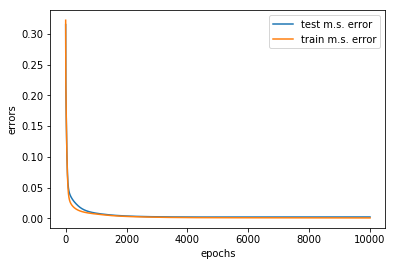

In [261]:
# Test with batch_size = 1

mlp_10 = MLP()
mlp_10.initialize(NI=4, NH=5, NO=1, activation_h=tanh, activation_o=linear)
mlp_10.train(X_train, y_train, n_epochs=10000, batch_size=1, learning_rate=0.0025, X_test=X_test, y_test=y_test)

In [285]:
_ = [print("Prediction: %.4f Target: %.4f"%(mlp_10.predict(v[0])[0], v[1][0])) for v in zip(X_test, y_test)]

Prediction: 0.3260 Target: 0.3362
Prediction: 0.7236 Target: 0.7318
Prediction: -0.1124 Target: -0.1297
Prediction: -0.2834 Target: -0.3323
Prediction: -0.4864 Target: -0.5173
Prediction: 0.9362 Target: 0.8943
Prediction: 0.9313 Target: 0.9418
Prediction: -0.4167 Target: -0.4538
Prediction: -0.9936 Target: -1.0000
Prediction: -0.2113 Target: -0.1933
Prediction: -0.9178 Target: -0.9291
Prediction: -0.6171 Target: -0.9577
Prediction: 0.7050 Target: 0.7043
Prediction: -0.9845 Target: -0.9571
Prediction: 0.5788 Target: 0.5916
Prediction: 0.5179 Target: 0.5377
Prediction: 0.1245 Target: 0.1293
Prediction: 0.4860 Target: 0.5101
Prediction: -0.2629 Target: -0.2799
Prediction: -0.1762 Target: -0.1957
Prediction: 0.0350 Target: 0.0608
Prediction: 0.3959 Target: 0.4366
Prediction: -0.9855 Target: -0.9541
Prediction: 0.7640 Target: 0.8089
Prediction: 0.4919 Target: 0.5122
Prediction: 0.7275 Target: 0.7329
Prediction: -0.8440 Target: -0.8602
Prediction: -1.0144 Target: -0.9990
Prediction: 0.9245 T

Epoch = 0 MSError= 8694.983791663657
Epoch = 1 MSError= 3654595715.695266
Epoch = 2 MSError= 1.795483567252674e+16
Epoch = 3 MSError= 6.104567649534341e+22
Epoch = 4 MSError= 6.226632854049823e+28
Epoch = 5 MSError= 8.634078310345346e+34
Epoch = 6 MSError= 1.2040040868615172e+41
Epoch = 7 MSError= 1.6773242423475124e+47
Epoch = 8 MSError= 2.336062127994008e+53
Epoch = 9 MSError= 3.2533136010359822e+59
Epoch = 10 MSError= 4.530668079312418e+65
Epoch = 11 MSError= 6.309537384909192e+71
Epoch = 12 MSError= 8.786837202352986e+77
Epoch = 13 MSError= 1.2236792632199221e+84
Epoch = 14 MSError= 1.704129570085331e+90
Epoch = 15 MSError= 2.3732179401501467e+96
Epoch = 16 MSError= 3.3050088948553075e+102
Epoch = 17 MSError= 4.602646730667336e+108
Epoch = 18 MSError= 6.409773044680123e+114
Epoch = 19 MSError= 8.926427094720483e+120
Epoch = 20 MSError= 1.2431189079837127e+127
Epoch = 21 MSError= 1.7312017484579367e+133
Epoch = 22 MSError= 2.410919401688433e+139
Epoch = 23 MSError= 3.357512991547723

/Users/giovanniciampi/anaconda3/envs/lstm_test/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in double_scalars
  
/Users/giovanniciampi/anaconda3/envs/lstm_test/lib/python3.7/site-packages/ipykernel_launcher.py:110: RuntimeWarning: overflow encountered in double_scalars
/Users/giovanniciampi/anaconda3/envs/lstm_test/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in double_scalars



Epoch = 65 MSError= nan
Epoch = 66 MSError= nan
Epoch = 67 MSError= nan
Epoch = 68 MSError= nan
Epoch = 69 MSError= nan
Epoch = 70 MSError= nan
Epoch = 71 MSError= nan
Epoch = 72 MSError= nan
Epoch = 73 MSError= nan
Epoch = 74 MSError= nan
Epoch = 75 MSError= nan
Epoch = 76 MSError= nan
Epoch = 77 MSError= nan
Epoch = 78 MSError= nan
Epoch = 79 MSError= nan
Epoch = 80 MSError= nan
Epoch = 81 MSError= nan
Epoch = 82 MSError= nan
Epoch = 83 MSError= nan
Epoch = 84 MSError= nan
Epoch = 85 MSError= nan
Epoch = 86 MSError= nan
Epoch = 87 MSError= nan
Epoch = 88 MSError= nan
Epoch = 89 MSError= nan
Epoch = 90 MSError= nan
Epoch = 91 MSError= nan
Epoch = 92 MSError= nan
Epoch = 93 MSError= nan
Epoch = 94 MSError= nan
Epoch = 95 MSError= nan
Epoch = 96 MSError= nan
Epoch = 97 MSError= nan
Epoch = 98 MSError= nan
Epoch = 99 MSError= nan
Epoch = 100 MSError= nan
Epoch = 101 MSError= nan
Epoch = 102 MSError= nan
Epoch = 103 MSError= nan
Epoch = 104 MSError= nan
Epoch = 105 MSError= nan
Epoch = 1

Epoch = 399 MSError= nan
Epoch = 400 MSError= nan
Epoch = 401 MSError= nan
Epoch = 402 MSError= nan
Epoch = 403 MSError= nan
Epoch = 404 MSError= nan
Epoch = 405 MSError= nan
Epoch = 406 MSError= nan
Epoch = 407 MSError= nan
Epoch = 408 MSError= nan
Epoch = 409 MSError= nan
Epoch = 410 MSError= nan
Epoch = 411 MSError= nan
Epoch = 412 MSError= nan
Epoch = 413 MSError= nan
Epoch = 414 MSError= nan
Epoch = 415 MSError= nan
Epoch = 416 MSError= nan
Epoch = 417 MSError= nan
Epoch = 418 MSError= nan
Epoch = 419 MSError= nan
Epoch = 420 MSError= nan
Epoch = 421 MSError= nan
Epoch = 422 MSError= nan
Epoch = 423 MSError= nan
Epoch = 424 MSError= nan
Epoch = 425 MSError= nan
Epoch = 426 MSError= nan
Epoch = 427 MSError= nan
Epoch = 428 MSError= nan
Epoch = 429 MSError= nan
Epoch = 430 MSError= nan
Epoch = 431 MSError= nan
Epoch = 432 MSError= nan
Epoch = 433 MSError= nan
Epoch = 434 MSError= nan
Epoch = 435 MSError= nan
Epoch = 436 MSError= nan
Epoch = 437 MSError= nan
Epoch = 438 MSError= nan


Epoch = 727 MSError= nan
Epoch = 728 MSError= nan
Epoch = 729 MSError= nan
Epoch = 730 MSError= nan
Epoch = 731 MSError= nan
Epoch = 732 MSError= nan
Epoch = 733 MSError= nan
Epoch = 734 MSError= nan
Epoch = 735 MSError= nan
Epoch = 736 MSError= nan
Epoch = 737 MSError= nan
Epoch = 738 MSError= nan
Epoch = 739 MSError= nan
Epoch = 740 MSError= nan
Epoch = 741 MSError= nan
Epoch = 742 MSError= nan
Epoch = 743 MSError= nan
Epoch = 744 MSError= nan
Epoch = 745 MSError= nan
Epoch = 746 MSError= nan
Epoch = 747 MSError= nan
Epoch = 748 MSError= nan
Epoch = 749 MSError= nan
Epoch = 750 MSError= nan
Epoch = 751 MSError= nan
Epoch = 752 MSError= nan
Epoch = 753 MSError= nan
Epoch = 754 MSError= nan
Epoch = 755 MSError= nan
Epoch = 756 MSError= nan
Epoch = 757 MSError= nan
Epoch = 758 MSError= nan
Epoch = 759 MSError= nan
Epoch = 760 MSError= nan
Epoch = 761 MSError= nan
Epoch = 762 MSError= nan
Epoch = 763 MSError= nan
Epoch = 764 MSError= nan
Epoch = 765 MSError= nan
Epoch = 766 MSError= nan


Epoch = 1052 MSError= nan
Epoch = 1053 MSError= nan
Epoch = 1054 MSError= nan
Epoch = 1055 MSError= nan
Epoch = 1056 MSError= nan
Epoch = 1057 MSError= nan
Epoch = 1058 MSError= nan
Epoch = 1059 MSError= nan
Epoch = 1060 MSError= nan
Epoch = 1061 MSError= nan
Epoch = 1062 MSError= nan
Epoch = 1063 MSError= nan
Epoch = 1064 MSError= nan
Epoch = 1065 MSError= nan
Epoch = 1066 MSError= nan
Epoch = 1067 MSError= nan
Epoch = 1068 MSError= nan
Epoch = 1069 MSError= nan
Epoch = 1070 MSError= nan
Epoch = 1071 MSError= nan
Epoch = 1072 MSError= nan
Epoch = 1073 MSError= nan
Epoch = 1074 MSError= nan
Epoch = 1075 MSError= nan
Epoch = 1076 MSError= nan
Epoch = 1077 MSError= nan
Epoch = 1078 MSError= nan
Epoch = 1079 MSError= nan
Epoch = 1080 MSError= nan
Epoch = 1081 MSError= nan
Epoch = 1082 MSError= nan
Epoch = 1083 MSError= nan
Epoch = 1084 MSError= nan
Epoch = 1085 MSError= nan
Epoch = 1086 MSError= nan
Epoch = 1087 MSError= nan
Epoch = 1088 MSError= nan
Epoch = 1089 MSError= nan
Epoch = 1090

Epoch = 1368 MSError= nan
Epoch = 1369 MSError= nan
Epoch = 1370 MSError= nan
Epoch = 1371 MSError= nan
Epoch = 1372 MSError= nan
Epoch = 1373 MSError= nan
Epoch = 1374 MSError= nan
Epoch = 1375 MSError= nan
Epoch = 1376 MSError= nan
Epoch = 1377 MSError= nan
Epoch = 1378 MSError= nan
Epoch = 1379 MSError= nan
Epoch = 1380 MSError= nan
Epoch = 1381 MSError= nan
Epoch = 1382 MSError= nan
Epoch = 1383 MSError= nan
Epoch = 1384 MSError= nan
Epoch = 1385 MSError= nan
Epoch = 1386 MSError= nan
Epoch = 1387 MSError= nan
Epoch = 1388 MSError= nan
Epoch = 1389 MSError= nan
Epoch = 1390 MSError= nan
Epoch = 1391 MSError= nan
Epoch = 1392 MSError= nan
Epoch = 1393 MSError= nan
Epoch = 1394 MSError= nan
Epoch = 1395 MSError= nan
Epoch = 1396 MSError= nan
Epoch = 1397 MSError= nan
Epoch = 1398 MSError= nan
Epoch = 1399 MSError= nan
Epoch = 1400 MSError= nan
Epoch = 1401 MSError= nan
Epoch = 1402 MSError= nan
Epoch = 1403 MSError= nan
Epoch = 1404 MSError= nan
Epoch = 1405 MSError= nan
Epoch = 1406

Epoch = 1691 MSError= nan
Epoch = 1692 MSError= nan
Epoch = 1693 MSError= nan
Epoch = 1694 MSError= nan
Epoch = 1695 MSError= nan
Epoch = 1696 MSError= nan
Epoch = 1697 MSError= nan
Epoch = 1698 MSError= nan
Epoch = 1699 MSError= nan
Epoch = 1700 MSError= nan
Epoch = 1701 MSError= nan
Epoch = 1702 MSError= nan
Epoch = 1703 MSError= nan
Epoch = 1704 MSError= nan
Epoch = 1705 MSError= nan
Epoch = 1706 MSError= nan
Epoch = 1707 MSError= nan
Epoch = 1708 MSError= nan
Epoch = 1709 MSError= nan
Epoch = 1710 MSError= nan
Epoch = 1711 MSError= nan
Epoch = 1712 MSError= nan
Epoch = 1713 MSError= nan
Epoch = 1714 MSError= nan
Epoch = 1715 MSError= nan
Epoch = 1716 MSError= nan
Epoch = 1717 MSError= nan
Epoch = 1718 MSError= nan
Epoch = 1719 MSError= nan
Epoch = 1720 MSError= nan
Epoch = 1721 MSError= nan
Epoch = 1722 MSError= nan
Epoch = 1723 MSError= nan
Epoch = 1724 MSError= nan
Epoch = 1725 MSError= nan
Epoch = 1726 MSError= nan
Epoch = 1727 MSError= nan
Epoch = 1728 MSError= nan
Epoch = 1729

Epoch = 2008 MSError= nan
Epoch = 2009 MSError= nan
Epoch = 2010 MSError= nan
Epoch = 2011 MSError= nan
Epoch = 2012 MSError= nan
Epoch = 2013 MSError= nan
Epoch = 2014 MSError= nan
Epoch = 2015 MSError= nan
Epoch = 2016 MSError= nan
Epoch = 2017 MSError= nan
Epoch = 2018 MSError= nan
Epoch = 2019 MSError= nan
Epoch = 2020 MSError= nan
Epoch = 2021 MSError= nan
Epoch = 2022 MSError= nan
Epoch = 2023 MSError= nan
Epoch = 2024 MSError= nan
Epoch = 2025 MSError= nan
Epoch = 2026 MSError= nan
Epoch = 2027 MSError= nan
Epoch = 2028 MSError= nan
Epoch = 2029 MSError= nan
Epoch = 2030 MSError= nan
Epoch = 2031 MSError= nan
Epoch = 2032 MSError= nan
Epoch = 2033 MSError= nan
Epoch = 2034 MSError= nan
Epoch = 2035 MSError= nan
Epoch = 2036 MSError= nan
Epoch = 2037 MSError= nan
Epoch = 2038 MSError= nan
Epoch = 2039 MSError= nan
Epoch = 2040 MSError= nan
Epoch = 2041 MSError= nan
Epoch = 2042 MSError= nan
Epoch = 2043 MSError= nan
Epoch = 2044 MSError= nan
Epoch = 2045 MSError= nan
Epoch = 2046

Epoch = 2333 MSError= nan
Epoch = 2334 MSError= nan
Epoch = 2335 MSError= nan
Epoch = 2336 MSError= nan
Epoch = 2337 MSError= nan
Epoch = 2338 MSError= nan
Epoch = 2339 MSError= nan
Epoch = 2340 MSError= nan
Epoch = 2341 MSError= nan
Epoch = 2342 MSError= nan
Epoch = 2343 MSError= nan
Epoch = 2344 MSError= nan
Epoch = 2345 MSError= nan
Epoch = 2346 MSError= nan
Epoch = 2347 MSError= nan
Epoch = 2348 MSError= nan
Epoch = 2349 MSError= nan
Epoch = 2350 MSError= nan
Epoch = 2351 MSError= nan
Epoch = 2352 MSError= nan
Epoch = 2353 MSError= nan
Epoch = 2354 MSError= nan
Epoch = 2355 MSError= nan
Epoch = 2356 MSError= nan
Epoch = 2357 MSError= nan
Epoch = 2358 MSError= nan
Epoch = 2359 MSError= nan
Epoch = 2360 MSError= nan
Epoch = 2361 MSError= nan
Epoch = 2362 MSError= nan
Epoch = 2363 MSError= nan
Epoch = 2364 MSError= nan
Epoch = 2365 MSError= nan
Epoch = 2366 MSError= nan
Epoch = 2367 MSError= nan
Epoch = 2368 MSError= nan
Epoch = 2369 MSError= nan
Epoch = 2370 MSError= nan
Epoch = 2371

Epoch = 2655 MSError= nan
Epoch = 2656 MSError= nan
Epoch = 2657 MSError= nan
Epoch = 2658 MSError= nan
Epoch = 2659 MSError= nan
Epoch = 2660 MSError= nan
Epoch = 2661 MSError= nan
Epoch = 2662 MSError= nan
Epoch = 2663 MSError= nan
Epoch = 2664 MSError= nan
Epoch = 2665 MSError= nan
Epoch = 2666 MSError= nan
Epoch = 2667 MSError= nan
Epoch = 2668 MSError= nan
Epoch = 2669 MSError= nan
Epoch = 2670 MSError= nan
Epoch = 2671 MSError= nan
Epoch = 2672 MSError= nan
Epoch = 2673 MSError= nan
Epoch = 2674 MSError= nan
Epoch = 2675 MSError= nan
Epoch = 2676 MSError= nan
Epoch = 2677 MSError= nan
Epoch = 2678 MSError= nan
Epoch = 2679 MSError= nan
Epoch = 2680 MSError= nan
Epoch = 2681 MSError= nan
Epoch = 2682 MSError= nan
Epoch = 2683 MSError= nan
Epoch = 2684 MSError= nan
Epoch = 2685 MSError= nan
Epoch = 2686 MSError= nan
Epoch = 2687 MSError= nan
Epoch = 2688 MSError= nan
Epoch = 2689 MSError= nan
Epoch = 2690 MSError= nan
Epoch = 2691 MSError= nan
Epoch = 2692 MSError= nan
Epoch = 2693

Epoch = 2976 MSError= nan
Epoch = 2977 MSError= nan
Epoch = 2978 MSError= nan
Epoch = 2979 MSError= nan
Epoch = 2980 MSError= nan
Epoch = 2981 MSError= nan
Epoch = 2982 MSError= nan
Epoch = 2983 MSError= nan
Epoch = 2984 MSError= nan
Epoch = 2985 MSError= nan
Epoch = 2986 MSError= nan
Epoch = 2987 MSError= nan
Epoch = 2988 MSError= nan
Epoch = 2989 MSError= nan
Epoch = 2990 MSError= nan
Epoch = 2991 MSError= nan
Epoch = 2992 MSError= nan
Epoch = 2993 MSError= nan
Epoch = 2994 MSError= nan
Epoch = 2995 MSError= nan
Epoch = 2996 MSError= nan
Epoch = 2997 MSError= nan
Epoch = 2998 MSError= nan
Epoch = 2999 MSError= nan
Epoch = 3000 MSError= nan
Epoch = 3001 MSError= nan
Epoch = 3002 MSError= nan
Epoch = 3003 MSError= nan
Epoch = 3004 MSError= nan
Epoch = 3005 MSError= nan
Epoch = 3006 MSError= nan
Epoch = 3007 MSError= nan
Epoch = 3008 MSError= nan
Epoch = 3009 MSError= nan
Epoch = 3010 MSError= nan
Epoch = 3011 MSError= nan
Epoch = 3012 MSError= nan
Epoch = 3013 MSError= nan
Epoch = 3014

Epoch = 3291 MSError= nan
Epoch = 3292 MSError= nan
Epoch = 3293 MSError= nan
Epoch = 3294 MSError= nan
Epoch = 3295 MSError= nan
Epoch = 3296 MSError= nan
Epoch = 3297 MSError= nan
Epoch = 3298 MSError= nan
Epoch = 3299 MSError= nan
Epoch = 3300 MSError= nan
Epoch = 3301 MSError= nan
Epoch = 3302 MSError= nan
Epoch = 3303 MSError= nan
Epoch = 3304 MSError= nan
Epoch = 3305 MSError= nan
Epoch = 3306 MSError= nan
Epoch = 3307 MSError= nan
Epoch = 3308 MSError= nan
Epoch = 3309 MSError= nan
Epoch = 3310 MSError= nan
Epoch = 3311 MSError= nan
Epoch = 3312 MSError= nan
Epoch = 3313 MSError= nan
Epoch = 3314 MSError= nan
Epoch = 3315 MSError= nan
Epoch = 3316 MSError= nan
Epoch = 3317 MSError= nan
Epoch = 3318 MSError= nan
Epoch = 3319 MSError= nan
Epoch = 3320 MSError= nan
Epoch = 3321 MSError= nan
Epoch = 3322 MSError= nan
Epoch = 3323 MSError= nan
Epoch = 3324 MSError= nan
Epoch = 3325 MSError= nan
Epoch = 3326 MSError= nan
Epoch = 3327 MSError= nan
Epoch = 3328 MSError= nan
Epoch = 3329

Epoch = 3619 MSError= nan
Epoch = 3620 MSError= nan
Epoch = 3621 MSError= nan
Epoch = 3622 MSError= nan
Epoch = 3623 MSError= nan
Epoch = 3624 MSError= nan
Epoch = 3625 MSError= nan
Epoch = 3626 MSError= nan
Epoch = 3627 MSError= nan
Epoch = 3628 MSError= nan
Epoch = 3629 MSError= nan
Epoch = 3630 MSError= nan
Epoch = 3631 MSError= nan
Epoch = 3632 MSError= nan
Epoch = 3633 MSError= nan
Epoch = 3634 MSError= nan
Epoch = 3635 MSError= nan
Epoch = 3636 MSError= nan
Epoch = 3637 MSError= nan
Epoch = 3638 MSError= nan
Epoch = 3639 MSError= nan
Epoch = 3640 MSError= nan
Epoch = 3641 MSError= nan
Epoch = 3642 MSError= nan
Epoch = 3643 MSError= nan
Epoch = 3644 MSError= nan
Epoch = 3645 MSError= nan
Epoch = 3646 MSError= nan
Epoch = 3647 MSError= nan
Epoch = 3648 MSError= nan
Epoch = 3649 MSError= nan
Epoch = 3650 MSError= nan
Epoch = 3651 MSError= nan
Epoch = 3652 MSError= nan
Epoch = 3653 MSError= nan
Epoch = 3654 MSError= nan
Epoch = 3655 MSError= nan
Epoch = 3656 MSError= nan
Epoch = 3657

Epoch = 3941 MSError= nan
Epoch = 3942 MSError= nan
Epoch = 3943 MSError= nan
Epoch = 3944 MSError= nan
Epoch = 3945 MSError= nan
Epoch = 3946 MSError= nan
Epoch = 3947 MSError= nan
Epoch = 3948 MSError= nan
Epoch = 3949 MSError= nan
Epoch = 3950 MSError= nan
Epoch = 3951 MSError= nan
Epoch = 3952 MSError= nan
Epoch = 3953 MSError= nan
Epoch = 3954 MSError= nan
Epoch = 3955 MSError= nan
Epoch = 3956 MSError= nan
Epoch = 3957 MSError= nan
Epoch = 3958 MSError= nan
Epoch = 3959 MSError= nan
Epoch = 3960 MSError= nan
Epoch = 3961 MSError= nan
Epoch = 3962 MSError= nan
Epoch = 3963 MSError= nan
Epoch = 3964 MSError= nan
Epoch = 3965 MSError= nan
Epoch = 3966 MSError= nan
Epoch = 3967 MSError= nan
Epoch = 3968 MSError= nan
Epoch = 3969 MSError= nan
Epoch = 3970 MSError= nan
Epoch = 3971 MSError= nan
Epoch = 3972 MSError= nan
Epoch = 3973 MSError= nan
Epoch = 3974 MSError= nan
Epoch = 3975 MSError= nan
Epoch = 3976 MSError= nan
Epoch = 3977 MSError= nan
Epoch = 3978 MSError= nan
Epoch = 3979

Epoch = 4264 MSError= nan
Epoch = 4265 MSError= nan
Epoch = 4266 MSError= nan
Epoch = 4267 MSError= nan
Epoch = 4268 MSError= nan
Epoch = 4269 MSError= nan
Epoch = 4270 MSError= nan
Epoch = 4271 MSError= nan
Epoch = 4272 MSError= nan
Epoch = 4273 MSError= nan
Epoch = 4274 MSError= nan
Epoch = 4275 MSError= nan
Epoch = 4276 MSError= nan
Epoch = 4277 MSError= nan
Epoch = 4278 MSError= nan
Epoch = 4279 MSError= nan
Epoch = 4280 MSError= nan
Epoch = 4281 MSError= nan
Epoch = 4282 MSError= nan
Epoch = 4283 MSError= nan
Epoch = 4284 MSError= nan
Epoch = 4285 MSError= nan
Epoch = 4286 MSError= nan
Epoch = 4287 MSError= nan
Epoch = 4288 MSError= nan
Epoch = 4289 MSError= nan
Epoch = 4290 MSError= nan
Epoch = 4291 MSError= nan
Epoch = 4292 MSError= nan
Epoch = 4293 MSError= nan
Epoch = 4294 MSError= nan
Epoch = 4295 MSError= nan
Epoch = 4296 MSError= nan
Epoch = 4297 MSError= nan
Epoch = 4298 MSError= nan
Epoch = 4299 MSError= nan
Epoch = 4300 MSError= nan
Epoch = 4301 MSError= nan
Epoch = 4302

Epoch = 4589 MSError= nan
Epoch = 4590 MSError= nan
Epoch = 4591 MSError= nan
Epoch = 4592 MSError= nan
Epoch = 4593 MSError= nan
Epoch = 4594 MSError= nan
Epoch = 4595 MSError= nan
Epoch = 4596 MSError= nan
Epoch = 4597 MSError= nan
Epoch = 4598 MSError= nan
Epoch = 4599 MSError= nan
Epoch = 4600 MSError= nan
Epoch = 4601 MSError= nan
Epoch = 4602 MSError= nan
Epoch = 4603 MSError= nan
Epoch = 4604 MSError= nan
Epoch = 4605 MSError= nan
Epoch = 4606 MSError= nan
Epoch = 4607 MSError= nan
Epoch = 4608 MSError= nan
Epoch = 4609 MSError= nan
Epoch = 4610 MSError= nan
Epoch = 4611 MSError= nan
Epoch = 4612 MSError= nan
Epoch = 4613 MSError= nan
Epoch = 4614 MSError= nan
Epoch = 4615 MSError= nan
Epoch = 4616 MSError= nan
Epoch = 4617 MSError= nan
Epoch = 4618 MSError= nan
Epoch = 4619 MSError= nan
Epoch = 4620 MSError= nan
Epoch = 4621 MSError= nan
Epoch = 4622 MSError= nan
Epoch = 4623 MSError= nan
Epoch = 4624 MSError= nan
Epoch = 4625 MSError= nan
Epoch = 4626 MSError= nan
Epoch = 4627

Epoch = 4915 MSError= nan
Epoch = 4916 MSError= nan
Epoch = 4917 MSError= nan
Epoch = 4918 MSError= nan
Epoch = 4919 MSError= nan
Epoch = 4920 MSError= nan
Epoch = 4921 MSError= nan
Epoch = 4922 MSError= nan
Epoch = 4923 MSError= nan
Epoch = 4924 MSError= nan
Epoch = 4925 MSError= nan
Epoch = 4926 MSError= nan
Epoch = 4927 MSError= nan
Epoch = 4928 MSError= nan
Epoch = 4929 MSError= nan
Epoch = 4930 MSError= nan
Epoch = 4931 MSError= nan
Epoch = 4932 MSError= nan
Epoch = 4933 MSError= nan
Epoch = 4934 MSError= nan
Epoch = 4935 MSError= nan
Epoch = 4936 MSError= nan
Epoch = 4937 MSError= nan
Epoch = 4938 MSError= nan
Epoch = 4939 MSError= nan
Epoch = 4940 MSError= nan
Epoch = 4941 MSError= nan
Epoch = 4942 MSError= nan
Epoch = 4943 MSError= nan
Epoch = 4944 MSError= nan
Epoch = 4945 MSError= nan
Epoch = 4946 MSError= nan
Epoch = 4947 MSError= nan
Epoch = 4948 MSError= nan
Epoch = 4949 MSError= nan
Epoch = 4950 MSError= nan
Epoch = 4951 MSError= nan
Epoch = 4952 MSError= nan
Epoch = 4953

Epoch = 5237 MSError= nan
Epoch = 5238 MSError= nan
Epoch = 5239 MSError= nan
Epoch = 5240 MSError= nan
Epoch = 5241 MSError= nan
Epoch = 5242 MSError= nan
Epoch = 5243 MSError= nan
Epoch = 5244 MSError= nan
Epoch = 5245 MSError= nan
Epoch = 5246 MSError= nan
Epoch = 5247 MSError= nan
Epoch = 5248 MSError= nan
Epoch = 5249 MSError= nan
Epoch = 5250 MSError= nan
Epoch = 5251 MSError= nan
Epoch = 5252 MSError= nan
Epoch = 5253 MSError= nan
Epoch = 5254 MSError= nan
Epoch = 5255 MSError= nan
Epoch = 5256 MSError= nan
Epoch = 5257 MSError= nan
Epoch = 5258 MSError= nan
Epoch = 5259 MSError= nan
Epoch = 5260 MSError= nan
Epoch = 5261 MSError= nan
Epoch = 5262 MSError= nan
Epoch = 5263 MSError= nan
Epoch = 5264 MSError= nan
Epoch = 5265 MSError= nan
Epoch = 5266 MSError= nan
Epoch = 5267 MSError= nan
Epoch = 5268 MSError= nan
Epoch = 5269 MSError= nan
Epoch = 5270 MSError= nan
Epoch = 5271 MSError= nan
Epoch = 5272 MSError= nan
Epoch = 5273 MSError= nan
Epoch = 5274 MSError= nan
Epoch = 5275

Epoch = 5562 MSError= nan
Epoch = 5563 MSError= nan
Epoch = 5564 MSError= nan
Epoch = 5565 MSError= nan
Epoch = 5566 MSError= nan
Epoch = 5567 MSError= nan
Epoch = 5568 MSError= nan
Epoch = 5569 MSError= nan
Epoch = 5570 MSError= nan
Epoch = 5571 MSError= nan
Epoch = 5572 MSError= nan
Epoch = 5573 MSError= nan
Epoch = 5574 MSError= nan
Epoch = 5575 MSError= nan
Epoch = 5576 MSError= nan
Epoch = 5577 MSError= nan
Epoch = 5578 MSError= nan
Epoch = 5579 MSError= nan
Epoch = 5580 MSError= nan
Epoch = 5581 MSError= nan
Epoch = 5582 MSError= nan
Epoch = 5583 MSError= nan
Epoch = 5584 MSError= nan
Epoch = 5585 MSError= nan
Epoch = 5586 MSError= nan
Epoch = 5587 MSError= nan
Epoch = 5588 MSError= nan
Epoch = 5589 MSError= nan
Epoch = 5590 MSError= nan
Epoch = 5591 MSError= nan
Epoch = 5592 MSError= nan
Epoch = 5593 MSError= nan
Epoch = 5594 MSError= nan
Epoch = 5595 MSError= nan
Epoch = 5596 MSError= nan
Epoch = 5597 MSError= nan
Epoch = 5598 MSError= nan
Epoch = 5599 MSError= nan
Epoch = 5600

Epoch = 5885 MSError= nan
Epoch = 5886 MSError= nan
Epoch = 5887 MSError= nan
Epoch = 5888 MSError= nan
Epoch = 5889 MSError= nan
Epoch = 5890 MSError= nan
Epoch = 5891 MSError= nan
Epoch = 5892 MSError= nan
Epoch = 5893 MSError= nan
Epoch = 5894 MSError= nan
Epoch = 5895 MSError= nan
Epoch = 5896 MSError= nan
Epoch = 5897 MSError= nan
Epoch = 5898 MSError= nan
Epoch = 5899 MSError= nan
Epoch = 5900 MSError= nan
Epoch = 5901 MSError= nan
Epoch = 5902 MSError= nan
Epoch = 5903 MSError= nan
Epoch = 5904 MSError= nan
Epoch = 5905 MSError= nan
Epoch = 5906 MSError= nan
Epoch = 5907 MSError= nan
Epoch = 5908 MSError= nan
Epoch = 5909 MSError= nan
Epoch = 5910 MSError= nan
Epoch = 5911 MSError= nan
Epoch = 5912 MSError= nan
Epoch = 5913 MSError= nan
Epoch = 5914 MSError= nan
Epoch = 5915 MSError= nan
Epoch = 5916 MSError= nan
Epoch = 5917 MSError= nan
Epoch = 5918 MSError= nan
Epoch = 5919 MSError= nan
Epoch = 5920 MSError= nan
Epoch = 5921 MSError= nan
Epoch = 5922 MSError= nan
Epoch = 5923

Epoch = 6212 MSError= nan
Epoch = 6213 MSError= nan
Epoch = 6214 MSError= nan
Epoch = 6215 MSError= nan
Epoch = 6216 MSError= nan
Epoch = 6217 MSError= nan
Epoch = 6218 MSError= nan
Epoch = 6219 MSError= nan
Epoch = 6220 MSError= nan
Epoch = 6221 MSError= nan
Epoch = 6222 MSError= nan
Epoch = 6223 MSError= nan
Epoch = 6224 MSError= nan
Epoch = 6225 MSError= nan
Epoch = 6226 MSError= nan
Epoch = 6227 MSError= nan
Epoch = 6228 MSError= nan
Epoch = 6229 MSError= nan
Epoch = 6230 MSError= nan
Epoch = 6231 MSError= nan
Epoch = 6232 MSError= nan
Epoch = 6233 MSError= nan
Epoch = 6234 MSError= nan
Epoch = 6235 MSError= nan
Epoch = 6236 MSError= nan
Epoch = 6237 MSError= nan
Epoch = 6238 MSError= nan
Epoch = 6239 MSError= nan
Epoch = 6240 MSError= nan
Epoch = 6241 MSError= nan
Epoch = 6242 MSError= nan
Epoch = 6243 MSError= nan
Epoch = 6244 MSError= nan
Epoch = 6245 MSError= nan
Epoch = 6246 MSError= nan
Epoch = 6247 MSError= nan
Epoch = 6248 MSError= nan
Epoch = 6249 MSError= nan
Epoch = 6250

Epoch = 6531 MSError= nan
Epoch = 6532 MSError= nan
Epoch = 6533 MSError= nan
Epoch = 6534 MSError= nan
Epoch = 6535 MSError= nan
Epoch = 6536 MSError= nan
Epoch = 6537 MSError= nan
Epoch = 6538 MSError= nan
Epoch = 6539 MSError= nan
Epoch = 6540 MSError= nan
Epoch = 6541 MSError= nan
Epoch = 6542 MSError= nan
Epoch = 6543 MSError= nan
Epoch = 6544 MSError= nan
Epoch = 6545 MSError= nan
Epoch = 6546 MSError= nan
Epoch = 6547 MSError= nan
Epoch = 6548 MSError= nan
Epoch = 6549 MSError= nan
Epoch = 6550 MSError= nan
Epoch = 6551 MSError= nan
Epoch = 6552 MSError= nan
Epoch = 6553 MSError= nan
Epoch = 6554 MSError= nan
Epoch = 6555 MSError= nan
Epoch = 6556 MSError= nan
Epoch = 6557 MSError= nan
Epoch = 6558 MSError= nan
Epoch = 6559 MSError= nan
Epoch = 6560 MSError= nan
Epoch = 6561 MSError= nan
Epoch = 6562 MSError= nan
Epoch = 6563 MSError= nan
Epoch = 6564 MSError= nan
Epoch = 6565 MSError= nan
Epoch = 6566 MSError= nan
Epoch = 6567 MSError= nan
Epoch = 6568 MSError= nan
Epoch = 6569

Epoch = 6855 MSError= nan
Epoch = 6856 MSError= nan
Epoch = 6857 MSError= nan
Epoch = 6858 MSError= nan
Epoch = 6859 MSError= nan
Epoch = 6860 MSError= nan
Epoch = 6861 MSError= nan
Epoch = 6862 MSError= nan
Epoch = 6863 MSError= nan
Epoch = 6864 MSError= nan
Epoch = 6865 MSError= nan
Epoch = 6866 MSError= nan
Epoch = 6867 MSError= nan
Epoch = 6868 MSError= nan
Epoch = 6869 MSError= nan
Epoch = 6870 MSError= nan
Epoch = 6871 MSError= nan
Epoch = 6872 MSError= nan
Epoch = 6873 MSError= nan
Epoch = 6874 MSError= nan
Epoch = 6875 MSError= nan
Epoch = 6876 MSError= nan
Epoch = 6877 MSError= nan
Epoch = 6878 MSError= nan
Epoch = 6879 MSError= nan
Epoch = 6880 MSError= nan
Epoch = 6881 MSError= nan
Epoch = 6882 MSError= nan
Epoch = 6883 MSError= nan
Epoch = 6884 MSError= nan
Epoch = 6885 MSError= nan
Epoch = 6886 MSError= nan
Epoch = 6887 MSError= nan
Epoch = 6888 MSError= nan
Epoch = 6889 MSError= nan
Epoch = 6890 MSError= nan
Epoch = 6891 MSError= nan
Epoch = 6892 MSError= nan
Epoch = 6893

Epoch = 7181 MSError= nan
Epoch = 7182 MSError= nan
Epoch = 7183 MSError= nan
Epoch = 7184 MSError= nan
Epoch = 7185 MSError= nan
Epoch = 7186 MSError= nan
Epoch = 7187 MSError= nan
Epoch = 7188 MSError= nan
Epoch = 7189 MSError= nan
Epoch = 7190 MSError= nan
Epoch = 7191 MSError= nan
Epoch = 7192 MSError= nan
Epoch = 7193 MSError= nan
Epoch = 7194 MSError= nan
Epoch = 7195 MSError= nan
Epoch = 7196 MSError= nan
Epoch = 7197 MSError= nan
Epoch = 7198 MSError= nan
Epoch = 7199 MSError= nan
Epoch = 7200 MSError= nan
Epoch = 7201 MSError= nan
Epoch = 7202 MSError= nan
Epoch = 7203 MSError= nan
Epoch = 7204 MSError= nan
Epoch = 7205 MSError= nan
Epoch = 7206 MSError= nan
Epoch = 7207 MSError= nan
Epoch = 7208 MSError= nan
Epoch = 7209 MSError= nan
Epoch = 7210 MSError= nan
Epoch = 7211 MSError= nan
Epoch = 7212 MSError= nan
Epoch = 7213 MSError= nan
Epoch = 7214 MSError= nan
Epoch = 7215 MSError= nan
Epoch = 7216 MSError= nan
Epoch = 7217 MSError= nan
Epoch = 7218 MSError= nan
Epoch = 7219

Epoch = 7505 MSError= nan
Epoch = 7506 MSError= nan
Epoch = 7507 MSError= nan
Epoch = 7508 MSError= nan
Epoch = 7509 MSError= nan
Epoch = 7510 MSError= nan
Epoch = 7511 MSError= nan
Epoch = 7512 MSError= nan
Epoch = 7513 MSError= nan
Epoch = 7514 MSError= nan
Epoch = 7515 MSError= nan
Epoch = 7516 MSError= nan
Epoch = 7517 MSError= nan
Epoch = 7518 MSError= nan
Epoch = 7519 MSError= nan
Epoch = 7520 MSError= nan
Epoch = 7521 MSError= nan
Epoch = 7522 MSError= nan
Epoch = 7523 MSError= nan
Epoch = 7524 MSError= nan
Epoch = 7525 MSError= nan
Epoch = 7526 MSError= nan
Epoch = 7527 MSError= nan
Epoch = 7528 MSError= nan
Epoch = 7529 MSError= nan
Epoch = 7530 MSError= nan
Epoch = 7531 MSError= nan
Epoch = 7532 MSError= nan
Epoch = 7533 MSError= nan
Epoch = 7534 MSError= nan
Epoch = 7535 MSError= nan
Epoch = 7536 MSError= nan
Epoch = 7537 MSError= nan
Epoch = 7538 MSError= nan
Epoch = 7539 MSError= nan
Epoch = 7540 MSError= nan
Epoch = 7541 MSError= nan
Epoch = 7542 MSError= nan
Epoch = 7543

Epoch = 7834 MSError= nan
Epoch = 7835 MSError= nan
Epoch = 7836 MSError= nan
Epoch = 7837 MSError= nan
Epoch = 7838 MSError= nan
Epoch = 7839 MSError= nan
Epoch = 7840 MSError= nan
Epoch = 7841 MSError= nan
Epoch = 7842 MSError= nan
Epoch = 7843 MSError= nan
Epoch = 7844 MSError= nan
Epoch = 7845 MSError= nan
Epoch = 7846 MSError= nan
Epoch = 7847 MSError= nan
Epoch = 7848 MSError= nan
Epoch = 7849 MSError= nan
Epoch = 7850 MSError= nan
Epoch = 7851 MSError= nan
Epoch = 7852 MSError= nan
Epoch = 7853 MSError= nan
Epoch = 7854 MSError= nan
Epoch = 7855 MSError= nan
Epoch = 7856 MSError= nan
Epoch = 7857 MSError= nan
Epoch = 7858 MSError= nan
Epoch = 7859 MSError= nan
Epoch = 7860 MSError= nan
Epoch = 7861 MSError= nan
Epoch = 7862 MSError= nan
Epoch = 7863 MSError= nan
Epoch = 7864 MSError= nan
Epoch = 7865 MSError= nan
Epoch = 7866 MSError= nan
Epoch = 7867 MSError= nan
Epoch = 7868 MSError= nan
Epoch = 7869 MSError= nan
Epoch = 7870 MSError= nan
Epoch = 7871 MSError= nan
Epoch = 7872

Epoch = 8158 MSError= nan
Epoch = 8159 MSError= nan
Epoch = 8160 MSError= nan
Epoch = 8161 MSError= nan
Epoch = 8162 MSError= nan
Epoch = 8163 MSError= nan
Epoch = 8164 MSError= nan
Epoch = 8165 MSError= nan
Epoch = 8166 MSError= nan
Epoch = 8167 MSError= nan
Epoch = 8168 MSError= nan
Epoch = 8169 MSError= nan
Epoch = 8170 MSError= nan
Epoch = 8171 MSError= nan
Epoch = 8172 MSError= nan
Epoch = 8173 MSError= nan
Epoch = 8174 MSError= nan
Epoch = 8175 MSError= nan
Epoch = 8176 MSError= nan
Epoch = 8177 MSError= nan
Epoch = 8178 MSError= nan
Epoch = 8179 MSError= nan
Epoch = 8180 MSError= nan
Epoch = 8181 MSError= nan
Epoch = 8182 MSError= nan
Epoch = 8183 MSError= nan
Epoch = 8184 MSError= nan
Epoch = 8185 MSError= nan
Epoch = 8186 MSError= nan
Epoch = 8187 MSError= nan
Epoch = 8188 MSError= nan
Epoch = 8189 MSError= nan
Epoch = 8190 MSError= nan
Epoch = 8191 MSError= nan
Epoch = 8192 MSError= nan
Epoch = 8193 MSError= nan
Epoch = 8194 MSError= nan
Epoch = 8195 MSError= nan
Epoch = 8196

Epoch = 8488 MSError= nan
Epoch = 8489 MSError= nan
Epoch = 8490 MSError= nan
Epoch = 8491 MSError= nan
Epoch = 8492 MSError= nan
Epoch = 8493 MSError= nan
Epoch = 8494 MSError= nan
Epoch = 8495 MSError= nan
Epoch = 8496 MSError= nan
Epoch = 8497 MSError= nan
Epoch = 8498 MSError= nan
Epoch = 8499 MSError= nan
Epoch = 8500 MSError= nan
Epoch = 8501 MSError= nan
Epoch = 8502 MSError= nan
Epoch = 8503 MSError= nan
Epoch = 8504 MSError= nan
Epoch = 8505 MSError= nan
Epoch = 8506 MSError= nan
Epoch = 8507 MSError= nan
Epoch = 8508 MSError= nan
Epoch = 8509 MSError= nan
Epoch = 8510 MSError= nan
Epoch = 8511 MSError= nan
Epoch = 8512 MSError= nan
Epoch = 8513 MSError= nan
Epoch = 8514 MSError= nan
Epoch = 8515 MSError= nan
Epoch = 8516 MSError= nan
Epoch = 8517 MSError= nan
Epoch = 8518 MSError= nan
Epoch = 8519 MSError= nan
Epoch = 8520 MSError= nan
Epoch = 8521 MSError= nan
Epoch = 8522 MSError= nan
Epoch = 8523 MSError= nan
Epoch = 8524 MSError= nan
Epoch = 8525 MSError= nan
Epoch = 8526

Epoch = 8810 MSError= nan
Epoch = 8811 MSError= nan
Epoch = 8812 MSError= nan
Epoch = 8813 MSError= nan
Epoch = 8814 MSError= nan
Epoch = 8815 MSError= nan
Epoch = 8816 MSError= nan
Epoch = 8817 MSError= nan
Epoch = 8818 MSError= nan
Epoch = 8819 MSError= nan
Epoch = 8820 MSError= nan
Epoch = 8821 MSError= nan
Epoch = 8822 MSError= nan
Epoch = 8823 MSError= nan
Epoch = 8824 MSError= nan
Epoch = 8825 MSError= nan
Epoch = 8826 MSError= nan
Epoch = 8827 MSError= nan
Epoch = 8828 MSError= nan
Epoch = 8829 MSError= nan
Epoch = 8830 MSError= nan
Epoch = 8831 MSError= nan
Epoch = 8832 MSError= nan
Epoch = 8833 MSError= nan
Epoch = 8834 MSError= nan
Epoch = 8835 MSError= nan
Epoch = 8836 MSError= nan
Epoch = 8837 MSError= nan
Epoch = 8838 MSError= nan
Epoch = 8839 MSError= nan
Epoch = 8840 MSError= nan
Epoch = 8841 MSError= nan
Epoch = 8842 MSError= nan
Epoch = 8843 MSError= nan
Epoch = 8844 MSError= nan
Epoch = 8845 MSError= nan
Epoch = 8846 MSError= nan
Epoch = 8847 MSError= nan
Epoch = 8848

Epoch = 9134 MSError= nan
Epoch = 9135 MSError= nan
Epoch = 9136 MSError= nan
Epoch = 9137 MSError= nan
Epoch = 9138 MSError= nan
Epoch = 9139 MSError= nan
Epoch = 9140 MSError= nan
Epoch = 9141 MSError= nan
Epoch = 9142 MSError= nan
Epoch = 9143 MSError= nan
Epoch = 9144 MSError= nan
Epoch = 9145 MSError= nan
Epoch = 9146 MSError= nan
Epoch = 9147 MSError= nan
Epoch = 9148 MSError= nan
Epoch = 9149 MSError= nan
Epoch = 9150 MSError= nan
Epoch = 9151 MSError= nan
Epoch = 9152 MSError= nan
Epoch = 9153 MSError= nan
Epoch = 9154 MSError= nan
Epoch = 9155 MSError= nan
Epoch = 9156 MSError= nan
Epoch = 9157 MSError= nan
Epoch = 9158 MSError= nan
Epoch = 9159 MSError= nan
Epoch = 9160 MSError= nan
Epoch = 9161 MSError= nan
Epoch = 9162 MSError= nan
Epoch = 9163 MSError= nan
Epoch = 9164 MSError= nan
Epoch = 9165 MSError= nan
Epoch = 9166 MSError= nan
Epoch = 9167 MSError= nan
Epoch = 9168 MSError= nan
Epoch = 9169 MSError= nan
Epoch = 9170 MSError= nan
Epoch = 9171 MSError= nan
Epoch = 9172

Epoch = 9457 MSError= nan
Epoch = 9458 MSError= nan
Epoch = 9459 MSError= nan
Epoch = 9460 MSError= nan
Epoch = 9461 MSError= nan
Epoch = 9462 MSError= nan
Epoch = 9463 MSError= nan
Epoch = 9464 MSError= nan
Epoch = 9465 MSError= nan
Epoch = 9466 MSError= nan
Epoch = 9467 MSError= nan
Epoch = 9468 MSError= nan
Epoch = 9469 MSError= nan
Epoch = 9470 MSError= nan
Epoch = 9471 MSError= nan
Epoch = 9472 MSError= nan
Epoch = 9473 MSError= nan
Epoch = 9474 MSError= nan
Epoch = 9475 MSError= nan
Epoch = 9476 MSError= nan
Epoch = 9477 MSError= nan
Epoch = 9478 MSError= nan
Epoch = 9479 MSError= nan
Epoch = 9480 MSError= nan
Epoch = 9481 MSError= nan
Epoch = 9482 MSError= nan
Epoch = 9483 MSError= nan
Epoch = 9484 MSError= nan
Epoch = 9485 MSError= nan
Epoch = 9486 MSError= nan
Epoch = 9487 MSError= nan
Epoch = 9488 MSError= nan
Epoch = 9489 MSError= nan
Epoch = 9490 MSError= nan
Epoch = 9491 MSError= nan
Epoch = 9492 MSError= nan
Epoch = 9493 MSError= nan
Epoch = 9494 MSError= nan
Epoch = 9495

Epoch = 9777 MSError= nan
Epoch = 9778 MSError= nan
Epoch = 9779 MSError= nan
Epoch = 9780 MSError= nan
Epoch = 9781 MSError= nan
Epoch = 9782 MSError= nan
Epoch = 9783 MSError= nan
Epoch = 9784 MSError= nan
Epoch = 9785 MSError= nan
Epoch = 9786 MSError= nan
Epoch = 9787 MSError= nan
Epoch = 9788 MSError= nan
Epoch = 9789 MSError= nan
Epoch = 9790 MSError= nan
Epoch = 9791 MSError= nan
Epoch = 9792 MSError= nan
Epoch = 9793 MSError= nan
Epoch = 9794 MSError= nan
Epoch = 9795 MSError= nan
Epoch = 9796 MSError= nan
Epoch = 9797 MSError= nan
Epoch = 9798 MSError= nan
Epoch = 9799 MSError= nan
Epoch = 9800 MSError= nan
Epoch = 9801 MSError= nan
Epoch = 9802 MSError= nan
Epoch = 9803 MSError= nan
Epoch = 9804 MSError= nan
Epoch = 9805 MSError= nan
Epoch = 9806 MSError= nan
Epoch = 9807 MSError= nan
Epoch = 9808 MSError= nan
Epoch = 9809 MSError= nan
Epoch = 9810 MSError= nan
Epoch = 9811 MSError= nan
Epoch = 9812 MSError= nan
Epoch = 9813 MSError= nan
Epoch = 9814 MSError= nan
Epoch = 9815

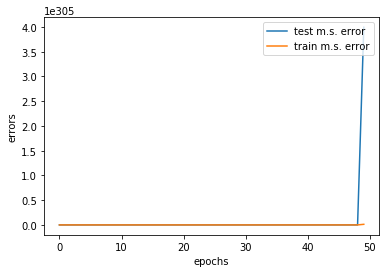

In [263]:
### Test with a too big learning rate

mlp_11 = MLP()
mlp_11.initialize(NI=4, NH=5, NO=1, activation_h=tanh, activation_o=linear)
mlp_11.train(X_train, y_train, n_epochs=10000, batch_size=50, learning_rate=0.1, X_test=X_test, y_test=y_test)

In [286]:
_ = [print("Prediction: %.4f Target: %.4f"%(mlp_11.predict(v[0])[0], v[1][0])) for v in zip(X_test, y_test)]

Prediction: nan Target: 0.3362
Prediction: nan Target: 0.7318
Prediction: nan Target: -0.1297
Prediction: nan Target: -0.3323
Prediction: nan Target: -0.5173
Prediction: nan Target: 0.8943
Prediction: nan Target: 0.9418
Prediction: nan Target: -0.4538
Prediction: nan Target: -1.0000
Prediction: nan Target: -0.1933
Prediction: nan Target: -0.9291
Prediction: nan Target: -0.9577
Prediction: nan Target: 0.7043
Prediction: nan Target: -0.9571
Prediction: nan Target: 0.5916
Prediction: nan Target: 0.5377
Prediction: nan Target: 0.1293
Prediction: nan Target: 0.5101
Prediction: nan Target: -0.2799
Prediction: nan Target: -0.1957
Prediction: nan Target: 0.0608
Prediction: nan Target: 0.4366
Prediction: nan Target: -0.9541
Prediction: nan Target: 0.8089
Prediction: nan Target: 0.5122
Prediction: nan Target: 0.7329
Prediction: nan Target: -0.8602
Prediction: nan Target: -0.9990
Prediction: nan Target: 0.9189
Prediction: nan Target: -0.9971
Prediction: nan Target: 0.8799
Prediction: nan Target: 

## Uci Letter Recognition Problem
Problem of recognizing written letters based on some visual-numerical characteristics. The full dataset consists of 20000 letters, 16000 of wich are used for the network training. In order to classify letters with the network, a One-Hot-Encoder (provided by the scikit-learn library) is used.  
The complexity of this problem seems to require a smaller learning rate, to avoid the quick explosion of the gradients.  
Due to the amount of time necessary to train the network for each epoch, the training is executed in small chunks, and after each one of them it is tested on a 20 random training samples and 20 random test samples.  
During the training, the network seems to reach multiple local minima, the first and most prominent is the prediction of the letter 'U' in almost all cases. It looks from the predictions on the random samples that as the training evolves, the network learns to predict some specific instance of other letters with great precision, so that the few times when it is not predicting 'U', but is predicting other letters, the predictions are right with great probability.  
Another difference with the previous two problems is that there is a noticeable difference in the values of the loss on the training and on the test; also this should be caused by a mild overfitting due to the complexity of the problem.  
The network that has been tested had 16 input units, 10 hidden units and 26 output units.

In [297]:
letters_dataset = pd.read_csv("letter-recognition.data")
X_letters, y_letters = letters_dataset.values[:, 1:], letters_dataset.values[:, :1]

In [298]:
encoder= OneHotEncoder(sparse=False)
y_letters = encoder.fit_transform(y_letters)

In [299]:
X_letters_train, y_letters_train = X_letters[:16000], y_letters[:16000]

In [300]:
X_letters_test, y_letters_test = X_letters[16000:], y_letters[16000:]

Epoch = 0 MSError= 14337.33665194349
Epoch = 1 MSError= 7843.75475924726
Epoch = 2 MSError= 7743.004194728242
Epoch = 3 MSError= 7715.170984873711
Epoch = 4 MSError= 7708.168775390493
Epoch = 5 MSError= 7705.927425366481
Epoch = 6 MSError= 7704.83028646319
Epoch = 7 MSError= 7704.161203673085
Epoch = 8 MSError= 7703.700576750705
Epoch = 9 MSError= 7703.358225124473
Epoch = 10 MSError= 7703.089880045288
Epoch = 11 MSError= 7702.871074555824
Epoch = 12 MSError= 7702.687083280368
Epoch = 13 MSError= 7702.528444493438
Epoch = 14 MSError= 7702.388748769425
Epoch = 15 MSError= 7702.263458650683
Epoch = 16 MSError= 7702.149238511633
Epoch = 17 MSError= 7702.04355341107
Epoch = 18 MSError= 7701.944416939216
Epoch = 19 MSError= 7701.850224923226
Epoch = 20 MSError= 7701.759640111582
Epoch = 21 MSError= 7701.671507575904
Epoch = 22 MSError= 7701.584788283882
Epoch = 23 MSError= 7701.498502336548
Epoch = 24 MSError= 7701.411675241471
Epoch = 25 MSError= 7701.323281035957
Epoch = 26 MSError= 7701.

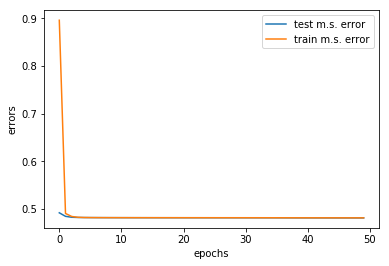

In [325]:
mlp_12 = MLP()
mlp_12.initialize(NI=16, NH=10, NO=26, activation_h=tanh, activation_o=linear)
mlp_12.train(X_letters_train, y_letters_train, n_epochs=50, batch_size=500, learning_rate=0.00015, X_test=X_letters_test, y_test=y_letters_test)
#

In [326]:
for i in range(10):
    index = np.random.randint(3000)
    print("train")
    print(encoder.inverse_transform(mlp_12.predict(X_letters_train[index]).reshape(1, -1)))
    print(encoder.inverse_transform(y_letters_train[index].reshape(1, -1)))
    print("test")
    print(encoder.inverse_transform(mlp_12.predict(X_letters_test[index]).reshape(1, -1)))
    print(encoder.inverse_transform(y_letters_test[index].reshape(1, -1)))

train
[['U']]
[['V']]
test
[['U']]
[['X']]
train
[['U']]
[['W']]
test
[['U']]
[['B']]
train
[['U']]
[['B']]
test
[['U']]
[['K']]
train
[['U']]
[['F']]
test
[['U']]
[['U']]
train
[['U']]
[['Z']]
test
[['U']]
[['B']]
train
[['U']]
[['S']]
test
[['U']]
[['H']]
train
[['U']]
[['Q']]
test
[['U']]
[['S']]
train
[['U']]
[['S']]
test
[['U']]
[['U']]
train
[['U']]
[['X']]
test
[['U']]
[['G']]
train
[['U']]
[['V']]
test
[['U']]
[['W']]


Epoch = 0 MSError= 7696.560355861054
Epoch = 1 MSError= 7696.35054968158
Epoch = 2 MSError= 7696.131322984206
Epoch = 3 MSError= 7695.902041646045
Epoch = 4 MSError= 7695.662032024221
Epoch = 5 MSError= 7695.410582866473
Epoch = 6 MSError= 7695.146949308971
Epoch = 7 MSError= 7694.870359546346
Epoch = 8 MSError= 7694.580024768962
Epoch = 9 MSError= 7694.275152909773
Epoch = 10 MSError= 7693.9549666045805
Epoch = 11 MSError= 7693.61872548235
Epoch = 12 MSError= 7693.265752464133
Epoch = 13 MSError= 7692.895463140783
Epoch = 14 MSError= 7692.507396558937
Epoch = 15 MSError= 7692.101244971551
Epoch = 16 MSError= 7691.676879444509
Epoch = 17 MSError= 7691.234367865809
Epoch = 18 MSError= 7690.7739820752695
Epoch = 19 MSError= 7690.296191649462
Epoch = 20 MSError= 7689.801643341717
Epoch = 21 MSError= 7689.2911270684635
Epoch = 22 MSError= 7688.765531296048
Epoch = 23 MSError= 7688.225792251777
Epoch = 24 MSError= 7687.672842196054
Epoch = 25 MSError= 7687.107561861837
Epoch = 26 MSError= 7

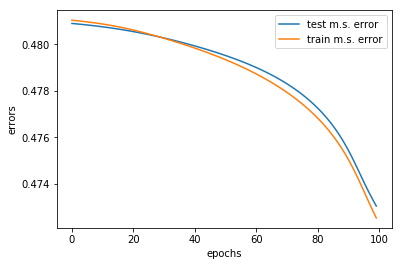

In [327]:
mlp_12.train(X_letters_train, y_letters_train, n_epochs=100, batch_size=500, learning_rate=0.00015, X_test=X_letters_test, y_test=y_letters_test)
#

Epoch = 0 MSError= 7556.3566724724815
Epoch = 1 MSError= 7552.140647175108
Epoch = 2 MSError= 7547.998179035274
Epoch = 3 MSError= 7543.910670827323
Epoch = 4 MSError= 7539.864064451382
Epoch = 5 MSError= 7535.849394339514
Epoch = 6 MSError= 7531.862197666404
Epoch = 7 MSError= 7527.901533791039
Epoch = 8 MSError= 7523.969003065711
Epoch = 9 MSError= 7520.067921089183
Epoch = 10 MSError= 7516.202682028104
Epoch = 11 MSError= 7512.378291613813
Epoch = 12 MSError= 7508.6000339097345
Epoch = 13 MSError= 7504.873236099958
Epoch = 14 MSError= 7501.203101925309
Epoch = 15 MSError= 7497.594592012205
Epoch = 16 MSError= 7494.052336178525
Epoch = 17 MSError= 7490.580568239096
Epoch = 18 MSError= 7487.183077872522
Epoch = 19 MSError= 7483.863176940812
Epoch = 20 MSError= 7480.623679444291
Epoch = 21 MSError= 7477.4668951496315
Epoch = 22 MSError= 7474.3946368952
Epoch = 23 MSError= 7471.408240735022
Epoch = 24 MSError= 7468.508596664168
Epoch = 25 MSError= 7465.696186104712
Epoch = 26 MSError= 7

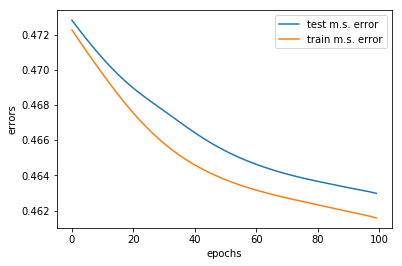

In [328]:
mlp_12.train(X_letters_train, y_letters_train, n_epochs=100, batch_size=500, learning_rate=0.00015, X_test=X_letters_test, y_test=y_letters_test)
#

In [329]:
for i in range(10):
    index = np.random.randint(3000)
    print("train")
    print(encoder.inverse_transform(mlp_12.predict(X_letters_train[index]).reshape(1, -1)))
    print(encoder.inverse_transform(y_letters_train[index].reshape(1, -1)))
    print("test")
    print(encoder.inverse_transform(mlp_12.predict(X_letters_test[index]).reshape(1, -1)))
    print(encoder.inverse_transform(y_letters_test[index].reshape(1, -1)))

train
[['U']]
[['C']]
test
[['U']]
[['D']]
train
[['U']]
[['I']]
test
[['U']]
[['Z']]
train
[['U']]
[['O']]
test
[['A']]
[['A']]
train
[['U']]
[['S']]
test
[['U']]
[['H']]
train
[['U']]
[['J']]
test
[['U']]
[['E']]
train
[['U']]
[['C']]
test
[['U']]
[['D']]
train
[['U']]
[['T']]
test
[['U']]
[['Y']]
train
[['U']]
[['Z']]
test
[['U']]
[['Z']]
train
[['U']]
[['T']]
test
[['U']]
[['D']]
train
[['U']]
[['N']]
test
[['U']]
[['W']]


Epoch = 0 MSError= 7384.459103940751
Epoch = 1 MSError= 7383.51740417218
Epoch = 2 MSError= 7382.384721781801
Epoch = 3 MSError= 7380.933986224964
Epoch = 4 MSError= 7378.9248418405705
Epoch = 5 MSError= 7375.909500592635
Epoch = 6 MSError= 7371.2150572050805
Epoch = 7 MSError= 7364.4505351526395
Epoch = 8 MSError= 7356.348040738587
Epoch = 9 MSError= 7348.183407295183
Epoch = 10 MSError= 7340.6742400539815
Epoch = 11 MSError= 7334.004922903864
Epoch = 12 MSError= 7328.1339153560675
Epoch = 13 MSError= 7322.933479620301
Epoch = 14 MSError= 7318.254340657366
Epoch = 15 MSError= 7313.959567899033
Epoch = 16 MSError= 7309.937320508728
Epoch = 17 MSError= 7306.101458800381
Epoch = 18 MSError= 7302.387283255409
Epoch = 19 MSError= 7298.7463830352035
Epoch = 20 MSError= 7295.142216939252
Epoch = 21 MSError= 7291.546868646964
Epoch = 22 MSError= 7287.938948406407
Epoch = 23 MSError= 7284.302433040864
Epoch = 24 MSError= 7280.626131366771
Epoch = 25 MSError= 7276.903417055116
Epoch = 26 MSErro

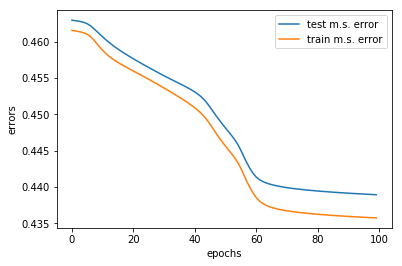

In [330]:
mlp_12.train(X_letters_train, y_letters_train, n_epochs=100, batch_size=500, learning_rate=0.00015, X_test=X_letters_test, y_test=y_letters_test)
#

In [331]:
for i in range(10):
    index = np.random.randint(3000)
    print("train")
    print(encoder.inverse_transform(mlp_12.predict(X_letters_train[index]).reshape(1, -1)))
    print(encoder.inverse_transform(y_letters_train[index].reshape(1, -1)))
    print("test")
    print(encoder.inverse_transform(mlp_12.predict(X_letters_test[index]).reshape(1, -1)))
    print(encoder.inverse_transform(y_letters_test[index].reshape(1, -1)))

train
[['U']]
[['E']]
test
[['U']]
[['I']]
train
[['L']]
[['L']]
test
[['U']]
[['D']]
train
[['L']]
[['X']]
test
[['U']]
[['I']]
train
[['U']]
[['R']]
test
[['U']]
[['D']]
train
[['U']]
[['V']]
test
[['U']]
[['P']]
train
[['U']]
[['G']]
test
[['U']]
[['N']]
train
[['U']]
[['R']]
test
[['U']]
[['G']]
train
[['U']]
[['J']]
test
[['U']]
[['V']]
train
[['U']]
[['B']]
test
[['U']]
[['Y']]
train
[['U']]
[['J']]
test
[['A']]
[['G']]


Epoch = 0 MSError= 6971.722936515192
Epoch = 1 MSError= 6971.403523985923
Epoch = 2 MSError= 6971.090250495556
Epoch = 3 MSError= 6970.782894053958
Epoch = 4 MSError= 6970.481250224062
Epoch = 5 MSError= 6970.185130402015
Epoch = 6 MSError= 6969.894360295317
Epoch = 7 MSError= 6969.6087785681575
Epoch = 8 MSError= 6969.3282356287355
Epoch = 9 MSError= 6969.052592536255
Epoch = 10 MSError= 6968.781720011079
Epoch = 11 MSError= 6968.515497532458
Epoch = 12 MSError= 6968.253812513193
Epoch = 13 MSError= 6967.996559540216
Epoch = 14 MSError= 6967.74363967479
Epoch = 15 MSError= 6967.494959805022
Epoch = 16 MSError= 6967.250432046453
Epoch = 17 MSError= 6967.009973186635
Epoch = 18 MSError= 6966.773504170815
Epoch = 19 MSError= 6966.540949626181
Epoch = 20 MSError= 6966.312237423164
Epoch = 21 MSError= 6966.087298271958
Epoch = 22 MSError= 6965.866065353406
Epoch = 23 MSError= 6965.64847398266
Epoch = 24 MSError= 6965.4344613051835
Epoch = 25 MSError= 6965.223966023519
Epoch = 26 MSError= 6

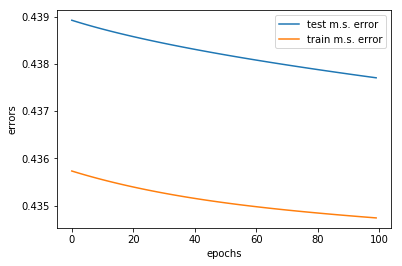

In [332]:
mlp_12.train(X_letters_train, y_letters_train, n_epochs=100, batch_size=500, learning_rate=0.00015, X_test=X_letters_test, y_test=y_letters_test)
#

In [335]:
for i in range(10):
    index = np.random.randint(3000)
    print("train")
    print(encoder.inverse_transform(mlp_12.predict(X_letters_train[index]).reshape(1, -1)))
    print(encoder.inverse_transform(y_letters_train[index].reshape(1, -1)))
    print("test")
    print(encoder.inverse_transform(mlp_12.predict(X_letters_test[index]).reshape(1, -1)))
    print(encoder.inverse_transform(y_letters_test[index].reshape(1, -1)))

train
[['U']]
[['N']]
test
[['U']]
[['N']]
train
[['U']]
[['O']]
test
[['U']]
[['R']]
train
[['U']]
[['U']]
test
[['A']]
[['A']]
train
[['U']]
[['Z']]
test
[['U']]
[['F']]
train
[['U']]
[['Y']]
test
[['L']]
[['L']]
train
[['U']]
[['P']]
test
[['U']]
[['E']]
train
[['U']]
[['H']]
test
[['A']]
[['A']]
train
[['U']]
[['S']]
test
[['U']]
[['Z']]
train
[['U']]
[['T']]
test
[['M']]
[['M']]
train
[['U']]
[['O']]
test
[['U']]
[['U']]


In [ ]:
mlp_12.train(X_letters_train, y_letters_train, n_epochs=500, batch_size=500, learning_rate=0.00015, X_test=X_letters_test, y_test=y_letters_test)
#

Epoch = 0 MSError= 6955.767544276382
Epoch = 1 MSError= 6955.687860517874
Epoch = 2 MSError= 6955.608731192716
Epoch = 3 MSError= 6955.530141470304
Epoch = 4 MSError= 6955.452076907188
Epoch = 5 MSError= 6955.374523436157
Epoch = 6 MSError= 6955.297467355958
Epoch = 7 MSError= 6955.220895320798
Epoch = 8 MSError= 6955.144794330375
Epoch = 9 MSError= 6955.069151720782
Epoch = 10 MSError= 6954.993955154726
Epoch = 11 MSError= 6954.919192612276
Epoch = 12 MSError= 6954.844852382889
Epoch = 13 MSError= 6954.770923056444
Epoch = 14 MSError= 6954.69739351504
Epoch = 15 MSError= 6954.624252925266
Epoch = 16 MSError= 6954.551490730724
Epoch = 17 MSError= 6954.479096644547
Epoch = 18 MSError= 6954.407060642397


In [ ]:
mlp_12 = MLP()
mlp_11.initialize(NI=4, NH=5, NO=1, activation_h=tanh, activation_o=linear)
mlp_11.train(X_train, y_train, n_epochs=10000, batch_size=50, learning_rate=0.1, X_test=X_test, y_test=y_test)